In [1]:
pname = 'stokes'
n_params = 7

# NB: order training meshes by largest first
train_mesh_names = ['reference_mesh_large.csv']#, 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
train_solution_names = ['matrix_large.mat']#, 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

test_mesh_names = ['reference_mesh_large.csv', 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
test_solution_names = ['matrix_large.mat', 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

save_name = 'best_model_l_single.pt'

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pykdtree.kdtree import KDTree
import math
import random
import matplotlib.pyplot as plt

In [3]:
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# double precision
# explanation for when this is required at https://blog.demofox.org/2017/11/21/floating-point-precision/
precision = torch.float32
torch.set_default_dtype(precision)

## THE MODEL

In [4]:
class GFN_AE(nn.Module):
    """
    Module implementing the GFN method for the encoder and decoder architectures.
    Methods:
    __init__: initialises the master mesh, and master weight & biases for the 1st and last layer of the encoder and decoder, respectively
    expand: add all new expansive nodes in the new mesh to the weight matrices
    agglomerate: agglomerate nodes to fit the new mesh
    encoder: execute the encoder part
    decoder: execute the decoder part
    """
    def __init__(self, mesh_m, latent_size=20):
        super().__init__()
        size = mesh_m.shape[0]
        self.latent_size = latent_size
        self.We_m = nn.Parameter(torch.empty(size, self.latent_size))
        self.be_m = nn.Parameter(torch.empty(self.latent_size))
        self.Wd_m = nn.Parameter(torch.empty(self.latent_size, size))
        self.bd_m = nn.Parameter(torch.empty(size))
        self.mesh_m = mesh_m
        
        self.initialise(self.We_m, self.be_m)
        self.initialise(self.Wd_m, self.bd_m)
        
        # Note: no self.be_n since we never need to reshape the encoder biases i.e. be_n == be_m in all cases
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        self.mesh_n = self.mesh_m
        
    def initialise(self, weight, bias):
        stdv = 1. / math.sqrt(weight.size(1))
        weight.data.uniform_(-stdv, stdv)
        bias.data.uniform_(-stdv, stdv)

    def expand(self, mesh_n, kd_tree_m=None, kd_tree_n=None, nn_m=None, nn_n=None, **kwargs):
        """
        Expand the new weights and biases with the new expansive nodes. If during training, update the master weights, biases & mesh.
        If during inference, then just apply the new ones.
        """
        
        # During evaluation, we will have fixed mesh_m so we don't want to recompute every time => option to pass in
        if nn_n is not None:
            pass
        elif kd_tree_n is not None:
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        else:
            kd_tree_m = KDTree(self.mesh_m)
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        # During training, we will have fixed fidelities that we know and don't need to always recompute
        if nn_m is not None:
            pass
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]

        if not self.training:
            # ! testing mode !
            
            # could assign with .data calls here but can't do for train https://discuss.pytorch.org/t/function-tbackward-returned-an-invalid-gradient-at-index-0-got-1-3-but-expected-shape-compatible-with-1-2/125259
            
            count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
            nodes_added = 0 # how much did we increase our master mesh

            for pt_n, pt_m in enumerate(nn_n):
                if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                    nodes_added += 1
                    self.mesh_n = np.vstack([self.mesh_n, mesh_n[pt_n]])
                    count_m[pt_m]+=1

                    # Divide encoder weights by number of expansions
                    self.We_n[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                    # Store the index of the weight we want
                    # so we can update at the end without storing
                    # all the nodes to update explictly
                    new_row = torch.zeros(1, self.We_n.shape[1])
                    new_row[0][0] = pt_m
                    self.We_n = torch.cat((self.We_n, new_row), dim=0)

                    # Duplicate weights for decoder
                    self.Wd_n = torch.cat((self.Wd_n, self.Wd_n[:, pt_m:pt_m+1]), dim=1)
                    self.bd_n = torch.cat([self.bd_n, self.bd_n[pt_m:pt_m+1]])

            # Loop over the nodes we need to update using the index we stored in the first element
            for i in range(self.mesh_m.shape[0], self.mesh_m.shape[0]+nodes_added):
                index = int(self.We_n[i,0])
                self.We_n[i] = self.We_n[index]
        else:
            # ! training mode !
            
            # Expansion step is essentially creating new weights from scratch
            # => ignore gradients and therefore allow for slicing on leaf tensor as required
            # (Unless we do something smarter with the gradient tree to track what we're doing...)
            with torch.no_grad():
                count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
                nodes_added = 0 # how much did we increase our master mesh
                size=self.mesh_m.shape[0]

                for pt_n, pt_m in enumerate(nn_n):
                    if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                        nodes_added += 1
                        self.mesh_m=np.vstack([self.mesh_m, mesh_n[pt_n]])
                        count_m[pt_m]+=1
                        
                        # Divide encoder weights by number of expansions
                        self.We_m[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                        # Store the index of the weight we want
                        # so we can update at the end without storing
                        # all the nodes to update explictly
                        new_row = torch.zeros(1, self.We_m.shape[1])
                        new_row[0][0] = pt_m
                        self.We_m = nn.Parameter(torch.cat((self.We_m, new_row), dim=0))
                        
                        # Duplicate weights for decoder
                        self.Wd_m = nn.Parameter(torch.cat((self.Wd_m, self.Wd_m[:, pt_m:pt_m+1]), dim=1))
                        self.bd_m = nn.Parameter(torch.cat([self.bd_m, self.bd_m[pt_m:pt_m+1]]))
                
                # Loop over the nodes we need to update using the index we stored in the first element
                for i in range(size, size+nodes_added):
                    index = int(self.We_m[i,0])
                    self.We_m[i] = self.We_m[index]
            
            # now we need to track gradients from our new master weights
            self.We_n = self.We_m.clone()
            self.Wd_n = self.Wd_m.clone()
            self.bd_n = self.bd_m.clone()
        return nodes_added
        
    def agglomerate(self, mesh_n, kd_tree_n=None, nn_m=None, **kwargs):
        
        # known during training
        if nn_m is not None:
            pass
        # already found in expansion or already known during training
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]

        # FIND NEW WEIGHTS (AGGLOMERATIVE ONLY NOW)
        We_n = torch.zeros((mesh_n.shape[0], self.We_n.shape[1]), device=self.We_n.device)
        Wd_n = torch.zeros((self.We_n.shape[1], mesh_n.shape[0]), device=self.We_n.device)
        bd_n = torch.zeros(mesh_n.shape[0], device=self.We_n.device)

        count_n = np.zeros(mesh_n.shape[0])

        for m, pt_m in enumerate(self.mesh_n): # agglomerate
            nn_n = nn_m[m]
            count_n[nn_n]+=1
            We_n[nn_n] += self.We_n[m]
            Wd_n[:, nn_n] = ( (count_n[nn_n]-1)*Wd_n[:, nn_n] + self.Wd_n[:, m] )/count_n[nn_n]
            bd_n[nn_n] = ( (count_n[nn_n]-1)*bd_n[nn_n] + self.bd_n[m] )/count_n[nn_n]
          
        self.We_n = We_n
        self.Wd_n = Wd_n
        self.bd_n = bd_n
        
    def reset(self):
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        if not self.training:
            self.mesh_n = self.mesh_m
        
    def encoder(self, x, mesh_n, exp_enc=True, agg_enc=True, reset_enc=False, **kwargs):
        if reset_enc:
            self.reset()
        if exp_enc:
            self.expand(mesh_n, **kwargs)
        if agg_enc:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.We_n+self.be_m
        
    def decoder(self, x, mesh_n, exp_dec=True, agg_dec=True, reset_dec=False, **kwargs):
        if reset_dec:
            self.reset()
        if exp_dec:
            self.expand(mesh_n, **kwargs)
        if agg_dec:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.Wd_n+self.bd_n
    
class GCA(nn.Module):
    
    def __init__(self, mesh_m, gfn_latent_size=20, latent_size=20, n_params=7, act=nn.Tanh, ae_sizes=[], map_sizes=[50]*4):
        super().__init__()
        self.GFN = GFN_AE(mesh_m, gfn_latent_size)
        
        self.act = act()
        
        module_list_enc = []
        module_list_dec = []

        for i in range(len(ae_sizes)):
            module_list_dec.append(self.act)
            if i==0:
                module_list_enc.append(nn.Linear(gfn_latent_size, ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], gfn_latent_size))
            else:
                module_list_enc.append(nn.Linear(ae_sizes[i-1], ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], ae_sizes[i-1]))
            module_list_enc.append(self.act)
        if len(ae_sizes)!=0:
            module_list_dec.append(self.act)
            module_list_enc.append(nn.Linear(ae_sizes[-1], latent_size))
            module_list_dec.append(nn.Linear(latent_size, ae_sizes[-1]))
            module_list_enc.append(self.act)
        
        self.encoder = nn.Sequential(*module_list_enc)
        self.decoder = nn.Sequential(*module_list_dec[::-1])
        
        module_list_map = []
        
        for i in range(len(map_sizes)):
            if i==0:
                module_list_map.append(nn.Linear(n_params, map_sizes[i]))
            else:
                module_list_map.append(nn.Linear(map_sizes[i-1], map_sizes[i]))
            module_list_map.append(act())
        if len(map_sizes)!=0:
            module_list_map.append(nn.Linear(map_sizes[-1], latent_size))
            
        self.mapper = nn.Sequential(*module_list_map)
        
    def forward(self, x, mesh_n, params, **kwargs):
        x_enc = self.act(self.GFN.encoder(x, mesh_n, **kwargs))
        x_enc = self.encoder(x_enc)
        
        x_map = self.mapper(params)
        
        x_recon = self.decoder(x_enc)
        x_recon = self.GFN.decoder(x_enc, mesh_n, **kwargs)
        
        return x_recon, x_enc, x_map

## SET UP TRAINING DATA

In [5]:
from itertools import product
import scipy
from sklearn import preprocessing

def get_params(pname='stokes'):
    if pname=='stokes':
        mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
        mus = []
        n_pts = [2]*(len(mu_range)-1)+[11]
        for i in range(len(mu_range)):
            mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
        return torch.tensor(np.array(list(product(*mus))), dtype=precision)
    elif pname=='graetz':
        mus = [np.linspace(1., 3., 10), np.linspace(0.01, 0.1, 20)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)
    elif pname=='advection':
        mus = [np.linspace(0., 6., 10), np.linspace(-1.0, 1.0, 10)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)

def scaler_func():
    return preprocessing.StandardScaler()

def scaling(U):
    scaling_fun_1 = scaler_func()
    scaling_fun_2 = scaler_func()
    scaler_s = scaling_fun_1.fit(U)
    temp = torch.t(torch.tensor(scaler_s.transform(U)))
    scaler_f = scaling_fun_2.fit(temp)
    scaled_data = torch.unsqueeze(torch.t(torch.tensor(scaler_f.transform(temp), dtype=precision)),0).permute(2, 1, 0)
    scale = [scaler_s, scaler_f]
    return scale, scaled_data[:,:,0]

def undo_scaling(U, scale):
    scaler_s = scale[0]
    scaler_f = scale[1]
    rescaled_data = torch.tensor(scaler_s.inverse_transform(torch.t(torch.tensor(scaler_f.inverse_transform(U.detach().numpy().squeeze())))), dtype=precision)
    return rescaled_data

def get_scaled_data(fname):
    U_orig = torch.tensor(scipy.io.loadmat(fname)['U'])
    scale, U_sc = scaling(U_orig)
    print('reconstruction error', ((U_orig - undo_scaling(U_sc, scale))**2).sum())
    return scale, U_sc

C:\Users\oisin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
params = get_params(pname).to(dev)

dfs_train = [pd.read_csv(i, header=None).values for i in train_mesh_names]

sols_train = [get_scaled_data(i)[1].to(dev) for i in train_solution_names]

trajs = list(range(sols_train[0].shape[0]))
random.shuffle(trajs)
train_trajs, test_trajs = np.array_split(trajs, 2)
train_trajs = np.array_split(train_trajs, len(dfs_train))

# train_trajs = random.sample(range(704), 352)
# test_trajs =list(set(range(704))-set(train_trajs))
# train_trajs=[train_trajs[176:], train_trajs[:176]]

reconstruction error tensor(5.4842e-09, dtype=torch.float64)


## TRAIN THE MODEL

In [7]:
# initialisation
# NB - important to start with largest mesh since this is better for initialisation purposes
# and potential savings in no expansions are done
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

added_nodes

0

In [8]:
from tqdm import tqdm

In [9]:
model.train()

# now initialise our optimiser after we have conducted ALL expansions
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

In [10]:
best_loss = np.inf
EPOCHS = 5000
test_losses = []
train_losses = []

def criterion(x, x_recon, x_enc, x_map):
    return nn.functional.mse_loss(x, x_recon)+1e1*nn.functional.mse_loss(x_enc, x_map)

kd_tree_m = KDTree(model.GFN.mesh_m)
# we know ahead of time the nn_n and nn_ms since we know that the master mesh is never changing and our new meshes are fixed
nn_ns = [kd_tree_m.query(df, k=1)[1] for df in dfs_train]
nn_ms = [KDTree(df).query(model.GFN.mesh_m, k=1)[1] for df in dfs_train]

for i in tqdm(range(EPOCHS)):
    opt.zero_grad()

    U_train = sols_train[0][train_trajs[0]]
    params_train = params[train_trajs[0]]
    df_train = dfs_train[0]
    if added_nodes==0:
        # because added_nodes==0, we know we don't need to expand or agglom for the medium mesh
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
    else:
        # NEED TO TEST
        # we need to agglomerate because added_nodes>0. However, we do this all in the encoder first so we can avoid in the decoder
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])

    loss = criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]

    # other fidelities
    for j in range(1, len(dfs_train)):
        U_train = sols_train[j][train_trajs[j]]
        params_train = params[train_trajs[j]]
        df_train = dfs_train[j]
        
        # only need to agglom in training since we expanded as a preprocessing step
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
        loss += criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]
    
    loss /= np.sum([k.shape[0] for k in dfs_train])
    loss.backward()
    opt.step()
    
    train_loss = loss.item()
    
    with torch.no_grad():
        params_test = params[test_trajs]
        
        U_test = sols_train[0][test_trajs]
        df_test = dfs_train[0]

        if added_nodes==0:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
        else:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])
        test_loss = criterion(U_test, x_recon, x_enc, x_map).item()*df_test.shape[0]

        for j in range(1, len(dfs_train)):
            U_test = sols_train[j][test_trajs]
            df_test = dfs_train[j]
            
            # only need to agglom in training since we expanded as a preprocessing step
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
            test_loss += criterion(U_test, x_recon, x_enc, x_map).item()*df_train.shape[0]
        
        test_loss /= np.sum([k.shape[0] for k in dfs_train])
    
    print(f'Epoch {i}: train loss: {train_loss} | test loss: {test_loss}')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_loss<best_loss:
        best_loss=test_loss
        best_epoch = i
        torch.save(model.state_dict(), save_name)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Epoch 0: train loss: 10.513962745666504 | test loss: 10.120596885681152
Epoch 1: train loss: 10.064238548278809 | test loss: 9.87725830078125


  0%|                                                                                 | 3/5000 [00:00<04:08, 20.07it/s]

Epoch 2: train loss: 9.74605941772461 | test loss: 9.574371337890625
Epoch 3: train loss: 9.421878814697266 | test loss: 9.320747375488281
Epoch 4: train loss: 9.17707633972168 | test loss: 9.081611633300781


  0%|                                                                                 | 6/5000 [00:00<04:17, 19.39it/s]

Epoch 5: train loss: 8.971105575561523 | test loss: 8.86925220489502


  0%|▏                                                                                | 8/5000 [00:00<04:24, 18.86it/s]

Epoch 6: train loss: 8.652168273925781 | test loss: 8.630533218383789
Epoch 7: train loss: 8.462413787841797 | test loss: 8.386245727539062
Epoch 8: train loss: 8.199177742004395 | test loss: 8.222541809082031


  0%|▏                                                                               | 10/5000 [00:00<04:35, 18.14it/s]

Epoch 9: train loss: 8.055535316467285 | test loss: 7.855068683624268


  0%|▏                                                                               | 12/5000 [00:00<04:39, 17.87it/s]

Epoch 10: train loss: 7.714865684509277 | test loss: 7.558891773223877
Epoch 11: train loss: 7.431090354919434 | test loss: 7.34996223449707
Epoch 12: train loss: 7.2347235679626465 | test loss: 7.079716205596924


  0%|▏                                                                               | 14/5000 [00:00<04:39, 17.86it/s]

Epoch 13: train loss: 7.017882823944092 | test loss: 6.867642402648926


  0%|▎                                                                               | 16/5000 [00:00<04:33, 18.24it/s]

Epoch 14: train loss: 6.851604461669922 | test loss: 6.637302875518799
Epoch 15: train loss: 6.563760757446289 | test loss: 6.437158107757568
Epoch 16: train loss: 6.389009475708008 | test loss: 6.128844738006592
Epoch 17: train loss: 6.172682285308838 | test loss: 5.951246738433838


  0%|▎                                                                               | 20/5000 [00:01<04:36, 18.01it/s]

Epoch 18: train loss: 6.001629829406738 | test loss: 5.7338128089904785
Epoch 19: train loss: 5.819096565246582 | test loss: 5.47221565246582
Epoch 20: train loss: 5.632360458374023 | test loss: 5.242302894592285
Epoch 21: train loss: 5.478826522827148 | test loss: 5.123383045196533
Epoch 22: train loss: 5.386584281921387 | test loss: 5.015439987182617


  0%|▍                                                                               | 25/5000 [00:01<04:23, 18.88it/s]

Epoch 23: train loss: 5.274765968322754 | test loss: 4.929862022399902
Epoch 24: train loss: 5.163949966430664 | test loss: 4.79436731338501


  1%|▍                                                                               | 27/5000 [00:01<04:27, 18.61it/s]

Epoch 25: train loss: 5.058568000793457 | test loss: 4.665112018585205
Epoch 26: train loss: 4.938964366912842 | test loss: 4.529553413391113


  1%|▍                                                                               | 29/5000 [00:01<04:30, 18.37it/s]

Epoch 27: train loss: 4.805172920227051 | test loss: 4.442281723022461
Epoch 28: train loss: 4.732918739318848 | test loss: 4.404842853546143


  1%|▍                                                                               | 31/5000 [00:01<04:32, 18.21it/s]

Epoch 29: train loss: 4.644238471984863 | test loss: 4.316647529602051
Epoch 30: train loss: 4.540835857391357 | test loss: 4.26770544052124


  1%|▌                                                                               | 33/5000 [00:01<04:27, 18.55it/s]

Epoch 31: train loss: 4.497185707092285 | test loss: 4.229733467102051
Epoch 32: train loss: 4.454534530639648 | test loss: 4.162463665008545
Epoch 33: train loss: 4.402955055236816 | test loss: 4.190061092376709


  1%|▌                                                                               | 35/5000 [00:01<04:36, 17.95it/s]

Epoch 34: train loss: 4.389561176300049 | test loss: 4.141533851623535


  1%|▌                                                                               | 37/5000 [00:02<04:36, 17.97it/s]

Epoch 35: train loss: 4.443969249725342 | test loss: 4.080169200897217
Epoch 36: train loss: 4.261624336242676 | test loss: 4.170195579528809
Epoch 37: train loss: 4.333678722381592 | test loss: 4.064100742340088


  1%|▌                                                                               | 39/5000 [00:02<04:30, 18.37it/s]

Epoch 38: train loss: 4.236557960510254 | test loss: 4.026376247406006


  1%|▋                                                                               | 41/5000 [00:02<04:32, 18.18it/s]

Epoch 39: train loss: 4.222846508026123 | test loss: 3.9501922130584717
Epoch 40: train loss: 4.150104999542236 | test loss: 3.9824886322021484
Epoch 41: train loss: 4.170397758483887 | test loss: 3.8971707820892334
Epoch 42: train loss: 4.075941562652588 | test loss: 3.8785359859466553


  1%|▊                                                                               | 47/5000 [00:02<04:29, 18.39it/s]

Epoch 43: train loss: 4.066105842590332 | test loss: 3.794959783554077
Epoch 44: train loss: 3.994306802749634 | test loss: 3.7884435653686523
Epoch 45: train loss: 4.032287120819092 | test loss: 3.678239583969116
Epoch 46: train loss: 3.893861770629883 | test loss: 3.6890368461608887


  1%|▊                                                                               | 51/5000 [00:02<04:33, 18.07it/s]

Epoch 47: train loss: 3.8640987873077393 | test loss: 3.618302345275879
Epoch 48: train loss: 3.8020124435424805 | test loss: 3.5974206924438477
Epoch 49: train loss: 3.8016271591186523 | test loss: 3.58414888381958
Epoch 50: train loss: 3.7935314178466797 | test loss: 3.567453384399414
Epoch 51: train loss: 3.7353992462158203 | test loss: 3.5316052436828613


  1%|▉                                                                               | 55/5000 [00:03<04:31, 18.23it/s]

Epoch 52: train loss: 3.696730375289917 | test loss: 3.5097243785858154
Epoch 53: train loss: 3.65289306640625 | test loss: 3.4025282859802246
Epoch 54: train loss: 3.549901247024536 | test loss: 3.4582557678222656
Epoch 55: train loss: 3.5570878982543945 | test loss: 3.3837192058563232
Epoch 56: train loss: 3.5514094829559326 | test loss: 3.3377938270568848


  1%|▉                                                                               | 59/5000 [00:03<04:19, 19.06it/s]

Epoch 57: train loss: 3.450308084487915 | test loss: 3.3536179065704346
Epoch 58: train loss: 3.482573986053467 | test loss: 3.3661582469940186
Epoch 59: train loss: 3.44096302986145 | test loss: 3.248201608657837
Epoch 60: train loss: 3.3560233116149902 | test loss: 3.2300634384155273
Epoch 61: train loss: 3.3151302337646484 | test loss: 3.166940212249756


  1%|█                                                                               | 65/5000 [00:03<04:11, 19.62it/s]

Epoch 62: train loss: 3.261974811553955 | test loss: 3.1284101009368896
Epoch 63: train loss: 3.2090883255004883 | test loss: 3.1009981632232666
Epoch 64: train loss: 3.156031608581543 | test loss: 3.06996488571167
Epoch 65: train loss: 3.1082653999328613 | test loss: 3.0331199169158936


  1%|█                                                                               | 69/5000 [00:03<04:14, 19.38it/s]

Epoch 66: train loss: 3.063516855239868 | test loss: 3.016984701156616
Epoch 67: train loss: 3.0288007259368896 | test loss: 2.931626796722412
Epoch 68: train loss: 2.95797061920166 | test loss: 2.9309186935424805
Epoch 69: train loss: 2.9071693420410156 | test loss: 2.9245729446411133
Epoch 70: train loss: 2.867354154586792 | test loss: 2.908188819885254


  2%|█▏                                                                              | 76/5000 [00:04<04:06, 20.01it/s]

Epoch 71: train loss: 2.8467857837677 | test loss: 2.8837740421295166
Epoch 72: train loss: 2.8314924240112305 | test loss: 2.8761825561523438
Epoch 73: train loss: 2.778050422668457 | test loss: 2.83096981048584
Epoch 74: train loss: 2.743664503097534 | test loss: 2.8200838565826416
Epoch 75: train loss: 2.7379093170166016 | test loss: 2.834441900253296


  2%|█▏                                                                              | 78/5000 [00:04<04:13, 19.44it/s]

Epoch 76: train loss: 2.758507013320923 | test loss: 2.893362522125244
Epoch 77: train loss: 2.769089460372925 | test loss: 2.8274316787719727
Epoch 78: train loss: 2.673034191131592 | test loss: 2.8175556659698486
Epoch 79: train loss: 2.6413354873657227 | test loss: 2.7988452911376953


  2%|█▎                                                                              | 83/5000 [00:04<04:18, 19.01it/s]

Epoch 80: train loss: 2.6711249351501465 | test loss: 2.7648086547851562
Epoch 81: train loss: 2.6169958114624023 | test loss: 2.7472965717315674
Epoch 82: train loss: 2.587286949157715 | test loss: 2.6819381713867188
Epoch 83: train loss: 2.532180070877075 | test loss: 2.658055305480957
Epoch 84: train loss: 2.507120370864868 | test loss: 2.6394567489624023


  2%|█▍                                                                              | 89/5000 [00:04<04:30, 18.15it/s]

Epoch 85: train loss: 2.486236333847046 | test loss: 2.6104719638824463
Epoch 86: train loss: 2.4512178897857666 | test loss: 2.606459856033325
Epoch 87: train loss: 2.4423394203186035 | test loss: 2.5690269470214844
Epoch 88: train loss: 2.3992576599121094 | test loss: 2.5360045433044434
Epoch 89: train loss: 2.373072862625122 | test loss: 2.503178596496582


  2%|█▍                                                                              | 93/5000 [00:04<04:22, 18.70it/s]

Epoch 90: train loss: 2.333174467086792 | test loss: 2.4790616035461426
Epoch 91: train loss: 2.302371025085449 | test loss: 2.434924602508545
Epoch 92: train loss: 2.266846179962158 | test loss: 2.41511869430542
Epoch 93: train loss: 2.247304916381836 | test loss: 2.396611213684082
Epoch 94: train loss: 2.226306915283203 | test loss: 2.3993113040924072


  2%|█▌                                                                              | 99/5000 [00:05<04:05, 19.93it/s]

Epoch 95: train loss: 2.2086925506591797 | test loss: 2.375792980194092
Epoch 96: train loss: 2.1763691902160645 | test loss: 2.360722303390503
Epoch 97: train loss: 2.152844190597534 | test loss: 2.3543202877044678
Epoch 98: train loss: 2.1241440773010254 | test loss: 2.3290956020355225
Epoch 99: train loss: 2.0937774181365967 | test loss: 2.2966465950012207


  2%|█▋                                                                             | 103/5000 [00:05<04:14, 19.21it/s]

Epoch 100: train loss: 2.0657670497894287 | test loss: 2.2799954414367676
Epoch 101: train loss: 2.0474843978881836 | test loss: 2.260585308074951
Epoch 102: train loss: 2.027865409851074 | test loss: 2.250422954559326
Epoch 103: train loss: 2.0098257064819336 | test loss: 2.2322497367858887


  2%|█▋                                                                             | 107/5000 [00:05<04:16, 19.05it/s]

Epoch 104: train loss: 1.9808154106140137 | test loss: 2.2083816528320312
Epoch 105: train loss: 1.9523594379425049 | test loss: 2.199476718902588
Epoch 106: train loss: 1.9280290603637695 | test loss: 2.168761968612671
Epoch 107: train loss: 1.9085310697555542 | test loss: 2.1475565433502197


  2%|█▊                                                                             | 112/5000 [00:05<04:09, 19.57it/s]

Epoch 108: train loss: 1.8802435398101807 | test loss: 2.103278160095215
Epoch 109: train loss: 1.8461734056472778 | test loss: 2.0832080841064453
Epoch 110: train loss: 1.8171379566192627 | test loss: 2.0689826011657715
Epoch 111: train loss: 1.7863483428955078 | test loss: 2.060791492462158
Epoch 112: train loss: 1.786603569984436 | test loss: 2.094242572784424


  2%|█▊                                                                             | 116/5000 [00:06<04:11, 19.43it/s]

Epoch 113: train loss: 1.7862966060638428 | test loss: 2.0339345932006836
Epoch 114: train loss: 1.7680100202560425 | test loss: 1.9998693466186523
Epoch 115: train loss: 1.722167730331421 | test loss: 1.9762370586395264
Epoch 116: train loss: 1.7022392749786377 | test loss: 1.9543577432632446
Epoch 117: train loss: 1.6777992248535156 | test loss: 1.9378719329833984


  2%|█▉                                                                             | 121/5000 [00:06<04:09, 19.56it/s]

Epoch 118: train loss: 1.6574537754058838 | test loss: 1.9378706216812134
Epoch 119: train loss: 1.663987159729004 | test loss: 1.8909118175506592
Epoch 120: train loss: 1.6141870021820068 | test loss: 1.8799244165420532
Epoch 121: train loss: 1.6042039394378662 | test loss: 1.8472578525543213
Epoch 122: train loss: 1.569258451461792 | test loss: 1.8116518259048462


  2%|█▉                                                                             | 125/5000 [00:06<04:15, 19.08it/s]

Epoch 123: train loss: 1.5221620798110962 | test loss: 1.7980029582977295
Epoch 124: train loss: 1.50931978225708 | test loss: 1.7720786333084106
Epoch 125: train loss: 1.4749209880828857 | test loss: 1.7573118209838867


  3%|██                                                                             | 129/5000 [00:06<04:19, 18.76it/s]

Epoch 126: train loss: 1.4429185390472412 | test loss: 1.7335309982299805
Epoch 127: train loss: 1.4258743524551392 | test loss: 1.7164312601089478
Epoch 128: train loss: 1.3978184461593628 | test loss: 1.70247220993042
Epoch 129: train loss: 1.377821445465088 | test loss: 1.6766061782836914


  3%|██                                                                             | 133/5000 [00:07<04:21, 18.59it/s]

Epoch 130: train loss: 1.3612524271011353 | test loss: 1.6499156951904297
Epoch 131: train loss: 1.3291471004486084 | test loss: 1.6350810527801514
Epoch 132: train loss: 1.3104660511016846 | test loss: 1.6226778030395508
Epoch 133: train loss: 1.2925692796707153 | test loss: 1.6052377223968506
Epoch 134: train loss: 1.2793490886688232 | test loss: 1.5905342102050781


  3%|██▏                                                                            | 139/5000 [00:07<04:08, 19.59it/s]

Epoch 135: train loss: 1.2624783515930176 | test loss: 1.5541105270385742
Epoch 136: train loss: 1.2212263345718384 | test loss: 1.534477949142456
Epoch 137: train loss: 1.1960668563842773 | test loss: 1.5178849697113037
Epoch 138: train loss: 1.1757489442825317 | test loss: 1.4966561794281006
Epoch 139: train loss: 1.1643744707107544 | test loss: 1.489632248878479


  3%|██▎                                                                            | 144/5000 [00:07<04:06, 19.69it/s]

Epoch 140: train loss: 1.139827013015747 | test loss: 1.4746677875518799
Epoch 141: train loss: 1.1228562593460083 | test loss: 1.456214427947998
Epoch 142: train loss: 1.1094961166381836 | test loss: 1.4608409404754639
Epoch 143: train loss: 1.1009416580200195 | test loss: 1.4457284212112427
Epoch 144: train loss: 1.0889023542404175 | test loss: 1.434239149093628


  3%|██▎                                                                            | 149/5000 [00:07<04:04, 19.85it/s]

Epoch 145: train loss: 1.0781948566436768 | test loss: 1.4241012334823608
Epoch 146: train loss: 1.054108738899231 | test loss: 1.4161049127578735
Epoch 147: train loss: 1.0492684841156006 | test loss: 1.405120611190796
Epoch 148: train loss: 1.0262978076934814 | test loss: 1.3832180500030518


  3%|██▍                                                                            | 151/5000 [00:07<04:12, 19.17it/s]

Epoch 149: train loss: 1.013487696647644 | test loss: 1.3753645420074463
Epoch 150: train loss: 0.9995867013931274 | test loss: 1.3607240915298462
Epoch 151: train loss: 0.979672908782959 | test loss: 1.346712589263916
Epoch 152: train loss: 0.9733465909957886 | test loss: 1.3318431377410889
Epoch 153: train loss: 0.9599908590316772 | test loss: 1.3383231163024902


  3%|██▍                                                                            | 157/5000 [00:08<03:57, 20.42it/s]

Epoch 154: train loss: 0.952347993850708 | test loss: 1.3116673231124878
Epoch 155: train loss: 0.9388943910598755 | test loss: 1.3121784925460815
Epoch 156: train loss: 0.9312313795089722 | test loss: 1.311158537864685
Epoch 157: train loss: 0.9280239343643188 | test loss: 1.3032678365707397


  3%|██▌                                                                            | 160/5000 [00:08<03:53, 20.69it/s]

Epoch 158: train loss: 0.9256670475006104 | test loss: 1.3008129596710205
Epoch 159: train loss: 0.9266558885574341 | test loss: 1.3174858093261719
Epoch 160: train loss: 0.9267000555992126 | test loss: 1.2882087230682373
Epoch 161: train loss: 0.9218525886535645 | test loss: 1.2821555137634277


  3%|██▌                                                                            | 166/5000 [00:08<04:04, 19.79it/s]

Epoch 162: train loss: 0.9102743268013 | test loss: 1.282658576965332
Epoch 163: train loss: 0.8930423855781555 | test loss: 1.269181251525879
Epoch 164: train loss: 0.881854772567749 | test loss: 1.2468879222869873
Epoch 165: train loss: 0.870631217956543 | test loss: 1.237682819366455
Epoch 166: train loss: 0.8672411441802979 | test loss: 1.2520859241485596


  3%|██▋                                                                            | 170/5000 [00:08<04:05, 19.66it/s]

Epoch 167: train loss: 0.8614223003387451 | test loss: 1.2481472492218018
Epoch 168: train loss: 0.858887791633606 | test loss: 1.2350122928619385
Epoch 169: train loss: 0.8581316471099854 | test loss: 1.221875548362732
Epoch 170: train loss: 0.8539965748786926 | test loss: 1.2387714385986328


  3%|██▋                                                                            | 173/5000 [00:09<04:02, 19.92it/s]

Epoch 171: train loss: 0.853136420249939 | test loss: 1.2379393577575684
Epoch 172: train loss: 0.8536264300346375 | test loss: 1.2171454429626465
Epoch 173: train loss: 0.8474111557006836 | test loss: 1.2143974304199219
Epoch 174: train loss: 0.8413441181182861 | test loss: 1.2129020690917969
Epoch 175: train loss: 0.8337697982788086 | test loss: 1.2041934728622437


  4%|██▊                                                                            | 179/5000 [00:09<03:59, 20.11it/s]

Epoch 176: train loss: 0.8279430866241455 | test loss: 1.1920078992843628
Epoch 177: train loss: 0.8261517286300659 | test loss: 1.1935887336730957
Epoch 178: train loss: 0.8231291174888611 | test loss: 1.1947853565216064
Epoch 179: train loss: 0.8263728618621826 | test loss: 1.188969373703003


  4%|██▉                                                                            | 184/5000 [00:09<04:08, 19.41it/s]

Epoch 180: train loss: 0.8222818374633789 | test loss: 1.1811643838882446
Epoch 181: train loss: 0.8175029754638672 | test loss: 1.1780813932418823
Epoch 182: train loss: 0.8124794363975525 | test loss: 1.177389144897461
Epoch 183: train loss: 0.8073908686637878 | test loss: 1.1715281009674072
Epoch 184: train loss: 0.8053338527679443 | test loss: 1.166733741760254


  4%|██▉                                                                            | 188/5000 [00:09<04:08, 19.34it/s]

Epoch 185: train loss: 0.8065611124038696 | test loss: 1.171400547027588
Epoch 186: train loss: 0.8042327165603638 | test loss: 1.1726645231246948
Epoch 187: train loss: 0.8050047159194946 | test loss: 1.1628576517105103
Epoch 188: train loss: 0.8008087873458862 | test loss: 1.1633026599884033


  4%|███                                                                            | 193/5000 [00:10<03:54, 20.51it/s]

Epoch 189: train loss: 0.7991202473640442 | test loss: 1.1622061729431152
Epoch 190: train loss: 0.7951977849006653 | test loss: 1.1555812358856201
Epoch 191: train loss: 0.7920842170715332 | test loss: 1.1455544233322144
Epoch 192: train loss: 0.7879393100738525 | test loss: 1.146944522857666
Epoch 193: train loss: 0.7834495902061462 | test loss: 1.1382185220718384


  4%|███                                                                            | 196/5000 [00:10<04:05, 19.56it/s]

Epoch 194: train loss: 0.7792792916297913 | test loss: 1.1299704313278198
Epoch 195: train loss: 0.7780487537384033 | test loss: 1.131925106048584
Epoch 196: train loss: 0.776862382888794 | test loss: 1.1299307346343994
Epoch 197: train loss: 0.7786850333213806 | test loss: 1.136049509048462
Epoch 198: train loss: 0.7798856496810913 | test loss: 1.124869465827942


  4%|███▏                                                                           | 202/5000 [00:10<03:58, 20.15it/s]

Epoch 199: train loss: 0.7784580588340759 | test loss: 1.1281723976135254
Epoch 200: train loss: 0.7796814441680908 | test loss: 1.12809157371521
Epoch 201: train loss: 0.7795814275741577 | test loss: 1.1181421279907227
Epoch 202: train loss: 0.7817497849464417 | test loss: 1.1230548620224
Epoch 203: train loss: 0.7788915038108826 | test loss: 1.122295618057251


  4%|███▎                                                                           | 208/5000 [00:10<04:00, 19.93it/s]

Epoch 204: train loss: 0.7803059816360474 | test loss: 1.117905616760254
Epoch 205: train loss: 0.7811487913131714 | test loss: 1.11753511428833
Epoch 206: train loss: 0.7782145142555237 | test loss: 1.119893193244934
Epoch 207: train loss: 0.7812513113021851 | test loss: 1.109675645828247


  4%|███▎                                                                           | 210/5000 [00:10<04:02, 19.71it/s]

Epoch 208: train loss: 0.7748962640762329 | test loss: 1.1234010457992554
Epoch 209: train loss: 0.7814204096794128 | test loss: 1.1028249263763428
Epoch 210: train loss: 0.7769790291786194 | test loss: 1.1052364110946655
Epoch 211: train loss: 0.7700841426849365 | test loss: 1.1059026718139648
Epoch 212: train loss: 0.7658153772354126 | test loss: 1.0834136009216309


  4%|███▍                                                                           | 216/5000 [00:11<03:53, 20.50it/s]

Epoch 213: train loss: 0.7569063901901245 | test loss: 1.0795115232467651
Epoch 214: train loss: 0.7585949897766113 | test loss: 1.0843801498413086
Epoch 215: train loss: 0.7563896179199219 | test loss: 1.089893102645874
Epoch 216: train loss: 0.7586579322814941 | test loss: 1.0895024538040161


  4%|███▍                                                                           | 219/5000 [00:11<03:46, 21.08it/s]

Epoch 217: train loss: 0.761482834815979 | test loss: 1.0859235525131226
Epoch 218: train loss: 0.7672045826911926 | test loss: 1.0840984582901
Epoch 219: train loss: 0.7667655944824219 | test loss: 1.0967875719070435
Epoch 220: train loss: 0.7703837156295776 | test loss: 1.0754060745239258
Epoch 221: train loss: 0.7599890232086182 | test loss: 1.0718258619308472


  4%|███▌                                                                           | 225/5000 [00:11<03:54, 20.35it/s]

Epoch 222: train loss: 0.755058765411377 | test loss: 1.0681703090667725
Epoch 223: train loss: 0.7527556419372559 | test loss: 1.0640491247177124
Epoch 224: train loss: 0.7508466839790344 | test loss: 1.067185401916504
Epoch 225: train loss: 0.7505764365196228 | test loss: 1.0710010528564453
Epoch 226: train loss: 0.751907229423523 | test loss: 1.0739935636520386


  5%|███▋                                                                           | 231/5000 [00:11<03:47, 20.94it/s]

Epoch 227: train loss: 0.7537405490875244 | test loss: 1.0752136707305908
Epoch 228: train loss: 0.7627522349357605 | test loss: 1.082369327545166
Epoch 229: train loss: 0.7637004852294922 | test loss: 1.0819153785705566
Epoch 230: train loss: 0.761031448841095 | test loss: 1.0721111297607422


  5%|███▋                                                                           | 234/5000 [00:12<03:58, 20.00it/s]

Epoch 231: train loss: 0.7554702162742615 | test loss: 1.059855341911316
Epoch 232: train loss: 0.7501109838485718 | test loss: 1.0656105279922485
Epoch 233: train loss: 0.7454107403755188 | test loss: 1.058493733406067
Epoch 234: train loss: 0.741070032119751 | test loss: 1.050105094909668
Epoch 235: train loss: 0.7441421747207642 | test loss: 1.0536963939666748


  5%|███▊                                                                           | 240/5000 [00:12<03:52, 20.49it/s]

Epoch 236: train loss: 0.7453478574752808 | test loss: 1.0666744709014893
Epoch 237: train loss: 0.753809928894043 | test loss: 1.060410737991333
Epoch 238: train loss: 0.7529619336128235 | test loss: 1.0648070573806763
Epoch 239: train loss: 0.7652229070663452 | test loss: 1.061293125152588
Epoch 240: train loss: 0.7573099732398987 | test loss: 1.0755283832550049


  5%|███▊                                                                           | 245/5000 [00:12<04:11, 18.89it/s]

Epoch 241: train loss: 0.7665444612503052 | test loss: 1.0597195625305176
Epoch 242: train loss: 0.7507575154304504 | test loss: 1.0509440898895264
Epoch 243: train loss: 0.7520591020584106 | test loss: 1.0450875759124756
Epoch 244: train loss: 0.7445381879806519 | test loss: 1.0482453107833862


  5%|███▉                                                                           | 249/5000 [00:12<04:20, 18.27it/s]

Epoch 245: train loss: 0.7411335110664368 | test loss: 1.047646403312683
Epoch 246: train loss: 0.7395027279853821 | test loss: 1.0411733388900757
Epoch 247: train loss: 0.7362638711929321 | test loss: 1.0238263607025146
Epoch 248: train loss: 0.733027994632721 | test loss: 1.024769902229309


  5%|███▉                                                                           | 253/5000 [00:13<04:20, 18.21it/s]

Epoch 249: train loss: 0.7314810752868652 | test loss: 1.0281102657318115
Epoch 250: train loss: 0.7312754392623901 | test loss: 1.0300555229187012
Epoch 251: train loss: 0.7299553155899048 | test loss: 1.0232961177825928
Epoch 252: train loss: 0.7342501878738403 | test loss: 1.0166912078857422


  5%|████                                                                           | 257/5000 [00:13<04:31, 17.50it/s]

Epoch 253: train loss: 0.7369958162307739 | test loss: 1.027817964553833
Epoch 254: train loss: 0.7401583790779114 | test loss: 1.034669280052185
Epoch 255: train loss: 0.7420926690101624 | test loss: 1.0263980627059937
Epoch 256: train loss: 0.740803599357605 | test loss: 1.0173470973968506


  5%|████                                                                           | 261/5000 [00:13<04:35, 17.23it/s]

Epoch 257: train loss: 0.7379460334777832 | test loss: 1.0161073207855225
Epoch 258: train loss: 0.7359211444854736 | test loss: 1.0188190937042236
Epoch 259: train loss: 0.7329144477844238 | test loss: 1.0152857303619385
Epoch 260: train loss: 0.7346922159194946 | test loss: 1.0147374868392944


  5%|████▏                                                                          | 263/5000 [00:13<04:30, 17.51it/s]

Epoch 261: train loss: 0.733828067779541 | test loss: 1.022397518157959
Epoch 262: train loss: 0.7387610673904419 | test loss: 1.0156521797180176
Epoch 263: train loss: 0.7357617616653442 | test loss: 1.008386254310608


  5%|████▏                                                                          | 267/5000 [00:14<05:42, 13.81it/s]

Epoch 264: train loss: 0.7342971563339233 | test loss: 1.0075842142105103
Epoch 265: train loss: 0.7291883230209351 | test loss: 0.999496340751648
Epoch 266: train loss: 0.7242905497550964 | test loss: 0.9924819469451904


  5%|████▎                                                                          | 269/5000 [00:14<06:47, 11.62it/s]

Epoch 267: train loss: 0.7226060032844543 | test loss: 1.0008528232574463
Epoch 268: train loss: 0.7297192811965942 | test loss: 1.0531812906265259


  5%|████▎                                                                          | 273/5000 [00:14<06:10, 12.76it/s]

Epoch 269: train loss: 0.8136594295501709 | test loss: 1.0276833772659302
Epoch 270: train loss: 0.762153148651123 | test loss: 1.0800347328186035
Epoch 271: train loss: 0.8156660795211792 | test loss: 1.0365793704986572
Epoch 272: train loss: 0.7701981663703918 | test loss: 1.018249750137329


  6%|████▍                                                                          | 277/5000 [00:14<05:14, 15.01it/s]

Epoch 273: train loss: 0.7638431787490845 | test loss: 1.0234217643737793
Epoch 274: train loss: 0.7730318307876587 | test loss: 1.018315076828003
Epoch 275: train loss: 0.7871387004852295 | test loss: 1.0126879215240479
Epoch 276: train loss: 0.7663506269454956 | test loss: 1.0191171169281006


  6%|████▍                                                                          | 281/5000 [00:15<04:54, 16.00it/s]

Epoch 277: train loss: 0.7728118896484375 | test loss: 0.9811769723892212
Epoch 278: train loss: 0.7662732005119324 | test loss: 0.9969569444656372
Epoch 279: train loss: 0.7488279938697815 | test loss: 1.0260170698165894
Epoch 280: train loss: 0.754294216632843 | test loss: 1.0151240825653076


  6%|████▌                                                                          | 285/5000 [00:15<04:58, 15.81it/s]

Epoch 281: train loss: 0.7571753263473511 | test loss: 1.007791519165039
Epoch 282: train loss: 0.7590101361274719 | test loss: 1.035783052444458
Epoch 283: train loss: 0.7646105289459229 | test loss: 1.0284620523452759
Epoch 284: train loss: 0.7547853589057922 | test loss: 1.0238471031188965


  6%|████▌                                                                          | 289/5000 [00:15<04:49, 16.26it/s]

Epoch 285: train loss: 0.7488600015640259 | test loss: 1.0202829837799072
Epoch 286: train loss: 0.7426835894584656 | test loss: 1.01914381980896
Epoch 287: train loss: 0.7409339547157288 | test loss: 1.0018548965454102
Epoch 288: train loss: 0.738980233669281 | test loss: 1.007936716079712


  6%|████▋                                                                          | 293/5000 [00:15<05:09, 15.20it/s]

Epoch 289: train loss: 0.7399783134460449 | test loss: 1.0094654560089111
Epoch 290: train loss: 0.7393797636032104 | test loss: 1.0132989883422852
Epoch 291: train loss: 0.7398135662078857 | test loss: 1.0268617868423462
Epoch 292: train loss: 0.7383836507797241 | test loss: 1.0320802927017212


  6%|████▋                                                                          | 295/5000 [00:15<05:27, 14.35it/s]

Epoch 293: train loss: 0.736165463924408 | test loss: 1.0347068309783936
Epoch 294: train loss: 0.7349206209182739 | test loss: 1.0271483659744263
Epoch 295: train loss: 0.732685923576355 | test loss: 1.0141915082931519


  6%|████▋                                                                          | 299/5000 [00:16<05:40, 13.81it/s]

Epoch 296: train loss: 0.7258470058441162 | test loss: 1.0123263597488403
Epoch 297: train loss: 0.7261607050895691 | test loss: 1.027998447418213
Epoch 298: train loss: 0.7196435928344727 | test loss: 1.0415120124816895


  6%|████▊                                                                          | 301/5000 [00:16<05:42, 13.72it/s]

Epoch 299: train loss: 0.7204154133796692 | test loss: 1.0196094512939453
Epoch 300: train loss: 0.7163922190666199 | test loss: 1.0001139640808105
Epoch 301: train loss: 0.7211015224456787 | test loss: 1.000834345817566


  6%|████▊                                                                          | 305/5000 [00:16<05:29, 14.24it/s]

Epoch 302: train loss: 0.7191041707992554 | test loss: 1.0143566131591797
Epoch 303: train loss: 0.7213737368583679 | test loss: 1.0117592811584473
Epoch 304: train loss: 0.7165136337280273 | test loss: 1.001832127571106
Epoch 305: train loss: 0.718138575553894 | test loss: 0.9944074153900146


  6%|████▉                                                                          | 309/5000 [00:16<05:11, 15.07it/s]

Epoch 306: train loss: 0.7151452302932739 | test loss: 0.9911625385284424
Epoch 307: train loss: 0.7131375074386597 | test loss: 0.9927674531936646
Epoch 308: train loss: 0.7104311585426331 | test loss: 0.985222578048706
Epoch 309: train loss: 0.710913360118866 | test loss: 0.9833993315696716


  6%|████▉                                                                          | 315/5000 [00:17<04:24, 17.72it/s]

Epoch 310: train loss: 0.708008885383606 | test loss: 0.98728346824646
Epoch 311: train loss: 0.7111148238182068 | test loss: 0.9894901514053345
Epoch 312: train loss: 0.711578369140625 | test loss: 0.9927352666854858
Epoch 313: train loss: 0.7148932218551636 | test loss: 1.0036325454711914
Epoch 314: train loss: 0.718171238899231 | test loss: 0.9964357614517212


  6%|█████                                                                          | 319/5000 [00:17<04:14, 18.40it/s]

Epoch 315: train loss: 0.7212538719177246 | test loss: 0.9992523789405823
Epoch 316: train loss: 0.7205724120140076 | test loss: 0.995348334312439
Epoch 317: train loss: 0.7198423147201538 | test loss: 0.9953845739364624
Epoch 318: train loss: 0.7127393484115601 | test loss: 0.9851132035255432


  6%|█████                                                                          | 324/5000 [00:17<04:03, 19.20it/s]

Epoch 319: train loss: 0.7103304862976074 | test loss: 0.9789003133773804
Epoch 320: train loss: 0.7048445343971252 | test loss: 0.9806389212608337
Epoch 321: train loss: 0.7058295607566833 | test loss: 0.9760979413986206
Epoch 322: train loss: 0.7028281092643738 | test loss: 0.9797525405883789
Epoch 323: train loss: 0.7021726965904236 | test loss: 0.9815726280212402


  7%|█████▏                                                                         | 326/5000 [00:17<04:13, 18.44it/s]

Epoch 324: train loss: 0.7020472288131714 | test loss: 0.9734713435173035
Epoch 325: train loss: 0.7014886140823364 | test loss: 0.9689086079597473
Epoch 326: train loss: 0.6993821263313293 | test loss: 0.9730703234672546
Epoch 327: train loss: 0.6986693739891052 | test loss: 0.9674519300460815


  7%|█████▏                                                                         | 332/5000 [00:18<04:12, 18.48it/s]

Epoch 328: train loss: 0.6969413757324219 | test loss: 0.9670631289482117
Epoch 329: train loss: 0.6983912587165833 | test loss: 0.9710381031036377
Epoch 330: train loss: 0.6989601254463196 | test loss: 0.9739906787872314
Epoch 331: train loss: 0.7013656497001648 | test loss: 0.9724385738372803
Epoch 332: train loss: 0.7033715844154358 | test loss: 0.9701317548751831


  7%|█████▎                                                                         | 336/5000 [00:18<04:14, 18.32it/s]

Epoch 333: train loss: 0.7033129930496216 | test loss: 0.9737398624420166
Epoch 334: train loss: 0.7014028429985046 | test loss: 0.9679746031761169
Epoch 335: train loss: 0.6982070207595825 | test loss: 0.9643096923828125


  7%|█████▎                                                                         | 340/5000 [00:18<04:19, 17.96it/s]

Epoch 336: train loss: 0.6962387561798096 | test loss: 0.9633625745773315
Epoch 337: train loss: 0.6943876147270203 | test loss: 0.9613838791847229
Epoch 338: train loss: 0.6938318014144897 | test loss: 0.961885929107666
Epoch 339: train loss: 0.6932260990142822 | test loss: 0.9619475603103638


  7%|█████▍                                                                         | 344/5000 [00:18<04:12, 18.44it/s]

Epoch 340: train loss: 0.6940423846244812 | test loss: 0.9611429572105408
Epoch 341: train loss: 0.6930829882621765 | test loss: 0.9596071243286133
Epoch 342: train loss: 0.6935944557189941 | test loss: 0.9599509835243225
Epoch 343: train loss: 0.69208163022995 | test loss: 0.958556056022644


  7%|█████▍                                                                         | 348/5000 [00:19<04:06, 18.90it/s]

Epoch 344: train loss: 0.6920324563980103 | test loss: 0.958632230758667
Epoch 345: train loss: 0.6907774209976196 | test loss: 0.9581212997436523
Epoch 346: train loss: 0.6919456720352173 | test loss: 0.9579946398735046
Epoch 347: train loss: 0.6918723583221436 | test loss: 0.9598405361175537
Epoch 348: train loss: 0.6948803067207336 | test loss: 0.9641010761260986


  7%|█████▌                                                                         | 353/5000 [00:19<03:57, 19.53it/s]

Epoch 349: train loss: 0.6952139139175415 | test loss: 0.9618955254554749
Epoch 350: train loss: 0.6963703632354736 | test loss: 0.9628231525421143
Epoch 351: train loss: 0.6956605315208435 | test loss: 0.960081160068512
Epoch 352: train loss: 0.6934207677841187 | test loss: 0.9574074745178223
Epoch 353: train loss: 0.6911989450454712 | test loss: 0.957288384437561


  7%|█████▋                                                                         | 357/5000 [00:19<04:22, 17.71it/s]

Epoch 354: train loss: 0.689943790435791 | test loss: 0.9526262879371643
Epoch 355: train loss: 0.6866019368171692 | test loss: 0.9504142999649048
Epoch 356: train loss: 0.6850175261497498 | test loss: 0.9467731714248657
Epoch 357: train loss: 0.6821722388267517 | test loss: 0.9478302001953125


  7%|█████▋                                                                         | 361/5000 [00:19<04:25, 17.46it/s]

Epoch 358: train loss: 0.6810173392295837 | test loss: 0.9444293975830078
Epoch 359: train loss: 0.6799597144126892 | test loss: 0.9445643424987793
Epoch 360: train loss: 0.6801125407218933 | test loss: 0.9443603754043579
Epoch 361: train loss: 0.6806594133377075 | test loss: 0.9459856748580933


  7%|█████▊                                                                         | 365/5000 [00:19<04:15, 18.11it/s]

Epoch 362: train loss: 0.6821950078010559 | test loss: 0.9491534233093262
Epoch 363: train loss: 0.6846006512641907 | test loss: 0.949833869934082
Epoch 364: train loss: 0.686234176158905 | test loss: 0.9515527486801147
Epoch 365: train loss: 0.6887524724006653 | test loss: 0.9510617256164551


  7%|█████▊                                                                         | 369/5000 [00:20<04:09, 18.58it/s]

Epoch 366: train loss: 0.6874513626098633 | test loss: 0.9491717219352722
Epoch 367: train loss: 0.6862921714782715 | test loss: 0.9459071159362793
Epoch 368: train loss: 0.6829693913459778 | test loss: 0.9405244588851929
Epoch 369: train loss: 0.6795478463172913 | test loss: 0.9377208948135376
Epoch 370: train loss: 0.6766465306282043 | test loss: 0.9347855448722839


  8%|█████▉                                                                         | 375/5000 [00:20<04:14, 18.15it/s]

Epoch 371: train loss: 0.6740418076515198 | test loss: 0.9331587553024292
Epoch 372: train loss: 0.6725940108299255 | test loss: 0.9312289953231812
Epoch 373: train loss: 0.6718358993530273 | test loss: 0.9311556816101074
Epoch 374: train loss: 0.6721610426902771 | test loss: 0.9323127865791321


  8%|█████▉                                                                         | 379/5000 [00:20<04:24, 17.46it/s]

Epoch 375: train loss: 0.6733356714248657 | test loss: 0.9349902868270874
Epoch 376: train loss: 0.6761792898178101 | test loss: 0.937856137752533
Epoch 377: train loss: 0.6786425113677979 | test loss: 0.9405603408813477
Epoch 378: train loss: 0.6835871338844299 | test loss: 0.9419410824775696


  8%|██████                                                                         | 383/5000 [00:21<04:29, 17.16it/s]

Epoch 379: train loss: 0.6830004453659058 | test loss: 0.9408724904060364
Epoch 380: train loss: 0.6838054656982422 | test loss: 0.9367944002151489
Epoch 381: train loss: 0.6781842112541199 | test loss: 0.9304100275039673
Epoch 382: train loss: 0.6740463972091675 | test loss: 0.9272777438163757


  8%|██████                                                                         | 385/5000 [00:21<04:26, 17.34it/s]

Epoch 383: train loss: 0.6695526838302612 | test loss: 0.9223670363426208
Epoch 384: train loss: 0.6664676666259766 | test loss: 0.9211243987083435
Epoch 385: train loss: 0.6643161177635193 | test loss: 0.9180092811584473
Epoch 386: train loss: 0.6628162264823914 | test loss: 0.9176368117332458


  8%|██████▏                                                                        | 391/5000 [00:21<04:27, 17.22it/s]

Epoch 387: train loss: 0.6617639660835266 | test loss: 0.9154733419418335
Epoch 388: train loss: 0.6609954237937927 | test loss: 0.9156944155693054
Epoch 389: train loss: 0.6604019999504089 | test loss: 0.91355299949646
Epoch 390: train loss: 0.6599883437156677 | test loss: 0.9143565893173218


  8%|██████▏                                                                        | 393/5000 [00:21<04:27, 17.22it/s]

Epoch 391: train loss: 0.6597728729248047 | test loss: 0.9122335910797119
Epoch 392: train loss: 0.6598647832870483 | test loss: 0.9151462316513062
Epoch 393: train loss: 0.660551130771637 | test loss: 0.9130818843841553


  8%|██████▎                                                                        | 397/5000 [00:21<05:10, 14.82it/s]

Epoch 394: train loss: 0.661903977394104 | test loss: 0.9200057983398438
Epoch 395: train loss: 0.6646743416786194 | test loss: 0.9182131886482239
Epoch 396: train loss: 0.6681267023086548 | test loss: 0.9284877777099609
Epoch 397: train loss: 0.6724568605422974 | test loss: 0.9243687391281128


  8%|██████▎                                                                        | 401/5000 [00:22<04:38, 16.53it/s]

Epoch 398: train loss: 0.6751354336738586 | test loss: 0.9290367960929871
Epoch 399: train loss: 0.6740928292274475 | test loss: 0.9201258420944214
Epoch 400: train loss: 0.6718482971191406 | test loss: 0.9188483953475952
Epoch 401: train loss: 0.666623592376709 | test loss: 0.911052405834198


  8%|██████▍                                                                        | 405/5000 [00:22<05:14, 14.60it/s]

Epoch 402: train loss: 0.6633015871047974 | test loss: 0.9120364189147949
Epoch 403: train loss: 0.6607719659805298 | test loss: 0.9106558561325073
Epoch 404: train loss: 0.6618549227714539 | test loss: 0.9124734401702881
Epoch 405: train loss: 0.6619064807891846 | test loss: 0.9159306883811951


  8%|██████▍                                                                        | 409/5000 [00:22<05:04, 15.08it/s]

Epoch 406: train loss: 0.6639006733894348 | test loss: 0.9101327657699585
Epoch 407: train loss: 0.6604089736938477 | test loss: 0.9095084071159363
Epoch 408: train loss: 0.6582993268966675 | test loss: 0.9041739702224731
Epoch 409: train loss: 0.6558395028114319 | test loss: 0.9027199745178223


  8%|██████▌                                                                        | 413/5000 [00:22<04:42, 16.21it/s]

Epoch 410: train loss: 0.6536577939987183 | test loss: 0.8986987471580505
Epoch 411: train loss: 0.6517635583877563 | test loss: 0.8971434831619263
Epoch 412: train loss: 0.6494573354721069 | test loss: 0.8949016332626343
Epoch 413: train loss: 0.648399829864502 | test loss: 0.8928329944610596


  8%|██████▌                                                                        | 417/5000 [00:23<04:17, 17.80it/s]

Epoch 414: train loss: 0.6466469764709473 | test loss: 0.8953707814216614
Epoch 415: train loss: 0.6466194987297058 | test loss: 0.8894013166427612
Epoch 416: train loss: 0.644479513168335 | test loss: 0.8944900035858154
Epoch 417: train loss: 0.6435396671295166 | test loss: 0.8879932165145874
Epoch 418: train loss: 0.6419905424118042 | test loss: 0.888662576675415


  8%|██████▋                                                                        | 422/5000 [00:23<04:06, 18.59it/s]

Epoch 419: train loss: 0.6415929794311523 | test loss: 0.8908578157424927
Epoch 420: train loss: 0.6424274444580078 | test loss: 0.8891015648841858
Epoch 421: train loss: 0.6428813934326172 | test loss: 0.8914101123809814
Epoch 422: train loss: 0.6450282335281372 | test loss: 0.8956431746482849


  9%|██████▋                                                                        | 426/5000 [00:23<04:19, 17.64it/s]

Epoch 423: train loss: 0.6462871432304382 | test loss: 0.8940958976745605
Epoch 424: train loss: 0.6512832045555115 | test loss: 0.9028812050819397
Epoch 425: train loss: 0.6527324914932251 | test loss: 0.9005002379417419
Epoch 426: train loss: 0.6578441262245178 | test loss: 0.9047770500183105


  9%|██████▊                                                                        | 428/5000 [00:23<04:24, 17.30it/s]

Epoch 427: train loss: 0.6559805274009705 | test loss: 0.8987656235694885
Epoch 428: train loss: 0.6539230346679688 | test loss: 0.8960909843444824


  9%|██████▊                                                                        | 432/5000 [00:24<05:29, 13.85it/s]

Epoch 429: train loss: 0.6485214829444885 | test loss: 0.8889981508255005
Epoch 430: train loss: 0.6428643465042114 | test loss: 0.8875172734260559
Epoch 431: train loss: 0.6397240161895752 | test loss: 0.8851770162582397


  9%|██████▉                                                                        | 436/5000 [00:24<04:51, 15.63it/s]

Epoch 432: train loss: 0.6388202905654907 | test loss: 0.8841931819915771
Epoch 433: train loss: 0.6381497979164124 | test loss: 0.8894083499908447
Epoch 434: train loss: 0.6397991180419922 | test loss: 0.8844628930091858
Epoch 435: train loss: 0.6393002867698669 | test loss: 0.8892521858215332


  9%|██████▉                                                                        | 440/5000 [00:24<04:28, 16.99it/s]

Epoch 436: train loss: 0.6400243043899536 | test loss: 0.8831162452697754
Epoch 437: train loss: 0.6386949419975281 | test loss: 0.8834947347640991
Epoch 438: train loss: 0.6378921270370483 | test loss: 0.8809062242507935
Epoch 439: train loss: 0.635704517364502 | test loss: 0.8767567873001099
Epoch 440: train loss: 0.6342047452926636 | test loss: 0.8784261345863342


  9%|███████                                                                        | 446/5000 [00:24<03:58, 19.12it/s]

Epoch 441: train loss: 0.6313926577568054 | test loss: 0.8722466826438904
Epoch 442: train loss: 0.6300058364868164 | test loss: 0.8722489476203918
Epoch 443: train loss: 0.627359926700592 | test loss: 0.8726788759231567
Epoch 444: train loss: 0.6273082494735718 | test loss: 0.8689154982566833
Epoch 445: train loss: 0.6279342174530029 | test loss: 0.8742538690567017


  9%|███████▏                                                                       | 451/5000 [00:25<03:49, 19.78it/s]

Epoch 446: train loss: 0.6294585466384888 | test loss: 0.8759004473686218
Epoch 447: train loss: 0.6312657594680786 | test loss: 0.8770143985748291
Epoch 448: train loss: 0.6350830793380737 | test loss: 0.880894660949707
Epoch 449: train loss: 0.6369132995605469 | test loss: 0.8814405202865601
Epoch 450: train loss: 0.6345595717430115 | test loss: 0.8807520270347595


  9%|███████▏                                                                       | 455/5000 [00:25<03:50, 19.70it/s]

Epoch 451: train loss: 0.6367334127426147 | test loss: 0.8734357357025146
Epoch 452: train loss: 0.637330174446106 | test loss: 0.8788629770278931
Epoch 453: train loss: 0.629279613494873 | test loss: 0.8748880624771118
Epoch 454: train loss: 0.6302071213722229 | test loss: 0.8596915006637573
Epoch 455: train loss: 0.6193920969963074 | test loss: 0.8684740662574768


  9%|███████▎                                                                       | 459/5000 [00:25<04:06, 18.41it/s]

Epoch 456: train loss: 0.6249139308929443 | test loss: 0.8771548271179199
Epoch 457: train loss: 0.6266846656799316 | test loss: 0.8707088232040405
Epoch 458: train loss: 0.618684709072113 | test loss: 0.871972918510437
Epoch 459: train loss: 0.6271223425865173 | test loss: 0.8650102019309998


  9%|███████▎                                                                       | 463/5000 [00:25<04:07, 18.32it/s]

Epoch 460: train loss: 0.6270024180412292 | test loss: 0.8852103352546692
Epoch 461: train loss: 0.6340219378471375 | test loss: 0.8893592357635498
Epoch 462: train loss: 0.6322972774505615 | test loss: 0.8799511790275574
Epoch 463: train loss: 0.63531893491745 | test loss: 0.8687364459037781


  9%|███████▍                                                                       | 467/5000 [00:25<04:29, 16.82it/s]

Epoch 464: train loss: 0.6303184628486633 | test loss: 0.8998470902442932
Epoch 465: train loss: 0.6398191452026367 | test loss: 0.8786279559135437
Epoch 466: train loss: 0.6199268698692322 | test loss: 0.8697134256362915
Epoch 467: train loss: 0.6393294334411621 | test loss: 0.8632060289382935


  9%|███████▍                                                                       | 472/5000 [00:26<04:06, 18.37it/s]

Epoch 468: train loss: 0.6223054528236389 | test loss: 0.8754599690437317
Epoch 469: train loss: 0.6199712157249451 | test loss: 0.8804203271865845
Epoch 470: train loss: 0.6272872090339661 | test loss: 0.8781981468200684
Epoch 471: train loss: 0.6266342997550964 | test loss: 0.878071129322052


 10%|███████▌                                                                       | 475/5000 [00:26<03:58, 18.99it/s]

Epoch 472: train loss: 0.6178094148635864 | test loss: 0.8902509212493896
Epoch 473: train loss: 0.6259250044822693 | test loss: 0.8732136487960815
Epoch 474: train loss: 0.6254128217697144 | test loss: 0.8807616829872131
Epoch 475: train loss: 0.6225321888923645 | test loss: 0.9132502675056458


 10%|███████▌                                                                       | 479/5000 [00:26<04:07, 18.26it/s]

Epoch 476: train loss: 0.6283905506134033 | test loss: 0.9144562482833862
Epoch 477: train loss: 0.6229516267776489 | test loss: 0.8963040113449097
Epoch 478: train loss: 0.6300220489501953 | test loss: 0.8869423866271973
Epoch 479: train loss: 0.6242116689682007 | test loss: 0.8951926231384277
Epoch 480: train loss: 0.6246048808097839 | test loss: 0.9015876054763794


 10%|███████▋                                                                       | 484/5000 [00:26<04:09, 18.07it/s]

Epoch 481: train loss: 0.6176548004150391 | test loss: 0.885819673538208
Epoch 482: train loss: 0.6120173931121826 | test loss: 0.877168595790863
Epoch 483: train loss: 0.6084243059158325 | test loss: 0.869834840297699
Epoch 484: train loss: 0.6063987612724304 | test loss: 0.8689517974853516


 10%|███████▋                                                                       | 488/5000 [00:27<04:42, 15.96it/s]

Epoch 485: train loss: 0.6034331321716309 | test loss: 0.8720977902412415
Epoch 486: train loss: 0.6047735810279846 | test loss: 0.8700770139694214
Epoch 487: train loss: 0.6050121784210205 | test loss: 0.8759462833404541


 10%|███████▊                                                                       | 492/5000 [00:27<04:36, 16.29it/s]

Epoch 488: train loss: 0.6068441271781921 | test loss: 0.8803863525390625
Epoch 489: train loss: 0.6077364683151245 | test loss: 0.877916157245636
Epoch 490: train loss: 0.6062185168266296 | test loss: 0.8675450086593628
Epoch 491: train loss: 0.6037379503250122 | test loss: 0.8626046180725098


 10%|███████▊                                                                       | 494/5000 [00:27<04:35, 16.37it/s]

Epoch 492: train loss: 0.6000572443008423 | test loss: 0.8604507446289062
Epoch 493: train loss: 0.5973830223083496 | test loss: 0.8552341461181641
Epoch 494: train loss: 0.5930386781692505 | test loss: 0.8516207337379456
Epoch 495: train loss: 0.5930321216583252 | test loss: 0.8441437482833862


 10%|███████▉                                                                       | 500/5000 [00:27<04:27, 16.83it/s]

Epoch 496: train loss: 0.5909568071365356 | test loss: 0.844767153263092
Epoch 497: train loss: 0.5915259122848511 | test loss: 0.8440672159194946
Epoch 498: train loss: 0.5905179977416992 | test loss: 0.8485192656517029
Epoch 499: train loss: 0.5926961898803711 | test loss: 0.8424111008644104


 10%|███████▉                                                                       | 502/5000 [00:28<04:28, 16.77it/s]

Epoch 500: train loss: 0.592460572719574 | test loss: 0.8480315804481506
Epoch 501: train loss: 0.5925079584121704 | test loss: 0.8447698354721069
Epoch 502: train loss: 0.5911418199539185 | test loss: 0.8450736999511719
Epoch 503: train loss: 0.5898734927177429 | test loss: 0.8385911583900452


 10%|████████                                                                       | 508/5000 [00:28<04:24, 17.01it/s]

Epoch 504: train loss: 0.5871433019638062 | test loss: 0.8394228219985962
Epoch 505: train loss: 0.5858640670776367 | test loss: 0.8358312845230103
Epoch 506: train loss: 0.5836650729179382 | test loss: 0.8363264799118042
Epoch 507: train loss: 0.5827045440673828 | test loss: 0.8312830328941345


 10%|████████                                                                       | 510/5000 [00:28<04:28, 16.71it/s]

Epoch 508: train loss: 0.5814661979675293 | test loss: 0.8313896656036377
Epoch 509: train loss: 0.5820443630218506 | test loss: 0.8335431218147278
Epoch 510: train loss: 0.5813952088356018 | test loss: 0.8359110951423645


 10%|████████                                                                       | 514/5000 [00:28<05:06, 14.62it/s]

Epoch 511: train loss: 0.5815598964691162 | test loss: 0.8327890634536743
Epoch 512: train loss: 0.5806997418403625 | test loss: 0.8302320241928101
Epoch 513: train loss: 0.5794620513916016 | test loss: 0.8303409218788147
Epoch 514: train loss: 0.577459990978241 | test loss: 0.8305907249450684

 10%|████████▏                                                                      | 516/5000 [00:28<05:12, 14.35it/s]


Epoch 515: train loss: 0.5753405094146729 | test loss: 0.8285899758338928
Epoch 516: train loss: 0.5730988383293152 | test loss: 0.8257777690887451


 10%|████████▏                                                                      | 520/5000 [00:29<04:53, 15.28it/s]

Epoch 517: train loss: 0.5707604885101318 | test loss: 0.8231505155563354
Epoch 518: train loss: 0.5691808462142944 | test loss: 0.8231627941131592
Epoch 519: train loss: 0.5678431391716003 | test loss: 0.8220140337944031
Epoch 520: train loss: 0.5670912265777588 | test loss: 0.8241050243377686


 10%|████████▎                                                                      | 524/5000 [00:29<05:06, 14.61it/s]

Epoch 521: train loss: 0.5667307376861572 | test loss: 0.8202527761459351
Epoch 522: train loss: 0.5671318769454956 | test loss: 0.8234906792640686
Epoch 523: train loss: 0.567550539970398 | test loss: 0.821797251701355
Epoch 524: train loss: 0.5682368874549866 | test loss: 0.8251450061798096


 11%|████████▎                                                                      | 528/5000 [00:29<05:30, 13.51it/s]

Epoch 525: train loss: 0.5680094957351685 | test loss: 0.8203821182250977
Epoch 526: train loss: 0.5673518180847168 | test loss: 0.8193377256393433
Epoch 527: train loss: 0.5647128224372864 | test loss: 0.8156411647796631


 11%|████████▎                                                                      | 530/5000 [00:29<05:54, 12.62it/s]

Epoch 528: train loss: 0.5625188946723938 | test loss: 0.8139162063598633
Epoch 529: train loss: 0.5595341920852661 | test loss: 0.8080496788024902
Epoch 530: train loss: 0.5573019981384277 | test loss: 0.809468150138855


 11%|████████▍                                                                      | 534/5000 [00:30<05:34, 13.35it/s]

Epoch 531: train loss: 0.5552388429641724 | test loss: 0.8048975467681885
Epoch 532: train loss: 0.5538564920425415 | test loss: 0.8073815107345581
Epoch 533: train loss: 0.5528126358985901 | test loss: 0.8022855520248413


 11%|████████▌                                                                      | 538/5000 [00:30<04:57, 15.01it/s]

Epoch 534: train loss: 0.5519912242889404 | test loss: 0.8060673475265503
Epoch 535: train loss: 0.5518398284912109 | test loss: 0.8032586574554443
Epoch 536: train loss: 0.5518315434455872 | test loss: 0.8052312731742859
Epoch 537: train loss: 0.5520750284194946 | test loss: 0.8059355020523071


 11%|████████▌                                                                      | 540/5000 [00:30<04:38, 16.01it/s]

Epoch 538: train loss: 0.5524320006370544 | test loss: 0.8047117590904236
Epoch 539: train loss: 0.5521511435508728 | test loss: 0.802333414554596
Epoch 540: train loss: 0.5512340664863586 | test loss: 0.8011170029640198
Epoch 541: train loss: 0.5491287708282471 | test loss: 0.7976271510124207


 11%|████████▋                                                                      | 546/5000 [00:30<04:41, 15.85it/s]

Epoch 542: train loss: 0.5472157597541809 | test loss: 0.7994434833526611
Epoch 543: train loss: 0.5458151698112488 | test loss: 0.7925065755844116
Epoch 544: train loss: 0.5436025857925415 | test loss: 0.7935919165611267
Epoch 545: train loss: 0.5422707200050354 | test loss: 0.7925323247909546


 11%|████████▋                                                                      | 548/5000 [00:31<04:56, 15.04it/s]

Epoch 546: train loss: 0.5403125286102295 | test loss: 0.7898349761962891
Epoch 547: train loss: 0.538740336894989 | test loss: 0.7894191741943359
Epoch 548: train loss: 0.5371680855751038 | test loss: 0.7840245962142944
Epoch 549: train loss: 0.5352925062179565 | test loss: 0.7835973501205444


 11%|████████▊                                                                      | 554/5000 [00:31<04:50, 15.29it/s]

Epoch 550: train loss: 0.5334523320198059 | test loss: 0.7804380059242249
Epoch 551: train loss: 0.5314712524414062 | test loss: 0.7781306505203247
Epoch 552: train loss: 0.5298299193382263 | test loss: 0.7787593603134155
Epoch 553: train loss: 0.5287283062934875 | test loss: 0.7733966112136841


 11%|████████▊                                                                      | 558/5000 [00:31<04:28, 16.54it/s]

Epoch 554: train loss: 0.528300940990448 | test loss: 0.7828252911567688
Epoch 555: train loss: 0.5299332737922668 | test loss: 0.7763882875442505
Epoch 556: train loss: 0.5282619595527649 | test loss: 0.7761229276657104
Epoch 557: train loss: 0.530870795249939 | test loss: 0.7825300097465515


 11%|████████▊                                                                      | 560/5000 [00:31<04:42, 15.74it/s]

Epoch 558: train loss: 0.5310776829719543 | test loss: 0.7791122198104858
Epoch 559: train loss: 0.5263196229934692 | test loss: 0.7741937637329102
Epoch 560: train loss: 0.5330786108970642 | test loss: 0.7798806428909302
Epoch 561: train loss: 0.5287301540374756 | test loss: 0.7722529172897339


 11%|████████▉                                                                      | 564/5000 [00:32<05:25, 13.65it/s]

Epoch 562: train loss: 0.5198485255241394 | test loss: 0.7665518522262573
Epoch 563: train loss: 0.5188808441162109 | test loss: 0.7578346729278564
Epoch 564: train loss: 0.5125387907028198 | test loss: 0.7636286020278931


 11%|████████▉                                                                      | 568/5000 [00:32<05:21, 13.79it/s]

Epoch 565: train loss: 0.5133378505706787 | test loss: 0.7738019227981567
Epoch 566: train loss: 0.5128419399261475 | test loss: 0.7650693655014038
Epoch 567: train loss: 0.5065978765487671 | test loss: 0.7512508034706116
Epoch 568: train loss: 0.5093636512756348 | test loss: 0.7587145566940308


 11%|█████████                                                                      | 572/5000 [00:32<04:52, 15.14it/s]

Epoch 569: train loss: 0.5091341733932495 | test loss: 0.7615495920181274
Epoch 570: train loss: 0.5053354501724243 | test loss: 0.7589759826660156
Epoch 571: train loss: 0.5058223009109497 | test loss: 0.7541602849960327
Epoch 572: train loss: 0.5061914920806885 | test loss: 0.7435736656188965


 12%|█████████                                                                      | 576/5000 [00:32<04:37, 15.94it/s]

Epoch 573: train loss: 0.5030802488327026 | test loss: 0.7516402006149292
Epoch 574: train loss: 0.502794086933136 | test loss: 0.7521637678146362
Epoch 575: train loss: 0.5012717843055725 | test loss: 0.7524867057800293
Epoch 576: train loss: 0.5015427470207214 | test loss: 0.7433433532714844


 12%|█████████▏                                                                     | 580/5000 [00:33<04:43, 15.57it/s]

Epoch 577: train loss: 0.4998146891593933 | test loss: 0.7453075647354126
Epoch 578: train loss: 0.4994644224643707 | test loss: 0.7386965751647949
Epoch 579: train loss: 0.4951119124889374 | test loss: 0.7399808168411255


 12%|█████████▏                                                                     | 584/5000 [00:33<04:26, 16.56it/s]

Epoch 580: train loss: 0.49284279346466064 | test loss: 0.7374148964881897
Epoch 581: train loss: 0.48834288120269775 | test loss: 0.7341048717498779
Epoch 582: train loss: 0.48304393887519836 | test loss: 0.7251745462417603
Epoch 583: train loss: 0.4817594885826111 | test loss: 0.72913658618927


 12%|█████████▎                                                                     | 588/5000 [00:33<04:21, 16.87it/s]

Epoch 584: train loss: 0.477253258228302 | test loss: 0.7248175740242004
Epoch 585: train loss: 0.477067232131958 | test loss: 0.7191992402076721
Epoch 586: train loss: 0.4720079004764557 | test loss: 0.7208972573280334
Epoch 587: train loss: 0.47434696555137634 | test loss: 0.72331702709198


 12%|█████████▎                                                                     | 590/5000 [00:33<04:54, 14.98it/s]

Epoch 588: train loss: 0.47442924976348877 | test loss: 0.7265932559967041
Epoch 589: train loss: 0.4727918803691864 | test loss: 0.716642439365387


 12%|█████████▎                                                                     | 592/5000 [00:34<06:25, 11.42it/s]

Epoch 590: train loss: 0.46793627738952637 | test loss: 0.7230956554412842
Epoch 591: train loss: 0.4758412837982178 | test loss: 0.7161779403686523


 12%|█████████▍                                                                     | 594/5000 [00:34<07:29,  9.81it/s]

Epoch 592: train loss: 0.4686657786369324 | test loss: 0.7275955677032471
Epoch 593: train loss: 0.47729575634002686 | test loss: 0.7240997552871704


 12%|█████████▍                                                                     | 596/5000 [00:34<09:07,  8.05it/s]

Epoch 594: train loss: 0.4631558060646057 | test loss: 0.7331305742263794
Epoch 595: train loss: 0.49955177307128906 | test loss: 0.7631464004516602


 12%|█████████▍                                                                     | 598/5000 [00:34<07:54,  9.28it/s]

Epoch 596: train loss: 0.5250831246376038 | test loss: 0.8589667081832886
Epoch 597: train loss: 0.5999655723571777 | test loss: 0.7955912351608276
Epoch 598: train loss: 0.5541902780532837 | test loss: 0.7457326650619507
Epoch 599: train loss: 0.4992910325527191 | test loss: 0.7104169130325317


 12%|█████████▌                                                                     | 604/5000 [00:35<05:26, 13.45it/s]

Epoch 600: train loss: 0.46022748947143555 | test loss: 0.7133274078369141
Epoch 601: train loss: 0.47262370586395264 | test loss: 0.7586023807525635
Epoch 602: train loss: 0.5056924819946289 | test loss: 0.7365521192550659
Epoch 603: train loss: 0.4999544024467468 | test loss: 0.7131756544113159


 12%|█████████▌                                                                     | 608/5000 [00:35<04:49, 15.16it/s]

Epoch 604: train loss: 0.47285938262939453 | test loss: 0.7105262875556946
Epoch 605: train loss: 0.4581792950630188 | test loss: 0.7136766314506531
Epoch 606: train loss: 0.4592275321483612 | test loss: 0.7359436750411987
Epoch 607: train loss: 0.45650622248649597 | test loss: 0.7428076267242432


 12%|█████████▋                                                                     | 612/5000 [00:35<04:30, 16.23it/s]

Epoch 608: train loss: 0.4612637162208557 | test loss: 0.7306548357009888
Epoch 609: train loss: 0.4586000442504883 | test loss: 0.7234470844268799
Epoch 610: train loss: 0.46349242329597473 | test loss: 0.6999260187149048
Epoch 611: train loss: 0.44895750284194946 | test loss: 0.7164851427078247


 12%|█████████▋                                                                     | 616/5000 [00:35<04:35, 15.89it/s]

Epoch 612: train loss: 0.46515870094299316 | test loss: 0.6996315717697144
Epoch 613: train loss: 0.44181397557258606 | test loss: 0.7148605585098267
Epoch 614: train loss: 0.45735082030296326 | test loss: 0.7077228426933289
Epoch 615: train loss: 0.44751039147377014 | test loss: 0.7137237787246704


 12%|█████████▊                                                                     | 618/5000 [00:36<04:45, 15.33it/s]

Epoch 616: train loss: 0.4466925263404846 | test loss: 0.7096176743507385
Epoch 617: train loss: 0.43448707461357117 | test loss: 0.7145420908927917
Epoch 618: train loss: 0.4417860209941864 | test loss: 0.6918997764587402


 12%|█████████▊                                                                     | 622/5000 [00:36<04:59, 14.62it/s]

Epoch 619: train loss: 0.4321569502353668 | test loss: 0.7219662666320801
Epoch 620: train loss: 0.4488341808319092 | test loss: 0.7184598445892334
Epoch 621: train loss: 0.4342440962791443 | test loss: 0.7063038349151611
Epoch 622: train loss: 0.4362573027610779 | test loss: 0.6829713582992554

 13%|█████████▉                                                                     | 626/5000 [00:36<04:48, 15.16it/s]


Epoch 623: train loss: 0.427338182926178 | test loss: 0.6794681549072266
Epoch 624: train loss: 0.42799314856529236 | test loss: 0.6805904507637024
Epoch 625: train loss: 0.42157506942749023 | test loss: 0.68324875831604


 13%|█████████▉                                                                     | 628/5000 [00:36<04:32, 16.02it/s]

Epoch 626: train loss: 0.4140844941139221 | test loss: 0.6927365064620972
Epoch 627: train loss: 0.414053350687027 | test loss: 0.6984866857528687
Epoch 628: train loss: 0.4203045666217804 | test loss: 0.6877621412277222
Epoch 629: train loss: 0.4179619550704956 | test loss: 0.6784290075302124


 13%|█████████▉                                                                     | 632/5000 [00:37<05:35, 13.02it/s]

Epoch 630: train loss: 0.411964476108551 | test loss: 0.680284857749939
Epoch 631: train loss: 0.40655115246772766 | test loss: 0.6772803068161011


 13%|██████████                                                                     | 634/5000 [00:37<06:32, 11.12it/s]

Epoch 632: train loss: 0.4053921401500702 | test loss: 0.678026556968689
Epoch 633: train loss: 0.40479207038879395 | test loss: 0.6774261593818665
Epoch 634: train loss: 0.4037172794342041 | test loss: 0.6832022666931152


 13%|██████████                                                                     | 638/5000 [00:37<05:58, 12.17it/s]

Epoch 635: train loss: 0.40466853976249695 | test loss: 0.679234504699707
Epoch 636: train loss: 0.40456822514533997 | test loss: 0.6755596995353699
Epoch 637: train loss: 0.4017904996871948 | test loss: 0.6694568395614624


 13%|██████████                                                                     | 640/5000 [00:37<06:05, 11.92it/s]

Epoch 638: train loss: 0.40117090940475464 | test loss: 0.6700731515884399
Epoch 639: train loss: 0.39904946088790894 | test loss: 0.662818431854248
Epoch 640: train loss: 0.39601871371269226 | test loss: 0.6616827249526978


 13%|██████████▏                                                                    | 644/5000 [00:38<05:57, 12.17it/s]

Epoch 641: train loss: 0.3932754099369049 | test loss: 0.654610276222229
Epoch 642: train loss: 0.38981783390045166 | test loss: 0.6544485092163086
Epoch 643: train loss: 0.3876607120037079 | test loss: 0.6530382633209229


 13%|██████████▏                                                                    | 646/5000 [00:38<05:42, 12.70it/s]

Epoch 644: train loss: 0.3861527442932129 | test loss: 0.648242712020874
Epoch 645: train loss: 0.3838450610637665 | test loss: 0.6400934457778931
Epoch 646: train loss: 0.3817797303199768 | test loss: 0.6358636617660522


 13%|██████████▎                                                                    | 650/5000 [00:38<05:28, 13.25it/s]

Epoch 647: train loss: 0.38100701570510864 | test loss: 0.6361119747161865
Epoch 648: train loss: 0.3794000744819641 | test loss: 0.6389026641845703
Epoch 649: train loss: 0.37850281596183777 | test loss: 0.6389514207839966


 13%|██████████▎                                                                    | 654/5000 [00:38<04:56, 14.67it/s]

Epoch 650: train loss: 0.3771286904811859 | test loss: 0.6349179148674011
Epoch 651: train loss: 0.3758545517921448 | test loss: 0.6319777369499207
Epoch 652: train loss: 0.37492892146110535 | test loss: 0.6288653612136841
Epoch 653: train loss: 0.3744659721851349 | test loss: 0.6303338408470154


 13%|██████████▍                                                                    | 658/5000 [00:39<04:40, 15.46it/s]

Epoch 654: train loss: 0.3739839792251587 | test loss: 0.6305651664733887
Epoch 655: train loss: 0.3737989664077759 | test loss: 0.6351995468139648
Epoch 656: train loss: 0.3743954300880432 | test loss: 0.6329257488250732
Epoch 657: train loss: 0.3754909634590149 | test loss: 0.6371999979019165


 13%|██████████▍                                                                    | 662/5000 [00:39<04:15, 16.99it/s]

Epoch 658: train loss: 0.37720224261283875 | test loss: 0.6332216262817383
Epoch 659: train loss: 0.3779595196247101 | test loss: 0.6367517709732056
Epoch 660: train loss: 0.37793293595314026 | test loss: 0.6284737586975098
Epoch 661: train loss: 0.37508177757263184 | test loss: 0.6267580389976501


 13%|██████████▌                                                                    | 666/5000 [00:39<04:21, 16.60it/s]

Epoch 662: train loss: 0.3715665936470032 | test loss: 0.6176665425300598
Epoch 663: train loss: 0.36741864681243896 | test loss: 0.6160998344421387
Epoch 664: train loss: 0.36411798000335693 | test loss: 0.6131143569946289
Epoch 665: train loss: 0.3616357445716858 | test loss: 0.6116684079170227


 13%|██████████▌                                                                    | 670/5000 [00:39<04:06, 17.58it/s]

Epoch 666: train loss: 0.35981863737106323 | test loss: 0.6069432497024536
Epoch 667: train loss: 0.358368456363678 | test loss: 0.6039963960647583
Epoch 668: train loss: 0.357210636138916 | test loss: 0.6015246510505676
Epoch 669: train loss: 0.35629957914352417 | test loss: 0.5988560914993286


 13%|██████████▋                                                                    | 674/5000 [00:39<03:56, 18.31it/s]

Epoch 670: train loss: 0.3554971218109131 | test loss: 0.5980266332626343
Epoch 671: train loss: 0.35485073924064636 | test loss: 0.5974282622337341
Epoch 672: train loss: 0.35441628098487854 | test loss: 0.5994458198547363
Epoch 673: train loss: 0.3543461561203003 | test loss: 0.5980655550956726


 14%|██████████▋                                                                    | 677/5000 [00:40<03:47, 19.04it/s]

Epoch 674: train loss: 0.3546977639198303 | test loss: 0.601253867149353
Epoch 675: train loss: 0.35574275255203247 | test loss: 0.5991895198822021
Epoch 676: train loss: 0.3573281764984131 | test loss: 0.6037040948867798
Epoch 677: train loss: 0.35935938358306885 | test loss: 0.5999404191970825
Epoch 678: train loss: 0.3605493903160095 | test loss: 0.6044750213623047


 14%|██████████▊                                                                    | 683/5000 [00:40<03:41, 19.52it/s]

Epoch 679: train loss: 0.3601943254470825 | test loss: 0.5978249311447144
Epoch 680: train loss: 0.3577105700969696 | test loss: 0.5984420776367188
Epoch 681: train loss: 0.3542696237564087 | test loss: 0.590523362159729
Epoch 682: train loss: 0.3506338596343994 | test loss: 0.5887560844421387
Epoch 683: train loss: 0.34761834144592285 | test loss: 0.5831247568130493


 14%|██████████▊                                                                    | 687/5000 [00:40<03:58, 18.10it/s]

Epoch 684: train loss: 0.3452913761138916 | test loss: 0.581872284412384
Epoch 685: train loss: 0.3435657024383545 | test loss: 0.5790038108825684
Epoch 686: train loss: 0.34224024415016174 | test loss: 0.5793399810791016
Epoch 687: train loss: 0.3411758244037628 | test loss: 0.5782971382141113


 14%|██████████▉                                                                    | 692/5000 [00:40<03:57, 18.14it/s]

Epoch 688: train loss: 0.3403016924858093 | test loss: 0.5777011513710022
Epoch 689: train loss: 0.33950328826904297 | test loss: 0.5751989483833313
Epoch 690: train loss: 0.3387165367603302 | test loss: 0.5742204189300537
Epoch 691: train loss: 0.33795180916786194 | test loss: 0.5726966857910156


 14%|██████████▉                                                                    | 696/5000 [00:41<03:53, 18.41it/s]

Epoch 692: train loss: 0.33723965287208557 | test loss: 0.5727991461753845
Epoch 693: train loss: 0.33660611510276794 | test loss: 0.5713748335838318
Epoch 694: train loss: 0.3360801935195923 | test loss: 0.5715369582176208
Epoch 695: train loss: 0.3357199430465698 | test loss: 0.5693632364273071


 14%|███████████                                                                    | 700/5000 [00:41<03:57, 18.07it/s]

Epoch 696: train loss: 0.33567163348197937 | test loss: 0.5716521739959717
Epoch 697: train loss: 0.3361490070819855 | test loss: 0.570416271686554
Epoch 698: train loss: 0.337604284286499 | test loss: 0.5767601132392883
Epoch 699: train loss: 0.34021949768066406 | test loss: 0.5761852264404297
Epoch 700: train loss: 0.34441933035850525 | test loss: 0.5855169296264648


 14%|███████████▏                                                                   | 705/5000 [00:41<03:40, 19.44it/s]

Epoch 701: train loss: 0.3474494516849518 | test loss: 0.5803178548812866
Epoch 702: train loss: 0.34880495071411133 | test loss: 0.581749677658081
Epoch 703: train loss: 0.34421512484550476 | test loss: 0.5698921084403992
Epoch 704: train loss: 0.3387049436569214 | test loss: 0.5671852827072144
Epoch 705: train loss: 0.3331657946109772 | test loss: 0.5603962540626526


 14%|███████████▏                                                                   | 709/5000 [00:41<03:46, 18.92it/s]

Epoch 706: train loss: 0.3296857476234436 | test loss: 0.5590481758117676
Epoch 707: train loss: 0.3274964392185211 | test loss: 0.556871771812439
Epoch 708: train loss: 0.3262554109096527 | test loss: 0.5560132265090942
Epoch 709: train loss: 0.3256109058856964 | test loss: 0.5560423135757446


 14%|███████████▎                                                                   | 713/5000 [00:42<03:43, 19.20it/s]

Epoch 710: train loss: 0.32540884613990784 | test loss: 0.5547030568122864
Epoch 711: train loss: 0.3256208300590515 | test loss: 0.556939959526062
Epoch 712: train loss: 0.32625001668930054 | test loss: 0.5557623505592346
Epoch 713: train loss: 0.32779133319854736 | test loss: 0.5621738433837891


 14%|███████████▎                                                                   | 718/5000 [00:42<03:40, 19.40it/s]

Epoch 714: train loss: 0.3299870193004608 | test loss: 0.5605155229568481
Epoch 715: train loss: 0.3330199718475342 | test loss: 0.5677191019058228
Epoch 716: train loss: 0.3341565728187561 | test loss: 0.5614933967590332
Epoch 717: train loss: 0.33408379554748535 | test loss: 0.5613911151885986


 14%|███████████▍                                                                   | 722/5000 [00:42<03:50, 18.54it/s]

Epoch 718: train loss: 0.32938840985298157 | test loss: 0.5522837042808533
Epoch 719: train loss: 0.3253468871116638 | test loss: 0.5509178638458252
Epoch 720: train loss: 0.3215825855731964 | test loss: 0.5461218357086182
Epoch 721: train loss: 0.3192705810070038 | test loss: 0.5457184314727783


 15%|███████████▍                                                                   | 727/5000 [00:42<03:40, 19.39it/s]

Epoch 722: train loss: 0.3178137242794037 | test loss: 0.5438375473022461
Epoch 723: train loss: 0.3169234097003937 | test loss: 0.5429158210754395
Epoch 724: train loss: 0.31640440225601196 | test loss: 0.5432111024856567
Epoch 725: train loss: 0.31616902351379395 | test loss: 0.5416869521141052
Epoch 726: train loss: 0.3162336051464081 | test loss: 0.5441776514053345


 15%|███████████▌                                                                   | 730/5000 [00:42<03:34, 19.87it/s]

Epoch 727: train loss: 0.3166435658931732 | test loss: 0.5426468849182129
Epoch 728: train loss: 0.3176986575126648 | test loss: 0.5478047728538513
Epoch 729: train loss: 0.3190326988697052 | test loss: 0.5458049178123474
Epoch 730: train loss: 0.3211534917354584 | test loss: 0.5510514974594116


 15%|███████████▌                                                                   | 734/5000 [00:43<03:42, 19.14it/s]

Epoch 731: train loss: 0.3214242458343506 | test loss: 0.5457735061645508
Epoch 732: train loss: 0.32150349020957947 | test loss: 0.5473597049713135
Epoch 733: train loss: 0.31859755516052246 | test loss: 0.5401486754417419
Epoch 734: train loss: 0.31602975726127625 | test loss: 0.5401268005371094
Epoch 735: train loss: 0.31306132674217224 | test loss: 0.5351579189300537


 15%|███████████▋                                                                   | 740/5000 [00:43<03:45, 18.92it/s]

Epoch 736: train loss: 0.3110350966453552 | test loss: 0.535051703453064
Epoch 737: train loss: 0.30944955348968506 | test loss: 0.532402753829956
Epoch 738: train loss: 0.3083480894565582 | test loss: 0.5320721864700317
Epoch 739: train loss: 0.30751144886016846 | test loss: 0.5308668613433838


 15%|███████████▊                                                                   | 744/5000 [00:43<03:41, 19.24it/s]

Epoch 740: train loss: 0.30683913826942444 | test loss: 0.5300527811050415
Epoch 741: train loss: 0.30626893043518066 | test loss: 0.5299441814422607
Epoch 742: train loss: 0.30577775835990906 | test loss: 0.5287379622459412
Epoch 743: train loss: 0.30537229776382446 | test loss: 0.5294547080993652


 15%|███████████▊                                                                   | 748/5000 [00:43<03:43, 19.06it/s]

Epoch 744: train loss: 0.3050623834133148 | test loss: 0.5277326107025146
Epoch 745: train loss: 0.3049027621746063 | test loss: 0.5294147729873657
Epoch 746: train loss: 0.3048401176929474 | test loss: 0.5272557735443115
Epoch 747: train loss: 0.30503883957862854 | test loss: 0.5301855802536011


 15%|███████████▉                                                                   | 752/5000 [00:44<03:42, 19.07it/s]

Epoch 748: train loss: 0.30518919229507446 | test loss: 0.5275707840919495
Epoch 749: train loss: 0.3057292103767395 | test loss: 0.5311906337738037
Epoch 750: train loss: 0.3058047294616699 | test loss: 0.5276434421539307
Epoch 751: train loss: 0.30618977546691895 | test loss: 0.5307356119155884
Epoch 752: train loss: 0.3054507076740265 | test loss: 0.526020348072052


 15%|███████████▉                                                                   | 756/5000 [00:44<03:53, 18.16it/s]

Epoch 753: train loss: 0.30486032366752625 | test loss: 0.5276122093200684
Epoch 754: train loss: 0.3030785024166107 | test loss: 0.5226735472679138
Epoch 755: train loss: 0.30162692070007324 | test loss: 0.5234081745147705
Epoch 756: train loss: 0.29983073472976685 | test loss: 0.5193721652030945


 15%|████████████                                                                   | 760/5000 [00:44<04:09, 16.96it/s]

Epoch 757: train loss: 0.2984306812286377 | test loss: 0.5195932984352112
Epoch 758: train loss: 0.2971441149711609 | test loss: 0.516960620880127
Epoch 759: train loss: 0.29612183570861816 | test loss: 0.5167409181594849
Epoch 760: train loss: 0.29524651169776917 | test loss: 0.51526939868927


 15%|████████████                                                                   | 765/5000 [00:44<03:51, 18.32it/s]

Epoch 761: train loss: 0.2945097088813782 | test loss: 0.5147593021392822
Epoch 762: train loss: 0.2938637435436249 | test loss: 0.5140664577484131
Epoch 763: train loss: 0.2932796776294708 | test loss: 0.5130962133407593
Epoch 764: train loss: 0.2927415668964386 | test loss: 0.5129112005233765


 15%|████████████▏                                                                  | 769/5000 [00:45<03:54, 18.07it/s]

Epoch 765: train loss: 0.29224255681037903 | test loss: 0.5115170478820801
Epoch 766: train loss: 0.2917807400226593 | test loss: 0.5118594169616699
Epoch 767: train loss: 0.2913348376750946 | test loss: 0.5103421807289124
Epoch 768: train loss: 0.29091477394104004 | test loss: 0.5111548900604248


 15%|████████████▏                                                                  | 773/5000 [00:45<03:49, 18.43it/s]

Epoch 769: train loss: 0.29047149419784546 | test loss: 0.5092782974243164
Epoch 770: train loss: 0.29003995656967163 | test loss: 0.5100046396255493
Epoch 771: train loss: 0.2895372807979584 | test loss: 0.507809042930603
Epoch 772: train loss: 0.289040207862854 | test loss: 0.5084521174430847


 16%|████████████▎                                                                  | 777/5000 [00:45<03:51, 18.22it/s]

Epoch 773: train loss: 0.28843608498573303 | test loss: 0.5062894821166992
Epoch 774: train loss: 0.2878281772136688 | test loss: 0.5068371295928955
Epoch 775: train loss: 0.2871221601963043 | test loss: 0.5048296451568604
Epoch 776: train loss: 0.2864196300506592 | test loss: 0.5049657225608826


 16%|████████████▎                                                                  | 780/5000 [00:45<03:39, 19.24it/s]

Epoch 777: train loss: 0.2856593728065491 | test loss: 0.5030520558357239
Epoch 778: train loss: 0.2849189341068268 | test loss: 0.5028619766235352
Epoch 779: train loss: 0.2841791808605194 | test loss: 0.5013319253921509
Epoch 780: train loss: 0.2834746837615967 | test loss: 0.5009995102882385
Epoch 781: train loss: 0.2828027009963989 | test loss: 0.5000354647636414


 16%|████████████▍                                                                  | 784/5000 [00:45<03:50, 18.30it/s]

Epoch 782: train loss: 0.2821698784828186 | test loss: 0.4994739294052124
Epoch 783: train loss: 0.28157278895378113 | test loss: 0.498893678188324
Epoch 784: train loss: 0.28100457787513733 | test loss: 0.4979878067970276
Epoch 785: train loss: 0.28045588731765747 | test loss: 0.49765723943710327


 16%|████████████▍                                                                  | 790/5000 [00:46<03:52, 18.11it/s]

Epoch 786: train loss: 0.2799147367477417 | test loss: 0.49663758277893066
Epoch 787: train loss: 0.2793710231781006 | test loss: 0.496442973613739
Epoch 788: train loss: 0.27881306409835815 | test loss: 0.4954490065574646
Epoch 789: train loss: 0.2782402038574219 | test loss: 0.4951555132865906
Epoch 790: train loss: 0.2776497006416321 | test loss: 0.4942026734352112


 16%|████████████▌                                                                  | 794/5000 [00:46<03:51, 18.15it/s]

Epoch 791: train loss: 0.27705079317092896 | test loss: 0.49367061257362366
Epoch 792: train loss: 0.2764490246772766 | test loss: 0.4929037094116211
Epoch 793: train loss: 0.2758547067642212 | test loss: 0.49223095178604126
Epoch 794: train loss: 0.2752729058265686 | test loss: 0.49169594049453735
Epoch 795: train loss: 0.2747059166431427 | test loss: 0.49095603823661804


 16%|████████████▌                                                                  | 798/5000 [00:46<03:43, 18.80it/s]

Epoch 796: train loss: 0.27415141463279724 | test loss: 0.49048924446105957
Epoch 797: train loss: 0.2736043930053711 | test loss: 0.4897443354129791
Epoch 798: train loss: 0.27305924892425537 | test loss: 0.48917484283447266
Epoch 799: train loss: 0.27251121401786804 | test loss: 0.4885503053665161
Epoch 800: train loss: 0.2719595432281494 | test loss: 0.48783671855926514


 16%|████████████▋                                                                  | 804/5000 [00:46<03:31, 19.83it/s]

Epoch 801: train loss: 0.2714049518108368 | test loss: 0.48738181591033936
Epoch 802: train loss: 0.2708522081375122 | test loss: 0.486526221036911
Epoch 803: train loss: 0.2703036963939667 | test loss: 0.48617517948150635
Epoch 804: train loss: 0.2697625458240509 | test loss: 0.4853062033653259


 16%|████████████▊                                                                  | 808/5000 [00:47<03:50, 18.22it/s]

Epoch 805: train loss: 0.2692279815673828 | test loss: 0.48492497205734253
Epoch 806: train loss: 0.2686989903450012 | test loss: 0.48419567942619324
Epoch 807: train loss: 0.26817378401756287 | test loss: 0.48362457752227783
Epoch 808: train loss: 0.2676517963409424 | test loss: 0.4831295609474182


 16%|████████████▊                                                                  | 812/5000 [00:47<04:05, 17.04it/s]

Epoch 809: train loss: 0.26713332533836365 | test loss: 0.48233291506767273
Epoch 810: train loss: 0.2666190564632416 | test loss: 0.4820651710033417
Epoch 811: train loss: 0.2661099135875702 | test loss: 0.4810946583747864
Epoch 812: train loss: 0.26560428738594055 | test loss: 0.4809337556362152


 16%|████████████▉                                                                  | 816/5000 [00:47<04:01, 17.31it/s]

Epoch 813: train loss: 0.26510322093963623 | test loss: 0.4799399971961975
Epoch 814: train loss: 0.2646045982837677 | test loss: 0.4797270894050598
Epoch 815: train loss: 0.264110267162323 | test loss: 0.47887280583381653
Epoch 816: train loss: 0.2636204957962036 | test loss: 0.47851496934890747
Epoch 817: train loss: 0.2631363868713379 | test loss: 0.4778671860694885


 16%|████████████▉                                                                  | 821/5000 [00:47<03:40, 18.95it/s]

Epoch 818: train loss: 0.26265817880630493 | test loss: 0.4773503243923187
Epoch 819: train loss: 0.26218557357788086 | test loss: 0.4768475592136383
Epoch 820: train loss: 0.2617179751396179 | test loss: 0.47623583674430847
Epoch 821: train loss: 0.26125526428222656 | test loss: 0.4757992923259735


 17%|█████████████                                                                  | 826/5000 [00:48<03:36, 19.29it/s]

Epoch 822: train loss: 0.2607978582382202 | test loss: 0.4751635789871216
Epoch 823: train loss: 0.2603459656238556 | test loss: 0.47476351261138916
Epoch 824: train loss: 0.25989964604377747 | test loss: 0.4740915894508362
Epoch 825: train loss: 0.2594587802886963 | test loss: 0.47375062108039856
Epoch 826: train loss: 0.25902315974235535 | test loss: 0.4729856848716736


 17%|█████████████                                                                  | 830/5000 [00:48<03:36, 19.23it/s]

Epoch 827: train loss: 0.2585926651954651 | test loss: 0.4727783799171448
Epoch 828: train loss: 0.25816819071769714 | test loss: 0.47187861800193787
Epoch 829: train loss: 0.25774940848350525 | test loss: 0.471858948469162
Epoch 830: train loss: 0.2573380470275879 | test loss: 0.4707684814929962


 17%|█████████████▏                                                                 | 834/5000 [00:48<03:36, 19.23it/s]

Epoch 831: train loss: 0.25693243741989136 | test loss: 0.4709851145744324
Epoch 832: train loss: 0.2565377354621887 | test loss: 0.4696304202079773
Epoch 833: train loss: 0.2561485171318054 | test loss: 0.47021758556365967
Epoch 834: train loss: 0.25578129291534424 | test loss: 0.46844297647476196


 17%|█████████████▎                                                                 | 839/5000 [00:48<03:29, 19.89it/s]

Epoch 835: train loss: 0.2554156184196472 | test loss: 0.4696747064590454
Epoch 836: train loss: 0.25510174036026 | test loss: 0.46719762682914734
Epoch 837: train loss: 0.25476008653640747 | test loss: 0.4694254398345947
Epoch 838: train loss: 0.2545361816883087 | test loss: 0.4659550189971924


 17%|█████████████▎                                                                 | 843/5000 [00:48<03:37, 19.08it/s]

Epoch 839: train loss: 0.2541698217391968 | test loss: 0.4692155718803406
Epoch 840: train loss: 0.2539963126182556 | test loss: 0.4648831784725189
Epoch 841: train loss: 0.2535111904144287 | test loss: 0.46823230385780334
Epoch 842: train loss: 0.2532191276550293 | test loss: 0.4640894830226898


 17%|█████████████▍                                                                 | 848/5000 [00:49<03:31, 19.63it/s]

Epoch 843: train loss: 0.2526770830154419 | test loss: 0.46638914942741394
Epoch 844: train loss: 0.2522793114185333 | test loss: 0.46354395151138306
Epoch 845: train loss: 0.2518104314804077 | test loss: 0.46467021107673645
Epoch 846: train loss: 0.25143319368362427 | test loss: 0.46288853883743286
Epoch 847: train loss: 0.25104543566703796 | test loss: 0.4635592997074127


 17%|█████████████▍                                                                 | 850/5000 [00:49<03:36, 19.19it/s]

Epoch 848: train loss: 0.25070515275001526 | test loss: 0.46182793378829956
Epoch 849: train loss: 0.2503637969493866 | test loss: 0.4628819525241852
Epoch 850: train loss: 0.2500639259815216 | test loss: 0.4605545401573181
Epoch 851: train loss: 0.2497696876525879 | test loss: 0.462630033493042


 17%|█████████████▌                                                                 | 856/5000 [00:49<03:28, 19.83it/s]

Epoch 852: train loss: 0.24957144260406494 | test loss: 0.45925015211105347
Epoch 853: train loss: 0.24934662878513336 | test loss: 0.463020384311676
Epoch 854: train loss: 0.24940623342990875 | test loss: 0.4579439163208008
Epoch 855: train loss: 0.24908138811588287 | test loss: 0.4630553126335144


 17%|█████████████▌                                                                 | 858/5000 [00:49<03:29, 19.78it/s]

Epoch 856: train loss: 0.24922014772891998 | test loss: 0.45668861269950867
Epoch 857: train loss: 0.2485242486000061 | test loss: 0.4610293507575989
Epoch 858: train loss: 0.24817770719528198 | test loss: 0.45562565326690674
Epoch 859: train loss: 0.2474992573261261 | test loss: 0.4578041434288025


 17%|█████████████▋                                                                 | 864/5000 [00:50<03:30, 19.67it/s]

Epoch 860: train loss: 0.24706482887268066 | test loss: 0.45527639985084534
Epoch 861: train loss: 0.24663113057613373 | test loss: 0.4557931423187256
Epoch 862: train loss: 0.24630682170391083 | test loss: 0.4545927345752716
Epoch 863: train loss: 0.24597562849521637 | test loss: 0.45494404435157776
Epoch 864: train loss: 0.24569058418273926 | test loss: 0.4532478153705597


 17%|█████████████▋                                                                 | 868/5000 [00:50<03:31, 19.58it/s]

Epoch 865: train loss: 0.24542568624019623 | test loss: 0.45479249954223633
Epoch 866: train loss: 0.24524715542793274 | test loss: 0.451923131942749
Epoch 867: train loss: 0.245112806558609 | test loss: 0.45640143752098083
Epoch 868: train loss: 0.24538685381412506 | test loss: 0.45085132122039795


 17%|█████████████▊                                                                 | 873/5000 [00:50<03:29, 19.71it/s]

Epoch 869: train loss: 0.24543669819831848 | test loss: 0.4606602191925049
Epoch 870: train loss: 0.24676644802093506 | test loss: 0.4508149027824402
Epoch 871: train loss: 0.2453298568725586 | test loss: 0.45540234446525574
Epoch 872: train loss: 0.2451460212469101 | test loss: 0.45253193378448486
Epoch 873: train loss: 0.24393929541110992 | test loss: 0.44942182302474976


 18%|█████████████▉                                                                 | 879/5000 [00:50<03:20, 20.53it/s]

Epoch 874: train loss: 0.24316711723804474 | test loss: 0.4530593156814575
Epoch 875: train loss: 0.2437615692615509 | test loss: 0.4529763460159302
Epoch 876: train loss: 0.24391582608222961 | test loss: 0.4499354660511017
Epoch 877: train loss: 0.2434839904308319 | test loss: 0.45049139857292175
Epoch 878: train loss: 0.24398890137672424 | test loss: 0.45831358432769775


 18%|█████████████▉                                                                 | 882/5000 [00:50<03:20, 20.50it/s]

Epoch 879: train loss: 0.2470349669456482 | test loss: 0.45121726393699646
Epoch 880: train loss: 0.2437535673379898 | test loss: 0.4535839855670929
Epoch 881: train loss: 0.2482842057943344 | test loss: 0.46770185232162476
Epoch 882: train loss: 0.25571244955062866 | test loss: 0.4457263946533203
Epoch 883: train loss: 0.25070932507514954 | test loss: 0.4712895154953003


 18%|██████████████                                                                 | 888/5000 [00:51<03:20, 20.55it/s]

Epoch 884: train loss: 0.25334182381629944 | test loss: 0.4535157382488251
Epoch 885: train loss: 0.24464519321918488 | test loss: 0.44755101203918457
Epoch 886: train loss: 0.25536611676216125 | test loss: 0.49939095973968506
Epoch 887: train loss: 0.30997520685195923 | test loss: 0.5559564828872681
Epoch 888: train loss: 0.36799830198287964 | test loss: 0.5923963785171509


 18%|██████████████                                                                 | 891/5000 [00:51<03:19, 20.62it/s]

Epoch 889: train loss: 0.39492934942245483 | test loss: 0.5091524124145508
Epoch 890: train loss: 0.31920796632766724 | test loss: 0.48437610268592834
Epoch 891: train loss: 0.27737730741500854 | test loss: 0.4985392987728119
Epoch 892: train loss: 0.2923460304737091 | test loss: 0.5073783993721008
Epoch 893: train loss: 0.30379199981689453 | test loss: 0.4928238093852997


 18%|██████████████▏                                                                | 897/5000 [00:51<03:21, 20.38it/s]

Epoch 894: train loss: 0.2880481481552124 | test loss: 0.45638298988342285
Epoch 895: train loss: 0.25904664397239685 | test loss: 0.4564995765686035
Epoch 896: train loss: 0.2610320448875427 | test loss: 0.46811455488204956
Epoch 897: train loss: 0.254334956407547 | test loss: 0.5022245049476624
Epoch 898: train loss: 0.2711225152015686 | test loss: 0.4879462718963623


 18%|██████████████▎                                                                | 903/5000 [00:51<03:21, 20.30it/s]

Epoch 899: train loss: 0.26899027824401855 | test loss: 0.48571714758872986
Epoch 900: train loss: 0.27352866530418396 | test loss: 0.4788903295993805
Epoch 901: train loss: 0.26330816745758057 | test loss: 0.47137826681137085
Epoch 902: train loss: 0.2635526955127716 | test loss: 0.443630576133728
Epoch 903: train loss: 0.2514698803424835 | test loss: 0.456631064414978


 18%|██████████████▎                                                                | 909/5000 [00:52<03:19, 20.47it/s]

Epoch 904: train loss: 0.2695777118206024 | test loss: 0.44759196043014526
Epoch 905: train loss: 0.25169703364372253 | test loss: 0.4806510806083679
Epoch 906: train loss: 0.2946473956108093 | test loss: 0.46193838119506836
Epoch 907: train loss: 0.2650584578514099 | test loss: 0.48903247714042664
Epoch 908: train loss: 0.3079432547092438 | test loss: 0.4734880328178406


 18%|██████████████▍                                                                | 912/5000 [00:52<03:22, 20.18it/s]

Epoch 909: train loss: 0.2974557876586914 | test loss: 0.46049726009368896
Epoch 910: train loss: 0.25864124298095703 | test loss: 0.46147093176841736
Epoch 911: train loss: 0.26272258162498474 | test loss: 0.48210078477859497
Epoch 912: train loss: 0.28384795784950256 | test loss: 0.4894530177116394


 18%|██████████████▌                                                                | 918/5000 [00:52<03:20, 20.40it/s]

Epoch 913: train loss: 0.2876014709472656 | test loss: 0.479920357465744
Epoch 914: train loss: 0.2745553255081177 | test loss: 0.4648541808128357
Epoch 915: train loss: 0.25912919640541077 | test loss: 0.45636630058288574
Epoch 916: train loss: 0.2567529082298279 | test loss: 0.4622402787208557
Epoch 917: train loss: 0.26057863235473633 | test loss: 0.4636174440383911


 18%|██████████████▌                                                                | 921/5000 [00:52<03:22, 20.18it/s]

Epoch 918: train loss: 0.26320937275886536 | test loss: 0.4628707468509674
Epoch 919: train loss: 0.26187944412231445 | test loss: 0.46132129430770874
Epoch 920: train loss: 0.2593284249305725 | test loss: 0.4567349851131439
Epoch 921: train loss: 0.2540302872657776 | test loss: 0.45370808243751526
Epoch 922: train loss: 0.2501637935638428 | test loss: 0.4482746124267578


 19%|██████████████▋                                                                | 927/5000 [00:53<03:22, 20.15it/s]

Epoch 923: train loss: 0.24378825724124908 | test loss: 0.4459380507469177
Epoch 924: train loss: 0.2439269870519638 | test loss: 0.4520489573478699
Epoch 925: train loss: 0.2427547574043274 | test loss: 0.46159830689430237
Epoch 926: train loss: 0.2450651228427887 | test loss: 0.4637734293937683
Epoch 927: train loss: 0.2449304759502411 | test loss: 0.4613572359085083


 19%|██████████████▋                                                                | 932/5000 [00:53<03:38, 18.58it/s]

Epoch 928: train loss: 0.2436186820268631 | test loss: 0.4579671621322632
Epoch 929: train loss: 0.24206440150737762 | test loss: 0.45494750142097473
Epoch 930: train loss: 0.23925979435443878 | test loss: 0.45400768518447876
Epoch 931: train loss: 0.23829695582389832 | test loss: 0.4525594115257263


 19%|██████████████▊                                                                | 935/5000 [00:53<03:30, 19.30it/s]

Epoch 932: train loss: 0.23764728009700775 | test loss: 0.4516977071762085
Epoch 933: train loss: 0.23713985085487366 | test loss: 0.450541615486145
Epoch 934: train loss: 0.23675602674484253 | test loss: 0.4473700523376465
Epoch 935: train loss: 0.23695580661296844 | test loss: 0.4441528618335724
Epoch 936: train loss: 0.23601162433624268 | test loss: 0.44209352135658264


 19%|██████████████▊                                                                | 941/5000 [00:53<03:36, 18.74it/s]

Epoch 937: train loss: 0.23507088422775269 | test loss: 0.44313615560531616
Epoch 938: train loss: 0.2347998470067978 | test loss: 0.4440229833126068
Epoch 939: train loss: 0.2344086617231369 | test loss: 0.44392359256744385
Epoch 940: train loss: 0.23424747586250305 | test loss: 0.4437158703804016


 19%|██████████████▉                                                                | 945/5000 [00:54<03:43, 18.17it/s]

Epoch 941: train loss: 0.23384907841682434 | test loss: 0.443815678358078
Epoch 942: train loss: 0.23340091109275818 | test loss: 0.4432436227798462
Epoch 943: train loss: 0.2329360693693161 | test loss: 0.4419633746147156
Epoch 944: train loss: 0.2324860692024231 | test loss: 0.4417261481285095


 19%|██████████████▉                                                                | 948/5000 [00:54<03:31, 19.14it/s]

Epoch 945: train loss: 0.23225268721580505 | test loss: 0.4422134757041931
Epoch 946: train loss: 0.23201997578144073 | test loss: 0.4419330358505249
Epoch 947: train loss: 0.23175041377544403 | test loss: 0.44113072752952576
Epoch 948: train loss: 0.231423020362854 | test loss: 0.4404471218585968
Epoch 949: train loss: 0.23113423585891724 | test loss: 0.44016632437705994


 19%|███████████████                                                                | 954/5000 [00:54<04:00, 16.83it/s]

Epoch 950: train loss: 0.23090651631355286 | test loss: 0.44044795632362366
Epoch 951: train loss: 0.23067601025104523 | test loss: 0.44108453392982483
Epoch 952: train loss: 0.23043033480644226 | test loss: 0.4412655830383301
Epoch 953: train loss: 0.23016215860843658 | test loss: 0.4405786693096161


 19%|███████████████▏                                                               | 958/5000 [00:54<03:44, 17.99it/s]

Epoch 954: train loss: 0.22991423308849335 | test loss: 0.43990278244018555
Epoch 955: train loss: 0.22966386377811432 | test loss: 0.4394882917404175
Epoch 956: train loss: 0.2294524610042572 | test loss: 0.43875861167907715
Epoch 957: train loss: 0.22925646603107452 | test loss: 0.4377092123031616


 19%|███████████████▏                                                               | 962/5000 [00:55<03:45, 17.88it/s]

Epoch 958: train loss: 0.22902286052703857 | test loss: 0.43676474690437317
Epoch 959: train loss: 0.2287919670343399 | test loss: 0.43618789315223694
Epoch 960: train loss: 0.2285803109407425 | test loss: 0.43593645095825195
Epoch 961: train loss: 0.2283952832221985 | test loss: 0.4357103109359741


 19%|███████████████▎                                                               | 966/5000 [00:55<03:52, 17.35it/s]

Epoch 962: train loss: 0.2282082438468933 | test loss: 0.4353887736797333
Epoch 963: train loss: 0.22800225019454956 | test loss: 0.4352831244468689
Epoch 964: train loss: 0.22779670357704163 | test loss: 0.43533584475517273
Epoch 965: train loss: 0.22758537530899048 | test loss: 0.43531081080436707


 19%|███████████████▎                                                               | 970/5000 [00:55<03:38, 18.48it/s]

Epoch 966: train loss: 0.22739610075950623 | test loss: 0.43535131216049194
Epoch 967: train loss: 0.22721707820892334 | test loss: 0.4353814721107483
Epoch 968: train loss: 0.22703707218170166 | test loss: 0.4351324737071991
Epoch 969: train loss: 0.22684767842292786 | test loss: 0.4345933198928833
Epoch 970: train loss: 0.22665388882160187 | test loss: 0.43403375148773193


 20%|███████████████▍                                                               | 976/5000 [00:55<03:20, 20.10it/s]

Epoch 971: train loss: 0.22647437453269958 | test loss: 0.4336583912372589
Epoch 972: train loss: 0.2262936681509018 | test loss: 0.4335438311100006
Epoch 973: train loss: 0.2261161506175995 | test loss: 0.4334280490875244
Epoch 974: train loss: 0.2259378433227539 | test loss: 0.4330195188522339
Epoch 975: train loss: 0.22576306760311127 | test loss: 0.43259963393211365


 20%|███████████████▍                                                               | 979/5000 [00:55<03:29, 19.16it/s]

Epoch 976: train loss: 0.22559404373168945 | test loss: 0.43244022130966187
Epoch 977: train loss: 0.2254246175289154 | test loss: 0.4323655962944031
Epoch 978: train loss: 0.22525610029697418 | test loss: 0.4321833848953247
Epoch 979: train loss: 0.22508274018764496 | test loss: 0.43201497197151184


 20%|███████████████▌                                                               | 983/5000 [00:56<03:31, 19.02it/s]

Epoch 980: train loss: 0.2249182164669037 | test loss: 0.4319482445716858
Epoch 981: train loss: 0.2247506082057953 | test loss: 0.43179354071617126
Epoch 982: train loss: 0.22458559274673462 | test loss: 0.4314255714416504
Epoch 983: train loss: 0.22442243993282318 | test loss: 0.4310436248779297


 20%|███████████████▌                                                               | 987/5000 [00:56<03:41, 18.08it/s]

Epoch 984: train loss: 0.22426174581050873 | test loss: 0.4308668375015259
Epoch 985: train loss: 0.22410224378108978 | test loss: 0.43077969551086426
Epoch 986: train loss: 0.22394096851348877 | test loss: 0.43058133125305176
Epoch 987: train loss: 0.22378073632717133 | test loss: 0.4302210509777069


 20%|███████████████▋                                                               | 992/5000 [00:56<03:32, 18.89it/s]

Epoch 988: train loss: 0.22362171113491058 | test loss: 0.4298412799835205
Epoch 989: train loss: 0.22346550226211548 | test loss: 0.4295579493045807
Epoch 990: train loss: 0.22331030666828156 | test loss: 0.429235577583313
Epoch 991: train loss: 0.22315500676631927 | test loss: 0.42880305647850037


 20%|███████████████▋                                                               | 995/5000 [00:56<03:28, 19.18it/s]

Epoch 992: train loss: 0.22299954295158386 | test loss: 0.42836835980415344
Epoch 993: train loss: 0.2228446900844574 | test loss: 0.4279707670211792
Epoch 994: train loss: 0.2226908951997757 | test loss: 0.4275917112827301
Epoch 995: train loss: 0.22253908216953278 | test loss: 0.42725956439971924
Epoch 996: train loss: 0.2223878651857376 | test loss: 0.426959753036499


 20%|███████████████▌                                                              | 1000/5000 [00:57<03:25, 19.44it/s]

Epoch 997: train loss: 0.22223742306232452 | test loss: 0.4266773760318756
Epoch 998: train loss: 0.22208675742149353 | test loss: 0.4264031946659088
Epoch 999: train loss: 0.22193659842014313 | test loss: 0.42606475949287415
Epoch 1000: train loss: 0.22178757190704346 | test loss: 0.42568689584732056


 20%|███████████████▋                                                              | 1004/5000 [00:57<03:25, 19.42it/s]

Epoch 1001: train loss: 0.2216397225856781 | test loss: 0.4253285527229309
Epoch 1002: train loss: 0.22149255871772766 | test loss: 0.42498689889907837
Epoch 1003: train loss: 0.22134621441364288 | test loss: 0.4246455430984497
Epoch 1004: train loss: 0.2211999148130417 | test loss: 0.42430320382118225


 20%|███████████████▋                                                              | 1008/5000 [00:57<03:34, 18.60it/s]

Epoch 1005: train loss: 0.2210548222064972 | test loss: 0.4239504933357239
Epoch 1006: train loss: 0.22091016173362732 | test loss: 0.4235765337944031
Epoch 1007: train loss: 0.22076641023159027 | test loss: 0.42319583892822266
Epoch 1008: train loss: 0.2206232249736786 | test loss: 0.4228387176990509


 20%|███████████████▊                                                              | 1012/5000 [00:57<03:30, 18.91it/s]

Epoch 1009: train loss: 0.22048060595989227 | test loss: 0.4225141704082489
Epoch 1010: train loss: 0.22033874690532684 | test loss: 0.4221993386745453
Epoch 1011: train loss: 0.2201974093914032 | test loss: 0.42188623547554016
Epoch 1012: train loss: 0.2200566530227661 | test loss: 0.42156291007995605
Epoch 1013: train loss: 0.21991679072380066 | test loss: 0.42124414443969727


 20%|███████████████▊                                                              | 1017/5000 [00:58<03:31, 18.86it/s]

Epoch 1014: train loss: 0.2197774052619934 | test loss: 0.42093488574028015
Epoch 1015: train loss: 0.2196386456489563 | test loss: 0.42061087489128113
Epoch 1016: train loss: 0.2195003628730774 | test loss: 0.42028355598449707
Epoch 1017: train loss: 0.2193627506494522 | test loss: 0.4199809730052948


 20%|███████████████▉                                                              | 1021/5000 [00:58<03:28, 19.05it/s]

Epoch 1018: train loss: 0.21922580897808075 | test loss: 0.41970187425613403
Epoch 1019: train loss: 0.21908944845199585 | test loss: 0.41940808296203613
Epoch 1020: train loss: 0.21895357966423035 | test loss: 0.4190971255302429
Epoch 1021: train loss: 0.2188183218240738 | test loss: 0.41881558299064636
Epoch 1022: train loss: 0.21868358552455902 | test loss: 0.41855835914611816


 21%|████████████████                                                              | 1027/5000 [00:58<03:34, 18.52it/s]

Epoch 1023: train loss: 0.2185494750738144 | test loss: 0.4182741641998291
Epoch 1024: train loss: 0.21841593086719513 | test loss: 0.41797858476638794
Epoch 1025: train loss: 0.21828286349773407 | test loss: 0.41768980026245117
Epoch 1026: train loss: 0.21815045177936554 | test loss: 0.4174029231071472
Epoch 1027: train loss: 0.21801850199699402 | test loss: 0.4171102046966553


 21%|████████████████                                                              | 1030/5000 [00:58<03:25, 19.33it/s]

Epoch 1028: train loss: 0.21788707375526428 | test loss: 0.4168155789375305
Epoch 1029: train loss: 0.2177562117576599 | test loss: 0.4165385663509369
Epoch 1030: train loss: 0.21762588620185852 | test loss: 0.4162701666355133
Epoch 1031: train loss: 0.2174961119890213 | test loss: 0.4159894585609436
Epoch 1032: train loss: 0.21736687421798706 | test loss: 0.41570162773132324


 21%|████████████████▏                                                             | 1037/5000 [00:59<03:25, 19.28it/s]

Epoch 1033: train loss: 0.21723809838294983 | test loss: 0.41542404890060425
Epoch 1034: train loss: 0.2171098291873932 | test loss: 0.41515710949897766
Epoch 1035: train loss: 0.21698209643363953 | test loss: 0.41488921642303467
Epoch 1036: train loss: 0.21685490012168884 | test loss: 0.41461196541786194
Epoch 1037: train loss: 0.2167282998561859 | test loss: 0.41432973742485046


 21%|████████████████▏                                                             | 1041/5000 [00:59<03:29, 18.88it/s]

Epoch 1038: train loss: 0.21660202741622925 | test loss: 0.414044588804245
Epoch 1039: train loss: 0.21647638082504272 | test loss: 0.41376516222953796
Epoch 1040: train loss: 0.2163512259721756 | test loss: 0.41348856687545776
Epoch 1041: train loss: 0.21622659265995026 | test loss: 0.4132157862186432


 21%|████████████████▎                                                             | 1045/5000 [00:59<03:30, 18.83it/s]

Epoch 1042: train loss: 0.2161024510860443 | test loss: 0.41293829679489136
Epoch 1043: train loss: 0.21597880125045776 | test loss: 0.41266003251075745
Epoch 1044: train loss: 0.21585562825202942 | test loss: 0.41238394379615784
Epoch 1045: train loss: 0.21573299169540405 | test loss: 0.4121103882789612
Epoch 1046: train loss: 0.2156108319759369 | test loss: 0.4118380546569824


 21%|████████████████▍                                                             | 1050/5000 [00:59<03:25, 19.18it/s]

Epoch 1047: train loss: 0.2154891937971115 | test loss: 0.4115632176399231
Epoch 1048: train loss: 0.21536803245544434 | test loss: 0.41128411889076233
Epoch 1049: train loss: 0.21524734795093536 | test loss: 0.4110105633735657
Epoch 1050: train loss: 0.21512717008590698 | test loss: 0.4107343554496765


 21%|████████████████▍                                                             | 1055/5000 [00:59<03:25, 19.16it/s]

Epoch 1051: train loss: 0.2150074541568756 | test loss: 0.41045820713043213
Epoch 1052: train loss: 0.2148882895708084 | test loss: 0.4101828932762146
Epoch 1053: train loss: 0.21476955711841583 | test loss: 0.4099111557006836
Epoch 1054: train loss: 0.21465137600898743 | test loss: 0.40963679552078247


 21%|████████████████▍                                                             | 1057/5000 [01:00<03:23, 19.36it/s]

Epoch 1055: train loss: 0.21453361213207245 | test loss: 0.4093635082244873
Epoch 1056: train loss: 0.21441633999347687 | test loss: 0.4090912342071533
Epoch 1057: train loss: 0.21429957449436188 | test loss: 0.4088231027126312
Epoch 1058: train loss: 0.21418331563472748 | test loss: 0.408549040555954
Epoch 1059: train loss: 0.2140675187110901 | test loss: 0.40827322006225586


 21%|████████████████▌                                                             | 1064/5000 [01:00<03:26, 19.08it/s]

Epoch 1060: train loss: 0.2139522135257721 | test loss: 0.40799596905708313
Epoch 1061: train loss: 0.21383735537528992 | test loss: 0.40772488713264465
Epoch 1062: train loss: 0.21372297406196594 | test loss: 0.40744951367378235
Epoch 1063: train loss: 0.21360905468463898 | test loss: 0.4071783721446991


 21%|████████████████▋                                                             | 1068/5000 [01:00<03:28, 18.89it/s]

Epoch 1064: train loss: 0.2134956270456314 | test loss: 0.406904399394989
Epoch 1065: train loss: 0.21338266134262085 | test loss: 0.40663912892341614
Epoch 1066: train loss: 0.2132701873779297 | test loss: 0.4063628911972046
Epoch 1067: train loss: 0.21315816044807434 | test loss: 0.4060981869697571


 21%|████████████████▋                                                             | 1071/5000 [01:00<03:15, 20.09it/s]

Epoch 1068: train loss: 0.2130466103553772 | test loss: 0.405823290348053
Epoch 1069: train loss: 0.21293550729751587 | test loss: 0.4055640399456024
Epoch 1070: train loss: 0.21282489597797394 | test loss: 0.4052865505218506
Epoch 1071: train loss: 0.2127148061990738 | test loss: 0.40503135323524475
Epoch 1072: train loss: 0.21260523796081543 | test loss: 0.4047490954399109


 22%|████████████████▊                                                             | 1075/5000 [01:01<03:20, 19.61it/s]

Epoch 1073: train loss: 0.21249620616436005 | test loss: 0.40450170636177063
Epoch 1074: train loss: 0.2123878300189972 | test loss: 0.40420985221862793
Epoch 1075: train loss: 0.21228019893169403 | test loss: 0.4039750397205353
Epoch 1076: train loss: 0.2121734768152237 | test loss: 0.4036709666252136


 22%|████████████████▊                                                             | 1080/5000 [01:01<03:25, 19.10it/s]

Epoch 1077: train loss: 0.21206800639629364 | test loss: 0.40346023440361023
Epoch 1078: train loss: 0.21196430921554565 | test loss: 0.4031335711479187
Epoch 1079: train loss: 0.21186353266239166 | test loss: 0.4029669761657715
Epoch 1080: train loss: 0.21176724135875702 | test loss: 0.4026060700416565


 22%|████████████████▉                                                             | 1084/5000 [01:01<03:25, 19.08it/s]

Epoch 1081: train loss: 0.2116786688566208 | test loss: 0.4025280177593231
Epoch 1082: train loss: 0.21160291135311127 | test loss: 0.40212076902389526
Epoch 1083: train loss: 0.21155111491680145 | test loss: 0.40223151445388794
Epoch 1084: train loss: 0.21153753995895386 | test loss: 0.4017946422100067
Epoch 1085: train loss: 0.2116030901670456 | test loss: 0.40232372283935547


 22%|████████████████▉                                                             | 1089/5000 [01:01<03:13, 20.25it/s]

Epoch 1086: train loss: 0.2117752879858017 | test loss: 0.40202784538269043
Epoch 1087: train loss: 0.21220509707927704 | test loss: 0.40337443351745605
Epoch 1088: train loss: 0.21282246708869934 | test loss: 0.4036959111690521
Epoch 1089: train loss: 0.21407435834407806 | test loss: 0.4058430790901184
Epoch 1090: train loss: 0.21512563526630402 | test loss: 0.40632253885269165


 22%|█████████████████                                                             | 1095/5000 [01:02<03:09, 20.65it/s]

Epoch 1091: train loss: 0.2166135460138321 | test loss: 0.4076533019542694
Epoch 1092: train loss: 0.21676458418369293 | test loss: 0.40523287653923035
Epoch 1093: train loss: 0.21573534607887268 | test loss: 0.4034522473812103
Epoch 1094: train loss: 0.21327154338359833 | test loss: 0.3999064266681671
Epoch 1095: train loss: 0.21113955974578857 | test loss: 0.39922255277633667


 22%|█████████████████▏                                                            | 1098/5000 [01:02<03:06, 20.92it/s]

Epoch 1096: train loss: 0.21024326980113983 | test loss: 0.3994900584220886
Epoch 1097: train loss: 0.2106723189353943 | test loss: 0.4007346034049988
Epoch 1098: train loss: 0.21214883029460907 | test loss: 0.40424644947052
Epoch 1099: train loss: 0.21505731344223022 | test loss: 0.4076542258262634


 22%|█████████████████▏                                                            | 1104/5000 [01:02<03:15, 19.97it/s]

Epoch 1100: train loss: 0.2185506522655487 | test loss: 0.4099276661872864
Epoch 1101: train loss: 0.21958953142166138 | test loss: 0.4048343896865845
Epoch 1102: train loss: 0.21602341532707214 | test loss: 0.40289878845214844
Epoch 1103: train loss: 0.2127431482076645 | test loss: 0.4064452648162842


 22%|█████████████████▎                                                            | 1107/5000 [01:02<03:14, 20.02it/s]

Epoch 1104: train loss: 0.2161494344472885 | test loss: 0.40607306361198425
Epoch 1105: train loss: 0.21736226975917816 | test loss: 0.40951305627822876
Epoch 1106: train loss: 0.21919234097003937 | test loss: 0.41649410128593445
Epoch 1107: train loss: 0.2263355851173401 | test loss: 0.41270822286605835
Epoch 1108: train loss: 0.22383974492549896 | test loss: 0.41313543915748596


 22%|█████████████████▎                                                            | 1113/5000 [01:02<03:13, 20.10it/s]

Epoch 1109: train loss: 0.2227942943572998 | test loss: 0.4163971543312073
Epoch 1110: train loss: 0.2214033305644989 | test loss: 0.4196503758430481
Epoch 1111: train loss: 0.2274283468723297 | test loss: 0.42284804582595825
Epoch 1112: train loss: 0.23209990561008453 | test loss: 0.4184688329696655


 22%|█████████████████▍                                                            | 1116/5000 [01:03<03:10, 20.40it/s]

Epoch 1113: train loss: 0.22539938986301422 | test loss: 0.42921918630599976
Epoch 1114: train loss: 0.23824399709701538 | test loss: 0.45112013816833496
Epoch 1115: train loss: 0.2522020936012268 | test loss: 0.4207189679145813
Epoch 1116: train loss: 0.2244860827922821 | test loss: 0.44821226596832275


 22%|█████████████████▌                                                            | 1122/5000 [01:03<03:14, 19.93it/s]

Epoch 1117: train loss: 0.26187458634376526 | test loss: 0.42488306760787964
Epoch 1118: train loss: 0.23139986395835876 | test loss: 0.45497751235961914
Epoch 1119: train loss: 0.25448179244995117 | test loss: 0.42608505487442017
Epoch 1120: train loss: 0.22613048553466797 | test loss: 0.45562154054641724
Epoch 1121: train loss: 0.2469329535961151 | test loss: 0.4341474771499634


 23%|█████████████████▌                                                            | 1126/5000 [01:03<03:23, 19.08it/s]

Epoch 1122: train loss: 0.23438124358654022 | test loss: 0.4246163070201874
Epoch 1123: train loss: 0.22876767814159393 | test loss: 0.45072251558303833
Epoch 1124: train loss: 0.23621836304664612 | test loss: 0.4374888241291046
Epoch 1125: train loss: 0.22704720497131348 | test loss: 0.4262442886829376


 23%|█████████████████▋                                                            | 1130/5000 [01:03<03:20, 19.33it/s]

Epoch 1126: train loss: 0.2216775119304657 | test loss: 0.4366232752799988
Epoch 1127: train loss: 0.22317719459533691 | test loss: 0.4401160478591919
Epoch 1128: train loss: 0.22329621016979218 | test loss: 0.43659013509750366
Epoch 1129: train loss: 0.22520799934864044 | test loss: 0.4291248321533203


 23%|█████████████████▋                                                            | 1134/5000 [01:04<03:24, 18.90it/s]

Epoch 1130: train loss: 0.22079266607761383 | test loss: 0.43169814348220825
Epoch 1131: train loss: 0.22086474299430847 | test loss: 0.437177836894989
Epoch 1132: train loss: 0.2192707508802414 | test loss: 0.4508776068687439
Epoch 1133: train loss: 0.22229744493961334 | test loss: 0.4561029076576233


 23%|█████████████████▊                                                            | 1138/5000 [01:04<03:33, 18.09it/s]

Epoch 1134: train loss: 0.22102440893650055 | test loss: 0.4478912353515625
Epoch 1135: train loss: 0.22120344638824463 | test loss: 0.43547767400741577
Epoch 1136: train loss: 0.21657297015190125 | test loss: 0.4370726943016052
Epoch 1137: train loss: 0.21835066378116608 | test loss: 0.44315508008003235


 23%|█████████████████▊                                                            | 1142/5000 [01:04<03:31, 18.21it/s]

Epoch 1138: train loss: 0.21787525713443756 | test loss: 0.45222073793411255
Epoch 1139: train loss: 0.21860669553279877 | test loss: 0.45317694544792175
Epoch 1140: train loss: 0.21898043155670166 | test loss: 0.45210111141204834
Epoch 1141: train loss: 0.2181326001882553 | test loss: 0.4475398659706116
Epoch 1142: train loss: 0.2153262197971344 | test loss: 0.4446370005607605


 23%|█████████████████▉                                                            | 1146/5000 [01:04<03:28, 18.47it/s]

Epoch 1143: train loss: 0.21491360664367676 | test loss: 0.44126078486442566
Epoch 1144: train loss: 0.21519847214221954 | test loss: 0.44518813490867615
Epoch 1145: train loss: 0.21403548121452332 | test loss: 0.45780831575393677
Epoch 1146: train loss: 0.21424613893032074 | test loss: 0.4592522978782654
Epoch 1147: train loss: 0.21364213526248932 | test loss: 0.45762377977371216


 23%|█████████████████▉                                                            | 1152/5000 [01:04<03:21, 19.08it/s]

Epoch 1148: train loss: 0.2129267007112503 | test loss: 0.46015265583992004
Epoch 1149: train loss: 0.213142991065979 | test loss: 0.46003231406211853
Epoch 1150: train loss: 0.21288110315799713 | test loss: 0.45939892530441284
Epoch 1151: train loss: 0.2122325450181961 | test loss: 0.4573217034339905


 23%|██████████████████                                                            | 1156/5000 [01:05<03:22, 19.01it/s]

Epoch 1152: train loss: 0.2122482806444168 | test loss: 0.4544740617275238
Epoch 1153: train loss: 0.21153892576694489 | test loss: 0.45670247077941895
Epoch 1154: train loss: 0.2115994244813919 | test loss: 0.458950936794281
Epoch 1155: train loss: 0.2122741937637329 | test loss: 0.45749226212501526


 23%|██████████████████                                                            | 1160/5000 [01:05<03:28, 18.38it/s]

Epoch 1156: train loss: 0.21262870728969574 | test loss: 0.4570619463920593
Epoch 1157: train loss: 0.2127908319234848 | test loss: 0.45981425046920776
Epoch 1158: train loss: 0.2126026302576065 | test loss: 0.45824044942855835
Epoch 1159: train loss: 0.21146410703659058 | test loss: 0.4575005769729614


 23%|██████████████████▏                                                           | 1164/5000 [01:05<03:33, 17.95it/s]

Epoch 1160: train loss: 0.21027858555316925 | test loss: 0.4573787450790405
Epoch 1161: train loss: 0.21031007170677185 | test loss: 0.45671916007995605
Epoch 1162: train loss: 0.2111135572195053 | test loss: 0.4584122598171234
Epoch 1163: train loss: 0.21176131069660187 | test loss: 0.4606361985206604


 23%|██████████████████▏                                                           | 1168/5000 [01:05<03:24, 18.70it/s]

Epoch 1164: train loss: 0.21274352073669434 | test loss: 0.4617737829685211
Epoch 1165: train loss: 0.21280236542224884 | test loss: 0.45945459604263306
Epoch 1166: train loss: 0.2113073170185089 | test loss: 0.45771926641464233
Epoch 1167: train loss: 0.21037538349628448 | test loss: 0.4531145393848419
Epoch 1168: train loss: 0.20980584621429443 | test loss: 0.45230644941329956


 23%|██████████████████▎                                                           | 1172/5000 [01:06<03:30, 18.19it/s]

Epoch 1169: train loss: 0.2102183699607849 | test loss: 0.4555100202560425
Epoch 1170: train loss: 0.21120545268058777 | test loss: 0.455944299697876
Epoch 1171: train loss: 0.2113303542137146 | test loss: 0.45876532793045044
Epoch 1172: train loss: 0.21165478229522705 | test loss: 0.45881301164627075


 24%|██████████████████▎                                                           | 1176/5000 [01:06<03:27, 18.42it/s]

Epoch 1173: train loss: 0.21100260317325592 | test loss: 0.4548165798187256
Epoch 1174: train loss: 0.20925810933113098 | test loss: 0.4530929923057556
Epoch 1175: train loss: 0.20940227806568146 | test loss: 0.45428532361984253
Epoch 1176: train loss: 0.20945009589195251 | test loss: 0.45419028401374817
Epoch 1177: train loss: 0.2094801962375641 | test loss: 0.4536106586456299


 24%|██████████████████▍                                                           | 1182/5000 [01:06<03:27, 18.38it/s]

Epoch 1178: train loss: 0.21014975011348724 | test loss: 0.4542003870010376
Epoch 1179: train loss: 0.20920059084892273 | test loss: 0.4541996419429779
Epoch 1180: train loss: 0.20882894098758698 | test loss: 0.45276880264282227
Epoch 1181: train loss: 0.20855963230133057 | test loss: 0.4519767761230469
Epoch 1182: train loss: 0.20786263048648834 | test loss: 0.4522092938423157


 24%|██████████████████▌                                                           | 1187/5000 [01:06<03:22, 18.87it/s]

Epoch 1183: train loss: 0.208136647939682 | test loss: 0.45085787773132324
Epoch 1184: train loss: 0.20817269384860992 | test loss: 0.4505806565284729
Epoch 1185: train loss: 0.2079607993364334 | test loss: 0.4511776268482208
Epoch 1186: train loss: 0.20815859735012054 | test loss: 0.44922780990600586


 24%|██████████████████▌                                                           | 1191/5000 [01:07<03:25, 18.53it/s]

Epoch 1187: train loss: 0.20790918171405792 | test loss: 0.44879770278930664
Epoch 1188: train loss: 0.20743043720722198 | test loss: 0.449165016412735
Epoch 1189: train loss: 0.20740452408790588 | test loss: 0.447937548160553
Epoch 1190: train loss: 0.2070680409669876 | test loss: 0.44772404432296753


 24%|██████████████████▋                                                           | 1195/5000 [01:07<03:26, 18.43it/s]

Epoch 1191: train loss: 0.20687592029571533 | test loss: 0.4482271075248718
Epoch 1192: train loss: 0.2070884257555008 | test loss: 0.44753214716911316
Epoch 1193: train loss: 0.2071576714515686 | test loss: 0.44725173711776733
Epoch 1194: train loss: 0.20719271898269653 | test loss: 0.4475332200527191


 24%|██████████████████▋                                                           | 1197/5000 [01:07<03:30, 18.08it/s]

Epoch 1195: train loss: 0.20729155838489532 | test loss: 0.4463464617729187
Epoch 1196: train loss: 0.20718897879123688 | test loss: 0.44617336988449097
Epoch 1197: train loss: 0.2068026065826416 | test loss: 0.44564586877822876
Epoch 1198: train loss: 0.2063843011856079 | test loss: 0.44463977217674255


 24%|██████████████████▊                                                           | 1204/5000 [01:07<03:25, 18.45it/s]

Epoch 1199: train loss: 0.20607663691043854 | test loss: 0.4443016052246094
Epoch 1200: train loss: 0.2060694396495819 | test loss: 0.4442211985588074
Epoch 1201: train loss: 0.20631688833236694 | test loss: 0.443987637758255
Epoch 1202: train loss: 0.2066173106431961 | test loss: 0.4439921975135803
Epoch 1203: train loss: 0.2068611979484558 | test loss: 0.44447416067123413


 24%|██████████████████▊                                                           | 1208/5000 [01:08<03:27, 18.24it/s]

Epoch 1204: train loss: 0.20693492889404297 | test loss: 0.4434126615524292
Epoch 1205: train loss: 0.20655816793441772 | test loss: 0.4427117705345154
Epoch 1206: train loss: 0.20583385229110718 | test loss: 0.44153547286987305
Epoch 1207: train loss: 0.20538660883903503 | test loss: 0.44084760546684265
Epoch 1208: train loss: 0.2054077535867691 | test loss: 0.44136109948158264


 24%|██████████████████▉                                                           | 1212/5000 [01:08<03:26, 18.38it/s]

Epoch 1209: train loss: 0.20566409826278687 | test loss: 0.4417213201522827
Epoch 1210: train loss: 0.2060866355895996 | test loss: 0.4423328936100006
Epoch 1211: train loss: 0.20658737421035767 | test loss: 0.4422513246536255
Epoch 1212: train loss: 0.20658744871616364 | test loss: 0.4418409466743469


 24%|██████████████████▉                                                           | 1216/5000 [01:08<03:29, 18.03it/s]

Epoch 1213: train loss: 0.2060735821723938 | test loss: 0.44002971053123474
Epoch 1214: train loss: 0.2053186595439911 | test loss: 0.4396117627620697
Epoch 1215: train loss: 0.2047475278377533 | test loss: 0.43965083360671997
Epoch 1216: train loss: 0.20487737655639648 | test loss: 0.439680278301239


 24%|███████████████████                                                           | 1220/5000 [01:08<03:27, 18.20it/s]

Epoch 1217: train loss: 0.20540527999401093 | test loss: 0.4407832622528076
Epoch 1218: train loss: 0.20593859255313873 | test loss: 0.4411579370498657
Epoch 1219: train loss: 0.2065577656030655 | test loss: 0.4409489333629608
Epoch 1220: train loss: 0.20666232705116272 | test loss: 0.43950027227401733


 24%|███████████████████                                                           | 1225/5000 [01:08<03:16, 19.22it/s]

Epoch 1221: train loss: 0.20559413731098175 | test loss: 0.43893665075302124
Epoch 1222: train loss: 0.20459209382534027 | test loss: 0.4374895691871643
Epoch 1223: train loss: 0.20424775779247284 | test loss: 0.4379773736000061
Epoch 1224: train loss: 0.20477312803268433 | test loss: 0.43974044919013977
Epoch 1225: train loss: 0.20586420595645905 | test loss: 0.44029098749160767


 25%|███████████████████▏                                                          | 1231/5000 [01:09<03:13, 19.47it/s]

Epoch 1226: train loss: 0.20710310339927673 | test loss: 0.4413939118385315
Epoch 1227: train loss: 0.20795035362243652 | test loss: 0.43986010551452637
Epoch 1228: train loss: 0.2066568285226822 | test loss: 0.4376959204673767
Epoch 1229: train loss: 0.20458653569221497 | test loss: 0.43614983558654785
Epoch 1230: train loss: 0.20405711233615875 | test loss: 0.4374379515647888


 25%|███████████████████▎                                                          | 1235/5000 [01:09<03:58, 15.79it/s]

Epoch 1231: train loss: 0.20491844415664673 | test loss: 0.43992218375205994
Epoch 1232: train loss: 0.2069212943315506 | test loss: 0.44164514541625977
Epoch 1233: train loss: 0.2091628611087799 | test loss: 0.44297271966934204
Epoch 1234: train loss: 0.20999622344970703 | test loss: 0.43985515832901


 25%|███████████████████▎                                                          | 1239/5000 [01:09<03:45, 16.70it/s]

Epoch 1235: train loss: 0.20717622339725494 | test loss: 0.43658363819122314
Epoch 1236: train loss: 0.20423904061317444 | test loss: 0.436440110206604
Epoch 1237: train loss: 0.20505870878696442 | test loss: 0.4376295208930969
Epoch 1238: train loss: 0.20586153864860535 | test loss: 0.4388580322265625


 25%|███████████████████▍                                                          | 1244/5000 [01:10<03:26, 18.20it/s]

Epoch 1239: train loss: 0.20629368722438812 | test loss: 0.43695324659347534
Epoch 1240: train loss: 0.20598095655441284 | test loss: 0.4354536533355713
Epoch 1241: train loss: 0.204488143324852 | test loss: 0.4359893202781677
Epoch 1242: train loss: 0.2040942907333374 | test loss: 0.4332925081253052
Epoch 1243: train loss: 0.20323346555233002 | test loss: 0.4331470727920532


 25%|███████████████████▍                                                          | 1248/5000 [01:10<03:18, 18.87it/s]

Epoch 1244: train loss: 0.20320190489292145 | test loss: 0.4344591796398163
Epoch 1245: train loss: 0.20381340384483337 | test loss: 0.4327245354652405
Epoch 1246: train loss: 0.20322652161121368 | test loss: 0.43228310346603394
Epoch 1247: train loss: 0.2029382288455963 | test loss: 0.43320518732070923


 25%|███████████████████▌                                                          | 1252/5000 [01:10<03:20, 18.65it/s]

Epoch 1248: train loss: 0.2028302550315857 | test loss: 0.43149489164352417
Epoch 1249: train loss: 0.2022508829832077 | test loss: 0.43115437030792236
Epoch 1250: train loss: 0.2021709531545639 | test loss: 0.43190526962280273
Epoch 1251: train loss: 0.2024407684803009 | test loss: 0.4306682348251343


 25%|███████████████████▌                                                          | 1256/5000 [01:10<03:18, 18.90it/s]

Epoch 1252: train loss: 0.20232854783535004 | test loss: 0.4305878281593323
Epoch 1253: train loss: 0.2021755576133728 | test loss: 0.43094125390052795
Epoch 1254: train loss: 0.20216374099254608 | test loss: 0.42993658781051636
Epoch 1255: train loss: 0.20197655260562897 | test loss: 0.4296632707118988
Epoch 1256: train loss: 0.20178437232971191 | test loss: 0.4298240542411804


 25%|███████████████████▋                                                          | 1261/5000 [01:10<03:10, 19.68it/s]

Epoch 1257: train loss: 0.2017144113779068 | test loss: 0.4289945960044861
Epoch 1258: train loss: 0.20159085094928741 | test loss: 0.4289044439792633
Epoch 1259: train loss: 0.20143698155879974 | test loss: 0.42890918254852295
Epoch 1260: train loss: 0.20137366652488708 | test loss: 0.4282507300376892


 25%|███████████████████▋                                                          | 1265/5000 [01:11<03:19, 18.71it/s]

Epoch 1261: train loss: 0.20129723846912384 | test loss: 0.4282703995704651
Epoch 1262: train loss: 0.2012280374765396 | test loss: 0.42822206020355225
Epoch 1263: train loss: 0.2012096643447876 | test loss: 0.42762383818626404
Epoch 1264: train loss: 0.20115596055984497 | test loss: 0.4275352358818054
Epoch 1265: train loss: 0.2010827511548996 | test loss: 0.427398681640625


 25%|███████████████████▊                                                          | 1269/5000 [01:11<03:19, 18.74it/s]

Epoch 1266: train loss: 0.2010464370250702 | test loss: 0.4266846179962158
Epoch 1267: train loss: 0.20095117390155792 | test loss: 0.42658448219299316
Epoch 1268: train loss: 0.20079760253429413 | test loss: 0.426393985748291
Epoch 1269: train loss: 0.20071691274642944 | test loss: 0.42593348026275635


 25%|███████████████████▊                                                          | 1273/5000 [01:11<03:25, 18.15it/s]

Epoch 1270: train loss: 0.20063047111034393 | test loss: 0.4258365333080292
Epoch 1271: train loss: 0.20051096379756927 | test loss: 0.42549949884414673
Epoch 1272: train loss: 0.20044741034507751 | test loss: 0.42495185136795044
Epoch 1273: train loss: 0.2003878951072693 | test loss: 0.42485296726226807
Epoch 1274: train loss: 0.20028989017009735 | test loss: 0.4246421456336975


 26%|███████████████████▉                                                          | 1278/5000 [01:11<03:15, 19.03it/s]

Epoch 1275: train loss: 0.20022471249103546 | test loss: 0.4242413341999054
Epoch 1276: train loss: 0.20016956329345703 | test loss: 0.42414095997810364
Epoch 1277: train loss: 0.20008103549480438 | test loss: 0.4238230884075165
Epoch 1278: train loss: 0.20000571012496948 | test loss: 0.4233695864677429


 26%|███████████████████▉                                                          | 1282/5000 [01:12<03:20, 18.52it/s]

Epoch 1279: train loss: 0.19994482398033142 | test loss: 0.42320317029953003
Epoch 1280: train loss: 0.19986075162887573 | test loss: 0.4229077696800232
Epoch 1281: train loss: 0.199778750538826 | test loss: 0.4225323796272278
Epoch 1282: train loss: 0.19970908761024475 | test loss: 0.4224376082420349


 26%|████████████████████                                                          | 1286/5000 [01:12<03:28, 17.84it/s]

Epoch 1283: train loss: 0.1996266096830368 | test loss: 0.42209941148757935
Epoch 1284: train loss: 0.19954358041286469 | test loss: 0.42167890071868896
Epoch 1285: train loss: 0.19947116076946259 | test loss: 0.4215114712715149
Epoch 1286: train loss: 0.19939135015010834 | test loss: 0.42115476727485657


 26%|████████████████████                                                          | 1290/5000 [01:12<03:28, 17.78it/s]

Epoch 1287: train loss: 0.1993115097284317 | test loss: 0.42078524827957153
Epoch 1288: train loss: 0.19923916459083557 | test loss: 0.42062461376190186
Epoch 1289: train loss: 0.19915881752967834 | test loss: 0.42026832699775696
Epoch 1290: train loss: 0.19907738268375397 | test loss: 0.41995522379875183


 26%|████████████████████▏                                                         | 1294/5000 [01:12<03:26, 17.91it/s]

Epoch 1291: train loss: 0.19900570809841156 | test loss: 0.41978228092193604
Epoch 1292: train loss: 0.19892892241477966 | test loss: 0.4193887412548065
Epoch 1293: train loss: 0.19884616136550903 | test loss: 0.4190627336502075
Epoch 1294: train loss: 0.19877003133296967 | test loss: 0.41886240243911743


 26%|████████████████████▏                                                         | 1298/5000 [01:12<03:18, 18.61it/s]

Epoch 1295: train loss: 0.19869494438171387 | test loss: 0.41850078105926514
Epoch 1296: train loss: 0.19861458241939545 | test loss: 0.4182196259498596
Epoch 1297: train loss: 0.19853582978248596 | test loss: 0.4180007874965668
Epoch 1298: train loss: 0.19845865666866302 | test loss: 0.41762492060661316


 26%|████████████████████▎                                                         | 1302/5000 [01:13<03:22, 18.23it/s]

Epoch 1299: train loss: 0.19837817549705505 | test loss: 0.41732513904571533
Epoch 1300: train loss: 0.19829802215099335 | test loss: 0.4170673191547394
Epoch 1301: train loss: 0.1982201486825943 | test loss: 0.4167053699493408
Epoch 1302: train loss: 0.19814002513885498 | test loss: 0.41644397377967834


 26%|████████████████████▎                                                         | 1306/5000 [01:13<03:26, 17.85it/s]

Epoch 1303: train loss: 0.19805827736854553 | test loss: 0.41618913412094116
Epoch 1304: train loss: 0.19797787070274353 | test loss: 0.41583120822906494
Epoch 1305: train loss: 0.19789646565914154 | test loss: 0.41555678844451904
Epoch 1306: train loss: 0.1978139877319336 | test loss: 0.41527244448661804


 26%|████████████████████▍                                                         | 1310/5000 [01:13<03:37, 16.96it/s]

Epoch 1307: train loss: 0.19773228466510773 | test loss: 0.41491997241973877
Epoch 1308: train loss: 0.19765007495880127 | test loss: 0.4146461486816406
Epoch 1309: train loss: 0.19756671786308289 | test loss: 0.4143581986427307
Epoch 1310: train loss: 0.19748364388942719 | test loss: 0.4140234589576721


 26%|████████████████████▍                                                         | 1314/5000 [01:13<03:23, 18.09it/s]

Epoch 1311: train loss: 0.1974002718925476 | test loss: 0.4137670397758484
Epoch 1312: train loss: 0.1973160356283188 | test loss: 0.4134519100189209
Epoch 1313: train loss: 0.19723227620124817 | test loss: 0.4131259322166443
Epoch 1314: train loss: 0.19714967906475067 | test loss: 0.4128434658050537


 26%|████████████████████▌                                                         | 1318/5000 [01:14<03:33, 17.21it/s]

Epoch 1315: train loss: 0.1970691680908203 | test loss: 0.4125695824623108
Epoch 1316: train loss: 0.19699616730213165 | test loss: 0.4122547507286072
Epoch 1317: train loss: 0.19694387912750244 | test loss: 0.4121541380882263


 26%|████████████████████▌                                                         | 1322/5000 [01:14<03:30, 17.49it/s]

Epoch 1318: train loss: 0.19694797694683075 | test loss: 0.4120550751686096
Epoch 1319: train loss: 0.19712576270103455 | test loss: 0.41282761096954346
Epoch 1320: train loss: 0.19780878722667694 | test loss: 0.4152490496635437
Epoch 1321: train loss: 0.2002008557319641 | test loss: 0.4222332835197449


 27%|████████████████████▋                                                         | 1326/5000 [01:14<03:34, 17.14it/s]

Epoch 1322: train loss: 0.20631666481494904 | test loss: 0.44019562005996704
Epoch 1323: train loss: 0.22238604724407196 | test loss: 0.43470674753189087
Epoch 1324: train loss: 0.21725758910179138 | test loss: 0.4224322438240051
Epoch 1325: train loss: 0.20416729152202606 | test loss: 0.431846022605896


 27%|████████████████████▋                                                         | 1328/5000 [01:14<03:30, 17.44it/s]

Epoch 1326: train loss: 0.20943304896354675 | test loss: 0.4253185987472534
Epoch 1327: train loss: 0.20769822597503662 | test loss: 0.4246980845928192
Epoch 1328: train loss: 0.20755848288536072 | test loss: 0.4290696382522583
Epoch 1329: train loss: 0.2065971940755844 | test loss: 0.4269624352455139


 27%|████████████████████▊                                                         | 1333/5000 [01:14<03:21, 18.24it/s]

Epoch 1330: train loss: 0.2034570574760437 | test loss: 0.4236375689506531
Epoch 1331: train loss: 0.20304132997989655 | test loss: 0.4183952212333679
Epoch 1332: train loss: 0.20137067139148712 | test loss: 0.4233647584915161
Epoch 1333: train loss: 0.20536327362060547 | test loss: 0.4285992681980133


 27%|████████████████████▊                                                         | 1338/5000 [01:15<03:16, 18.67it/s]

Epoch 1334: train loss: 0.20742040872573853 | test loss: 0.4309786558151245
Epoch 1335: train loss: 0.21213345229625702 | test loss: 0.429271936416626
Epoch 1336: train loss: 0.21043261885643005 | test loss: 0.4226436913013458
Epoch 1337: train loss: 0.20322126150131226 | test loss: 0.42683273553848267


 27%|████████████████████▉                                                         | 1340/5000 [01:15<03:19, 18.35it/s]

Epoch 1338: train loss: 0.20500671863555908 | test loss: 0.42828628420829773
Epoch 1339: train loss: 0.20773741602897644 | test loss: 0.4293144941329956
Epoch 1340: train loss: 0.20839181542396545 | test loss: 0.4263758063316345
Epoch 1341: train loss: 0.20185525715351105 | test loss: 0.427731454372406


 27%|████████████████████▉                                                         | 1344/5000 [01:15<04:02, 15.05it/s]

Epoch 1342: train loss: 0.20188288390636444 | test loss: 0.42565733194351196
Epoch 1343: train loss: 0.20351536571979523 | test loss: 0.42627274990081787
Epoch 1344: train loss: 0.20440088212490082 | test loss: 0.4299970865249634
Epoch 1345: train loss: 0.20623816549777985 | test loss: 0.42654335498809814


 27%|█████████████████████                                                         | 1350/5000 [01:15<03:45, 16.20it/s]

Epoch 1346: train loss: 0.20304900407791138 | test loss: 0.42325884103775024
Epoch 1347: train loss: 0.2011379599571228 | test loss: 0.4264090657234192
Epoch 1348: train loss: 0.20348408818244934 | test loss: 0.42138445377349854
Epoch 1349: train loss: 0.20128950476646423 | test loss: 0.4218617081642151


 27%|█████████████████████                                                         | 1352/5000 [01:16<03:35, 16.92it/s]

Epoch 1350: train loss: 0.2023773044347763 | test loss: 0.4217108488082886
Epoch 1351: train loss: 0.20077098906040192 | test loss: 0.41816914081573486
Epoch 1352: train loss: 0.20028342306613922 | test loss: 0.422664612531662
Epoch 1353: train loss: 0.20476290583610535 | test loss: 0.4224401116371155
Epoch 1354: train loss: 0.20297570526599884 | test loss: 0.42092645168304443


 27%|█████████████████████▏                                                        | 1357/5000 [01:16<03:21, 18.09it/s]

Epoch 1355: train loss: 0.20334967970848083 | test loss: 0.41928038001060486
Epoch 1356: train loss: 0.2014165222644806 | test loss: 0.4215923249721527
Epoch 1357: train loss: 0.20108026266098022 | test loss: 0.41980767250061035


 27%|█████████████████████▎                                                        | 1363/5000 [01:16<03:21, 18.03it/s]

Epoch 1358: train loss: 0.19819067418575287 | test loss: 0.41943466663360596
Epoch 1359: train loss: 0.20065820217132568 | test loss: 0.41856470704078674
Epoch 1360: train loss: 0.19991903007030487 | test loss: 0.4199749231338501
Epoch 1361: train loss: 0.20030716061592102 | test loss: 0.42146167159080505
Epoch 1362: train loss: 0.19926992058753967 | test loss: 0.42364776134490967


 27%|█████████████████████▎                                                        | 1367/5000 [01:16<03:24, 17.72it/s]

Epoch 1363: train loss: 0.20263512432575226 | test loss: 0.41702479124069214
Epoch 1364: train loss: 0.2014017403125763 | test loss: 0.4273805022239685
Epoch 1365: train loss: 0.20555990934371948 | test loss: 0.4264447093009949
Epoch 1366: train loss: 0.2035948634147644 | test loss: 0.4331139326095581


 27%|█████████████████████▍                                                        | 1371/5000 [01:17<03:15, 18.61it/s]

Epoch 1367: train loss: 0.21026694774627686 | test loss: 0.4289613366127014
Epoch 1368: train loss: 0.21159674227237701 | test loss: 0.43743592500686646
Epoch 1369: train loss: 0.21318291127681732 | test loss: 0.42559802532196045
Epoch 1370: train loss: 0.2029837965965271 | test loss: 0.43137913942337036


 28%|█████████████████████▍                                                        | 1375/5000 [01:17<03:12, 18.83it/s]

Epoch 1371: train loss: 0.20584693551063538 | test loss: 0.4306105971336365
Epoch 1372: train loss: 0.20372089743614197 | test loss: 0.427826464176178
Epoch 1373: train loss: 0.20450551807880402 | test loss: 0.4258473515510559
Epoch 1374: train loss: 0.20360617339611053 | test loss: 0.43580764532089233
Epoch 1375: train loss: 0.20356863737106323 | test loss: 0.43614786863327026


 28%|█████████████████████▌                                                        | 1379/5000 [01:17<03:18, 18.28it/s]

Epoch 1376: train loss: 0.20053227245807648 | test loss: 0.4296361207962036
Epoch 1377: train loss: 0.20129673182964325 | test loss: 0.42187008261680603
Epoch 1378: train loss: 0.19957610964775085 | test loss: 0.42523497343063354
Epoch 1379: train loss: 0.20172762870788574 | test loss: 0.4274355173110962


 28%|█████████████████████▌                                                        | 1384/5000 [01:17<03:12, 18.76it/s]

Epoch 1380: train loss: 0.2000635415315628 | test loss: 0.42913320660591125
Epoch 1381: train loss: 0.20062488317489624 | test loss: 0.42688632011413574
Epoch 1382: train loss: 0.1987922638654709 | test loss: 0.42736607789993286
Epoch 1383: train loss: 0.20003758370876312 | test loss: 0.4227316975593567
Epoch 1384: train loss: 0.1996680051088333 | test loss: 0.4235506057739258


 28%|█████████████████████▋                                                        | 1388/5000 [01:18<03:16, 18.35it/s]

Epoch 1385: train loss: 0.19977344572544098 | test loss: 0.4262399673461914
Epoch 1386: train loss: 0.1977790743112564 | test loss: 0.4290757477283478
Epoch 1387: train loss: 0.20024611055850983 | test loss: 0.42620328068733215
Epoch 1388: train loss: 0.19845837354660034 | test loss: 0.42984792590141296


 28%|█████████████████████▋                                                        | 1392/5000 [01:18<03:24, 17.62it/s]

Epoch 1389: train loss: 0.20073753595352173 | test loss: 0.4248095452785492
Epoch 1390: train loss: 0.19635365903377533 | test loss: 0.43093109130859375
Epoch 1391: train loss: 0.20144397020339966 | test loss: 0.4247289299964905
Epoch 1392: train loss: 0.19770430028438568 | test loss: 0.4336865246295929


 28%|█████████████████████▊                                                        | 1396/5000 [01:18<03:24, 17.63it/s]

Epoch 1393: train loss: 0.2027946412563324 | test loss: 0.42334094643592834
Epoch 1394: train loss: 0.1964486688375473 | test loss: 0.4271758198738098
Epoch 1395: train loss: 0.20670361816883087 | test loss: 0.42038553953170776
Epoch 1396: train loss: 0.198923721909523 | test loss: 0.43852201104164124


 28%|█████████████████████▊                                                        | 1400/5000 [01:18<03:13, 18.62it/s]

Epoch 1397: train loss: 0.21155020594596863 | test loss: 0.4237325191497803
Epoch 1398: train loss: 0.19852909445762634 | test loss: 0.44219091534614563
Epoch 1399: train loss: 0.22413544356822968 | test loss: 0.4182831048965454
Epoch 1400: train loss: 0.20169177651405334 | test loss: 0.41972482204437256


 28%|█████████████████████▉                                                        | 1404/5000 [01:18<03:16, 18.29it/s]

Epoch 1401: train loss: 0.20443056523799896 | test loss: 0.4405325651168823
Epoch 1402: train loss: 0.21736173331737518 | test loss: 0.4441986680030823
Epoch 1403: train loss: 0.21372155845165253 | test loss: 0.4495285749435425
Epoch 1404: train loss: 0.2248528003692627 | test loss: 0.47209733724594116


 28%|█████████████████████▉                                                        | 1408/5000 [01:19<03:25, 17.50it/s]

Epoch 1405: train loss: 0.2452252209186554 | test loss: 0.43341416120529175
Epoch 1406: train loss: 0.21415279805660248 | test loss: 0.4447405934333801
Epoch 1407: train loss: 0.22418388724327087 | test loss: 0.45513230562210083
Epoch 1408: train loss: 0.22130577266216278 | test loss: 0.4614909589290619


 28%|██████████████████████                                                        | 1412/5000 [01:19<03:52, 15.41it/s]

Epoch 1409: train loss: 0.21960480511188507 | test loss: 0.4552610516548157
Epoch 1410: train loss: 0.21284064650535583 | test loss: 0.46392250061035156
Epoch 1411: train loss: 0.22363077104091644 | test loss: 0.45044052600860596


 28%|██████████████████████                                                        | 1416/5000 [01:19<03:54, 15.26it/s]

Epoch 1412: train loss: 0.2129673808813095 | test loss: 0.454908549785614
Epoch 1413: train loss: 0.21983954310417175 | test loss: 0.4389682710170746
Epoch 1414: train loss: 0.2110782265663147 | test loss: 0.45408308506011963
Epoch 1415: train loss: 0.21124008297920227 | test loss: 0.4760066270828247


 28%|██████████████████████▏                                                       | 1420/5000 [01:19<03:42, 16.13it/s]

Epoch 1416: train loss: 0.21502679586410522 | test loss: 0.4629521369934082
Epoch 1417: train loss: 0.20706677436828613 | test loss: 0.447843074798584
Epoch 1418: train loss: 0.21004579961299896 | test loss: 0.4406219720840454
Epoch 1419: train loss: 0.2087419182062149 | test loss: 0.44202709197998047


 28%|██████████████████████▏                                                       | 1422/5000 [01:20<03:42, 16.11it/s]

Epoch 1420: train loss: 0.20873548090457916 | test loss: 0.44206541776657104
Epoch 1421: train loss: 0.20575715601444244 | test loss: 0.45761311054229736
Epoch 1422: train loss: 0.20690912008285522 | test loss: 0.4685407280921936
Epoch 1423: train loss: 0.20690251886844635 | test loss: 0.46253758668899536


 29%|██████████████████████▎                                                       | 1428/5000 [01:20<03:45, 15.81it/s]

Epoch 1424: train loss: 0.20469656586647034 | test loss: 0.4527241587638855
Epoch 1425: train loss: 0.20406806468963623 | test loss: 0.44703513383865356
Epoch 1426: train loss: 0.20491570234298706 | test loss: 0.44560495018959045
Epoch 1427: train loss: 0.20461097359657288 | test loss: 0.451909601688385


 29%|██████████████████████▎                                                       | 1432/5000 [01:20<03:46, 15.78it/s]

Epoch 1428: train loss: 0.20354889333248138 | test loss: 0.46227651834487915
Epoch 1429: train loss: 0.20394930243492126 | test loss: 0.46492403745651245
Epoch 1430: train loss: 0.20352962613105774 | test loss: 0.4608856439590454
Epoch 1431: train loss: 0.2031436562538147 | test loss: 0.458820104598999


 29%|██████████████████████▍                                                       | 1436/5000 [01:20<03:40, 16.18it/s]

Epoch 1432: train loss: 0.20342232286930084 | test loss: 0.45716235041618347
Epoch 1433: train loss: 0.2034451961517334 | test loss: 0.454681932926178
Epoch 1434: train loss: 0.20358827710151672 | test loss: 0.45468464493751526
Epoch 1435: train loss: 0.20449185371398926 | test loss: 0.45734530687332153


 29%|██████████████████████▍                                                       | 1440/5000 [01:21<03:31, 16.85it/s]

Epoch 1436: train loss: 0.2045092135667801 | test loss: 0.46025145053863525
Epoch 1437: train loss: 0.20440615713596344 | test loss: 0.4629690647125244
Epoch 1438: train loss: 0.20359228551387787 | test loss: 0.45971566438674927
Epoch 1439: train loss: 0.20216111838817596 | test loss: 0.4554881453514099


 29%|██████████████████████▌                                                       | 1444/5000 [01:21<03:27, 17.12it/s]

Epoch 1440: train loss: 0.20160262286663055 | test loss: 0.45418041944503784
Epoch 1441: train loss: 0.20115868747234344 | test loss: 0.45381030440330505
Epoch 1442: train loss: 0.20047548413276672 | test loss: 0.4544265568256378
Epoch 1443: train loss: 0.20041266083717346 | test loss: 0.4548429846763611


 29%|██████████████████████▌                                                       | 1448/5000 [01:21<03:31, 16.82it/s]

Epoch 1444: train loss: 0.20019011199474335 | test loss: 0.45447975397109985
Epoch 1445: train loss: 0.200083389878273 | test loss: 0.45558327436447144
Epoch 1446: train loss: 0.2000402957201004 | test loss: 0.45682650804519653
Epoch 1447: train loss: 0.2002420872449875 | test loss: 0.4556829631328583


 29%|██████████████████████▋                                                       | 1452/5000 [01:21<03:43, 15.85it/s]

Epoch 1448: train loss: 0.20067380368709564 | test loss: 0.454458087682724
Epoch 1449: train loss: 0.20078173279762268 | test loss: 0.4546239376068115
Epoch 1450: train loss: 0.20119422674179077 | test loss: 0.4555632472038269
Epoch 1451: train loss: 0.2015029937028885 | test loss: 0.4565905034542084


 29%|██████████████████████▋                                                       | 1456/5000 [01:22<03:46, 15.67it/s]

Epoch 1452: train loss: 0.20135147869586945 | test loss: 0.4579070210456848
Epoch 1453: train loss: 0.20121163129806519 | test loss: 0.4565245509147644
Epoch 1454: train loss: 0.20070002973079681 | test loss: 0.4550708830356598
Epoch 1455: train loss: 0.19992481172084808 | test loss: 0.4540150761604309


 29%|██████████████████████▊                                                       | 1460/5000 [01:22<03:30, 16.81it/s]

Epoch 1456: train loss: 0.199778750538826 | test loss: 0.4525268077850342
Epoch 1457: train loss: 0.19958138465881348 | test loss: 0.4524548053741455
Epoch 1458: train loss: 0.19920901954174042 | test loss: 0.4530506432056427
Epoch 1459: train loss: 0.1990780532360077 | test loss: 0.452335000038147


 29%|██████████████████████▊                                                       | 1464/5000 [01:22<03:29, 16.85it/s]

Epoch 1460: train loss: 0.1990588903427124 | test loss: 0.45190203189849854
Epoch 1461: train loss: 0.19870582222938538 | test loss: 0.451096773147583
Epoch 1462: train loss: 0.19867080450057983 | test loss: 0.45079416036605835
Epoch 1463: train loss: 0.19909285008907318 | test loss: 0.4510490894317627


 29%|██████████████████████▉                                                       | 1468/5000 [01:22<03:28, 16.98it/s]

Epoch 1464: train loss: 0.19935567677021027 | test loss: 0.4503200352191925
Epoch 1465: train loss: 0.1995675265789032 | test loss: 0.4497487545013428
Epoch 1466: train loss: 0.1996687799692154 | test loss: 0.4498107433319092
Epoch 1467: train loss: 0.19906117022037506 | test loss: 0.4475778639316559


 29%|██████████████████████▉                                                       | 1472/5000 [01:23<03:21, 17.48it/s]

Epoch 1468: train loss: 0.19835105538368225 | test loss: 0.44590359926223755
Epoch 1469: train loss: 0.19797471165657043 | test loss: 0.44586583971977234
Epoch 1470: train loss: 0.19817088544368744 | test loss: 0.44441869854927063
Epoch 1471: train loss: 0.19808034598827362 | test loss: 0.4444541931152344


 30%|███████████████████████                                                       | 1476/5000 [01:23<03:21, 17.53it/s]

Epoch 1472: train loss: 0.19776558876037598 | test loss: 0.44460201263427734
Epoch 1473: train loss: 0.19788073003292084 | test loss: 0.44251859188079834
Epoch 1474: train loss: 0.1978742927312851 | test loss: 0.44120103120803833
Epoch 1475: train loss: 0.19704468548297882 | test loss: 0.440679669380188


 30%|███████████████████████                                                       | 1480/5000 [01:23<03:27, 16.95it/s]

Epoch 1476: train loss: 0.19717369973659515 | test loss: 0.44000452756881714
Epoch 1477: train loss: 0.1978740096092224 | test loss: 0.44088858366012573
Epoch 1478: train loss: 0.19790387153625488 | test loss: 0.440666139125824
Epoch 1479: train loss: 0.19803696870803833 | test loss: 0.4404459595680237


 30%|███████████████████████▏                                                      | 1484/5000 [01:23<03:37, 16.14it/s]

Epoch 1480: train loss: 0.19862481951713562 | test loss: 0.4391162395477295
Epoch 1481: train loss: 0.19718320667743683 | test loss: 0.43580764532089233
Epoch 1482: train loss: 0.1960287094116211 | test loss: 0.43485069274902344
Epoch 1483: train loss: 0.1964017152786255 | test loss: 0.43637165427207947


 30%|███████████████████████▏                                                      | 1488/5000 [01:24<03:21, 17.47it/s]

Epoch 1484: train loss: 0.196574404835701 | test loss: 0.43405383825302124
Epoch 1485: train loss: 0.19592735171318054 | test loss: 0.43338385224342346
Epoch 1486: train loss: 0.19576673209667206 | test loss: 0.433701753616333
Epoch 1487: train loss: 0.19611519575119019 | test loss: 0.43168163299560547


 30%|███████████████████████▎                                                      | 1492/5000 [01:24<03:18, 17.64it/s]

Epoch 1488: train loss: 0.19594983756542206 | test loss: 0.43062835931777954
Epoch 1489: train loss: 0.19509774446487427 | test loss: 0.43146395683288574
Epoch 1490: train loss: 0.19582852721214294 | test loss: 0.43106260895729065
Epoch 1491: train loss: 0.1972137987613678 | test loss: 0.4319261908531189


 30%|███████████████████████▎                                                      | 1496/5000 [01:24<03:16, 17.81it/s]

Epoch 1492: train loss: 0.19724243879318237 | test loss: 0.4321627616882324
Epoch 1493: train loss: 0.19759291410446167 | test loss: 0.43203213810920715
Epoch 1494: train loss: 0.19877715408802032 | test loss: 0.42779362201690674
Epoch 1495: train loss: 0.19469435513019562 | test loss: 0.4277219772338867


 30%|███████████████████████▍                                                      | 1500/5000 [01:24<03:17, 17.71it/s]

Epoch 1496: train loss: 0.1948939859867096 | test loss: 0.4282461702823639
Epoch 1497: train loss: 0.1974199116230011 | test loss: 0.4278922379016876
Epoch 1498: train loss: 0.19552643597126007 | test loss: 0.43004000186920166
Epoch 1499: train loss: 0.1985963135957718 | test loss: 0.4365137219429016


 30%|███████████████████████▍                                                      | 1504/5000 [01:24<03:33, 16.34it/s]

Epoch 1500: train loss: 0.20523060858249664 | test loss: 0.45780056715011597
Epoch 1501: train loss: 0.22326016426086426 | test loss: 0.44783246517181396
Epoch 1502: train loss: 0.21491217613220215 | test loss: 0.43432337045669556
Epoch 1503: train loss: 0.20285114645957947 | test loss: 0.4489838480949402


 30%|███████████████████████▌                                                      | 1508/5000 [01:25<03:29, 16.65it/s]

Epoch 1504: train loss: 0.21095362305641174 | test loss: 0.444832980632782
Epoch 1505: train loss: 0.20995669066905975 | test loss: 0.4464065134525299
Epoch 1506: train loss: 0.21225400269031525 | test loss: 0.4549398720264435
Epoch 1507: train loss: 0.21259517967700958 | test loss: 0.44787752628326416


 30%|███████████████████████▌                                                      | 1510/5000 [01:25<03:24, 17.07it/s]

Epoch 1508: train loss: 0.20351853966712952 | test loss: 0.4520508348941803
Epoch 1509: train loss: 0.20895008742809296 | test loss: 0.459014892578125
Epoch 1510: train loss: 0.21196459233760834 | test loss: 0.4709922671318054
Epoch 1511: train loss: 0.22419190406799316 | test loss: 0.4735614061355591


 30%|███████████████████████▌                                                      | 1514/5000 [01:25<03:30, 16.54it/s]

Epoch 1512: train loss: 0.22724100947380066 | test loss: 0.4533517360687256
Epoch 1513: train loss: 0.20776358246803284 | test loss: 0.46751683950424194
Epoch 1514: train loss: 0.22106066346168518 | test loss: 0.46345871686935425


 30%|███████████████████████▋                                                      | 1518/5000 [01:25<03:47, 15.28it/s]

Epoch 1515: train loss: 0.21292440593242645 | test loss: 0.46781015396118164
Epoch 1516: train loss: 0.22051867842674255 | test loss: 0.4523455500602722
Epoch 1517: train loss: 0.20555321872234344 | test loss: 0.46847468614578247


 30%|███████████████████████▋                                                      | 1522/5000 [01:26<03:46, 15.38it/s]

Epoch 1518: train loss: 0.21804270148277283 | test loss: 0.44930776953697205
Epoch 1519: train loss: 0.20260217785835266 | test loss: 0.46042174100875854
Epoch 1520: train loss: 0.21043282747268677 | test loss: 0.47451239824295044
Epoch 1521: train loss: 0.21626582741737366 | test loss: 0.44940614700317383


 31%|███████████████████████▊                                                      | 1526/5000 [01:26<03:49, 15.16it/s]

Epoch 1522: train loss: 0.20270773768424988 | test loss: 0.45199549198150635
Epoch 1523: train loss: 0.20779858529567719 | test loss: 0.4508315622806549
Epoch 1524: train loss: 0.2036595493555069 | test loss: 0.454682320356369
Epoch 1525: train loss: 0.2037414014339447 | test loss: 0.46051841974258423


 31%|███████████████████████▊                                                      | 1530/5000 [01:26<03:43, 15.52it/s]

Epoch 1526: train loss: 0.2109050750732422 | test loss: 0.4485015273094177
Epoch 1527: train loss: 0.20080208778381348 | test loss: 0.46315091848373413
Epoch 1528: train loss: 0.2119692862033844 | test loss: 0.4557875394821167
Epoch 1529: train loss: 0.2094556838274002 | test loss: 0.45446649193763733


 31%|███████████████████████▉                                                      | 1534/5000 [01:26<03:47, 15.25it/s]

Epoch 1530: train loss: 0.2085893154144287 | test loss: 0.45764869451522827
Epoch 1531: train loss: 0.20682945847511292 | test loss: 0.4474918842315674
Epoch 1532: train loss: 0.20262865722179413 | test loss: 0.44670581817626953
Epoch 1533: train loss: 0.20195958018302917 | test loss: 0.44391822814941406


 31%|███████████████████████▉                                                      | 1536/5000 [01:27<03:44, 15.40it/s]

Epoch 1534: train loss: 0.1983308345079422 | test loss: 0.439347505569458
Epoch 1535: train loss: 0.19775626063346863 | test loss: 0.44323915243148804
Epoch 1536: train loss: 0.2022879421710968 | test loss: 0.4453809857368469


 31%|████████████████████████                                                      | 1540/5000 [01:27<03:39, 15.77it/s]

Epoch 1537: train loss: 0.19899120926856995 | test loss: 0.44436657428741455
Epoch 1538: train loss: 0.19864922761917114 | test loss: 0.44386887550354004
Epoch 1539: train loss: 0.2004532665014267 | test loss: 0.4408659338951111
Epoch 1540: train loss: 0.19739732146263123 | test loss: 0.4383925199508667


 31%|████████████████████████                                                      | 1544/5000 [01:27<03:48, 15.15it/s]

Epoch 1541: train loss: 0.19562271237373352 | test loss: 0.43826138973236084
Epoch 1542: train loss: 0.1970263123512268 | test loss: 0.4361993670463562
Epoch 1543: train loss: 0.19560351967811584 | test loss: 0.43759649991989136
Epoch 1544: train loss: 0.19599425792694092 | test loss: 0.437089204788208


 31%|████████████████████████▏                                                     | 1548/5000 [01:27<03:41, 15.56it/s]

Epoch 1545: train loss: 0.19674980640411377 | test loss: 0.433241069316864
Epoch 1546: train loss: 0.19394230842590332 | test loss: 0.4342191219329834
Epoch 1547: train loss: 0.19506682455539703 | test loss: 0.43090182542800903
Epoch 1548: train loss: 0.19453886151313782 | test loss: 0.4296903908252716


 31%|████████████████████████▏                                                     | 1552/5000 [01:28<03:35, 16.02it/s]

Epoch 1549: train loss: 0.1938314288854599 | test loss: 0.431176096200943
Epoch 1550: train loss: 0.19567778706550598 | test loss: 0.42915135622024536
Epoch 1551: train loss: 0.19610200822353363 | test loss: 0.42910000681877136
Epoch 1552: train loss: 0.19438232481479645 | test loss: 0.430331826210022


 31%|████████████████████████▎                                                     | 1556/5000 [01:28<03:40, 15.61it/s]

Epoch 1553: train loss: 0.1946544349193573 | test loss: 0.4312478303909302
Epoch 1554: train loss: 0.19598059356212616 | test loss: 0.4315139055252075
Epoch 1555: train loss: 0.19730697572231293 | test loss: 0.44950565695762634
Epoch 1556: train loss: 0.21066318452358246 | test loss: 0.4919685125350952


 31%|████████████████████████▎                                                     | 1560/5000 [01:28<03:39, 15.70it/s]

Epoch 1557: train loss: 0.2530440092086792 | test loss: 0.4405305087566376
Epoch 1558: train loss: 0.20822709798812866 | test loss: 0.46729499101638794
Epoch 1559: train loss: 0.22695723176002502 | test loss: 0.4540391266345978
Epoch 1560: train loss: 0.20979130268096924 | test loss: 0.45779550075531006


 31%|████████████████████████▍                                                     | 1564/5000 [01:28<03:26, 16.68it/s]

Epoch 1561: train loss: 0.21237866580486298 | test loss: 0.4644445478916168
Epoch 1562: train loss: 0.22218391299247742 | test loss: 0.45370423793792725
Epoch 1563: train loss: 0.21346983313560486 | test loss: 0.4496173560619354
Epoch 1564: train loss: 0.20965950191020966 | test loss: 0.4548826217651367


 31%|████████████████████████▍                                                     | 1568/5000 [01:29<03:22, 16.98it/s]

Epoch 1565: train loss: 0.21806113421916962 | test loss: 0.45672324299812317
Epoch 1566: train loss: 0.21686214208602905 | test loss: 0.45942530035972595
Epoch 1567: train loss: 0.207784041762352 | test loss: 0.46817654371261597
Epoch 1568: train loss: 0.2096625417470932 | test loss: 0.4574553072452545


 31%|████████████████████████▌                                                     | 1572/5000 [01:29<03:15, 17.57it/s]

Epoch 1569: train loss: 0.20856386423110962 | test loss: 0.46348458528518677
Epoch 1570: train loss: 0.20996853709220886 | test loss: 0.47610020637512207
Epoch 1571: train loss: 0.208858460187912 | test loss: 0.46552181243896484
Epoch 1572: train loss: 0.20544978976249695 | test loss: 0.45941388607025146


 32%|████████████████████████▌                                                     | 1576/5000 [01:29<03:22, 16.92it/s]

Epoch 1573: train loss: 0.2056792676448822 | test loss: 0.46152693033218384
Epoch 1574: train loss: 0.20687659084796906 | test loss: 0.45964139699935913
Epoch 1575: train loss: 0.20673881471157074 | test loss: 0.4501868784427643
Epoch 1576: train loss: 0.20177170634269714 | test loss: 0.46244144439697266


 32%|████████████████████████▋                                                     | 1580/5000 [01:29<03:28, 16.37it/s]

Epoch 1577: train loss: 0.20864495635032654 | test loss: 0.46188992261886597
Epoch 1578: train loss: 0.20551273226737976 | test loss: 0.46376168727874756
Epoch 1579: train loss: 0.20592497289180756 | test loss: 0.4693377614021301


 32%|████████████████████████▋                                                     | 1584/5000 [01:29<03:34, 15.93it/s]

Epoch 1580: train loss: 0.20605382323265076 | test loss: 0.47232019901275635
Epoch 1581: train loss: 0.20448729395866394 | test loss: 0.4761369824409485
Epoch 1582: train loss: 0.20286619663238525 | test loss: 0.47593700885772705
Epoch 1583: train loss: 0.2040794938802719 | test loss: 0.4653535485267639


 32%|████████████████████████▊                                                     | 1588/5000 [01:30<03:28, 16.39it/s]

Epoch 1584: train loss: 0.2014838606119156 | test loss: 0.46797385811805725
Epoch 1585: train loss: 0.20193998515605927 | test loss: 0.47735774517059326
Epoch 1586: train loss: 0.20531629025936127 | test loss: 0.4749246835708618
Epoch 1587: train loss: 0.2046787589788437 | test loss: 0.4781773090362549


 32%|████████████████████████▊                                                     | 1592/5000 [01:30<03:22, 16.81it/s]

Epoch 1588: train loss: 0.2041741907596588 | test loss: 0.48336556553840637
Epoch 1589: train loss: 0.20544086396694183 | test loss: 0.47182953357696533
Epoch 1590: train loss: 0.20086677372455597 | test loss: 0.47020241618156433
Epoch 1591: train loss: 0.20138563215732574 | test loss: 0.4763913154602051


 32%|████████████████████████▉                                                     | 1596/5000 [01:30<03:18, 17.12it/s]

Epoch 1592: train loss: 0.20259416103363037 | test loss: 0.4696153998374939
Epoch 1593: train loss: 0.19945093989372253 | test loss: 0.46933838725090027
Epoch 1594: train loss: 0.1991387903690338 | test loss: 0.4709986448287964
Epoch 1595: train loss: 0.199876070022583 | test loss: 0.46578285098075867


 32%|████████████████████████▉                                                     | 1600/5000 [01:30<03:22, 16.76it/s]

Epoch 1596: train loss: 0.1986394226551056 | test loss: 0.4639962911605835
Epoch 1597: train loss: 0.1986059844493866 | test loss: 0.46701493859291077
Epoch 1598: train loss: 0.1989065706729889 | test loss: 0.46471303701400757
Epoch 1599: train loss: 0.19756482541561127 | test loss: 0.4651540517807007


 32%|█████████████████████████                                                     | 1604/5000 [01:31<03:19, 17.05it/s]

Epoch 1600: train loss: 0.19835621118545532 | test loss: 0.4679521322250366
Epoch 1601: train loss: 0.1992262452840805 | test loss: 0.4660533666610718
Epoch 1602: train loss: 0.19890759885311127 | test loss: 0.46516257524490356
Epoch 1603: train loss: 0.19821332395076752 | test loss: 0.468336284160614


 32%|█████████████████████████                                                     | 1608/5000 [01:31<03:22, 16.73it/s]

Epoch 1604: train loss: 0.1987987905740738 | test loss: 0.46584147214889526
Epoch 1605: train loss: 0.19740977883338928 | test loss: 0.4640374183654785
Epoch 1606: train loss: 0.19693118333816528 | test loss: 0.466507226228714
Epoch 1607: train loss: 0.19840583205223083 | test loss: 0.4656805992126465


 32%|█████████████████████████                                                     | 1610/5000 [01:31<03:26, 16.45it/s]

Epoch 1608: train loss: 0.19755038619041443 | test loss: 0.46569573879241943
Epoch 1609: train loss: 0.19658680260181427 | test loss: 0.4662773609161377
Epoch 1610: train loss: 0.19740790128707886 | test loss: 0.4639093279838562


 32%|█████████████████████████▏                                                    | 1614/5000 [01:31<03:44, 15.08it/s]

Epoch 1611: train loss: 0.19666722416877747 | test loss: 0.4640912115573883
Epoch 1612: train loss: 0.19628943502902985 | test loss: 0.46501490473747253
Epoch 1613: train loss: 0.19698110222816467 | test loss: 0.46292275190353394
Epoch 1614: train loss: 0.1967812180519104 | test loss: 0.46302559971809387


 32%|█████████████████████████▏                                                    | 1618/5000 [01:32<03:33, 15.83it/s]

Epoch 1615: train loss: 0.19603534042835236 | test loss: 0.4636874198913574
Epoch 1616: train loss: 0.1961713582277298 | test loss: 0.46231788396835327
Epoch 1617: train loss: 0.19609758257865906 | test loss: 0.4617846608161926
Epoch 1618: train loss: 0.19535388052463531 | test loss: 0.46209606528282166


 32%|█████████████████████████▎                                                    | 1622/5000 [01:32<03:44, 15.06it/s]

Epoch 1619: train loss: 0.1955319344997406 | test loss: 0.46063435077667236
Epoch 1620: train loss: 0.19558146595954895 | test loss: 0.45954954624176025
Epoch 1621: train loss: 0.1951417624950409 | test loss: 0.45941922068595886


 33%|█████████████████████████▎                                                    | 1626/5000 [01:32<03:30, 16.00it/s]

Epoch 1622: train loss: 0.19530366361141205 | test loss: 0.45883241295814514
Epoch 1623: train loss: 0.19542290270328522 | test loss: 0.4590177536010742
Epoch 1624: train loss: 0.19495035707950592 | test loss: 0.4585144519805908
Epoch 1625: train loss: 0.19492168724536896 | test loss: 0.4574451148509979


 33%|█████████████████████████▍                                                    | 1631/5000 [01:32<03:10, 17.72it/s]

Epoch 1626: train loss: 0.19503919780254364 | test loss: 0.4572294354438782
Epoch 1627: train loss: 0.19465278089046478 | test loss: 0.4571402370929718
Epoch 1628: train loss: 0.19454672932624817 | test loss: 0.457446813583374
Epoch 1629: train loss: 0.1946864128112793 | test loss: 0.45827698707580566
Epoch 1630: train loss: 0.19443516433238983 | test loss: 0.45786526799201965


 33%|█████████████████████████▌                                                    | 1635/5000 [01:33<03:09, 17.76it/s]

Epoch 1631: train loss: 0.19425800442695618 | test loss: 0.45688289403915405
Epoch 1632: train loss: 0.1943630576133728 | test loss: 0.45655158162117004
Epoch 1633: train loss: 0.1942146271467209 | test loss: 0.4561160206794739
Epoch 1634: train loss: 0.19402480125427246 | test loss: 0.45618191361427307


 33%|█████████████████████████▌                                                    | 1639/5000 [01:33<03:16, 17.12it/s]

Epoch 1635: train loss: 0.19404511153697968 | test loss: 0.45676594972610474
Epoch 1636: train loss: 0.19402340054512024 | test loss: 0.45615988969802856
Epoch 1637: train loss: 0.1938605010509491 | test loss: 0.4557179808616638
Epoch 1638: train loss: 0.19380441308021545 | test loss: 0.4554018974304199


 33%|█████████████████████████▋                                                    | 1643/5000 [01:33<03:16, 17.11it/s]

Epoch 1639: train loss: 0.19381101429462433 | test loss: 0.454683780670166
Epoch 1640: train loss: 0.19366733729839325 | test loss: 0.4541521966457367
Epoch 1641: train loss: 0.19353871047496796 | test loss: 0.4540661573410034
Epoch 1642: train loss: 0.1935107558965683 | test loss: 0.4534933567047119


 33%|█████████████████████████▋                                                    | 1647/5000 [01:33<03:06, 18.02it/s]

Epoch 1643: train loss: 0.19342266023159027 | test loss: 0.4531722664833069
Epoch 1644: train loss: 0.19328813254833221 | test loss: 0.4527543783187866
Epoch 1645: train loss: 0.19322843849658966 | test loss: 0.45232468843460083
Epoch 1646: train loss: 0.19317564368247986 | test loss: 0.45220375061035156
Epoch 1647: train loss: 0.19305860996246338 | test loss: 0.4520198702812195


 33%|█████████████████████████▊                                                    | 1651/5000 [01:33<03:03, 18.23it/s]

Epoch 1648: train loss: 0.192972794175148 | test loss: 0.45165854692459106
Epoch 1649: train loss: 0.19292065501213074 | test loss: 0.4514783024787903
Epoch 1650: train loss: 0.1928357481956482 | test loss: 0.4510887861251831
Epoch 1651: train loss: 0.1927344650030136 | test loss: 0.4506800174713135


 33%|█████████████████████████▊                                                    | 1655/5000 [01:34<03:07, 17.89it/s]

Epoch 1652: train loss: 0.19267083704471588 | test loss: 0.4505349099636078
Epoch 1653: train loss: 0.19259899854660034 | test loss: 0.45016026496887207
Epoch 1654: train loss: 0.19250336289405823 | test loss: 0.44979578256607056
Epoch 1655: train loss: 0.19242322444915771 | test loss: 0.4496086537837982


 33%|█████████████████████████▉                                                    | 1659/5000 [01:34<03:06, 17.94it/s]

Epoch 1656: train loss: 0.19235192239284515 | test loss: 0.4491466283798218
Epoch 1657: train loss: 0.19226452708244324 | test loss: 0.44864532351493835
Epoch 1658: train loss: 0.1921752244234085 | test loss: 0.44843441247940063
Epoch 1659: train loss: 0.19209492206573486 | test loss: 0.447925865650177


 33%|█████████████████████████▉                                                    | 1663/5000 [01:34<03:05, 17.99it/s]

Epoch 1660: train loss: 0.19201135635375977 | test loss: 0.44739145040512085
Epoch 1661: train loss: 0.19191820919513702 | test loss: 0.4470219612121582
Epoch 1662: train loss: 0.19183090329170227 | test loss: 0.44653084874153137
Epoch 1663: train loss: 0.19174182415008545 | test loss: 0.44611167907714844


 33%|██████████████████████████                                                    | 1669/5000 [01:34<03:04, 18.09it/s]

Epoch 1664: train loss: 0.1916457712650299 | test loss: 0.4455767273902893
Epoch 1665: train loss: 0.19155064225196838 | test loss: 0.4448400139808655
Epoch 1666: train loss: 0.19145680963993073 | test loss: 0.4444262683391571
Epoch 1667: train loss: 0.19135458767414093 | test loss: 0.44388192892074585
Epoch 1668: train loss: 0.19124960899353027 | test loss: 0.44327104091644287


 33%|██████████████████████████                                                    | 1673/5000 [01:35<03:02, 18.21it/s]

Epoch 1669: train loss: 0.19114693999290466 | test loss: 0.4428251087665558
Epoch 1670: train loss: 0.19103966653347015 | test loss: 0.4421207308769226
Epoch 1671: train loss: 0.19092391431331635 | test loss: 0.4415079951286316
Epoch 1672: train loss: 0.19080723822116852 | test loss: 0.4409608244895935
Epoch 1673: train loss: 0.19068904221057892 | test loss: 0.4402088522911072


 34%|██████████████████████████▏                                                   | 1677/5000 [01:35<03:03, 18.06it/s]

Epoch 1674: train loss: 0.19056306779384613 | test loss: 0.43965014815330505
Epoch 1675: train loss: 0.19043070077896118 | test loss: 0.4389164447784424
Epoch 1676: train loss: 0.19029387831687927 | test loss: 0.4381457567214966
Epoch 1677: train loss: 0.19015119969844818 | test loss: 0.4374750256538391


 34%|██████████████████████████▏                                                   | 1681/5000 [01:35<03:07, 17.72it/s]

Epoch 1678: train loss: 0.19000019133090973 | test loss: 0.43665575981140137
Epoch 1679: train loss: 0.18984197080135345 | test loss: 0.43589872121810913
Epoch 1680: train loss: 0.18967625498771667 | test loss: 0.4351310133934021
Epoch 1681: train loss: 0.18950079381465912 | test loss: 0.43433213233947754


 34%|██████████████████████████▎                                                   | 1685/5000 [01:35<03:03, 18.02it/s]

Epoch 1682: train loss: 0.1893170326948166 | test loss: 0.43351131677627563
Epoch 1683: train loss: 0.18912705779075623 | test loss: 0.4326411783695221
Epoch 1684: train loss: 0.18893150985240936 | test loss: 0.43190133571624756
Epoch 1685: train loss: 0.1887335479259491 | test loss: 0.43095913529396057


 34%|██████████████████████████▎                                                   | 1689/5000 [01:36<03:05, 17.85it/s]

Epoch 1686: train loss: 0.18854020535945892 | test loss: 0.43044936656951904
Epoch 1687: train loss: 0.1883600503206253 | test loss: 0.42954254150390625
Epoch 1688: train loss: 0.18820388615131378 | test loss: 0.42933720350265503
Epoch 1689: train loss: 0.18808427453041077 | test loss: 0.4283972382545471


 34%|██████████████████████████▍                                                   | 1693/5000 [01:36<03:05, 17.87it/s]

Epoch 1690: train loss: 0.18801653385162354 | test loss: 0.4289626479148865
Epoch 1691: train loss: 0.1880345344543457 | test loss: 0.4275517463684082
Epoch 1692: train loss: 0.18831706047058105 | test loss: 0.43191730976104736
Epoch 1693: train loss: 0.1897987425327301 | test loss: 0.43495145440101624


 34%|██████████████████████████▍                                                   | 1697/5000 [01:36<03:09, 17.42it/s]

Epoch 1694: train loss: 0.19837430119514465 | test loss: 0.46861690282821655
Epoch 1695: train loss: 0.22430026531219482 | test loss: 0.5541701912879944
Epoch 1696: train loss: 0.30894050002098083 | test loss: 0.4980405271053314
Epoch 1697: train loss: 0.25040102005004883 | test loss: 0.4957217574119568


 34%|██████████████████████████▌                                                   | 1703/5000 [01:36<02:58, 18.48it/s]

Epoch 1698: train loss: 0.2499154657125473 | test loss: 0.5146827697753906
Epoch 1699: train loss: 0.2629587650299072 | test loss: 0.5197038054466248
Epoch 1700: train loss: 0.24897129833698273 | test loss: 0.51380455493927
Epoch 1701: train loss: 0.22000253200531006 | test loss: 0.5528039932250977
Epoch 1702: train loss: 0.2488126903772354 | test loss: 0.5173423886299133


 34%|██████████████████████████▋                                                   | 1707/5000 [01:37<03:03, 17.98it/s]

Epoch 1703: train loss: 0.24011275172233582 | test loss: 0.5268576741218567
Epoch 1704: train loss: 0.2549985945224762 | test loss: 0.5123630166053772
Epoch 1705: train loss: 0.2292826920747757 | test loss: 0.561055064201355
Epoch 1706: train loss: 0.2635720670223236 | test loss: 0.5241284966468811


 34%|██████████████████████████▋                                                   | 1711/5000 [01:37<03:04, 17.83it/s]

Epoch 1707: train loss: 0.24809913337230682 | test loss: 0.5345098972320557
Epoch 1708: train loss: 0.26176607608795166 | test loss: 0.49471426010131836
Epoch 1709: train loss: 0.2269885390996933 | test loss: 0.5236467123031616
Epoch 1710: train loss: 0.22258642315864563 | test loss: 0.5823349952697754


 34%|██████████████████████████▊                                                   | 1715/5000 [01:37<03:07, 17.55it/s]

Epoch 1711: train loss: 0.2382744401693344 | test loss: 0.5574074983596802
Epoch 1712: train loss: 0.22641897201538086 | test loss: 0.5112201571464539
Epoch 1713: train loss: 0.21952937543392181 | test loss: 0.5143767595291138
Epoch 1714: train loss: 0.2168327271938324 | test loss: 0.5308325290679932


 34%|██████████████████████████▊                                                   | 1719/5000 [01:37<03:06, 17.62it/s]

Epoch 1715: train loss: 0.2206176370382309 | test loss: 0.5421645045280457
Epoch 1716: train loss: 0.21753443777561188 | test loss: 0.5388250350952148
Epoch 1717: train loss: 0.21318547427654266 | test loss: 0.526695191860199
Epoch 1718: train loss: 0.2083287537097931 | test loss: 0.5230408906936646


 34%|██████████████████████████▉                                                   | 1723/5000 [01:37<03:03, 17.85it/s]

Epoch 1719: train loss: 0.2071157544851303 | test loss: 0.5280666351318359
Epoch 1720: train loss: 0.21162547171115875 | test loss: 0.5189852118492126
Epoch 1721: train loss: 0.20676428079605103 | test loss: 0.5163857340812683
Epoch 1722: train loss: 0.20677970349788666 | test loss: 0.5162667036056519


 35%|██████████████████████████▉                                                   | 1727/5000 [01:38<03:01, 18.07it/s]

Epoch 1723: train loss: 0.20648585259914398 | test loss: 0.5240812301635742
Epoch 1724: train loss: 0.20532484352588654 | test loss: 0.5295053720474243
Epoch 1725: train loss: 0.20524415373802185 | test loss: 0.5252554416656494
Epoch 1726: train loss: 0.20504219830036163 | test loss: 0.5151183009147644


 35%|███████████████████████████                                                   | 1731/5000 [01:38<03:00, 18.13it/s]

Epoch 1727: train loss: 0.2024734765291214 | test loss: 0.5072379112243652
Epoch 1728: train loss: 0.20277662575244904 | test loss: 0.502496600151062
Epoch 1729: train loss: 0.2040461301803589 | test loss: 0.502604603767395
Epoch 1730: train loss: 0.20201024413108826 | test loss: 0.5085544586181641


 35%|███████████████████████████                                                   | 1735/5000 [01:38<03:02, 17.90it/s]

Epoch 1731: train loss: 0.20291121304035187 | test loss: 0.5077831149101257
Epoch 1732: train loss: 0.20300687849521637 | test loss: 0.503372848033905
Epoch 1733: train loss: 0.2015366554260254 | test loss: 0.502754271030426
Epoch 1734: train loss: 0.20205168426036835 | test loss: 0.5030720829963684


 35%|███████████████████████████▏                                                  | 1739/5000 [01:38<03:06, 17.46it/s]

Epoch 1735: train loss: 0.20147961378097534 | test loss: 0.5030370950698853
Epoch 1736: train loss: 0.20014962553977966 | test loss: 0.5021654367446899
Epoch 1737: train loss: 0.1999972015619278 | test loss: 0.5014734268188477
Epoch 1738: train loss: 0.20079518854618073 | test loss: 0.5019221901893616


 35%|███████████████████████████▏                                                  | 1741/5000 [01:39<03:28, 15.63it/s]

Epoch 1739: train loss: 0.20092859864234924 | test loss: 0.5014888048171997
Epoch 1740: train loss: 0.20095068216323853 | test loss: 0.4993342161178589
Epoch 1741: train loss: 0.20120617747306824 | test loss: 0.494409441947937


 35%|███████████████████████████▏                                                  | 1745/5000 [01:39<03:13, 16.78it/s]

Epoch 1742: train loss: 0.2005346566438675 | test loss: 0.4894636571407318
Epoch 1743: train loss: 0.19978487491607666 | test loss: 0.48696255683898926
Epoch 1744: train loss: 0.19907903671264648 | test loss: 0.48764386773109436
Epoch 1745: train loss: 0.19884593784809113 | test loss: 0.48694825172424316


 35%|███████████████████████████▎                                                  | 1749/5000 [01:39<03:09, 17.16it/s]

Epoch 1746: train loss: 0.1984863430261612 | test loss: 0.4861975908279419
Epoch 1747: train loss: 0.1983986347913742 | test loss: 0.4863268733024597
Epoch 1748: train loss: 0.1985534429550171 | test loss: 0.4860488176345825
Epoch 1749: train loss: 0.19855713844299316 | test loss: 0.48576438426971436


 35%|███████████████████████████▎                                                  | 1753/5000 [01:39<03:05, 17.54it/s]

Epoch 1750: train loss: 0.19849331676959991 | test loss: 0.4848178029060364
Epoch 1751: train loss: 0.19838088750839233 | test loss: 0.4842587411403656
Epoch 1752: train loss: 0.19833259284496307 | test loss: 0.4839860200881958
Epoch 1753: train loss: 0.1979261189699173 | test loss: 0.48293107748031616


 35%|███████████████████████████▍                                                  | 1757/5000 [01:39<03:06, 17.36it/s]

Epoch 1754: train loss: 0.1978222280740738 | test loss: 0.48068684339523315
Epoch 1755: train loss: 0.19781430065631866 | test loss: 0.4796711206436157
Epoch 1756: train loss: 0.19753119349479675 | test loss: 0.479299932718277
Epoch 1757: train loss: 0.19732216000556946 | test loss: 0.47949689626693726


 35%|███████████████████████████▍                                                  | 1761/5000 [01:40<03:03, 17.65it/s]

Epoch 1758: train loss: 0.1973574459552765 | test loss: 0.47996556758880615
Epoch 1759: train loss: 0.19729653000831604 | test loss: 0.4795168340206146
Epoch 1760: train loss: 0.19717268645763397 | test loss: 0.4793423116207123
Epoch 1761: train loss: 0.19718918204307556 | test loss: 0.47928377985954285


 35%|███████████████████████████▌                                                  | 1765/5000 [01:40<03:04, 17.50it/s]

Epoch 1762: train loss: 0.1973378211259842 | test loss: 0.47900328040122986
Epoch 1763: train loss: 0.1973126381635666 | test loss: 0.47886818647384644
Epoch 1764: train loss: 0.19724048674106598 | test loss: 0.47922173142433167
Epoch 1765: train loss: 0.1972455531358719 | test loss: 0.47870486974716187


 35%|███████████████████████████▌                                                  | 1769/5000 [01:40<03:03, 17.65it/s]

Epoch 1766: train loss: 0.19719918072223663 | test loss: 0.479083389043808
Epoch 1767: train loss: 0.19720935821533203 | test loss: 0.4792943000793457
Epoch 1768: train loss: 0.19724303483963013 | test loss: 0.4799416661262512
Epoch 1769: train loss: 0.19729679822921753 | test loss: 0.48019272089004517


 35%|███████████████████████████▋                                                  | 1773/5000 [01:40<02:53, 18.59it/s]

Epoch 1770: train loss: 0.19721581041812897 | test loss: 0.48064717650413513
Epoch 1771: train loss: 0.19714488089084625 | test loss: 0.4805558919906616
Epoch 1772: train loss: 0.1970612108707428 | test loss: 0.4809234142303467
Epoch 1773: train loss: 0.19698035717010498 | test loss: 0.4803465008735657


 36%|███████████████████████████▋                                                  | 1777/5000 [01:41<03:00, 17.89it/s]

Epoch 1774: train loss: 0.19686612486839294 | test loss: 0.48061490058898926
Epoch 1775: train loss: 0.19675803184509277 | test loss: 0.48091578483581543
Epoch 1776: train loss: 0.1966756135225296 | test loss: 0.48171865940093994
Epoch 1777: train loss: 0.19656965136528015 | test loss: 0.48225218057632446


 36%|███████████████████████████▊                                                  | 1781/5000 [01:41<03:05, 17.34it/s]

Epoch 1778: train loss: 0.196441650390625 | test loss: 0.4831722676753998
Epoch 1779: train loss: 0.19643259048461914 | test loss: 0.4831159710884094
Epoch 1780: train loss: 0.19643990695476532 | test loss: 0.4835939109325409
Epoch 1781: train loss: 0.19639965891838074 | test loss: 0.4834742248058319


 36%|███████████████████████████▊                                                  | 1785/5000 [01:41<03:04, 17.45it/s]

Epoch 1782: train loss: 0.19638805091381073 | test loss: 0.48415398597717285
Epoch 1783: train loss: 0.1964375078678131 | test loss: 0.48457401990890503
Epoch 1784: train loss: 0.19643546640872955 | test loss: 0.4854361414909363
Epoch 1785: train loss: 0.19654254615306854 | test loss: 0.48547500371932983


 36%|███████████████████████████▉                                                  | 1789/5000 [01:41<02:58, 18.04it/s]

Epoch 1786: train loss: 0.19675873219966888 | test loss: 0.48656874895095825
Epoch 1787: train loss: 0.19701078534126282 | test loss: 0.48646146059036255
Epoch 1788: train loss: 0.1971506029367447 | test loss: 0.4873157739639282
Epoch 1789: train loss: 0.19710849225521088 | test loss: 0.487002968788147


 36%|███████████████████████████▉                                                  | 1793/5000 [01:41<02:54, 18.37it/s]

Epoch 1790: train loss: 0.1968034952878952 | test loss: 0.487078458070755
Epoch 1791: train loss: 0.19641752541065216 | test loss: 0.48634666204452515
Epoch 1792: train loss: 0.19592291116714478 | test loss: 0.4866783022880554
Epoch 1793: train loss: 0.19577805697917938 | test loss: 0.4861566424369812


 36%|████████████████████████████                                                  | 1797/5000 [01:42<03:01, 17.65it/s]

Epoch 1794: train loss: 0.19573374092578888 | test loss: 0.4866946041584015
Epoch 1795: train loss: 0.19555695354938507 | test loss: 0.4864733815193176
Epoch 1796: train loss: 0.1954587996006012 | test loss: 0.48682817816734314
Epoch 1797: train loss: 0.19548800587654114 | test loss: 0.4867686331272125


 36%|████████████████████████████                                                  | 1801/5000 [01:42<03:08, 17.01it/s]

Epoch 1798: train loss: 0.19536718726158142 | test loss: 0.4868663549423218
Epoch 1799: train loss: 0.1953241527080536 | test loss: 0.48670628666877747
Epoch 1800: train loss: 0.19554056227207184 | test loss: 0.48792460560798645
Epoch 1801: train loss: 0.1959279477596283 | test loss: 0.48766037821769714


 36%|████████████████████████████▏                                                 | 1805/5000 [01:42<03:03, 17.42it/s]

Epoch 1802: train loss: 0.19621309638023376 | test loss: 0.4886125922203064
Epoch 1803: train loss: 0.19634415209293365 | test loss: 0.48827317357063293
Epoch 1804: train loss: 0.19634370505809784 | test loss: 0.48803815245628357
Epoch 1805: train loss: 0.19622552394866943 | test loss: 0.48648664355278015


 36%|████████████████████████████▏                                                 | 1809/5000 [01:42<02:55, 18.14it/s]

Epoch 1806: train loss: 0.19558799266815186 | test loss: 0.4870997667312622
Epoch 1807: train loss: 0.19575680792331696 | test loss: 0.4864721894264221
Epoch 1808: train loss: 0.1961621344089508 | test loss: 0.486993670463562
Epoch 1809: train loss: 0.1957833170890808 | test loss: 0.48630237579345703


 36%|████████████████████████████▎                                                 | 1813/5000 [01:43<02:55, 18.13it/s]

Epoch 1810: train loss: 0.19554457068443298 | test loss: 0.486654132604599
Epoch 1811: train loss: 0.19578780233860016 | test loss: 0.48540887236595154
Epoch 1812: train loss: 0.19490624964237213 | test loss: 0.48455244302749634
Epoch 1813: train loss: 0.19432741403579712 | test loss: 0.4843670725822449


 36%|████████████████████████████▎                                                 | 1817/5000 [01:43<02:57, 17.97it/s]

Epoch 1814: train loss: 0.19460994005203247 | test loss: 0.48523616790771484
Epoch 1815: train loss: 0.19472868740558624 | test loss: 0.48431825637817383
Epoch 1816: train loss: 0.19426113367080688 | test loss: 0.48412656784057617
Epoch 1817: train loss: 0.1939914971590042 | test loss: 0.48451006412506104


 36%|████████████████████████████▍                                                 | 1821/5000 [01:43<03:01, 17.54it/s]

Epoch 1818: train loss: 0.19429504871368408 | test loss: 0.4840666353702545
Epoch 1819: train loss: 0.19439281523227692 | test loss: 0.4835186004638672
Epoch 1820: train loss: 0.19387294352054596 | test loss: 0.48339805006980896
Epoch 1821: train loss: 0.19372059404850006 | test loss: 0.48375028371810913


 36%|████████████████████████████▍                                                 | 1825/5000 [01:43<02:57, 17.91it/s]

Epoch 1822: train loss: 0.1939927488565445 | test loss: 0.483864426612854
Epoch 1823: train loss: 0.1938818097114563 | test loss: 0.48331665992736816
Epoch 1824: train loss: 0.19360437989234924 | test loss: 0.4827597141265869
Epoch 1825: train loss: 0.1936793029308319 | test loss: 0.48327895998954773


 37%|████████████████████████████▌                                                 | 1829/5000 [01:44<02:59, 17.65it/s]

Epoch 1826: train loss: 0.19407089054584503 | test loss: 0.48312464356422424
Epoch 1827: train loss: 0.19458834826946259 | test loss: 0.48533985018730164
Epoch 1828: train loss: 0.1954854130744934 | test loss: 0.4869328737258911
Epoch 1829: train loss: 0.1972990483045578 | test loss: 0.490995317697525


 37%|████████████████████████████▌                                                 | 1833/5000 [01:44<03:01, 17.43it/s]

Epoch 1830: train loss: 0.19948776066303253 | test loss: 0.48804420232772827
Epoch 1831: train loss: 0.19830867648124695 | test loss: 0.48621585965156555
Epoch 1832: train loss: 0.19581054151058197 | test loss: 0.48250967264175415
Epoch 1833: train loss: 0.19391633570194244 | test loss: 0.48246800899505615


 37%|████████████████████████████▋                                                 | 1837/5000 [01:44<03:06, 16.92it/s]

Epoch 1834: train loss: 0.1933010369539261 | test loss: 0.4841477870941162
Epoch 1835: train loss: 0.19416175782680511 | test loss: 0.4858846664428711
Epoch 1836: train loss: 0.19702942669391632 | test loss: 0.4931716322898865
Epoch 1837: train loss: 0.2018018513917923 | test loss: 0.49621301889419556


 37%|████████████████████████████▋                                                 | 1841/5000 [01:44<02:56, 17.88it/s]

Epoch 1838: train loss: 0.2063290774822235 | test loss: 0.49684691429138184
Epoch 1839: train loss: 0.20487497746944427 | test loss: 0.4891970157623291
Epoch 1840: train loss: 0.19811049103736877 | test loss: 0.49028825759887695
Epoch 1841: train loss: 0.1987060308456421 | test loss: 0.4954738914966583


 37%|████████████████████████████▊                                                 | 1845/5000 [01:44<02:54, 18.12it/s]

Epoch 1842: train loss: 0.2029058337211609 | test loss: 0.48824936151504517
Epoch 1843: train loss: 0.19893431663513184 | test loss: 0.4876970648765564
Epoch 1844: train loss: 0.19661864638328552 | test loss: 0.4840173125267029
Epoch 1845: train loss: 0.19588029384613037 | test loss: 0.4830058813095093


 37%|████████████████████████████▊                                                 | 1849/5000 [01:45<02:58, 17.69it/s]

Epoch 1846: train loss: 0.19397789239883423 | test loss: 0.4863364100456238
Epoch 1847: train loss: 0.19566552340984344 | test loss: 0.4852721691131592
Epoch 1848: train loss: 0.1975519359111786 | test loss: 0.4882795214653015
Epoch 1849: train loss: 0.19803565740585327 | test loss: 0.4865579605102539


 37%|████████████████████████████▉                                                 | 1853/5000 [01:45<03:02, 17.20it/s]

Epoch 1850: train loss: 0.19803151488304138 | test loss: 0.48489734530448914
Epoch 1851: train loss: 0.1964791715145111 | test loss: 0.481636106967926
Epoch 1852: train loss: 0.1932039111852646 | test loss: 0.48216670751571655
Epoch 1853: train loss: 0.1936202198266983 | test loss: 0.48772132396698


 37%|████████████████████████████▉                                                 | 1857/5000 [01:45<02:57, 17.69it/s]

Epoch 1854: train loss: 0.19719958305358887 | test loss: 0.48882490396499634
Epoch 1855: train loss: 0.2001807689666748 | test loss: 0.4909200668334961
Epoch 1856: train loss: 0.20139996707439423 | test loss: 0.4845998287200928
Epoch 1857: train loss: 0.19736364483833313 | test loss: 0.4864140748977661


 37%|█████████████████████████████                                                 | 1861/5000 [01:45<02:55, 17.85it/s]

Epoch 1858: train loss: 0.1956486999988556 | test loss: 0.4872693717479706
Epoch 1859: train loss: 0.19808512926101685 | test loss: 0.49324724078178406
Epoch 1860: train loss: 0.20500344038009644 | test loss: 0.5049476027488708
Epoch 1861: train loss: 0.2127143144607544 | test loss: 0.4885023832321167


 37%|█████████████████████████████                                                 | 1865/5000 [01:46<02:48, 18.63it/s]

Epoch 1862: train loss: 0.20319640636444092 | test loss: 0.4911070466041565
Epoch 1863: train loss: 0.20141130685806274 | test loss: 0.4912955164909363
Epoch 1864: train loss: 0.20157013833522797 | test loss: 0.489023894071579
Epoch 1865: train loss: 0.1982596218585968 | test loss: 0.4935244023799896


 37%|█████████████████████████████▏                                                | 1869/5000 [01:46<02:57, 17.64it/s]

Epoch 1866: train loss: 0.20214200019836426 | test loss: 0.4820024371147156
Epoch 1867: train loss: 0.19527097046375275 | test loss: 0.4920993745326996
Epoch 1868: train loss: 0.20129305124282837 | test loss: 0.48779332637786865
Epoch 1869: train loss: 0.20064476132392883 | test loss: 0.4801337718963623


 37%|█████████████████████████████▏                                                | 1873/5000 [01:46<02:58, 17.49it/s]

Epoch 1870: train loss: 0.19456572830677032 | test loss: 0.49108707904815674
Epoch 1871: train loss: 0.2015933245420456 | test loss: 0.4844669997692108
Epoch 1872: train loss: 0.19885505735874176 | test loss: 0.4785136878490448
Epoch 1873: train loss: 0.19384068250656128 | test loss: 0.4871094226837158


 38%|█████████████████████████████▎                                                | 1877/5000 [01:46<02:58, 17.49it/s]

Epoch 1874: train loss: 0.20019589364528656 | test loss: 0.48054563999176025
Epoch 1875: train loss: 0.2000552862882614 | test loss: 0.48129746317863464
Epoch 1876: train loss: 0.19483289122581482 | test loss: 0.48860400915145874
Epoch 1877: train loss: 0.19979706406593323 | test loss: 0.48538845777511597


 38%|█████████████████████████████▎                                                | 1881/5000 [01:46<02:56, 17.66it/s]

Epoch 1878: train loss: 0.19916458427906036 | test loss: 0.48185765743255615
Epoch 1879: train loss: 0.19483429193496704 | test loss: 0.48521244525909424
Epoch 1880: train loss: 0.19867894053459167 | test loss: 0.480201780796051
Epoch 1881: train loss: 0.19740433990955353 | test loss: 0.48372262716293335


 38%|█████████████████████████████▍                                                | 1885/5000 [01:47<02:51, 18.13it/s]

Epoch 1882: train loss: 0.1971929669380188 | test loss: 0.4927018880844116
Epoch 1883: train loss: 0.20430973172187805 | test loss: 0.48448365926742554
Epoch 1884: train loss: 0.20080865919589996 | test loss: 0.48398351669311523
Epoch 1885: train loss: 0.19679948687553406 | test loss: 0.49011659622192383


 38%|█████████████████████████████▍                                                | 1889/5000 [01:47<02:59, 17.38it/s]

Epoch 1886: train loss: 0.2045380026102066 | test loss: 0.4846045970916748
Epoch 1887: train loss: 0.20190006494522095 | test loss: 0.48931562900543213
Epoch 1888: train loss: 0.20230291783809662 | test loss: 0.496401309967041
Epoch 1889: train loss: 0.20749153196811676 | test loss: 0.48196879029273987


 38%|█████████████████████████████▌                                                | 1893/5000 [01:47<02:58, 17.37it/s]

Epoch 1890: train loss: 0.19993500411510468 | test loss: 0.482653945684433
Epoch 1891: train loss: 0.19936726987361908 | test loss: 0.4878464937210083
Epoch 1892: train loss: 0.20415112376213074 | test loss: 0.49033209681510925
Epoch 1893: train loss: 0.20786234736442566 | test loss: 0.4799579679965973


 38%|█████████████████████████████▌                                                | 1897/5000 [01:47<02:49, 18.31it/s]

Epoch 1894: train loss: 0.2040661871433258 | test loss: 0.4883061647415161
Epoch 1895: train loss: 0.20108583569526672 | test loss: 0.4865298271179199
Epoch 1896: train loss: 0.20173493027687073 | test loss: 0.4883577227592468
Epoch 1897: train loss: 0.20700113475322723 | test loss: 0.49245142936706543


 38%|█████████████████████████████▋                                                | 1901/5000 [01:48<02:47, 18.49it/s]

Epoch 1898: train loss: 0.20662976801395416 | test loss: 0.4988093972206116
Epoch 1899: train loss: 0.2088674008846283 | test loss: 0.4988728165626526
Epoch 1900: train loss: 0.21095715463161469 | test loss: 0.5005655288696289
Epoch 1901: train loss: 0.22826026380062103 | test loss: 0.5165983438491821


 38%|█████████████████████████████▋                                                | 1905/5000 [01:48<02:59, 17.28it/s]

Epoch 1902: train loss: 0.2340216338634491 | test loss: 0.49677711725234985
Epoch 1903: train loss: 0.21435672044754028 | test loss: 0.516511082649231
Epoch 1904: train loss: 0.23775894939899445 | test loss: 0.49819454550743103
Epoch 1905: train loss: 0.21810102462768555 | test loss: 0.5155091285705566


 38%|█████████████████████████████▊                                                | 1909/5000 [01:48<03:00, 17.14it/s]

Epoch 1906: train loss: 0.22852782905101776 | test loss: 0.5211172103881836
Epoch 1907: train loss: 0.23092389106750488 | test loss: 0.5259385108947754
Epoch 1908: train loss: 0.24215799570083618 | test loss: 0.5108054876327515
Epoch 1909: train loss: 0.22155095636844635 | test loss: 0.537835419178009


 38%|█████████████████████████████▊                                                | 1913/5000 [01:48<02:54, 17.67it/s]

Epoch 1910: train loss: 0.25751200318336487 | test loss: 0.5275062918663025
Epoch 1911: train loss: 0.2544677257537842 | test loss: 0.48860421776771545
Epoch 1912: train loss: 0.2145681530237198 | test loss: 0.493071973323822
Epoch 1913: train loss: 0.23234930634498596 | test loss: 0.4980156421661377


 38%|█████████████████████████████▉                                                | 1917/5000 [01:48<02:49, 18.14it/s]

Epoch 1914: train loss: 0.22839172184467316 | test loss: 0.5108952522277832
Epoch 1915: train loss: 0.23626184463500977 | test loss: 0.5021944046020508
Epoch 1916: train loss: 0.21944530308246613 | test loss: 0.4943101406097412
Epoch 1917: train loss: 0.210318922996521 | test loss: 0.5075716376304626


 38%|█████████████████████████████▉                                                | 1921/5000 [01:49<02:48, 18.23it/s]

Epoch 1918: train loss: 0.2093631476163864 | test loss: 0.5154762864112854
Epoch 1919: train loss: 0.20913934707641602 | test loss: 0.5168885588645935
Epoch 1920: train loss: 0.2122947722673416 | test loss: 0.5095859169960022
Epoch 1921: train loss: 0.21426916122436523 | test loss: 0.49836158752441406


 38%|██████████████████████████████                                                | 1925/5000 [01:49<02:54, 17.65it/s]

Epoch 1922: train loss: 0.20770300924777985 | test loss: 0.49850645661354065
Epoch 1923: train loss: 0.2030029594898224 | test loss: 0.507224440574646
Epoch 1924: train loss: 0.20642562210559845 | test loss: 0.503769040107727
Epoch 1925: train loss: 0.20568962395191193 | test loss: 0.4916888475418091


 39%|██████████████████████████████                                                | 1929/5000 [01:49<02:57, 17.34it/s]

Epoch 1926: train loss: 0.20411060750484467 | test loss: 0.4833829700946808
Epoch 1927: train loss: 0.2026253640651703 | test loss: 0.4883541166782379
Epoch 1928: train loss: 0.2029978334903717 | test loss: 0.4977477192878723
Epoch 1929: train loss: 0.20248986780643463 | test loss: 0.5006157159805298


 39%|██████████████████████████████▏                                               | 1933/5000 [01:49<03:01, 16.87it/s]

Epoch 1930: train loss: 0.20078054070472717 | test loss: 0.49836888909339905
Epoch 1931: train loss: 0.1992882490158081 | test loss: 0.49330294132232666
Epoch 1932: train loss: 0.1996462643146515 | test loss: 0.4881344437599182
Epoch 1933: train loss: 0.2003031075000763 | test loss: 0.4859360158443451


 39%|██████████████████████████████▏                                               | 1937/5000 [01:50<02:55, 17.42it/s]

Epoch 1934: train loss: 0.20068998634815216 | test loss: 0.4888979196548462
Epoch 1935: train loss: 0.19951161742210388 | test loss: 0.4875625967979431
Epoch 1936: train loss: 0.19715632498264313 | test loss: 0.4862439036369324
Epoch 1937: train loss: 0.1969136744737625 | test loss: 0.48648789525032043


 39%|██████████████████████████████▎                                               | 1941/5000 [01:50<03:00, 16.92it/s]

Epoch 1938: train loss: 0.19671288132667542 | test loss: 0.48711198568344116
Epoch 1939: train loss: 0.19626671075820923 | test loss: 0.4880326986312866
Epoch 1940: train loss: 0.1964726597070694 | test loss: 0.48645851016044617
Epoch 1941: train loss: 0.19558167457580566 | test loss: 0.4843062162399292


 39%|██████████████████████████████▎                                               | 1945/5000 [01:50<02:56, 17.33it/s]

Epoch 1942: train loss: 0.19530077278614044 | test loss: 0.48247650265693665
Epoch 1943: train loss: 0.1960943043231964 | test loss: 0.477850079536438
Epoch 1944: train loss: 0.19538599252700806 | test loss: 0.47566503286361694
Epoch 1945: train loss: 0.19483330845832825 | test loss: 0.4741809666156769


 39%|██████████████████████████████▍                                               | 1950/5000 [01:50<02:45, 18.44it/s]

Epoch 1946: train loss: 0.1944565773010254 | test loss: 0.4723855257034302
Epoch 1947: train loss: 0.1941749006509781 | test loss: 0.4724256992340088
Epoch 1948: train loss: 0.19415494799613953 | test loss: 0.4726191759109497
Epoch 1949: train loss: 0.19432301819324493 | test loss: 0.4702514410018921
Epoch 1950: train loss: 0.19395528733730316 | test loss: 0.46595415472984314


 39%|██████████████████████████████▍                                               | 1954/5000 [01:51<02:51, 17.75it/s]

Epoch 1951: train loss: 0.19349317252635956 | test loss: 0.46398818492889404
Epoch 1952: train loss: 0.19316329061985016 | test loss: 0.4629170894622803
Epoch 1953: train loss: 0.1931154429912567 | test loss: 0.46113699674606323
Epoch 1954: train loss: 0.19314412772655487 | test loss: 0.4609713852405548


 39%|██████████████████████████████▌                                               | 1958/5000 [01:51<02:44, 18.45it/s]

Epoch 1955: train loss: 0.19305594265460968 | test loss: 0.4614104628562927
Epoch 1956: train loss: 0.1929982304573059 | test loss: 0.46105676889419556
Epoch 1957: train loss: 0.1926463097333908 | test loss: 0.46046820282936096
Epoch 1958: train loss: 0.19230741262435913 | test loss: 0.4608485698699951


 39%|██████████████████████████████▌                                               | 1962/5000 [01:51<02:47, 18.12it/s]

Epoch 1959: train loss: 0.19216258823871613 | test loss: 0.46084877848625183
Epoch 1960: train loss: 0.19212454557418823 | test loss: 0.46074140071868896
Epoch 1961: train loss: 0.1920960545539856 | test loss: 0.46109914779663086
Epoch 1962: train loss: 0.19201484322547913 | test loss: 0.459963858127594


 39%|██████████████████████████████▋                                               | 1966/5000 [01:51<02:44, 18.45it/s]

Epoch 1963: train loss: 0.19180285930633545 | test loss: 0.45856454968452454
Epoch 1964: train loss: 0.19161958992481232 | test loss: 0.4573848843574524
Epoch 1965: train loss: 0.19142639636993408 | test loss: 0.4562912583351135
Epoch 1966: train loss: 0.19127671420574188 | test loss: 0.45602864027023315


 39%|██████████████████████████████▋                                               | 1970/5000 [01:51<02:51, 17.71it/s]

Epoch 1967: train loss: 0.19116950035095215 | test loss: 0.45659828186035156
Epoch 1968: train loss: 0.19108165800571442 | test loss: 0.45709627866744995
Epoch 1969: train loss: 0.1910441666841507 | test loss: 0.4564022421836853
Epoch 1970: train loss: 0.1908818930387497 | test loss: 0.4556655287742615


 39%|██████████████████████████████▊                                               | 1974/5000 [01:52<02:56, 17.16it/s]

Epoch 1971: train loss: 0.1907152533531189 | test loss: 0.4544891119003296
Epoch 1972: train loss: 0.190560445189476 | test loss: 0.45379918813705444
Epoch 1973: train loss: 0.19040389358997345 | test loss: 0.453626424074173
Epoch 1974: train loss: 0.19023558497428894 | test loss: 0.45411545038223267


 40%|██████████████████████████████▊                                               | 1978/5000 [01:52<02:59, 16.87it/s]

Epoch 1975: train loss: 0.19009603559970856 | test loss: 0.45408931374549866
Epoch 1976: train loss: 0.1899922490119934 | test loss: 0.4541877806186676
Epoch 1977: train loss: 0.18985842168331146 | test loss: 0.45393162965774536
Epoch 1978: train loss: 0.18973244726657867 | test loss: 0.4530814290046692


 40%|██████████████████████████████▉                                               | 1982/5000 [01:52<03:10, 15.84it/s]

Epoch 1979: train loss: 0.1896006464958191 | test loss: 0.4535598158836365
Epoch 1980: train loss: 0.1894690990447998 | test loss: 0.4521973729133606
Epoch 1981: train loss: 0.18935520946979523 | test loss: 0.4529780149459839
Epoch 1982: train loss: 0.18924568593502045 | test loss: 0.45083028078079224


 40%|███████████████████████████████                                               | 1988/5000 [01:53<02:53, 17.40it/s]

Epoch 1983: train loss: 0.18923993408679962 | test loss: 0.4537386894226074
Epoch 1984: train loss: 0.18947884440422058 | test loss: 0.45054590702056885
Epoch 1985: train loss: 0.19073940813541412 | test loss: 0.4611690044403076
Epoch 1986: train loss: 0.19438818097114563 | test loss: 0.4667929410934448
Epoch 1987: train loss: 0.21110345423221588 | test loss: 0.4797683358192444


 40%|███████████████████████████████                                               | 1992/5000 [01:53<03:02, 16.45it/s]

Epoch 1988: train loss: 0.20966634154319763 | test loss: 0.4599011242389679
Epoch 1989: train loss: 0.19974705576896667 | test loss: 0.4661586284637451
Epoch 1990: train loss: 0.20166216790676117 | test loss: 0.4651162326335907
Epoch 1991: train loss: 0.1948324739933014 | test loss: 0.4732212424278259


 40%|███████████████████████████████▏                                              | 1996/5000 [01:53<03:06, 16.08it/s]

Epoch 1992: train loss: 0.20437003672122955 | test loss: 0.47454142570495605
Epoch 1993: train loss: 0.20043928921222687 | test loss: 0.4727247953414917
Epoch 1994: train loss: 0.19698350131511688 | test loss: 0.4724869430065155
Epoch 1995: train loss: 0.19656215608119965 | test loss: 0.4676095247268677


 40%|███████████████████████████████▏                                              | 2000/5000 [01:53<03:12, 15.59it/s]

Epoch 1996: train loss: 0.197745218873024 | test loss: 0.4724535644054413
Epoch 1997: train loss: 0.19825023412704468 | test loss: 0.47001758217811584
Epoch 1998: train loss: 0.19949069619178772 | test loss: 0.4714201092720032
Epoch 1999: train loss: 0.19832903146743774 | test loss: 0.47697213292121887


 40%|███████████████████████████████▏                                              | 2002/5000 [01:54<03:38, 13.73it/s]

Epoch 2000: train loss: 0.1972818374633789 | test loss: 0.4771342873573303
Epoch 2001: train loss: 0.19714009761810303 | test loss: 0.4718635082244873
Epoch 2002: train loss: 0.1952601820230484 | test loss: 0.4682629108428955


 40%|███████████████████████████████▎                                              | 2006/5000 [01:54<03:17, 15.14it/s]

Epoch 2003: train loss: 0.19400721788406372 | test loss: 0.47292494773864746
Epoch 2004: train loss: 0.19460421800613403 | test loss: 0.47498878836631775
Epoch 2005: train loss: 0.19652573764324188 | test loss: 0.4766544699668884
Epoch 2006: train loss: 0.19620639085769653 | test loss: 0.4680805504322052


 40%|███████████████████████████████▎                                              | 2010/5000 [01:54<03:10, 15.70it/s]

Epoch 2007: train loss: 0.1960783302783966 | test loss: 0.47230029106140137
Epoch 2008: train loss: 0.19703322649002075 | test loss: 0.46980059146881104
Epoch 2009: train loss: 0.19337889552116394 | test loss: 0.4670138359069824
Epoch 2010: train loss: 0.1919897198677063 | test loss: 0.4712092876434326


 40%|███████████████████████████████▍                                              | 2016/5000 [01:54<02:53, 17.24it/s]

Epoch 2011: train loss: 0.19241072237491608 | test loss: 0.4742956757545471
Epoch 2012: train loss: 0.1947965770959854 | test loss: 0.4780624508857727
Epoch 2013: train loss: 0.19978855550289154 | test loss: 0.48304861783981323
Epoch 2014: train loss: 0.20130211114883423 | test loss: 0.4779273271560669
Epoch 2015: train loss: 0.20169658958911896 | test loss: 0.493155300617218


 40%|███████████████████████████████▌                                              | 2020/5000 [01:55<02:47, 17.77it/s]

Epoch 2016: train loss: 0.20503933727741241 | test loss: 0.4771588444709778
Epoch 2017: train loss: 0.20270439982414246 | test loss: 0.4768974184989929
Epoch 2018: train loss: 0.20198802649974823 | test loss: 0.47889527678489685
Epoch 2019: train loss: 0.19828636944293976 | test loss: 0.4683533310890198


 40%|███████████████████████████████▌                                              | 2024/5000 [01:55<02:55, 17.00it/s]

Epoch 2020: train loss: 0.1944461166858673 | test loss: 0.48530107736587524
Epoch 2021: train loss: 0.20527835190296173 | test loss: 0.49796122312545776
Epoch 2022: train loss: 0.21374528110027313 | test loss: 0.4921945333480835
Epoch 2023: train loss: 0.21966944634914398 | test loss: 0.4797942638397217


 41%|███████████████████████████████▋                                              | 2028/5000 [01:55<03:02, 16.29it/s]

Epoch 2024: train loss: 0.19965161383152008 | test loss: 0.4937206506729126
Epoch 2025: train loss: 0.21581415832042694 | test loss: 0.48926571011543274
Epoch 2026: train loss: 0.20657196640968323 | test loss: 0.49603796005249023
Epoch 2027: train loss: 0.20855127274990082 | test loss: 0.495105504989624


 41%|███████████████████████████████▋                                              | 2032/5000 [01:55<03:04, 16.10it/s]

Epoch 2028: train loss: 0.2085980474948883 | test loss: 0.4968346357345581
Epoch 2029: train loss: 0.2115713506937027 | test loss: 0.47872018814086914
Epoch 2030: train loss: 0.19941222667694092 | test loss: 0.5026317834854126
Epoch 2031: train loss: 0.21053972840309143 | test loss: 0.5252660512924194


 41%|███████████████████████████████▊                                              | 2036/5000 [01:56<02:50, 17.43it/s]

Epoch 2032: train loss: 0.21892379224300385 | test loss: 0.5113089680671692
Epoch 2033: train loss: 0.21021713316440582 | test loss: 0.5065349340438843
Epoch 2034: train loss: 0.20933975279331207 | test loss: 0.5133459568023682
Epoch 2035: train loss: 0.21447567641735077 | test loss: 0.49305373430252075


 41%|███████████████████████████████▊                                              | 2040/5000 [01:56<02:45, 17.89it/s]

Epoch 2036: train loss: 0.20345409214496613 | test loss: 0.4883694648742676
Epoch 2037: train loss: 0.20699189603328705 | test loss: 0.4965582489967346
Epoch 2038: train loss: 0.20610935986042023 | test loss: 0.48752251267433167
Epoch 2039: train loss: 0.1974247843027115 | test loss: 0.4896889626979828


 41%|███████████████████████████████▉                                              | 2044/5000 [01:56<02:49, 17.47it/s]

Epoch 2040: train loss: 0.20336630940437317 | test loss: 0.4848659932613373
Epoch 2041: train loss: 0.19709505140781403 | test loss: 0.4852462410926819
Epoch 2042: train loss: 0.19929279386997223 | test loss: 0.48884308338165283
Epoch 2043: train loss: 0.2022828757762909 | test loss: 0.48319342732429504


 41%|███████████████████████████████▉                                              | 2048/5000 [01:56<02:53, 16.98it/s]

Epoch 2044: train loss: 0.19444958865642548 | test loss: 0.48906880617141724
Epoch 2045: train loss: 0.19863280653953552 | test loss: 0.4771101474761963
Epoch 2046: train loss: 0.1969795972108841 | test loss: 0.4773576557636261
Epoch 2047: train loss: 0.1960509866476059 | test loss: 0.4704258441925049


 41%|████████████████████████████████                                              | 2052/5000 [01:56<02:45, 17.82it/s]

Epoch 2048: train loss: 0.19183015823364258 | test loss: 0.467124342918396
Epoch 2049: train loss: 0.19353334605693817 | test loss: 0.4744139611721039
Epoch 2050: train loss: 0.19709408283233643 | test loss: 0.4772922992706299
Epoch 2051: train loss: 0.20965583622455597 | test loss: 0.5189455151557922


 41%|████████████████████████████████                                              | 2056/5000 [01:57<02:57, 16.59it/s]

Epoch 2052: train loss: 0.24278688430786133 | test loss: 0.5644999742507935
Epoch 2053: train loss: 0.2846967875957489 | test loss: 0.49233201146125793
Epoch 2054: train loss: 0.22281941771507263 | test loss: 0.500923752784729
Epoch 2055: train loss: 0.2238495647907257 | test loss: 0.4897547662258148


 41%|████████████████████████████████▏                                             | 2060/5000 [01:57<02:56, 16.67it/s]

Epoch 2056: train loss: 0.22390326857566833 | test loss: 0.49726277589797974
Epoch 2057: train loss: 0.21345268189907074 | test loss: 0.5251681208610535
Epoch 2058: train loss: 0.21102896332740784 | test loss: 0.5384976267814636
Epoch 2059: train loss: 0.21355287730693817 | test loss: 0.5313218832015991


 41%|████████████████████████████████▏                                             | 2064/5000 [01:57<02:59, 16.34it/s]

Epoch 2060: train loss: 0.2232149839401245 | test loss: 0.5157694816589355
Epoch 2061: train loss: 0.22353574633598328 | test loss: 0.5042818188667297
Epoch 2062: train loss: 0.21279603242874146 | test loss: 0.5075080990791321
Epoch 2063: train loss: 0.20866386592388153 | test loss: 0.5093940496444702


 41%|████████████████████████████████▎                                             | 2068/5000 [01:57<02:51, 17.08it/s]

Epoch 2064: train loss: 0.20788119733333588 | test loss: 0.5015698671340942
Epoch 2065: train loss: 0.2109955996274948 | test loss: 0.48572319746017456
Epoch 2066: train loss: 0.2102888971567154 | test loss: 0.48577600717544556
Epoch 2067: train loss: 0.20756450295448303 | test loss: 0.49052760004997253


 41%|████████████████████████████████▎                                             | 2072/5000 [01:58<02:50, 17.16it/s]

Epoch 2068: train loss: 0.20966076850891113 | test loss: 0.4827658534049988
Epoch 2069: train loss: 0.20397505164146423 | test loss: 0.4899497926235199
Epoch 2070: train loss: 0.20384013652801514 | test loss: 0.4942099452018738
Epoch 2071: train loss: 0.20378173887729645 | test loss: 0.49055713415145874


 42%|████████████████████████████████▍                                             | 2076/5000 [01:58<02:44, 17.74it/s]

Epoch 2072: train loss: 0.20370453596115112 | test loss: 0.4951205253601074
Epoch 2073: train loss: 0.20507016777992249 | test loss: 0.5007926225662231
Epoch 2074: train loss: 0.20312871038913727 | test loss: 0.509650468826294
Epoch 2075: train loss: 0.20065900683403015 | test loss: 0.5250893831253052


 42%|████████████████████████████████▍                                             | 2080/5000 [01:58<02:48, 17.28it/s]

Epoch 2076: train loss: 0.20349687337875366 | test loss: 0.5261925458908081
Epoch 2077: train loss: 0.20161089301109314 | test loss: 0.5166338086128235
Epoch 2078: train loss: 0.20229405164718628 | test loss: 0.5044187903404236
Epoch 2079: train loss: 0.20266760885715485 | test loss: 0.49652373790740967


 42%|████████████████████████████████▌                                             | 2084/5000 [01:58<02:40, 18.19it/s]

Epoch 2080: train loss: 0.19901931285858154 | test loss: 0.49709922075271606
Epoch 2081: train loss: 0.2004912793636322 | test loss: 0.49570921063423157
Epoch 2082: train loss: 0.201136976480484 | test loss: 0.49456918239593506
Epoch 2083: train loss: 0.19889520108699799 | test loss: 0.49415460228919983


 42%|████████████████████████████████▌                                             | 2088/5000 [01:59<02:42, 17.96it/s]

Epoch 2084: train loss: 0.20033465325832367 | test loss: 0.4846770763397217
Epoch 2085: train loss: 0.19672372937202454 | test loss: 0.487837016582489
Epoch 2086: train loss: 0.19943535327911377 | test loss: 0.49533480405807495
Epoch 2087: train loss: 0.20312969386577606 | test loss: 0.4986479878425598


 42%|████████████████████████████████▌                                             | 2090/5000 [01:59<02:45, 17.55it/s]

Epoch 2088: train loss: 0.2034085988998413 | test loss: 0.49800196290016174
Epoch 2089: train loss: 0.20281095802783966 | test loss: 0.49447476863861084
Epoch 2090: train loss: 0.1999482959508896 | test loss: 0.4859466552734375
Epoch 2091: train loss: 0.19605936110019684 | test loss: 0.49199753999710083


 42%|████████████████████████████████▋                                             | 2094/5000 [01:59<02:49, 17.13it/s]

Epoch 2092: train loss: 0.20328062772750854 | test loss: 0.4865637421607971
Epoch 2093: train loss: 0.19849300384521484 | test loss: 0.48694145679473877
Epoch 2094: train loss: 0.19864945113658905 | test loss: 0.4867967367172241
Epoch 2095: train loss: 0.19934801757335663 | test loss: 0.4851742386817932


 42%|████████████████████████████████▋                                             | 2098/5000 [01:59<03:06, 15.55it/s]

Epoch 2096: train loss: 0.1966528743505478 | test loss: 0.49680066108703613
Epoch 2097: train loss: 0.2038312554359436 | test loss: 0.4990534782409668


 42%|████████████████████████████████▊                                             | 2102/5000 [01:59<02:58, 16.21it/s]

Epoch 2098: train loss: 0.20519176125526428 | test loss: 0.495453417301178
Epoch 2099: train loss: 0.20150357484817505 | test loss: 0.5020467042922974
Epoch 2100: train loss: 0.20550820231437683 | test loss: 0.4950028657913208
Epoch 2101: train loss: 0.20044662058353424 | test loss: 0.48939383029937744


 42%|████████████████████████████████▊                                             | 2106/5000 [02:00<02:59, 16.10it/s]

Epoch 2102: train loss: 0.19876471161842346 | test loss: 0.4895496666431427
Epoch 2103: train loss: 0.1993941217660904 | test loss: 0.5007210373878479
Epoch 2104: train loss: 0.20670253038406372 | test loss: 0.49798783659935
Epoch 2105: train loss: 0.20519320666790009 | test loss: 0.5014015436172485


 42%|████████████████████████████████▉                                             | 2110/5000 [02:00<03:02, 15.81it/s]

Epoch 2106: train loss: 0.209513321518898 | test loss: 0.49288731813430786
Epoch 2107: train loss: 0.2015918642282486 | test loss: 0.4944688677787781
Epoch 2108: train loss: 0.20513147115707397 | test loss: 0.4803661108016968
Epoch 2109: train loss: 0.19761571288108826 | test loss: 0.4917449951171875


 42%|████████████████████████████████▉                                             | 2114/5000 [02:00<02:59, 16.08it/s]

Epoch 2110: train loss: 0.20570552349090576 | test loss: 0.49449482560157776
Epoch 2111: train loss: 0.20757058262825012 | test loss: 0.4900650382041931
Epoch 2112: train loss: 0.20116806030273438 | test loss: 0.49396392703056335
Epoch 2113: train loss: 0.20533838868141174 | test loss: 0.49034398794174194


 42%|█████████████████████████████████                                             | 2118/5000 [02:00<02:54, 16.55it/s]

Epoch 2114: train loss: 0.20332330465316772 | test loss: 0.48523658514022827
Epoch 2115: train loss: 0.19905811548233032 | test loss: 0.4892907738685608
Epoch 2116: train loss: 0.20340368151664734 | test loss: 0.4877908229827881
Epoch 2117: train loss: 0.2040582001209259 | test loss: 0.4825087785720825


 42%|█████████████████████████████████                                             | 2122/5000 [02:01<02:45, 17.40it/s]

Epoch 2118: train loss: 0.20098868012428284 | test loss: 0.482837975025177
Epoch 2119: train loss: 0.19995494186878204 | test loss: 0.48242872953414917
Epoch 2120: train loss: 0.19921746850013733 | test loss: 0.4831896722316742
Epoch 2121: train loss: 0.2007448971271515 | test loss: 0.47478699684143066


 43%|█████████████████████████████████▏                                            | 2126/5000 [02:01<02:44, 17.44it/s]

Epoch 2122: train loss: 0.1938418298959732 | test loss: 0.4835585653781891
Epoch 2123: train loss: 0.2010551393032074 | test loss: 0.49322184920310974
Epoch 2124: train loss: 0.21054860949516296 | test loss: 0.48966819047927856
Epoch 2125: train loss: 0.20580123364925385 | test loss: 0.48481807112693787


 43%|█████████████████████████████████▏                                            | 2130/5000 [02:01<02:54, 16.43it/s]

Epoch 2126: train loss: 0.20249800384044647 | test loss: 0.4853665828704834
Epoch 2127: train loss: 0.20363850891590118 | test loss: 0.48647385835647583
Epoch 2128: train loss: 0.20400045812129974 | test loss: 0.4801390469074249
Epoch 2129: train loss: 0.19763758778572083 | test loss: 0.48172521591186523


 43%|█████████████████████████████████▎                                            | 2134/5000 [02:01<02:51, 16.75it/s]

Epoch 2130: train loss: 0.1986144632101059 | test loss: 0.48324882984161377
Epoch 2131: train loss: 0.20285625755786896 | test loss: 0.48255273699760437
Epoch 2132: train loss: 0.19891437888145447 | test loss: 0.4839276671409607
Epoch 2133: train loss: 0.20045973360538483 | test loss: 0.4773407280445099


 43%|█████████████████████████████████▎                                            | 2138/5000 [02:02<02:50, 16.78it/s]

Epoch 2134: train loss: 0.1958727240562439 | test loss: 0.4793540835380554
Epoch 2135: train loss: 0.19728925824165344 | test loss: 0.48125824332237244
Epoch 2136: train loss: 0.199056014418602 | test loss: 0.47768691182136536
Epoch 2137: train loss: 0.19605718553066254 | test loss: 0.47499945759773254


 43%|█████████████████████████████████▍                                            | 2142/5000 [02:02<02:46, 17.14it/s]

Epoch 2138: train loss: 0.19487307965755463 | test loss: 0.475043386220932
Epoch 2139: train loss: 0.19540654122829437 | test loss: 0.47417178750038147
Epoch 2140: train loss: 0.19465099275112152 | test loss: 0.47440361976623535
Epoch 2141: train loss: 0.1947568655014038 | test loss: 0.4731289744377136


 43%|█████████████████████████████████▍                                            | 2146/5000 [02:02<02:50, 16.77it/s]

Epoch 2142: train loss: 0.1934334635734558 | test loss: 0.47587746381759644
Epoch 2143: train loss: 0.19463765621185303 | test loss: 0.4743598699569702
Epoch 2144: train loss: 0.19371020793914795 | test loss: 0.4725116193294525
Epoch 2145: train loss: 0.19288264214992523 | test loss: 0.4728461503982544


 43%|█████████████████████████████████▌                                            | 2150/5000 [02:02<02:58, 15.99it/s]

Epoch 2146: train loss: 0.19348393380641937 | test loss: 0.47274333238601685
Epoch 2147: train loss: 0.19377806782722473 | test loss: 0.4734385311603546
Epoch 2148: train loss: 0.193670392036438 | test loss: 0.4716813564300537
Epoch 2149: train loss: 0.19264566898345947 | test loss: 0.47184309363365173


 43%|█████████████████████████████████▌                                            | 2152/5000 [02:02<02:59, 15.87it/s]

Epoch 2150: train loss: 0.1929575502872467 | test loss: 0.470768541097641
Epoch 2151: train loss: 0.19196324050426483 | test loss: 0.4714479148387909
Epoch 2152: train loss: 0.19281935691833496 | test loss: 0.47015729546546936


 43%|█████████████████████████████████▋                                            | 2156/5000 [02:03<03:19, 14.26it/s]

Epoch 2153: train loss: 0.19215120375156403 | test loss: 0.47051364183425903
Epoch 2154: train loss: 0.192061185836792 | test loss: 0.4708300530910492
Epoch 2155: train loss: 0.19192524254322052 | test loss: 0.4712926745414734
Epoch 2156: train loss: 0.19242249429225922 | test loss: 0.4696011543273926


 43%|█████████████████████████████████▋                                            | 2160/5000 [02:03<03:14, 14.57it/s]

Epoch 2157: train loss: 0.19196471571922302 | test loss: 0.47031211853027344
Epoch 2158: train loss: 0.19183407723903656 | test loss: 0.4700937569141388
Epoch 2159: train loss: 0.19149969518184662 | test loss: 0.4696430265903473
Epoch 2160: train loss: 0.19123758375644684 | test loss: 0.47038817405700684


 43%|█████████████████████████████████▊                                            | 2164/5000 [02:03<03:05, 15.27it/s]

Epoch 2161: train loss: 0.1917496770620346 | test loss: 0.47007936239242554
Epoch 2162: train loss: 0.1915546953678131 | test loss: 0.4704040288925171
Epoch 2163: train loss: 0.19150646030902863 | test loss: 0.46914297342300415
Epoch 2164: train loss: 0.19108204543590546 | test loss: 0.4692569971084595


 43%|█████████████████████████████████▊                                            | 2168/5000 [02:04<03:04, 15.34it/s]

Epoch 2165: train loss: 0.19106316566467285 | test loss: 0.4697303771972656
Epoch 2166: train loss: 0.19086003303527832 | test loss: 0.4700391888618469
Epoch 2167: train loss: 0.1911100149154663 | test loss: 0.46962663531303406


 43%|█████████████████████████████████▊                                            | 2170/5000 [02:04<03:06, 15.14it/s]

Epoch 2168: train loss: 0.1910223364830017 | test loss: 0.46906542778015137
Epoch 2169: train loss: 0.19073303043842316 | test loss: 0.46933093667030334
Epoch 2170: train loss: 0.19074097275733948 | test loss: 0.46900784969329834


 43%|█████████████████████████████████▉                                            | 2174/5000 [02:04<03:09, 14.91it/s]

Epoch 2171: train loss: 0.19060054421424866 | test loss: 0.46881091594696045
Epoch 2172: train loss: 0.19061514735221863 | test loss: 0.4697677493095398
Epoch 2173: train loss: 0.1906561553478241 | test loss: 0.46953949332237244
Epoch 2174: train loss: 0.19072780013084412 | test loss: 0.46971774101257324


 44%|█████████████████████████████████▉                                            | 2178/5000 [02:04<02:59, 15.72it/s]

Epoch 2175: train loss: 0.19067831337451935 | test loss: 0.4691256582736969
Epoch 2176: train loss: 0.1910254806280136 | test loss: 0.4717940092086792
Epoch 2177: train loss: 0.19211959838867188 | test loss: 0.4717540144920349
Epoch 2178: train loss: 0.19378139078617096 | test loss: 0.48295488953590393


 44%|██████████████████████████████████                                            | 2182/5000 [02:04<02:43, 17.21it/s]

Epoch 2179: train loss: 0.20220187306404114 | test loss: 0.5011807680130005
Epoch 2180: train loss: 0.2223442643880844 | test loss: 0.5130879282951355
Epoch 2181: train loss: 0.23576967418193817 | test loss: 0.5289701223373413
Epoch 2182: train loss: 0.2516413927078247 | test loss: 0.4964047074317932


 44%|██████████████████████████████████                                            | 2186/5000 [02:05<02:39, 17.59it/s]

Epoch 2183: train loss: 0.2048320323228836 | test loss: 0.5056359767913818
Epoch 2184: train loss: 0.21692991256713867 | test loss: 0.4860648214817047
Epoch 2185: train loss: 0.2022019326686859 | test loss: 0.49511975049972534
Epoch 2186: train loss: 0.20718614757061005 | test loss: 0.49686717987060547


 44%|██████████████████████████████████▏                                           | 2190/5000 [02:05<02:46, 16.86it/s]

Epoch 2187: train loss: 0.2018434703350067 | test loss: 0.49686965346336365
Epoch 2188: train loss: 0.20444297790527344 | test loss: 0.4878305494785309
Epoch 2189: train loss: 0.19988110661506653 | test loss: 0.4988289475440979
Epoch 2190: train loss: 0.20530995726585388 | test loss: 0.4908698797225952


 44%|██████████████████████████████████▏                                           | 2194/5000 [02:05<02:46, 16.88it/s]

Epoch 2191: train loss: 0.20096927881240845 | test loss: 0.48586082458496094
Epoch 2192: train loss: 0.2006155401468277 | test loss: 0.4836638271808624
Epoch 2193: train loss: 0.19978466629981995 | test loss: 0.4831203818321228
Epoch 2194: train loss: 0.19969938695430756 | test loss: 0.48629701137542725


 44%|██████████████████████████████████▎                                           | 2198/5000 [02:05<02:35, 18.03it/s]

Epoch 2195: train loss: 0.19937090575695038 | test loss: 0.4845541715621948
Epoch 2196: train loss: 0.1978505700826645 | test loss: 0.4833340644836426
Epoch 2197: train loss: 0.19867217540740967 | test loss: 0.4811631441116333
Epoch 2198: train loss: 0.19698646664619446 | test loss: 0.48238426446914673


 44%|██████████████████████████████████▎                                           | 2202/5000 [02:06<02:33, 18.22it/s]

Epoch 2199: train loss: 0.19796115159988403 | test loss: 0.48307254910469055
Epoch 2200: train loss: 0.19729407131671906 | test loss: 0.48584452271461487
Epoch 2201: train loss: 0.19696535170078278 | test loss: 0.48720335960388184
Epoch 2202: train loss: 0.19608120620250702 | test loss: 0.48767170310020447


 44%|██████████████████████████████████▍                                           | 2206/5000 [02:06<02:37, 17.69it/s]

Epoch 2203: train loss: 0.1958450824022293 | test loss: 0.4884018898010254
Epoch 2204: train loss: 0.1960894614458084 | test loss: 0.4923224449157715
Epoch 2205: train loss: 0.19534938037395477 | test loss: 0.4942415654659271
Epoch 2206: train loss: 0.19533930718898773 | test loss: 0.49208059906959534


 44%|██████████████████████████████████▍                                           | 2210/5000 [02:06<02:36, 17.78it/s]

Epoch 2207: train loss: 0.19480936229228973 | test loss: 0.49429500102996826
Epoch 2208: train loss: 0.1952028125524521 | test loss: 0.49391162395477295
Epoch 2209: train loss: 0.1946384310722351 | test loss: 0.4937663674354553
Epoch 2210: train loss: 0.19455747306346893 | test loss: 0.491836816072464


 44%|██████████████████████████████████▌                                           | 2214/5000 [02:06<02:36, 17.84it/s]

Epoch 2211: train loss: 0.19427324831485748 | test loss: 0.48994606733322144
Epoch 2212: train loss: 0.19428421556949615 | test loss: 0.4888400137424469
Epoch 2213: train loss: 0.19387772679328918 | test loss: 0.48921072483062744
Epoch 2214: train loss: 0.1939128339290619 | test loss: 0.48856276273727417


 44%|██████████████████████████████████▋                                           | 2220/5000 [02:07<02:29, 18.61it/s]

Epoch 2215: train loss: 0.1936722695827484 | test loss: 0.48786643147468567
Epoch 2216: train loss: 0.1935647428035736 | test loss: 0.4879257082939148
Epoch 2217: train loss: 0.1934341937303543 | test loss: 0.488630473613739
Epoch 2218: train loss: 0.1933896243572235 | test loss: 0.48924529552459717
Epoch 2219: train loss: 0.1932942122220993 | test loss: 0.48840636014938354


 44%|██████████████████████████████████▋                                           | 2224/5000 [02:07<02:48, 16.47it/s]

Epoch 2220: train loss: 0.19323161244392395 | test loss: 0.4884590804576874
Epoch 2221: train loss: 0.1931660771369934 | test loss: 0.4892936944961548
Epoch 2222: train loss: 0.19309772551059723 | test loss: 0.49057477712631226
Epoch 2223: train loss: 0.19313950836658478 | test loss: 0.48961520195007324


 45%|██████████████████████████████████▊                                           | 2228/5000 [02:07<02:54, 15.84it/s]

Epoch 2224: train loss: 0.1930811107158661 | test loss: 0.4899882972240448
Epoch 2225: train loss: 0.1930612027645111 | test loss: 0.49000000953674316
Epoch 2226: train loss: 0.19305665791034698 | test loss: 0.4900442361831665
Epoch 2227: train loss: 0.19305920600891113 | test loss: 0.48855310678482056


 45%|██████████████████████████████████▊                                           | 2232/5000 [02:07<02:49, 16.38it/s]

Epoch 2228: train loss: 0.19305741786956787 | test loss: 0.48921629786491394
Epoch 2229: train loss: 0.19311410188674927 | test loss: 0.48901134729385376
Epoch 2230: train loss: 0.19312849640846252 | test loss: 0.4895300269126892
Epoch 2231: train loss: 0.1930963546037674 | test loss: 0.48761188983917236


 45%|██████████████████████████████████▉                                           | 2236/5000 [02:08<02:44, 16.84it/s]

Epoch 2232: train loss: 0.19302719831466675 | test loss: 0.48742079734802246
Epoch 2233: train loss: 0.1930774301290512 | test loss: 0.48657292127609253
Epoch 2234: train loss: 0.19312264025211334 | test loss: 0.48743951320648193
Epoch 2235: train loss: 0.19314230978488922 | test loss: 0.4862920641899109


 45%|██████████████████████████████████▉                                           | 2240/5000 [02:08<02:38, 17.42it/s]

Epoch 2236: train loss: 0.19305627048015594 | test loss: 0.4867573380470276
Epoch 2237: train loss: 0.19291521608829498 | test loss: 0.4857380986213684
Epoch 2238: train loss: 0.19270193576812744 | test loss: 0.4861977696418762
Epoch 2239: train loss: 0.19258777797222137 | test loss: 0.4852663278579712


 45%|███████████████████████████████████                                           | 2244/5000 [02:08<02:39, 17.32it/s]

Epoch 2240: train loss: 0.1925632506608963 | test loss: 0.48599112033843994
Epoch 2241: train loss: 0.19257979094982147 | test loss: 0.48581355810165405
Epoch 2242: train loss: 0.1925714612007141 | test loss: 0.48695117235183716
Epoch 2243: train loss: 0.19258823990821838 | test loss: 0.4861316680908203


 45%|███████████████████████████████████                                           | 2248/5000 [02:08<02:35, 17.70it/s]

Epoch 2244: train loss: 0.1926196962594986 | test loss: 0.4869397282600403
Epoch 2245: train loss: 0.19269974529743195 | test loss: 0.4864046573638916
Epoch 2246: train loss: 0.19280387461185455 | test loss: 0.48784947395324707
Epoch 2247: train loss: 0.19307264685630798 | test loss: 0.4870322346687317
Epoch 2248: train loss: 0.1933397501707077 | test loss: 0.4883626103401184


 45%|███████████████████████████████████▏                                          | 2252/5000 [02:08<02:29, 18.36it/s]

Epoch 2249: train loss: 0.19337758421897888 | test loss: 0.4873717129230499
Epoch 2250: train loss: 0.19316981732845306 | test loss: 0.48819881677627563
Epoch 2251: train loss: 0.19286370277404785 | test loss: 0.4862544536590576
Epoch 2252: train loss: 0.1923222690820694 | test loss: 0.48620426654815674


 45%|███████████████████████████████████▏                                          | 2256/5000 [02:09<02:34, 17.80it/s]

Epoch 2253: train loss: 0.1920631378889084 | test loss: 0.4854974150657654
Epoch 2254: train loss: 0.19204702973365784 | test loss: 0.485998272895813
Epoch 2255: train loss: 0.19197194278240204 | test loss: 0.4850963354110718
Epoch 2256: train loss: 0.19184978306293488 | test loss: 0.4854605197906494


 45%|███████████████████████████████████▎                                          | 2260/5000 [02:09<02:33, 17.86it/s]

Epoch 2257: train loss: 0.19185374677181244 | test loss: 0.48487603664398193
Epoch 2258: train loss: 0.1919049322605133 | test loss: 0.4855758547782898
Epoch 2259: train loss: 0.19197823107242584 | test loss: 0.48509153723716736
Epoch 2260: train loss: 0.19218602776527405 | test loss: 0.4868025779724121


 45%|███████████████████████████████████▎                                          | 2264/5000 [02:09<02:33, 17.79it/s]

Epoch 2261: train loss: 0.19273236393928528 | test loss: 0.48652219772338867
Epoch 2262: train loss: 0.1932959407567978 | test loss: 0.488202303647995
Epoch 2263: train loss: 0.19347898662090302 | test loss: 0.48675745725631714
Epoch 2264: train loss: 0.19341133534908295 | test loss: 0.4878494143486023


 45%|███████████████████████████████████▍                                          | 2270/5000 [02:09<02:30, 18.15it/s]

Epoch 2265: train loss: 0.19322963058948517 | test loss: 0.4854210317134857
Epoch 2266: train loss: 0.19216221570968628 | test loss: 0.4856329560279846
Epoch 2267: train loss: 0.19181177020072937 | test loss: 0.48505985736846924
Epoch 2268: train loss: 0.19199958443641663 | test loss: 0.4851233959197998
Epoch 2269: train loss: 0.19166260957717896 | test loss: 0.48433172702789307


 45%|███████████████████████████████████▍                                          | 2274/5000 [02:10<02:27, 18.45it/s]

Epoch 2270: train loss: 0.19126035273075104 | test loss: 0.484701544046402
Epoch 2271: train loss: 0.19129417836666107 | test loss: 0.48428094387054443
Epoch 2272: train loss: 0.19141069054603577 | test loss: 0.4840077757835388
Epoch 2273: train loss: 0.1912146806716919 | test loss: 0.48358380794525146


 46%|███████████████████████████████████▌                                          | 2278/5000 [02:10<02:27, 18.50it/s]

Epoch 2274: train loss: 0.1909596174955368 | test loss: 0.4840083122253418
Epoch 2275: train loss: 0.19109170138835907 | test loss: 0.4837876558303833
Epoch 2276: train loss: 0.1911788135766983 | test loss: 0.48361819982528687
Epoch 2277: train loss: 0.19094251096248627 | test loss: 0.48337435722351074


 46%|███████████████████████████████████▌                                          | 2282/5000 [02:10<02:32, 17.79it/s]

Epoch 2278: train loss: 0.19081903994083405 | test loss: 0.4837704300880432
Epoch 2279: train loss: 0.19092948734760284 | test loss: 0.48330819606781006
Epoch 2280: train loss: 0.19091147184371948 | test loss: 0.48332923650741577
Epoch 2281: train loss: 0.1908147931098938 | test loss: 0.4831315875053406


 46%|███████████████████████████████████▋                                          | 2286/5000 [02:10<02:30, 18.09it/s]

Epoch 2282: train loss: 0.19085487723350525 | test loss: 0.48397767543792725
Epoch 2283: train loss: 0.1911012828350067 | test loss: 0.48351535201072693
Epoch 2284: train loss: 0.19146829843521118 | test loss: 0.48510414361953735
Epoch 2285: train loss: 0.19213013350963593 | test loss: 0.4853869378566742


 46%|███████████████████████████████████▋                                          | 2290/5000 [02:10<02:25, 18.59it/s]

Epoch 2286: train loss: 0.1935989111661911 | test loss: 0.49034571647644043
Epoch 2287: train loss: 0.1960940957069397 | test loss: 0.4892793893814087
Epoch 2288: train loss: 0.19735051691532135 | test loss: 0.4903342127799988
Epoch 2289: train loss: 0.1962042897939682 | test loss: 0.48420584201812744


 46%|███████████████████████████████████▊                                          | 2294/5000 [02:11<02:28, 18.26it/s]

Epoch 2290: train loss: 0.19258944690227509 | test loss: 0.48246172070503235
Epoch 2291: train loss: 0.19073368608951569 | test loss: 0.4848085045814514
Epoch 2292: train loss: 0.19234398007392883 | test loss: 0.4880479574203491
Epoch 2293: train loss: 0.19719931483268738 | test loss: 0.5007660388946533


 46%|███████████████████████████████████▊                                          | 2298/5000 [02:11<02:31, 17.89it/s]

Epoch 2294: train loss: 0.20505300164222717 | test loss: 0.49999213218688965
Epoch 2295: train loss: 0.20787359774112701 | test loss: 0.49232637882232666
Epoch 2296: train loss: 0.19868968427181244 | test loss: 0.49196261167526245
Epoch 2297: train loss: 0.19842465221881866 | test loss: 0.49280062317848206


 46%|███████████████████████████████████▉                                          | 2302/5000 [02:11<02:27, 18.32it/s]

Epoch 2298: train loss: 0.19996395707130432 | test loss: 0.5031824707984924
Epoch 2299: train loss: 0.20508459210395813 | test loss: 0.492104172706604
Epoch 2300: train loss: 0.19814127683639526 | test loss: 0.5034146904945374
Epoch 2301: train loss: 0.21036837995052338 | test loss: 0.49965304136276245


 46%|███████████████████████████████████▉                                          | 2306/5000 [02:11<02:22, 18.91it/s]

Epoch 2302: train loss: 0.20435993373394012 | test loss: 0.49997207522392273
Epoch 2303: train loss: 0.2064114511013031 | test loss: 0.48935407400131226
Epoch 2304: train loss: 0.19796450436115265 | test loss: 0.4957748055458069
Epoch 2305: train loss: 0.20160721242427826 | test loss: 0.4902788996696472


 46%|████████████████████████████████████                                          | 2310/5000 [02:12<02:26, 18.33it/s]

Epoch 2306: train loss: 0.19696171581745148 | test loss: 0.4849849343299866
Epoch 2307: train loss: 0.19601298868656158 | test loss: 0.49509891867637634
Epoch 2308: train loss: 0.2031969577074051 | test loss: 0.4870399832725525
Epoch 2309: train loss: 0.19798925518989563 | test loss: 0.48385974764823914


 46%|████████████████████████████████████                                          | 2314/5000 [02:12<02:24, 18.61it/s]

Epoch 2310: train loss: 0.19366152584552765 | test loss: 0.4887188673019409
Epoch 2311: train loss: 0.19624479115009308 | test loss: 0.4876677989959717
Epoch 2312: train loss: 0.19553671777248383 | test loss: 0.4891904294490814
Epoch 2313: train loss: 0.1965026557445526 | test loss: 0.48255985975265503
Epoch 2314: train loss: 0.19283999502658844 | test loss: 0.4832107722759247


 46%|████████████████████████████████████▏                                         | 2318/5000 [02:12<02:29, 17.89it/s]

Epoch 2315: train loss: 0.1933874636888504 | test loss: 0.49018263816833496
Epoch 2316: train loss: 0.19735869765281677 | test loss: 0.48098742961883545
Epoch 2317: train loss: 0.1923953890800476 | test loss: 0.4851827621459961


 46%|████████████████████████████████████▏                                         | 2322/5000 [02:12<02:31, 17.68it/s]

Epoch 2318: train loss: 0.19431263208389282 | test loss: 0.48982489109039307
Epoch 2319: train loss: 0.19687919318675995 | test loss: 0.481920063495636
Epoch 2320: train loss: 0.19207420945167542 | test loss: 0.48477181792259216
Epoch 2321: train loss: 0.19426366686820984 | test loss: 0.48518940806388855


 47%|████████████████████████████████████▎                                         | 2326/5000 [02:12<02:30, 17.81it/s]

Epoch 2322: train loss: 0.1939907670021057 | test loss: 0.48018908500671387
Epoch 2323: train loss: 0.191009521484375 | test loss: 0.4858579635620117
Epoch 2324: train loss: 0.19548293948173523 | test loss: 0.4885014295578003
Epoch 2325: train loss: 0.19743354618549347 | test loss: 0.48442456126213074


 47%|████████████████████████████████████▎                                         | 2330/5000 [02:13<02:39, 16.74it/s]

Epoch 2326: train loss: 0.19303108751773834 | test loss: 0.4855082631111145
Epoch 2327: train loss: 0.19492200016975403 | test loss: 0.48964065313339233
Epoch 2328: train loss: 0.19737355411052704 | test loss: 0.48141980171203613
Epoch 2329: train loss: 0.19095297157764435 | test loss: 0.4878232181072235


 47%|████████████████████████████████████▍                                         | 2332/5000 [02:13<02:44, 16.24it/s]

Epoch 2330: train loss: 0.1963755190372467 | test loss: 0.4876403212547302
Epoch 2331: train loss: 0.1963837444782257 | test loss: 0.4844931960105896
Epoch 2332: train loss: 0.19376519322395325 | test loss: 0.49333930015563965
Epoch 2333: train loss: 0.20221123099327087 | test loss: 0.4982607364654541


 47%|████████████████████████████████████▍                                         | 2336/5000 [02:13<02:47, 15.86it/s]

Epoch 2334: train loss: 0.20273874700069427 | test loss: 0.488336443901062
Epoch 2335: train loss: 0.19690357148647308 | test loss: 0.4888872802257538


 47%|████████████████████████████████████▍                                         | 2338/5000 [02:13<02:59, 14.84it/s]

Epoch 2336: train loss: 0.1977366805076599 | test loss: 0.48743492364883423
Epoch 2337: train loss: 0.19556668400764465 | test loss: 0.4963921010494232
Epoch 2338: train loss: 0.20427283644676208 | test loss: 0.48378047347068787


 47%|████████████████████████████████████▌                                         | 2342/5000 [02:14<03:01, 14.63it/s]

Epoch 2339: train loss: 0.19460029900074005 | test loss: 0.48858943581581116
Epoch 2340: train loss: 0.19742491841316223 | test loss: 0.4919981360435486
Epoch 2341: train loss: 0.1983116865158081 | test loss: 0.48522695899009705
Epoch 2342: train loss: 0.19342125952243805 | test loss: 0.4962165355682373


 47%|████████████████████████████████████▌                                         | 2346/5000 [02:14<02:49, 15.66it/s]

Epoch 2343: train loss: 0.20277146995067596 | test loss: 0.49228596687316895
Epoch 2344: train loss: 0.20042309165000916 | test loss: 0.49041950702667236
Epoch 2345: train loss: 0.1987764835357666 | test loss: 0.4902031421661377
Epoch 2346: train loss: 0.19714286923408508 | test loss: 0.49400758743286133


 47%|████████████████████████████████████▋                                         | 2350/5000 [02:14<02:49, 15.61it/s]

Epoch 2347: train loss: 0.20001597702503204 | test loss: 0.48516082763671875
Epoch 2348: train loss: 0.19419166445732117 | test loss: 0.48873594403266907
Epoch 2349: train loss: 0.1987420916557312 | test loss: 0.4904029965400696


 47%|████████████████████████████████████▋                                         | 2354/5000 [02:14<02:48, 15.66it/s]

Epoch 2350: train loss: 0.19996023178100586 | test loss: 0.48430123925209045
Epoch 2351: train loss: 0.19362597167491913 | test loss: 0.48983824253082275
Epoch 2352: train loss: 0.19770151376724243 | test loss: 0.48281270265579224
Epoch 2353: train loss: 0.19289398193359375 | test loss: 0.4844469428062439


 47%|████████████████████████████████████▊                                         | 2358/5000 [02:15<02:44, 16.06it/s]

Epoch 2354: train loss: 0.1944006085395813 | test loss: 0.49797797203063965
Epoch 2355: train loss: 0.20238468050956726 | test loss: 0.48856663703918457
Epoch 2356: train loss: 0.19509966671466827 | test loss: 0.4984930753707886
Epoch 2357: train loss: 0.20303955674171448 | test loss: 0.49385225772857666


 47%|████████████████████████████████████▊                                         | 2362/5000 [02:15<02:43, 16.14it/s]

Epoch 2358: train loss: 0.19783326983451843 | test loss: 0.49211385846138
Epoch 2359: train loss: 0.19857826828956604 | test loss: 0.48632243275642395
Epoch 2360: train loss: 0.19538480043411255 | test loss: 0.4924745559692383
Epoch 2361: train loss: 0.19933435320854187 | test loss: 0.49086010456085205


 47%|████████████████████████████████████▉                                         | 2366/5000 [02:15<02:41, 16.32it/s]

Epoch 2362: train loss: 0.19665837287902832 | test loss: 0.4933691620826721
Epoch 2363: train loss: 0.201273575425148 | test loss: 0.48957425355911255
Epoch 2364: train loss: 0.19855809211730957 | test loss: 0.4859775900840759
Epoch 2365: train loss: 0.1955515444278717 | test loss: 0.48805296421051025


 47%|████████████████████████████████████▉                                         | 2370/5000 [02:15<02:33, 17.14it/s]

Epoch 2366: train loss: 0.19793535768985748 | test loss: 0.48233193159103394
Epoch 2367: train loss: 0.1916915327310562 | test loss: 0.4886366128921509
Epoch 2368: train loss: 0.19670669734477997 | test loss: 0.49708425998687744
Epoch 2369: train loss: 0.20570151507854462 | test loss: 0.49876946210861206


 47%|█████████████████████████████████████                                         | 2372/5000 [02:15<02:43, 16.11it/s]

Epoch 2370: train loss: 0.20454174280166626 | test loss: 0.48520565032958984
Epoch 2371: train loss: 0.19564037024974823 | test loss: 0.4911413788795471
Epoch 2372: train loss: 0.20113277435302734 | test loss: 0.4907797574996948
Epoch 2373: train loss: 0.19774876534938812 | test loss: 0.49302008748054504


 48%|█████████████████████████████████████                                         | 2376/5000 [02:16<02:49, 15.49it/s]

Epoch 2374: train loss: 0.19954641163349152 | test loss: 0.48568058013916016
Epoch 2375: train loss: 0.19362324476242065 | test loss: 0.48869168758392334


 48%|█████████████████████████████████████                                         | 2378/5000 [02:16<03:28, 12.59it/s]

Epoch 2376: train loss: 0.19740945100784302 | test loss: 0.4919993579387665
Epoch 2377: train loss: 0.1980282962322235 | test loss: 0.49392378330230713
Epoch 2378: train loss: 0.2014070749282837 | test loss: 0.4971883296966553


 48%|█████████████████████████████████████▏                                        | 2382/5000 [02:16<03:40, 11.89it/s]

Epoch 2379: train loss: 0.2011573314666748 | test loss: 0.49145519733428955
Epoch 2380: train loss: 0.19721044600009918 | test loss: 0.49450457096099854
Epoch 2381: train loss: 0.2018285095691681 | test loss: 0.4831739068031311


 48%|█████████████████████████████████████▏                                        | 2384/5000 [02:16<03:35, 12.12it/s]

Epoch 2382: train loss: 0.19232942163944244 | test loss: 0.4918174147605896
Epoch 2383: train loss: 0.19948826730251312 | test loss: 0.49051934480667114
Epoch 2384: train loss: 0.20022884011268616 | test loss: 0.49334320425987244


 48%|█████████████████████████████████████▎                                        | 2388/5000 [02:17<03:15, 13.39it/s]

Epoch 2385: train loss: 0.19995620846748352 | test loss: 0.4943162798881531
Epoch 2386: train loss: 0.20076526701450348 | test loss: 0.489627480506897
Epoch 2387: train loss: 0.19606620073318481 | test loss: 0.49144846200942993
Epoch 2388: train loss: 0.19747525453567505 | test loss: 0.48617905378341675


 48%|█████████████████████████████████████▎                                        | 2392/5000 [02:17<02:59, 14.57it/s]

Epoch 2389: train loss: 0.19348186254501343 | test loss: 0.4854353070259094
Epoch 2390: train loss: 0.194553941488266 | test loss: 0.488261342048645
Epoch 2391: train loss: 0.19674360752105713 | test loss: 0.48585575819015503
Epoch 2392: train loss: 0.19455772638320923 | test loss: 0.4849182963371277


 48%|█████████████████████████████████████▍                                        | 2396/5000 [02:17<02:54, 14.95it/s]

Epoch 2393: train loss: 0.19324837625026703 | test loss: 0.4819480776786804
Epoch 2394: train loss: 0.19191716611385345 | test loss: 0.489132285118103
Epoch 2395: train loss: 0.19843842089176178 | test loss: 0.4943836033344269
Epoch 2396: train loss: 0.20046131312847137 | test loss: 0.49083131551742554


 48%|█████████████████████████████████████▍                                        | 2400/5000 [02:17<02:41, 16.13it/s]

Epoch 2397: train loss: 0.1989058554172516 | test loss: 0.48901885747909546
Epoch 2398: train loss: 0.19660794734954834 | test loss: 0.49109670519828796
Epoch 2399: train loss: 0.1985437422990799 | test loss: 0.483932763338089
Epoch 2400: train loss: 0.19328796863555908 | test loss: 0.4893360137939453


 48%|█████████████████████████████████████▌                                        | 2404/5000 [02:18<02:38, 16.37it/s]

Epoch 2401: train loss: 0.19854773581027985 | test loss: 0.4903290867805481
Epoch 2402: train loss: 0.20010733604431152 | test loss: 0.489701509475708
Epoch 2403: train loss: 0.19574937224388123 | test loss: 0.4959411025047302
Epoch 2404: train loss: 0.20079073309898376 | test loss: 0.4841303527355194


 48%|█████████████████████████████████████▌                                        | 2408/5000 [02:18<02:38, 16.33it/s]

Epoch 2405: train loss: 0.19522340595722198 | test loss: 0.4893699288368225
Epoch 2406: train loss: 0.19855177402496338 | test loss: 0.4872186779975891
Epoch 2407: train loss: 0.19533300399780273 | test loss: 0.4822101891040802
Epoch 2408: train loss: 0.19109056890010834 | test loss: 0.48470646142959595


 48%|█████████████████████████████████████▋                                        | 2414/5000 [02:18<02:25, 17.79it/s]

Epoch 2409: train loss: 0.19424696266651154 | test loss: 0.48164522647857666
Epoch 2410: train loss: 0.1920858472585678 | test loss: 0.4838991165161133
Epoch 2411: train loss: 0.19262097775936127 | test loss: 0.47826313972473145
Epoch 2412: train loss: 0.1907845139503479 | test loss: 0.4778175950050354
Epoch 2413: train loss: 0.19139191508293152 | test loss: 0.48118945956230164


 48%|█████████████████████████████████████▋                                        | 2418/5000 [02:18<02:25, 17.75it/s]

Epoch 2414: train loss: 0.1920778602361679 | test loss: 0.47932755947113037
Epoch 2415: train loss: 0.19118158519268036 | test loss: 0.48133569955825806
Epoch 2416: train loss: 0.19195698201656342 | test loss: 0.4791356325149536
Epoch 2417: train loss: 0.1902206540107727 | test loss: 0.48011958599090576


 48%|█████████████████████████████████████▊                                        | 2422/5000 [02:19<02:26, 17.56it/s]

Epoch 2418: train loss: 0.19109901785850525 | test loss: 0.4810289740562439
Epoch 2419: train loss: 0.19190113246440887 | test loss: 0.479446679353714
Epoch 2420: train loss: 0.19065062701702118 | test loss: 0.4812856912612915
Epoch 2421: train loss: 0.1911456286907196 | test loss: 0.4812297821044922
Epoch 2422: train loss: 0.19072069227695465 | test loss: 0.4783865213394165


 49%|█████████████████████████████████████▊                                        | 2426/5000 [02:19<02:24, 17.76it/s]

Epoch 2423: train loss: 0.1899876594543457 | test loss: 0.4805922210216522
Epoch 2424: train loss: 0.1913764774799347 | test loss: 0.4803871512413025
Epoch 2425: train loss: 0.19177785515785217 | test loss: 0.48417216539382935
Epoch 2426: train loss: 0.19301338493824005 | test loss: 0.48873257637023926


 49%|█████████████████████████████████████▉                                        | 2430/5000 [02:19<02:35, 16.50it/s]

Epoch 2427: train loss: 0.2005138248205185 | test loss: 0.5352967381477356
Epoch 2428: train loss: 0.25546732544898987 | test loss: 0.6819153428077698
Epoch 2429: train loss: 0.3879375457763672 | test loss: 0.6496862173080444
Epoch 2430: train loss: 0.3373132050037384 | test loss: 0.5723390579223633


 49%|█████████████████████████████████████▉                                        | 2434/5000 [02:19<02:38, 16.23it/s]

Epoch 2431: train loss: 0.26092928647994995 | test loss: 0.543423056602478
Epoch 2432: train loss: 0.24363553524017334 | test loss: 0.538392186164856
Epoch 2433: train loss: 0.24088728427886963 | test loss: 0.5121593475341797
Epoch 2434: train loss: 0.23063528537750244 | test loss: 0.5202887058258057


 49%|██████████████████████████████████████                                        | 2438/5000 [02:20<02:28, 17.23it/s]

Epoch 2435: train loss: 0.23099271953105927 | test loss: 0.5419762134552002
Epoch 2436: train loss: 0.2522871196269989 | test loss: 0.6596706509590149
Epoch 2437: train loss: 0.3782731890678406 | test loss: 0.5825417041778564
Epoch 2438: train loss: 0.26393553614616394 | test loss: 0.6417989730834961


 49%|██████████████████████████████████████                                        | 2442/5000 [02:20<02:26, 17.49it/s]

Epoch 2439: train loss: 0.314877450466156 | test loss: 0.6087526082992554
Epoch 2440: train loss: 0.3080156147480011 | test loss: 0.5601341128349304
Epoch 2441: train loss: 0.2663753628730774 | test loss: 0.5343610048294067
Epoch 2442: train loss: 0.23385831713676453 | test loss: 0.535992443561554


 49%|██████████████████████████████████████▏                                       | 2446/5000 [02:20<02:48, 15.19it/s]

Epoch 2443: train loss: 0.24344629049301147 | test loss: 0.5427647233009338
Epoch 2444: train loss: 0.25966402888298035 | test loss: 0.5232985019683838
Epoch 2445: train loss: 0.24797497689723969 | test loss: 0.5231927633285522


 49%|██████████████████████████████████████▏                                       | 2450/5000 [02:20<02:46, 15.32it/s]

Epoch 2446: train loss: 0.23626767098903656 | test loss: 0.5156018137931824
Epoch 2447: train loss: 0.22794151306152344 | test loss: 0.5136011242866516
Epoch 2448: train loss: 0.22362513840198517 | test loss: 0.5114659070968628
Epoch 2449: train loss: 0.22419694066047668 | test loss: 0.518386960029602


 49%|██████████████████████████████████████▎                                       | 2454/5000 [02:21<02:41, 15.72it/s]

Epoch 2450: train loss: 0.22050414979457855 | test loss: 0.5212466716766357
Epoch 2451: train loss: 0.2120264619588852 | test loss: 0.5095280408859253
Epoch 2452: train loss: 0.20830592513084412 | test loss: 0.5099379420280457
Epoch 2453: train loss: 0.20702749490737915 | test loss: 0.5128098726272583


 49%|██████████████████████████████████████▎                                       | 2458/5000 [02:21<02:38, 16.00it/s]

Epoch 2454: train loss: 0.20373006165027618 | test loss: 0.5163785219192505
Epoch 2455: train loss: 0.20220458507537842 | test loss: 0.5209106206893921
Epoch 2456: train loss: 0.2031010389328003 | test loss: 0.5184333324432373
Epoch 2457: train loss: 0.2037213146686554 | test loss: 0.5112152099609375


 49%|██████████████████████████████████████▍                                       | 2460/5000 [02:21<02:39, 15.96it/s]

Epoch 2458: train loss: 0.20280641317367554 | test loss: 0.5070779323577881
Epoch 2459: train loss: 0.20190051198005676 | test loss: 0.50958251953125
Epoch 2460: train loss: 0.20057404041290283 | test loss: 0.5056974291801453
Epoch 2461: train loss: 0.19896923005580902 | test loss: 0.500487744808197


 49%|██████████████████████████████████████▍                                       | 2464/5000 [02:21<02:35, 16.33it/s]

Epoch 2462: train loss: 0.1993229240179062 | test loss: 0.4956042170524597
Epoch 2463: train loss: 0.19850724935531616 | test loss: 0.4944867789745331
Epoch 2464: train loss: 0.19826076924800873 | test loss: 0.4945043921470642


 49%|██████████████████████████████████████▌                                       | 2468/5000 [02:22<02:33, 16.48it/s]

Epoch 2465: train loss: 0.19843755662441254 | test loss: 0.4928109645843506
Epoch 2466: train loss: 0.19779078662395477 | test loss: 0.4924924969673157
Epoch 2467: train loss: 0.1973438858985901 | test loss: 0.4946553111076355
Epoch 2468: train loss: 0.1967095136642456 | test loss: 0.4960377812385559


 49%|██████████████████████████████████████▌                                       | 2472/5000 [02:22<02:31, 16.72it/s]

Epoch 2469: train loss: 0.19655776023864746 | test loss: 0.49574077129364014
Epoch 2470: train loss: 0.1961010992527008 | test loss: 0.4944794178009033
Epoch 2471: train loss: 0.19606763124465942 | test loss: 0.4980592131614685
Epoch 2472: train loss: 0.19646619260311127 | test loss: 0.5018360614776611


 50%|██████████████████████████████████████▋                                       | 2476/5000 [02:22<02:34, 16.38it/s]

Epoch 2473: train loss: 0.19632995128631592 | test loss: 0.5056111216545105
Epoch 2474: train loss: 0.1959417462348938 | test loss: 0.503340482711792
Epoch 2475: train loss: 0.19515526294708252 | test loss: 0.5022981762886047
Epoch 2476: train loss: 0.19472528994083405 | test loss: 0.5014283061027527


 50%|██████████████████████████████████████▋                                       | 2480/5000 [02:22<02:43, 15.44it/s]

Epoch 2477: train loss: 0.1940586119890213 | test loss: 0.5026612281799316
Epoch 2478: train loss: 0.1937253177165985 | test loss: 0.5015002489089966
Epoch 2479: train loss: 0.19338448345661163 | test loss: 0.50055992603302


 50%|██████████████████████████████████████▊                                       | 2484/5000 [02:23<02:41, 15.59it/s]

Epoch 2480: train loss: 0.19312308728694916 | test loss: 0.4998779296875
Epoch 2481: train loss: 0.19276069104671478 | test loss: 0.5002490282058716
Epoch 2482: train loss: 0.19259238243103027 | test loss: 0.49897879362106323
Epoch 2483: train loss: 0.19251465797424316 | test loss: 0.4966161847114563


 50%|██████████████████████████████████████▊                                       | 2488/5000 [02:23<02:38, 15.84it/s]

Epoch 2484: train loss: 0.19237443804740906 | test loss: 0.4951087534427643
Epoch 2485: train loss: 0.19229061901569366 | test loss: 0.4961668848991394
Epoch 2486: train loss: 0.19215495884418488 | test loss: 0.49626028537750244
Epoch 2487: train loss: 0.19209285080432892 | test loss: 0.49516138434410095


 50%|██████████████████████████████████████▉                                       | 2492/5000 [02:23<02:39, 15.74it/s]

Epoch 2488: train loss: 0.19205912947654724 | test loss: 0.49383607506752014
Epoch 2489: train loss: 0.1922265589237213 | test loss: 0.49540016055107117
Epoch 2490: train loss: 0.19246627390384674 | test loss: 0.496277779340744
Epoch 2491: train loss: 0.19291940331459045 | test loss: 0.49821239709854126


 50%|██████████████████████████████████████▉                                       | 2496/5000 [02:23<02:35, 16.14it/s]

Epoch 2492: train loss: 0.19361130893230438 | test loss: 0.4974442720413208
Epoch 2493: train loss: 0.19444876909255981 | test loss: 0.4994261860847473
Epoch 2494: train loss: 0.19494864344596863 | test loss: 0.4975171685218811
Epoch 2495: train loss: 0.19428683817386627 | test loss: 0.49633482098579407


 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:23<02:35, 16.04it/s]

Epoch 2496: train loss: 0.19283922016620636 | test loss: 0.49239060282707214
Epoch 2497: train loss: 0.19143176078796387 | test loss: 0.4907064735889435
Epoch 2498: train loss: 0.1909675896167755 | test loss: 0.49104803800582886


 50%|███████████████████████████████████████                                       | 2502/5000 [02:24<02:37, 15.88it/s]

Epoch 2499: train loss: 0.19134840369224548 | test loss: 0.4917973279953003
Epoch 2500: train loss: 0.19260694086551666 | test loss: 0.4960355758666992
Epoch 2501: train loss: 0.19522137939929962 | test loss: 0.4975546598434448
Epoch 2502: train loss: 0.19841137528419495 | test loss: 0.49990060925483704


 50%|███████████████████████████████████████                                       | 2506/5000 [02:24<02:38, 15.73it/s]

Epoch 2503: train loss: 0.19866180419921875 | test loss: 0.49317970871925354
Epoch 2504: train loss: 0.19350846111774445 | test loss: 0.4910070300102234
Epoch 2505: train loss: 0.19197772443294525 | test loss: 0.4957439601421356
Epoch 2506: train loss: 0.19582431018352509 | test loss: 0.5013574957847595


 50%|███████████████████████████████████████▏                                      | 2510/5000 [02:24<02:50, 14.64it/s]

Epoch 2507: train loss: 0.2025807648897171 | test loss: 0.5115458965301514
Epoch 2508: train loss: 0.20733796060085297 | test loss: 0.4987361431121826
Epoch 2509: train loss: 0.1980964094400406 | test loss: 0.49842405319213867
Epoch 2510: train loss: 0.19829873740673065 | test loss: 0.509467363357544


 50%|███████████████████████████████████████▏                                      | 2514/5000 [02:24<02:43, 15.24it/s]

Epoch 2511: train loss: 0.2064879834651947 | test loss: 0.49611014127731323
Epoch 2512: train loss: 0.1972827911376953 | test loss: 0.4908362329006195
Epoch 2513: train loss: 0.1921035796403885 | test loss: 0.49771571159362793
Epoch 2514: train loss: 0.1981046348810196 | test loss: 0.5062015652656555


 50%|███████████████████████████████████████▎                                      | 2518/5000 [02:25<02:42, 15.27it/s]

Epoch 2515: train loss: 0.2082929015159607 | test loss: 0.5109754800796509
Epoch 2516: train loss: 0.20882703363895416 | test loss: 0.4992721676826477
Epoch 2517: train loss: 0.19921021163463593 | test loss: 0.5028868317604065
Epoch 2518: train loss: 0.20180979371070862 | test loss: 0.5000940561294556


 50%|███████████████████████████████████████▎                                      | 2522/5000 [02:25<02:38, 15.62it/s]

Epoch 2519: train loss: 0.19984501600265503 | test loss: 0.49853360652923584
Epoch 2520: train loss: 0.19870850443840027 | test loss: 0.49062204360961914
Epoch 2521: train loss: 0.19255328178405762 | test loss: 0.4947134852409363
Epoch 2522: train loss: 0.19666752219200134 | test loss: 0.49667465686798096


 51%|███████████████████████████████████████▍                                      | 2526/5000 [02:25<02:33, 16.09it/s]

Epoch 2523: train loss: 0.19759917259216309 | test loss: 0.4950055480003357
Epoch 2524: train loss: 0.19722424447536469 | test loss: 0.507853627204895
Epoch 2525: train loss: 0.20291249454021454 | test loss: 0.4951384663581848
Epoch 2526: train loss: 0.19549447298049927 | test loss: 0.5010272264480591


 51%|███████████████████████████████████████▍                                      | 2530/5000 [02:26<02:49, 14.55it/s]

Epoch 2527: train loss: 0.2002018541097641 | test loss: 0.49692586064338684
Epoch 2528: train loss: 0.1960396021604538 | test loss: 0.49793505668640137
Epoch 2529: train loss: 0.19881945848464966 | test loss: 0.49671804904937744


 51%|███████████████████████████████████████▍                                      | 2532/5000 [02:26<02:44, 14.99it/s]

Epoch 2530: train loss: 0.19748057425022125 | test loss: 0.4911821782588959
Epoch 2531: train loss: 0.19246232509613037 | test loss: 0.49752241373062134
Epoch 2532: train loss: 0.19569377601146698 | test loss: 0.49335402250289917
Epoch 2533: train loss: 0.1943017691373825 | test loss: 0.49081218242645264


 51%|███████████████████████████████████████▌                                      | 2536/5000 [02:26<02:39, 15.49it/s]

Epoch 2534: train loss: 0.19271431863307953 | test loss: 0.49011141061782837
Epoch 2535: train loss: 0.19261032342910767 | test loss: 0.495408296585083
Epoch 2536: train loss: 0.19438761472702026 | test loss: 0.49229544401168823


 51%|███████████████████████████████████████▌                                      | 2540/5000 [02:26<02:33, 15.99it/s]

Epoch 2537: train loss: 0.1924818754196167 | test loss: 0.4907827377319336
Epoch 2538: train loss: 0.19232723116874695 | test loss: 0.48883190751075745
Epoch 2539: train loss: 0.19113147258758545 | test loss: 0.4893991947174072
Epoch 2540: train loss: 0.19254417717456818 | test loss: 0.49547699093818665


 51%|███████████████████████████████████████▋                                      | 2544/5000 [02:26<02:28, 16.52it/s]

Epoch 2541: train loss: 0.1958572119474411 | test loss: 0.4952516257762909
Epoch 2542: train loss: 0.19644926488399506 | test loss: 0.49769413471221924
Epoch 2543: train loss: 0.1963760107755661 | test loss: 0.4927593171596527
Epoch 2544: train loss: 0.19367852807044983 | test loss: 0.4934498369693756


 51%|███████████████████████████████████████▋                                      | 2548/5000 [02:27<02:27, 16.67it/s]

Epoch 2545: train loss: 0.1936223804950714 | test loss: 0.495577335357666
Epoch 2546: train loss: 0.1943187117576599 | test loss: 0.49267977476119995
Epoch 2547: train loss: 0.19320668280124664 | test loss: 0.4900842308998108
Epoch 2548: train loss: 0.19120341539382935 | test loss: 0.48971062898635864


 51%|███████████████████████████████████████▊                                      | 2552/5000 [02:27<02:28, 16.53it/s]

Epoch 2549: train loss: 0.19154533743858337 | test loss: 0.49153947830200195
Epoch 2550: train loss: 0.19417114555835724 | test loss: 0.4961589276790619
Epoch 2551: train loss: 0.19663214683532715 | test loss: 0.4946637749671936


 51%|███████████████████████████████████████▊                                      | 2556/5000 [02:27<02:34, 15.84it/s]

Epoch 2552: train loss: 0.19533075392246246 | test loss: 0.4914056658744812
Epoch 2553: train loss: 0.19152623414993286 | test loss: 0.4943269193172455
Epoch 2554: train loss: 0.19392459094524384 | test loss: 0.4953377842903137
Epoch 2555: train loss: 0.19650410115718842 | test loss: 0.49874454736709595


 51%|███████████████████████████████████████▉                                      | 2560/5000 [02:27<02:27, 16.56it/s]

Epoch 2556: train loss: 0.19742444157600403 | test loss: 0.4918850362300873
Epoch 2557: train loss: 0.19336062669754028 | test loss: 0.4916123151779175
Epoch 2558: train loss: 0.19287177920341492 | test loss: 0.49425241351127625
Epoch 2559: train loss: 0.19430701434612274 | test loss: 0.49274712800979614


 51%|███████████████████████████████████████▉                                      | 2562/5000 [02:28<02:40, 15.23it/s]

Epoch 2560: train loss: 0.1948860138654709 | test loss: 0.4938569664955139
Epoch 2561: train loss: 0.19412000477313995 | test loss: 0.49061694741249084
Epoch 2562: train loss: 0.1912345290184021 | test loss: 0.4896182417869568


 51%|████████████████████████████████████████                                      | 2566/5000 [02:28<02:36, 15.53it/s]

Epoch 2563: train loss: 0.1909761130809784 | test loss: 0.4919359087944031
Epoch 2564: train loss: 0.19307750463485718 | test loss: 0.4895542860031128
Epoch 2565: train loss: 0.19226466119289398 | test loss: 0.49057987332344055
Epoch 2566: train loss: 0.1917089968919754 | test loss: 0.48856204748153687


 51%|████████████████████████████████████████                                      | 2570/5000 [02:28<02:38, 15.35it/s]

Epoch 2567: train loss: 0.19006691873073578 | test loss: 0.4889063835144043
Epoch 2568: train loss: 0.19058775901794434 | test loss: 0.49363425374031067
Epoch 2569: train loss: 0.1934995949268341 | test loss: 0.49239248037338257
Epoch 2570: train loss: 0.19382280111312866 | test loss: 0.4920634627342224


 51%|████████████████████████████████████████▏                                     | 2574/5000 [02:28<02:29, 16.22it/s]

Epoch 2571: train loss: 0.19233572483062744 | test loss: 0.4892444908618927
Epoch 2572: train loss: 0.19030940532684326 | test loss: 0.4896845519542694
Epoch 2573: train loss: 0.1917131543159485 | test loss: 0.4952380657196045


 52%|████████████████████████████████████████▏                                     | 2578/5000 [02:29<02:26, 16.54it/s]

Epoch 2574: train loss: 0.1954870969057083 | test loss: 0.4986770749092102
Epoch 2575: train loss: 0.19996096193790436 | test loss: 0.500224232673645
Epoch 2576: train loss: 0.19864264130592346 | test loss: 0.49042201042175293
Epoch 2577: train loss: 0.19146299362182617 | test loss: 0.49669349193573


 52%|████████████████████████████████████████▎                                     | 2582/5000 [02:29<02:29, 16.22it/s]

Epoch 2578: train loss: 0.19772015511989594 | test loss: 0.49665677547454834
Epoch 2579: train loss: 0.19560270011425018 | test loss: 0.49494099617004395
Epoch 2580: train loss: 0.1937732994556427 | test loss: 0.49644553661346436
Epoch 2581: train loss: 0.19662201404571533 | test loss: 0.5016406774520874


 52%|████████████████████████████████████████▎                                     | 2584/5000 [02:29<02:27, 16.37it/s]

Epoch 2582: train loss: 0.19958260655403137 | test loss: 0.4935007393360138
Epoch 2583: train loss: 0.19534076750278473 | test loss: 0.4893931746482849
Epoch 2584: train loss: 0.19064001739025116 | test loss: 0.4928444027900696
Epoch 2585: train loss: 0.1923094242811203 | test loss: 0.49348780512809753


 52%|████████████████████████████████████████▎                                     | 2588/5000 [02:29<02:29, 16.12it/s]

Epoch 2586: train loss: 0.19404840469360352 | test loss: 0.4930100739002228
Epoch 2587: train loss: 0.1927621215581894 | test loss: 0.48849838972091675
Epoch 2588: train loss: 0.1900288164615631 | test loss: 0.4882599413394928


 52%|████████████████████████████████████████▍                                     | 2592/5000 [02:29<02:22, 16.92it/s]

Epoch 2589: train loss: 0.19015385210514069 | test loss: 0.4919710159301758
Epoch 2590: train loss: 0.1924687623977661 | test loss: 0.4895133972167969
Epoch 2591: train loss: 0.19115255773067474 | test loss: 0.48916226625442505
Epoch 2592: train loss: 0.19006600975990295 | test loss: 0.4884844422340393


 52%|████████████████████████████████████████▍                                     | 2596/5000 [02:30<02:23, 16.79it/s]

Epoch 2593: train loss: 0.18973444402217865 | test loss: 0.4892982244491577
Epoch 2594: train loss: 0.19095779955387115 | test loss: 0.4916994571685791
Epoch 2595: train loss: 0.19175274670124054 | test loss: 0.4897220730781555
Epoch 2596: train loss: 0.19123581051826477 | test loss: 0.48869964480400085


 52%|████████████████████████████████████████▌                                     | 2600/5000 [02:30<02:24, 16.64it/s]

Epoch 2597: train loss: 0.1899184286594391 | test loss: 0.48800045251846313
Epoch 2598: train loss: 0.1891055852174759 | test loss: 0.4891361594200134
Epoch 2599: train loss: 0.19008465111255646 | test loss: 0.49166369438171387
Epoch 2600: train loss: 0.19149667024612427 | test loss: 0.4912269115447998


 52%|████████████████████████████████████████▌                                     | 2604/5000 [02:30<02:26, 16.30it/s]

Epoch 2601: train loss: 0.19233308732509613 | test loss: 0.4917629361152649
Epoch 2602: train loss: 0.19149227440357208 | test loss: 0.48867082595825195
Epoch 2603: train loss: 0.18962796032428741 | test loss: 0.48821669816970825
Epoch 2604: train loss: 0.18914270401000977 | test loss: 0.49015501141548157


 52%|████████████████████████████████████████▋                                     | 2608/5000 [02:30<02:24, 16.53it/s]

Epoch 2605: train loss: 0.19011972844600677 | test loss: 0.49041348695755005
Epoch 2606: train loss: 0.191595196723938 | test loss: 0.49315449595451355
Epoch 2607: train loss: 0.19261965155601501 | test loss: 0.4901597201824188


 52%|████████████████████████████████████████▋                                     | 2612/5000 [02:31<02:24, 16.51it/s]

Epoch 2608: train loss: 0.19155429303646088 | test loss: 0.48868370056152344
Epoch 2609: train loss: 0.18944570422172546 | test loss: 0.4886131286621094
Epoch 2610: train loss: 0.1892697960138321 | test loss: 0.4898388385772705
Epoch 2611: train loss: 0.19102799892425537 | test loss: 0.493506520986557


 52%|████████████████████████████████████████▊                                     | 2616/5000 [02:31<02:21, 16.81it/s]

Epoch 2612: train loss: 0.1928180456161499 | test loss: 0.4914875626564026
Epoch 2613: train loss: 0.19279810786247253 | test loss: 0.4909103512763977
Epoch 2614: train loss: 0.19114625453948975 | test loss: 0.48761045932769775
Epoch 2615: train loss: 0.18910710513591766 | test loss: 0.48830002546310425


 52%|████████████████████████████████████████▊                                     | 2620/5000 [02:31<02:28, 15.98it/s]

Epoch 2616: train loss: 0.18977174162864685 | test loss: 0.49031829833984375
Epoch 2617: train loss: 0.1905076801776886 | test loss: 0.48882511258125305
Epoch 2618: train loss: 0.19023607671260834 | test loss: 0.4889748692512512
Epoch 2619: train loss: 0.18965496122837067 | test loss: 0.4864552915096283


 52%|████████████████████████████████████████▉                                     | 2624/5000 [02:31<02:24, 16.49it/s]

Epoch 2620: train loss: 0.1884630024433136 | test loss: 0.48617666959762573
Epoch 2621: train loss: 0.18827466666698456 | test loss: 0.48769325017929077
Epoch 2622: train loss: 0.18890945613384247 | test loss: 0.48751458525657654
Epoch 2623: train loss: 0.1892790049314499 | test loss: 0.48879358172416687


 53%|████████████████████████████████████████▉                                     | 2628/5000 [02:32<02:27, 16.06it/s]

Epoch 2624: train loss: 0.18959778547286987 | test loss: 0.4874570965766907
Epoch 2625: train loss: 0.18974515795707703 | test loss: 0.48789992928504944
Epoch 2626: train loss: 0.18958838284015656 | test loss: 0.4859204590320587
Epoch 2627: train loss: 0.18849880993366241 | test loss: 0.4857909083366394


 53%|█████████████████████████████████████████                                     | 2630/5000 [02:32<02:26, 16.16it/s]

Epoch 2628: train loss: 0.1881420761346817 | test loss: 0.4865153133869171
Epoch 2629: train loss: 0.18867501616477966 | test loss: 0.48591360449790955
Epoch 2630: train loss: 0.18895988166332245 | test loss: 0.487379252910614
Epoch 2631: train loss: 0.18932609260082245 | test loss: 0.48658597469329834


 53%|█████████████████████████████████████████                                     | 2634/5000 [02:32<02:24, 16.35it/s]

Epoch 2632: train loss: 0.18980441987514496 | test loss: 0.48750701546669006
Epoch 2633: train loss: 0.18971462547779083 | test loss: 0.48444050550460815
Epoch 2634: train loss: 0.18811973929405212 | test loss: 0.48442283272743225


 53%|█████████████████████████████████████████▏                                    | 2638/5000 [02:32<02:24, 16.35it/s]

Epoch 2635: train loss: 0.18807166814804077 | test loss: 0.4862139821052551
Epoch 2636: train loss: 0.18905802071094513 | test loss: 0.48561573028564453
Epoch 2637: train loss: 0.19000574946403503 | test loss: 0.4887574315071106
Epoch 2638: train loss: 0.19175881147384644 | test loss: 0.487420916557312


 53%|█████████████████████████████████████████▏                                    | 2642/5000 [02:32<02:25, 16.26it/s]

Epoch 2639: train loss: 0.1924750953912735 | test loss: 0.48534083366394043
Epoch 2640: train loss: 0.18980033695697784 | test loss: 0.48431435227394104
Epoch 2641: train loss: 0.18893995881080627 | test loss: 0.48591482639312744
Epoch 2642: train loss: 0.19099506735801697 | test loss: 0.4852985739707947


 53%|█████████████████████████████████████████▎                                    | 2646/5000 [02:33<02:22, 16.56it/s]

Epoch 2643: train loss: 0.18985891342163086 | test loss: 0.48351210355758667
Epoch 2644: train loss: 0.1899808645248413 | test loss: 0.48638659715652466
Epoch 2645: train loss: 0.19130811095237732 | test loss: 0.4821692705154419


 53%|█████████████████████████████████████████▎                                    | 2650/5000 [02:33<02:22, 16.45it/s]

Epoch 2646: train loss: 0.188990980386734 | test loss: 0.4827180504798889
Epoch 2647: train loss: 0.1890845000743866 | test loss: 0.485493540763855
Epoch 2648: train loss: 0.1905701756477356 | test loss: 0.48151683807373047
Epoch 2649: train loss: 0.18910159170627594 | test loss: 0.4834035038948059


 53%|█████████████████████████████████████████▍                                    | 2654/5000 [02:33<02:22, 16.43it/s]

Epoch 2650: train loss: 0.1900196522474289 | test loss: 0.4848734736442566
Epoch 2651: train loss: 0.19224904477596283 | test loss: 0.4839061498641968
Epoch 2652: train loss: 0.19070729613304138 | test loss: 0.480034738779068
Epoch 2653: train loss: 0.18860328197479248 | test loss: 0.4829251766204834


 53%|█████████████████████████████████████████▍                                    | 2658/5000 [02:33<02:18, 16.87it/s]

Epoch 2654: train loss: 0.19092705845832825 | test loss: 0.4822385609149933
Epoch 2655: train loss: 0.18937379121780396 | test loss: 0.4806841015815735
Epoch 2656: train loss: 0.18902115523815155 | test loss: 0.48353129625320435
Epoch 2657: train loss: 0.19095146656036377 | test loss: 0.47896701097488403


 53%|█████████████████████████████████████████▌                                    | 2662/5000 [02:34<02:18, 16.87it/s]

Epoch 2658: train loss: 0.18826079368591309 | test loss: 0.47919291257858276
Epoch 2659: train loss: 0.18781669437885284 | test loss: 0.4823518395423889
Epoch 2660: train loss: 0.1894458532333374 | test loss: 0.4787975549697876
Epoch 2661: train loss: 0.1884089857339859 | test loss: 0.4785662889480591


 53%|█████████████████████████████████████████▌                                    | 2666/5000 [02:34<02:23, 16.31it/s]

Epoch 2662: train loss: 0.18776339292526245 | test loss: 0.4797942638397217
Epoch 2663: train loss: 0.18909187614917755 | test loss: 0.482225239276886
Epoch 2664: train loss: 0.1904868483543396 | test loss: 0.4785606861114502
Epoch 2665: train loss: 0.18882915377616882 | test loss: 0.4790748357772827


 53%|█████████████████████████████████████████▋                                    | 2670/5000 [02:34<02:24, 16.12it/s]

Epoch 2666: train loss: 0.18823233246803284 | test loss: 0.48088619112968445
Epoch 2667: train loss: 0.1892925500869751 | test loss: 0.4783783555030823
Epoch 2668: train loss: 0.1879410594701767 | test loss: 0.47839969396591187
Epoch 2669: train loss: 0.18788081407546997 | test loss: 0.4784121811389923


 53%|█████████████████████████████████████████▋                                    | 2674/5000 [02:34<02:18, 16.74it/s]

Epoch 2670: train loss: 0.18886852264404297 | test loss: 0.48015332221984863
Epoch 2671: train loss: 0.18896399438381195 | test loss: 0.4771685302257538
Epoch 2672: train loss: 0.18732447922229767 | test loss: 0.47904571890830994
Epoch 2673: train loss: 0.18931353092193604 | test loss: 0.4828263521194458


 54%|█████████████████████████████████████████▊                                    | 2678/5000 [02:35<02:15, 17.14it/s]

Epoch 2674: train loss: 0.19118495285511017 | test loss: 0.4778716266155243
Epoch 2675: train loss: 0.18807794153690338 | test loss: 0.47934579849243164
Epoch 2676: train loss: 0.18875417113304138 | test loss: 0.4799628257751465
Epoch 2677: train loss: 0.1899845004081726 | test loss: 0.47707539796829224


 54%|█████████████████████████████████████████▊                                    | 2680/5000 [02:35<02:19, 16.64it/s]

Epoch 2678: train loss: 0.1877790093421936 | test loss: 0.47628253698349
Epoch 2679: train loss: 0.18724146485328674 | test loss: 0.4801226258277893
Epoch 2680: train loss: 0.18950168788433075 | test loss: 0.4758879840373993


 54%|█████████████████████████████████████████▊                                    | 2684/5000 [02:35<02:31, 15.32it/s]

Epoch 2681: train loss: 0.18707750737667084 | test loss: 0.47668740153312683
Epoch 2682: train loss: 0.1888749599456787 | test loss: 0.48675650358200073
Epoch 2683: train loss: 0.19429369270801544 | test loss: 0.4806194305419922
Epoch 2684: train loss: 0.19180722534656525 | test loss: 0.4877340793609619


 54%|█████████████████████████████████████████▉                                    | 2688/5000 [02:35<02:27, 15.65it/s]

Epoch 2685: train loss: 0.19535502791404724 | test loss: 0.4838901460170746
Epoch 2686: train loss: 0.19272097945213318 | test loss: 0.4804525375366211
Epoch 2687: train loss: 0.1906970590353012 | test loss: 0.492857962846756
Epoch 2688: train loss: 0.20075373351573944 | test loss: 0.4983308017253876


 54%|█████████████████████████████████████████▉                                    | 2692/5000 [02:35<02:22, 16.18it/s]

Epoch 2689: train loss: 0.20309576392173767 | test loss: 0.49917086958885193
Epoch 2690: train loss: 0.20835641026496887 | test loss: 0.4941368103027344
Epoch 2691: train loss: 0.2055538296699524 | test loss: 0.49593085050582886
Epoch 2692: train loss: 0.20412497222423553 | test loss: 0.49413466453552246


 54%|██████████████████████████████████████████                                    | 2696/5000 [02:36<02:22, 16.19it/s]

Epoch 2693: train loss: 0.20350858569145203 | test loss: 0.4882645905017853
Epoch 2694: train loss: 0.19753503799438477 | test loss: 0.4942581355571747
Epoch 2695: train loss: 0.19858600199222565 | test loss: 0.48985129594802856
Epoch 2696: train loss: 0.19630631804466248 | test loss: 0.48028308153152466


 54%|██████████████████████████████████████████                                    | 2700/5000 [02:36<02:32, 15.10it/s]

Epoch 2697: train loss: 0.1940273642539978 | test loss: 0.48192882537841797
Epoch 2698: train loss: 0.19453606009483337 | test loss: 0.48531049489974976
Epoch 2699: train loss: 0.1996975839138031 | test loss: 0.4768863916397095


 54%|██████████████████████████████████████████▏                                   | 2704/5000 [02:36<02:31, 15.12it/s]

Epoch 2700: train loss: 0.1946071833372116 | test loss: 0.47528135776519775
Epoch 2701: train loss: 0.19121317565441132 | test loss: 0.4796680212020874
Epoch 2702: train loss: 0.19287922978401184 | test loss: 0.4857761561870575
Epoch 2703: train loss: 0.1953105479478836 | test loss: 0.4929710626602173


 54%|██████████████████████████████████████████▏                                   | 2706/5000 [02:36<02:31, 15.10it/s]

Epoch 2704: train loss: 0.19974789023399353 | test loss: 0.4853188097476959
Epoch 2705: train loss: 0.1937035173177719 | test loss: 0.47712868452072144
Epoch 2706: train loss: 0.1921709179878235 | test loss: 0.4766998887062073


 54%|██████████████████████████████████████████▎                                   | 2710/5000 [02:37<02:40, 14.29it/s]

Epoch 2707: train loss: 0.19297334551811218 | test loss: 0.4758504629135132
Epoch 2708: train loss: 0.19360163807868958 | test loss: 0.47665274143218994
Epoch 2709: train loss: 0.1920114904642105 | test loss: 0.47149962186813354


 54%|██████████████████████████████████████████▎                                   | 2714/5000 [02:37<02:40, 14.24it/s]

Epoch 2710: train loss: 0.18734613060951233 | test loss: 0.46967071294784546
Epoch 2711: train loss: 0.18848396837711334 | test loss: 0.47009673714637756
Epoch 2712: train loss: 0.18822067975997925 | test loss: 0.4699127674102783
Epoch 2713: train loss: 0.18793652951717377 | test loss: 0.47174304723739624


 54%|██████████████████████████████████████████▎                                   | 2716/5000 [02:37<02:44, 13.91it/s]

Epoch 2714: train loss: 0.18734565377235413 | test loss: 0.47294360399246216
Epoch 2715: train loss: 0.18683844804763794 | test loss: 0.4735974073410034
Epoch 2716: train loss: 0.18825285136699677 | test loss: 0.47343552112579346


 54%|██████████████████████████████████████████▍                                   | 2720/5000 [02:37<02:54, 13.05it/s]

Epoch 2717: train loss: 0.19014546275138855 | test loss: 0.47366780042648315
Epoch 2718: train loss: 0.19272415339946747 | test loss: 0.4710313081741333
Epoch 2719: train loss: 0.1907469779253006 | test loss: 0.46437931060791016


 54%|██████████████████████████████████████████▍                                   | 2724/5000 [02:38<02:48, 13.53it/s]

Epoch 2720: train loss: 0.18709920346736908 | test loss: 0.4759734272956848
Epoch 2721: train loss: 0.18872201442718506 | test loss: 0.46892595291137695
Epoch 2722: train loss: 0.19265657663345337 | test loss: 0.4875228703022003
Epoch 2723: train loss: 0.19639666378498077 | test loss: 0.47185254096984863


 55%|██████████████████████████████████████████▌                                   | 2728/5000 [02:38<02:40, 14.12it/s]

Epoch 2724: train loss: 0.20580951869487762 | test loss: 0.48776158690452576
Epoch 2725: train loss: 0.20835232734680176 | test loss: 0.4569348096847534
Epoch 2726: train loss: 0.19888192415237427 | test loss: 0.4515807628631592
Epoch 2727: train loss: 0.19447922706604004 | test loss: 0.48144885897636414


 55%|██████████████████████████████████████████▌                                   | 2732/5000 [02:38<02:32, 14.91it/s]

Epoch 2728: train loss: 0.19798150658607483 | test loss: 0.46836057305336
Epoch 2729: train loss: 0.1889292299747467 | test loss: 0.4645156264305115
Epoch 2730: train loss: 0.1941264569759369 | test loss: 0.47663387656211853
Epoch 2731: train loss: 0.1883002668619156 | test loss: 0.49220985174179077


 55%|██████████████████████████████████████████▋                                   | 2736/5000 [02:39<02:32, 14.82it/s]

Epoch 2732: train loss: 0.1924097239971161 | test loss: 0.47723132371902466
Epoch 2733: train loss: 0.18984368443489075 | test loss: 0.46131789684295654
Epoch 2734: train loss: 0.19215470552444458 | test loss: 0.46626174449920654
Epoch 2735: train loss: 0.19165675342082977 | test loss: 0.4843716621398926


 55%|██████████████████████████████████████████▋                                   | 2738/5000 [02:39<02:28, 15.25it/s]

Epoch 2736: train loss: 0.19016627967357635 | test loss: 0.49982595443725586
Epoch 2737: train loss: 0.19052204489707947 | test loss: 0.4914606809616089
Epoch 2738: train loss: 0.1881733387708664 | test loss: 0.47769176959991455


 55%|██████████████████████████████████████████▊                                   | 2742/5000 [02:39<02:33, 14.75it/s]

Epoch 2739: train loss: 0.18922850489616394 | test loss: 0.4807121753692627
Epoch 2740: train loss: 0.19105835258960724 | test loss: 0.4931260347366333
Epoch 2741: train loss: 0.19109511375427246 | test loss: 0.5104420781135559


 55%|██████████████████████████████████████████▊                                   | 2746/5000 [02:39<02:31, 14.84it/s]

Epoch 2742: train loss: 0.1933896243572235 | test loss: 0.49742135405540466
Epoch 2743: train loss: 0.1896476000547409 | test loss: 0.48650890588760376
Epoch 2744: train loss: 0.1873805671930313 | test loss: 0.49525994062423706
Epoch 2745: train loss: 0.18864184617996216 | test loss: 0.5130248069763184


 55%|██████████████████████████████████████████▊                                   | 2748/5000 [02:39<02:30, 14.96it/s]

Epoch 2746: train loss: 0.1931157112121582 | test loss: 0.5231415629386902
Epoch 2747: train loss: 0.19819679856300354 | test loss: 0.5090154409408569
Epoch 2748: train loss: 0.19709597527980804 | test loss: 0.502836287021637


 55%|██████████████████████████████████████████▉                                   | 2752/5000 [02:40<02:40, 14.05it/s]

Epoch 2749: train loss: 0.18829843401908875 | test loss: 0.5150806903839111
Epoch 2750: train loss: 0.19527658820152283 | test loss: 0.49756717681884766
Epoch 2751: train loss: 0.1911589801311493 | test loss: 0.5001998543739319
Epoch 2752: train loss: 0.19285641610622406 | test loss: 0.5075709819793701


 55%|██████████████████████████████████████████▉                                   | 2756/5000 [02:40<02:31, 14.79it/s]

Epoch 2753: train loss: 0.19462107121944427 | test loss: 0.49710386991500854
Epoch 2754: train loss: 0.19667665660381317 | test loss: 0.4865892827510834
Epoch 2755: train loss: 0.18756119906902313 | test loss: 0.4979029893875122
Epoch 2756: train loss: 0.18983983993530273 | test loss: 0.49256351590156555


 55%|███████████████████████████████████████████                                   | 2760/5000 [02:40<02:35, 14.41it/s]

Epoch 2757: train loss: 0.1964644342660904 | test loss: 0.4982483386993408
Epoch 2758: train loss: 0.19801218807697296 | test loss: 0.48024842143058777
Epoch 2759: train loss: 0.19129908084869385 | test loss: 0.46767327189445496


 55%|███████████████████████████████████████████                                   | 2764/5000 [02:40<02:29, 14.99it/s]

Epoch 2760: train loss: 0.18883156776428223 | test loss: 0.476595401763916
Epoch 2761: train loss: 0.1929701715707779 | test loss: 0.47440817952156067
Epoch 2762: train loss: 0.19548653066158295 | test loss: 0.4753382205963135
Epoch 2763: train loss: 0.1878807544708252 | test loss: 0.47781383991241455


 55%|███████████████████████████████████████████▏                                  | 2766/5000 [02:41<02:28, 15.08it/s]

Epoch 2764: train loss: 0.1951831579208374 | test loss: 0.4711683690547943
Epoch 2765: train loss: 0.18812718987464905 | test loss: 0.4584246873855591
Epoch 2766: train loss: 0.1906331181526184 | test loss: 0.4714849293231964


 55%|███████████████████████████████████████████▏                                  | 2770/5000 [02:41<02:28, 15.00it/s]

Epoch 2767: train loss: 0.1933175027370453 | test loss: 0.4554479718208313
Epoch 2768: train loss: 0.18675056099891663 | test loss: 0.47979992628097534
Epoch 2769: train loss: 0.19372650980949402 | test loss: 0.4675593674182892
Epoch 2770: train loss: 0.1932530701160431 | test loss: 0.4689050316810608


 55%|███████████████████████████████████████████▎                                  | 2774/5000 [02:41<02:33, 14.52it/s]

Epoch 2771: train loss: 0.18764343857765198 | test loss: 0.45915451645851135
Epoch 2772: train loss: 0.19247274100780487 | test loss: 0.46529293060302734
Epoch 2773: train loss: 0.18904472887516022 | test loss: 0.4574234187602997


 56%|███████████████████████████████████████████▎                                  | 2778/5000 [02:41<02:26, 15.18it/s]

Epoch 2774: train loss: 0.18541595339775085 | test loss: 0.4615005850791931
Epoch 2775: train loss: 0.18727877736091614 | test loss: 0.4691905975341797
Epoch 2776: train loss: 0.18636825680732727 | test loss: 0.46724987030029297
Epoch 2777: train loss: 0.19413001835346222 | test loss: 0.4942849576473236


 56%|███████████████████████████████████████████▍                                  | 2782/5000 [02:42<02:27, 14.99it/s]

Epoch 2778: train loss: 0.20225878059864044 | test loss: 0.47013264894485474
Epoch 2779: train loss: 0.20197229087352753 | test loss: 0.4796535074710846
Epoch 2780: train loss: 0.20133106410503387 | test loss: 0.4598468840122223
Epoch 2781: train loss: 0.19244055449962616 | test loss: 0.4545227885246277


 56%|███████████████████████████████████████████▍                                  | 2786/5000 [02:42<02:26, 15.12it/s]

Epoch 2782: train loss: 0.1925063580274582 | test loss: 0.4841154217720032
Epoch 2783: train loss: 0.19981372356414795 | test loss: 0.47611987590789795
Epoch 2784: train loss: 0.19818204641342163 | test loss: 0.4694175720214844
Epoch 2785: train loss: 0.18991661071777344 | test loss: 0.4851892590522766


 56%|███████████████████████████████████████████▌                                  | 2790/5000 [02:42<02:31, 14.63it/s]

Epoch 2786: train loss: 0.20201678574085236 | test loss: 0.45912042260169983
Epoch 2787: train loss: 0.1935654580593109 | test loss: 0.4632960557937622
Epoch 2788: train loss: 0.1905757039785385 | test loss: 0.4803541898727417
Epoch 2789: train loss: 0.19636526703834534 | test loss: 0.45349419116973877


 56%|███████████████████████████████████████████▌                                  | 2794/5000 [02:42<02:21, 15.60it/s]

Epoch 2790: train loss: 0.1868331879377365 | test loss: 0.4638099670410156
Epoch 2791: train loss: 0.18932107090950012 | test loss: 0.48448824882507324
Epoch 2792: train loss: 0.19024720788002014 | test loss: 0.4709703326225281
Epoch 2793: train loss: 0.18856443464756012 | test loss: 0.456264853477478


 56%|███████████████████████████████████████████▋                                  | 2798/5000 [02:43<02:24, 15.19it/s]

Epoch 2794: train loss: 0.18652798235416412 | test loss: 0.4700523018836975
Epoch 2795: train loss: 0.19057099521160126 | test loss: 0.4659440517425537
Epoch 2796: train loss: 0.18952596187591553 | test loss: 0.4680127501487732
Epoch 2797: train loss: 0.1869944930076599 | test loss: 0.4841923713684082


 56%|███████████████████████████████████████████▋                                  | 2802/5000 [02:43<02:21, 15.58it/s]

Epoch 2798: train loss: 0.1913655549287796 | test loss: 0.46490800380706787
Epoch 2799: train loss: 0.18822352588176727 | test loss: 0.4682326912879944
Epoch 2800: train loss: 0.18508002161979675 | test loss: 0.4711305499076843
Epoch 2801: train loss: 0.1879274845123291 | test loss: 0.4613567590713501


 56%|███████████████████████████████████████████▊                                  | 2806/5000 [02:43<02:24, 15.19it/s]

Epoch 2802: train loss: 0.18647168576717377 | test loss: 0.4824164807796478
Epoch 2803: train loss: 0.19057343900203705 | test loss: 0.47036468982696533
Epoch 2804: train loss: 0.19496849179267883 | test loss: 0.4715946912765503
Epoch 2805: train loss: 0.18663595616817474 | test loss: 0.4562203884124756


 56%|███████████████████████████████████████████▊                                  | 2810/5000 [02:43<02:19, 15.73it/s]

Epoch 2806: train loss: 0.18704809248447418 | test loss: 0.44774261116981506
Epoch 2807: train loss: 0.18837004899978638 | test loss: 0.47674208879470825
Epoch 2808: train loss: 0.1950860470533371 | test loss: 0.4629659652709961
Epoch 2809: train loss: 0.19687403738498688 | test loss: 0.44977474212646484


 56%|███████████████████████████████████████████▉                                  | 2814/5000 [02:44<02:18, 15.81it/s]

Epoch 2810: train loss: 0.18583612143993378 | test loss: 0.46801501512527466
Epoch 2811: train loss: 0.20166859030723572 | test loss: 0.4678618907928467
Epoch 2812: train loss: 0.20431017875671387 | test loss: 0.45655763149261475
Epoch 2813: train loss: 0.19411209225654602 | test loss: 0.4659063220024109


 56%|███████████████████████████████████████████▉                                  | 2818/5000 [02:44<02:18, 15.72it/s]

Epoch 2814: train loss: 0.19732072949409485 | test loss: 0.4501325488090515
Epoch 2815: train loss: 0.19014179706573486 | test loss: 0.456815630197525
Epoch 2816: train loss: 0.1999233514070511 | test loss: 0.46350276470184326
Epoch 2817: train loss: 0.19364838302135468 | test loss: 0.4803343117237091


 56%|████████████████████████████████████████████                                  | 2822/5000 [02:44<02:22, 15.26it/s]

Epoch 2818: train loss: 0.20031854510307312 | test loss: 0.4491872787475586
Epoch 2819: train loss: 0.19057953357696533 | test loss: 0.4623916447162628
Epoch 2820: train loss: 0.20298635959625244 | test loss: 0.4659288227558136
Epoch 2821: train loss: 0.19436468183994293 | test loss: 0.48273804783821106


 57%|████████████████████████████████████████████                                  | 2826/5000 [02:44<02:15, 16.04it/s]

Epoch 2822: train loss: 0.19798196852207184 | test loss: 0.4596744179725647
Epoch 2823: train loss: 0.19453026354312897 | test loss: 0.46560341119766235
Epoch 2824: train loss: 0.1980079710483551 | test loss: 0.4648315906524658
Epoch 2825: train loss: 0.19510850310325623 | test loss: 0.46830248832702637


 57%|████████████████████████████████████████████                                  | 2828/5000 [02:45<02:15, 16.05it/s]

Epoch 2826: train loss: 0.18809424340724945 | test loss: 0.48890966176986694
Epoch 2827: train loss: 0.1978299468755722 | test loss: 0.4756677746772766
Epoch 2828: train loss: 0.1912565976381302 | test loss: 0.4710892140865326


 57%|████████████████████████████████████████████▏                                 | 2832/5000 [02:45<02:22, 15.25it/s]

Epoch 2829: train loss: 0.19122865796089172 | test loss: 0.4758460521697998
Epoch 2830: train loss: 0.19255340099334717 | test loss: 0.48335427045822144
Epoch 2831: train loss: 0.18938222527503967 | test loss: 0.4886525869369507
Epoch 2832: train loss: 0.1898413449525833 | test loss: 0.476510226726532


 57%|████████████████████████████████████████████▏                                 | 2836/5000 [02:45<02:15, 15.94it/s]

Epoch 2833: train loss: 0.19222508370876312 | test loss: 0.474123477935791
Epoch 2834: train loss: 0.19642359018325806 | test loss: 0.4753228724002838
Epoch 2835: train loss: 0.19228596985340118 | test loss: 0.489419549703598
Epoch 2836: train loss: 0.1922004371881485 | test loss: 0.4831916093826294


 57%|████████████████████████████████████████████▎                                 | 2840/5000 [02:45<02:20, 15.33it/s]

Epoch 2837: train loss: 0.18954521417617798 | test loss: 0.4733370542526245
Epoch 2838: train loss: 0.19208157062530518 | test loss: 0.47135862708091736
Epoch 2839: train loss: 0.18938207626342773 | test loss: 0.4931144714355469


 57%|████████████████████████████████████████████▎                                 | 2844/5000 [02:46<02:20, 15.35it/s]

Epoch 2840: train loss: 0.19657954573631287 | test loss: 0.4970497488975525
Epoch 2841: train loss: 0.19535401463508606 | test loss: 0.47719720005989075
Epoch 2842: train loss: 0.1920066773891449 | test loss: 0.4663131833076477
Epoch 2843: train loss: 0.18788109719753265 | test loss: 0.4821130633354187


 57%|████████████████████████████████████████████▍                                 | 2848/5000 [02:46<02:21, 15.24it/s]

Epoch 2844: train loss: 0.1973799169063568 | test loss: 0.48804670572280884
Epoch 2845: train loss: 0.20432889461517334 | test loss: 0.4795179069042206
Epoch 2846: train loss: 0.19105277955532074 | test loss: 0.49243736267089844
Epoch 2847: train loss: 0.2025640606880188 | test loss: 0.46649402379989624


 57%|████████████████████████████████████████████▍                                 | 2852/5000 [02:46<02:22, 15.05it/s]

Epoch 2848: train loss: 0.1914152204990387 | test loss: 0.4756031930446625
Epoch 2849: train loss: 0.19585271179676056 | test loss: 0.4593067765235901
Epoch 2850: train loss: 0.18467220664024353 | test loss: 0.46194013953208923
Epoch 2851: train loss: 0.1981763243675232 | test loss: 0.47711771726608276


 57%|████████████████████████████████████████████▌                                 | 2856/5000 [02:46<02:17, 15.61it/s]

Epoch 2852: train loss: 0.1994360238313675 | test loss: 0.4646883010864258
Epoch 2853: train loss: 0.1911688894033432 | test loss: 0.4641616642475128
Epoch 2854: train loss: 0.1908140331506729 | test loss: 0.4546569585800171
Epoch 2855: train loss: 0.19131425023078918 | test loss: 0.4524354934692383


 57%|████████████████████████████████████████████▌                                 | 2858/5000 [02:47<02:15, 15.86it/s]

Epoch 2856: train loss: 0.19187623262405396 | test loss: 0.45677876472473145
Epoch 2857: train loss: 0.18644385039806366 | test loss: 0.4676254391670227
Epoch 2858: train loss: 0.2000582218170166 | test loss: 0.48267805576324463


 57%|████████████████████████████████████████████▋                                 | 2862/5000 [02:47<02:19, 15.31it/s]

Epoch 2859: train loss: 0.19605720043182373 | test loss: 0.4641888439655304
Epoch 2860: train loss: 0.2005670666694641 | test loss: 0.4522758424282074
Epoch 2861: train loss: 0.18825529515743256 | test loss: 0.44878464937210083
Epoch 2862: train loss: 0.19286110997200012 | test loss: 0.43853986263275146


 57%|████████████████████████████████████████████▋                                 | 2866/5000 [02:47<02:18, 15.39it/s]

Epoch 2863: train loss: 0.18388567864894867 | test loss: 0.4596998691558838
Epoch 2864: train loss: 0.1903998702764511 | test loss: 0.4590148329734802
Epoch 2865: train loss: 0.19016186892986298 | test loss: 0.46681761741638184
Epoch 2866: train loss: 0.1866198629140854 | test loss: 0.44831669330596924


 57%|████████████████████████████████████████████▊                                 | 2870/5000 [02:47<02:19, 15.22it/s]

Epoch 2867: train loss: 0.18805654346942902 | test loss: 0.4436359703540802
Epoch 2868: train loss: 0.18315576016902924 | test loss: 0.44372862577438354
Epoch 2869: train loss: 0.1852465569972992 | test loss: 0.4503437280654907


 57%|████████████████████████████████████████████▊                                 | 2874/5000 [02:48<02:19, 15.21it/s]

Epoch 2870: train loss: 0.18409204483032227 | test loss: 0.45412108302116394
Epoch 2871: train loss: 0.1835082769393921 | test loss: 0.4542200267314911
Epoch 2872: train loss: 0.1839924156665802 | test loss: 0.4641059637069702
Epoch 2873: train loss: 0.18390919268131256 | test loss: 0.4663533568382263


 58%|████████████████████████████████████████████▊                                 | 2876/5000 [02:48<02:26, 14.46it/s]

Epoch 2874: train loss: 0.2006598711013794 | test loss: 0.49815624952316284
Epoch 2875: train loss: 0.24137921631336212 | test loss: 0.5236695408821106
Epoch 2876: train loss: 0.2580413222312927 | test loss: 0.45435333251953125


 58%|████████████████████████████████████████████▉                                 | 2880/5000 [02:48<02:21, 15.03it/s]

Epoch 2877: train loss: 0.2070152908563614 | test loss: 0.48337322473526
Epoch 2878: train loss: 0.2134939730167389 | test loss: 0.5296041369438171
Epoch 2879: train loss: 0.2141517549753189 | test loss: 0.5553874969482422
Epoch 2880: train loss: 0.20599788427352905 | test loss: 0.5253624320030212


 58%|████████████████████████████████████████████▉                                 | 2884/5000 [02:48<02:26, 14.47it/s]

Epoch 2881: train loss: 0.20377564430236816 | test loss: 0.5092425346374512
Epoch 2882: train loss: 0.20455648005008698 | test loss: 0.5108494758605957
Epoch 2883: train loss: 0.2032189816236496 | test loss: 0.528231143951416
Epoch 2884: train loss: 0.2059030681848526 | test loss: 0.5287936329841614


 58%|█████████████████████████████████████████████                                 | 2888/5000 [02:49<02:18, 15.23it/s]

Epoch 2885: train loss: 0.2031123787164688 | test loss: 0.5357222557067871
Epoch 2886: train loss: 0.20183318853378296 | test loss: 0.546403706073761
Epoch 2887: train loss: 0.2005251944065094 | test loss: 0.5512552261352539


 58%|█████████████████████████████████████████████                                 | 2890/5000 [02:49<02:19, 15.11it/s]

Epoch 2888: train loss: 0.20178861916065216 | test loss: 0.5456163883209229
Epoch 2889: train loss: 0.20027446746826172 | test loss: 0.5411945581436157
Epoch 2890: train loss: 0.20010368525981903 | test loss: 0.5424383878707886


 58%|█████████████████████████████████████████████▏                                | 2894/5000 [02:49<02:19, 15.08it/s]

Epoch 2891: train loss: 0.19956956803798676 | test loss: 0.5426610708236694
Epoch 2892: train loss: 0.19822074472904205 | test loss: 0.5430403351783752
Epoch 2893: train loss: 0.19703808426856995 | test loss: 0.5442131161689758


 58%|█████████████████████████████████████████████▏                                | 2898/5000 [02:49<02:14, 15.61it/s]

Epoch 2894: train loss: 0.196705624461174 | test loss: 0.5475443601608276
Epoch 2895: train loss: 0.19624678790569305 | test loss: 0.550900936126709
Epoch 2896: train loss: 0.19587308168411255 | test loss: 0.5501567721366882
Epoch 2897: train loss: 0.19560931622982025 | test loss: 0.5453703999519348


 58%|█████████████████████████████████████████████▎                                | 2902/5000 [02:49<02:14, 15.58it/s]

Epoch 2898: train loss: 0.194665789604187 | test loss: 0.541170060634613
Epoch 2899: train loss: 0.19435742497444153 | test loss: 0.5413464903831482
Epoch 2900: train loss: 0.19421212375164032 | test loss: 0.5410200357437134
Epoch 2901: train loss: 0.19380022585391998 | test loss: 0.5391885638237


 58%|█████████████████████████████████████████████▎                                | 2906/5000 [02:50<02:17, 15.18it/s]

Epoch 2902: train loss: 0.1934155523777008 | test loss: 0.5393019914627075
Epoch 2903: train loss: 0.19317378103733063 | test loss: 0.5413010120391846
Epoch 2904: train loss: 0.192860409617424 | test loss: 0.5417500138282776
Epoch 2905: train loss: 0.192606583237648 | test loss: 0.53739333152771


 58%|█████████████████████████████████████████████▎                                | 2908/5000 [02:50<02:20, 14.84it/s]

Epoch 2906: train loss: 0.192490816116333 | test loss: 0.5336278676986694
Epoch 2907: train loss: 0.1920655220746994 | test loss: 0.530781626701355
Epoch 2908: train loss: 0.19170735776424408 | test loss: 0.5306397080421448


 58%|█████████████████████████████████████████████▍                                | 2912/5000 [02:50<02:22, 14.63it/s]

Epoch 2909: train loss: 0.19166257977485657 | test loss: 0.5304256677627563
Epoch 2910: train loss: 0.19121387600898743 | test loss: 0.529870331287384
Epoch 2911: train loss: 0.1909068077802658 | test loss: 0.5301602482795715
Epoch 2912: train loss: 0.19095754623413086 | test loss: 0.5309873819351196


 58%|█████████████████████████████████████████████▍                                | 2916/5000 [02:50<02:14, 15.45it/s]

Epoch 2913: train loss: 0.1908743530511856 | test loss: 0.5330511331558228
Epoch 2914: train loss: 0.19070862233638763 | test loss: 0.534990668296814
Epoch 2915: train loss: 0.19062848389148712 | test loss: 0.5374767780303955
Epoch 2916: train loss: 0.19042477011680603 | test loss: 0.5393891334533691


 58%|█████████████████████████████████████████████▌                                | 2920/5000 [02:51<02:19, 14.89it/s]

Epoch 2917: train loss: 0.19014160335063934 | test loss: 0.5420355796813965
Epoch 2918: train loss: 0.19012324512004852 | test loss: 0.5445865988731384
Epoch 2919: train loss: 0.19010314345359802 | test loss: 0.5452165603637695


 58%|█████████████████████████████████████████████▌                                | 2924/5000 [02:51<02:14, 15.43it/s]

Epoch 2920: train loss: 0.18994072079658508 | test loss: 0.5455586314201355
Epoch 2921: train loss: 0.18984077870845795 | test loss: 0.5453112125396729
Epoch 2922: train loss: 0.1898157298564911 | test loss: 0.545599639415741
Epoch 2923: train loss: 0.18974290788173676 | test loss: 0.5455833673477173


 59%|█████████████████████████████████████████████▋                                | 2928/5000 [02:51<02:11, 15.80it/s]

Epoch 2924: train loss: 0.18969281017780304 | test loss: 0.5468589663505554
Epoch 2925: train loss: 0.18969786167144775 | test loss: 0.5469737648963928
Epoch 2926: train loss: 0.18955504894256592 | test loss: 0.5488598346710205
Epoch 2927: train loss: 0.18945325911045074 | test loss: 0.5501325726509094


 59%|█████████████████████████████████████████████▋                                | 2932/5000 [02:51<02:07, 16.19it/s]

Epoch 2928: train loss: 0.18944773077964783 | test loss: 0.5520377159118652
Epoch 2929: train loss: 0.18940675258636475 | test loss: 0.5532194375991821
Epoch 2930: train loss: 0.18936361372470856 | test loss: 0.555914044380188
Epoch 2931: train loss: 0.18939431011676788 | test loss: 0.5570879578590393


 59%|█████████████████████████████████████████████▊                                | 2936/5000 [02:52<02:11, 15.71it/s]

Epoch 2932: train loss: 0.1894599199295044 | test loss: 0.5596751570701599
Epoch 2933: train loss: 0.18953479826450348 | test loss: 0.5597058534622192
Epoch 2934: train loss: 0.18967241048812866 | test loss: 0.5611477494239807
Epoch 2935: train loss: 0.1899319887161255 | test loss: 0.5601623058319092


 59%|█████████████████████████████████████████████▊                                | 2940/5000 [02:52<02:20, 14.71it/s]

Epoch 2936: train loss: 0.19021804630756378 | test loss: 0.5612663626670837
Epoch 2937: train loss: 0.19027414917945862 | test loss: 0.5592613816261292
Epoch 2938: train loss: 0.19010981917381287 | test loss: 0.5600518584251404
Epoch 2939: train loss: 0.18974684178829193 | test loss: 0.5582133531570435


 59%|█████████████████████████████████████████████▉                                | 2944/5000 [02:52<02:16, 15.10it/s]

Epoch 2940: train loss: 0.18919548392295837 | test loss: 0.5588909387588501
Epoch 2941: train loss: 0.18892733752727509 | test loss: 0.558580219745636
Epoch 2942: train loss: 0.18880541622638702 | test loss: 0.5587382316589355
Epoch 2943: train loss: 0.18862716853618622 | test loss: 0.5578272938728333


 59%|█████████████████████████████████████████████▉                                | 2948/5000 [02:52<02:07, 16.03it/s]

Epoch 2944: train loss: 0.18850210309028625 | test loss: 0.5575088858604431
Epoch 2945: train loss: 0.18849167227745056 | test loss: 0.5564576983451843
Epoch 2946: train loss: 0.18845222890377045 | test loss: 0.5565212965011597
Epoch 2947: train loss: 0.18836601078510284 | test loss: 0.5564351677894592


 59%|██████████████████████████████████████████████                                | 2950/5000 [02:53<02:07, 16.04it/s]

Epoch 2948: train loss: 0.1883613020181656 | test loss: 0.5572134256362915
Epoch 2949: train loss: 0.1884089708328247 | test loss: 0.5574804544448853
Epoch 2950: train loss: 0.18841572105884552 | test loss: 0.558524489402771


 59%|██████████████████████████████████████████████                                | 2954/5000 [02:53<02:13, 15.37it/s]

Epoch 2951: train loss: 0.18844850361347198 | test loss: 0.5583330988883972
Epoch 2952: train loss: 0.188619002699852 | test loss: 0.5600423812866211
Epoch 2953: train loss: 0.18893907964229584 | test loss: 0.5595690608024597


 59%|██████████████████████████████████████████████                                | 2956/5000 [02:53<02:19, 14.68it/s]

Epoch 2954: train loss: 0.18948374688625336 | test loss: 0.5626771450042725
Epoch 2955: train loss: 0.19044847786426544 | test loss: 0.5627551078796387
Epoch 2956: train loss: 0.1917571723461151 | test loss: 0.5669780373573303


 59%|██████████████████████████████████████████████▏                               | 2960/5000 [02:53<02:16, 14.92it/s]

Epoch 2957: train loss: 0.19268925487995148 | test loss: 0.5644418001174927
Epoch 2958: train loss: 0.19219502806663513 | test loss: 0.5654022097587585
Epoch 2959: train loss: 0.19053877890110016 | test loss: 0.5613291263580322


 59%|██████████████████████████████████████████████▏                               | 2964/5000 [02:54<02:12, 15.38it/s]

Epoch 2960: train loss: 0.1885385364294052 | test loss: 0.5606599450111389
Epoch 2961: train loss: 0.18836385011672974 | test loss: 0.5636505484580994
Epoch 2962: train loss: 0.1900811642408371 | test loss: 0.5647695064544678
Epoch 2963: train loss: 0.19355817139148712 | test loss: 0.5741459727287292


 59%|██████████████████████████████████████████████▎                               | 2966/5000 [02:54<02:10, 15.60it/s]

Epoch 2964: train loss: 0.1982971429824829 | test loss: 0.5683397650718689
Epoch 2965: train loss: 0.19696757197380066 | test loss: 0.5626688003540039
Epoch 2966: train loss: 0.19036215543746948 | test loss: 0.5661208033561707


 59%|██████████████████████████████████████████████▎                               | 2970/5000 [02:54<02:12, 15.30it/s]

Epoch 2967: train loss: 0.1920614242553711 | test loss: 0.5687577128410339
Epoch 2968: train loss: 0.19708284735679626 | test loss: 0.5763397812843323
Epoch 2969: train loss: 0.19941216707229614 | test loss: 0.5634599924087524
Epoch 2970: train loss: 0.19281074404716492 | test loss: 0.5608140826225281


 59%|██████████████████████████████████████████████▍                               | 2974/5000 [02:54<02:16, 14.87it/s]

Epoch 2971: train loss: 0.19010889530181885 | test loss: 0.5691367387771606
Epoch 2972: train loss: 0.1956627517938614 | test loss: 0.5697340965270996
Epoch 2973: train loss: 0.19965699315071106 | test loss: 0.5705246925354004


 60%|██████████████████████████████████████████████▍                               | 2978/5000 [02:54<02:12, 15.23it/s]

Epoch 2974: train loss: 0.19554445147514343 | test loss: 0.5667505860328674
Epoch 2975: train loss: 0.1928592175245285 | test loss: 0.5650482177734375
Epoch 2976: train loss: 0.193572998046875 | test loss: 0.5708634257316589
Epoch 2977: train loss: 0.19617976248264313 | test loss: 0.5725963711738586


 60%|██████████████████████████████████████████████▍                               | 2980/5000 [02:55<02:14, 15.07it/s]

Epoch 2978: train loss: 0.20044076442718506 | test loss: 0.5730043053627014
Epoch 2979: train loss: 0.1983949840068817 | test loss: 0.5633774995803833
Epoch 2980: train loss: 0.19205136597156525 | test loss: 0.5690243244171143


 60%|██████████████████████████████████████████████▌                               | 2984/5000 [02:55<02:12, 15.22it/s]

Epoch 2981: train loss: 0.19739596545696259 | test loss: 0.5635707378387451
Epoch 2982: train loss: 0.19053864479064941 | test loss: 0.5712243318557739
Epoch 2983: train loss: 0.19519241154193878 | test loss: 0.5684412717819214
Epoch 2984: train loss: 0.19475558400154114 | test loss: 0.5665531754493713


 60%|██████████████████████████████████████████████▌                               | 2988/5000 [02:55<02:08, 15.63it/s]

Epoch 2985: train loss: 0.19175104796886444 | test loss: 0.5624599456787109
Epoch 2986: train loss: 0.19135206937789917 | test loss: 0.5593031048774719
Epoch 2987: train loss: 0.19004027545452118 | test loss: 0.5596111416816711
Epoch 2988: train loss: 0.1892804354429245 | test loss: 0.5633891820907593


 60%|██████████████████████████████████████████████▋                               | 2992/5000 [02:55<02:07, 15.69it/s]

Epoch 2989: train loss: 0.19151891767978668 | test loss: 0.5673336386680603
Epoch 2990: train loss: 0.19194446504116058 | test loss: 0.565445601940155
Epoch 2991: train loss: 0.18940050899982452 | test loss: 0.5663564801216125
Epoch 2992: train loss: 0.19172604382038116 | test loss: 0.5673059225082397


 60%|██████████████████████████████████████████████▋                               | 2996/5000 [02:56<02:09, 15.48it/s]

Epoch 2993: train loss: 0.19232884049415588 | test loss: 0.5599324107170105
Epoch 2994: train loss: 0.18873699009418488 | test loss: 0.562564492225647
Epoch 2995: train loss: 0.1913229376077652 | test loss: 0.5725194215774536
Epoch 2996: train loss: 0.1953151673078537 | test loss: 0.5669137835502625


 60%|██████████████████████████████████████████████▊                               | 3000/5000 [02:56<02:12, 15.13it/s]

Epoch 2997: train loss: 0.19316454231739044 | test loss: 0.5709999203681946
Epoch 2998: train loss: 0.19430570304393768 | test loss: 0.5668604373931885
Epoch 2999: train loss: 0.19096466898918152 | test loss: 0.5648609399795532


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [02:56<02:15, 14.78it/s]

Epoch 3000: train loss: 0.1907639056444168 | test loss: 0.5698369741439819
Epoch 3001: train loss: 0.19497452676296234 | test loss: 0.5692884922027588
Epoch 3002: train loss: 0.19469097256660461 | test loss: 0.5663859844207764
Epoch 3003: train loss: 0.19106756150722504 | test loss: 0.5684809684753418


 60%|██████████████████████████████████████████████▉                               | 3006/5000 [02:56<02:12, 15.00it/s]

Epoch 3004: train loss: 0.1938014179468155 | test loss: 0.5741011500358582
Epoch 3005: train loss: 0.1958446502685547 | test loss: 0.5665481686592102


 60%|██████████████████████████████████████████████▉                               | 3010/5000 [02:57<02:09, 15.40it/s]

Epoch 3006: train loss: 0.1908738762140274 | test loss: 0.5704548358917236
Epoch 3007: train loss: 0.19570472836494446 | test loss: 0.5645325183868408
Epoch 3008: train loss: 0.18974213302135468 | test loss: 0.571273922920227
Epoch 3009: train loss: 0.1939057856798172 | test loss: 0.5678188800811768


 60%|███████████████████████████████████████████████                               | 3014/5000 [02:57<02:04, 15.96it/s]

Epoch 3010: train loss: 0.19357603788375854 | test loss: 0.5674794316291809
Epoch 3011: train loss: 0.191546231508255 | test loss: 0.5670861601829529
Epoch 3012: train loss: 0.19258809089660645 | test loss: 0.5646347999572754
Epoch 3013: train loss: 0.19156882166862488 | test loss: 0.5622528791427612


 60%|███████████████████████████████████████████████                               | 3016/5000 [02:57<02:06, 15.72it/s]

Epoch 3014: train loss: 0.18930014967918396 | test loss: 0.5624327659606934
Epoch 3015: train loss: 0.18857695162296295 | test loss: 0.5643770098686218
Epoch 3016: train loss: 0.1897658109664917 | test loss: 0.5632597208023071


 60%|███████████████████████████████████████████████                               | 3020/5000 [02:57<02:07, 15.48it/s]

Epoch 3017: train loss: 0.18895870447158813 | test loss: 0.5650180578231812
Epoch 3018: train loss: 0.18941277265548706 | test loss: 0.5631743669509888
Epoch 3019: train loss: 0.1895216852426529 | test loss: 0.5633128881454468
Epoch 3020: train loss: 0.189097598195076 | test loss: 0.5611156225204468


 60%|███████████████████████████████████████████████▏                              | 3024/5000 [02:57<02:08, 15.36it/s]

Epoch 3021: train loss: 0.1887737363576889 | test loss: 0.5611811876296997
Epoch 3022: train loss: 0.18921813368797302 | test loss: 0.5623199343681335
Epoch 3023: train loss: 0.18927651643753052 | test loss: 0.5619124174118042
Epoch 3024: train loss: 0.1878480464220047 | test loss: 0.563480019569397


 61%|███████████████████████████████████████████████▏                              | 3028/5000 [02:58<02:11, 14.98it/s]

Epoch 3025: train loss: 0.18825463950634003 | test loss: 0.5642832517623901
Epoch 3026: train loss: 0.18834124505519867 | test loss: 0.5626864433288574
Epoch 3027: train loss: 0.187735453248024 | test loss: 0.5618214011192322


 61%|███████████████████████████████████████████████▎                              | 3030/5000 [02:58<02:16, 14.41it/s]

Epoch 3028: train loss: 0.18809354305267334 | test loss: 0.5630961656570435
Epoch 3029: train loss: 0.18874315917491913 | test loss: 0.5610847473144531
Epoch 3030: train loss: 0.1882036030292511 | test loss: 0.5619317293167114


 61%|███████████████████████████████████████████████▎                              | 3034/5000 [02:58<02:14, 14.61it/s]

Epoch 3031: train loss: 0.1881583333015442 | test loss: 0.5638439059257507
Epoch 3032: train loss: 0.18900032341480255 | test loss: 0.5637036561965942
Epoch 3033: train loss: 0.18819431960582733 | test loss: 0.5637644529342651
Epoch 3034: train loss: 0.18772949278354645 | test loss: 0.5638654828071594


 61%|███████████████████████████████████████████████▍                              | 3038/5000 [02:58<02:10, 14.99it/s]

Epoch 3035: train loss: 0.18783718347549438 | test loss: 0.5625821352005005
Epoch 3036: train loss: 0.18794108927249908 | test loss: 0.5619399547576904
Epoch 3037: train loss: 0.1875775009393692 | test loss: 0.5621768236160278
Epoch 3038: train loss: 0.18749628961086273 | test loss: 0.5625618696212769


 61%|███████████████████████████████████████████████▍                              | 3042/5000 [02:59<02:12, 14.77it/s]

Epoch 3039: train loss: 0.18765689432621002 | test loss: 0.5642697811126709
Epoch 3040: train loss: 0.18764695525169373 | test loss: 0.5640124082565308
Epoch 3041: train loss: 0.18754659593105316 | test loss: 0.5648055672645569
Epoch 3042: train loss: 0.18763579428195953 | test loss: 0.5640507936477661


 61%|███████████████████████████████████████████████▌                              | 3046/5000 [02:59<02:11, 14.90it/s]

Epoch 3043: train loss: 0.1878899484872818 | test loss: 0.5643415451049805
Epoch 3044: train loss: 0.18813419342041016 | test loss: 0.5633499622344971
Epoch 3045: train loss: 0.18853099644184113 | test loss: 0.5660399198532104
Epoch 3046: train loss: 0.1890973597764969 | test loss: 0.5652650594711304


 61%|███████████████████████████████████████████████▌                              | 3050/5000 [02:59<02:05, 15.55it/s]

Epoch 3047: train loss: 0.18945735692977905 | test loss: 0.5679017305374146
Epoch 3048: train loss: 0.18936173617839813 | test loss: 0.5662578344345093
Epoch 3049: train loss: 0.18909287452697754 | test loss: 0.5670968294143677


 61%|███████████████████████████████████████████████▋                              | 3054/5000 [02:59<02:00, 16.14it/s]

Epoch 3050: train loss: 0.1886630654335022 | test loss: 0.5645973086357117
Epoch 3051: train loss: 0.18785245716571808 | test loss: 0.5643702149391174
Epoch 3052: train loss: 0.18735076487064362 | test loss: 0.5635497570037842
Epoch 3053: train loss: 0.18727678060531616 | test loss: 0.563917875289917


 61%|███████████████████████████████████████████████▋                              | 3056/5000 [03:00<02:04, 15.57it/s]

Epoch 3054: train loss: 0.187447190284729 | test loss: 0.566038966178894
Epoch 3055: train loss: 0.18796181678771973 | test loss: 0.5668061971664429
Epoch 3056: train loss: 0.18939489126205444 | test loss: 0.5712620615959167


 61%|███████████████████████████████████████████████▋                              | 3060/5000 [03:00<02:07, 15.18it/s]

Epoch 3057: train loss: 0.19116109609603882 | test loss: 0.5688377618789673
Epoch 3058: train loss: 0.19151850044727325 | test loss: 0.570178210735321
Epoch 3059: train loss: 0.19061005115509033 | test loss: 0.5657006502151489
Epoch 3060: train loss: 0.18860310316085815 | test loss: 0.5654081702232361


 61%|███████████████████████████████████████████████▊                              | 3064/5000 [03:00<02:03, 15.73it/s]

Epoch 3061: train loss: 0.1873026043176651 | test loss: 0.5653436183929443
Epoch 3062: train loss: 0.1872911900281906 | test loss: 0.5654249787330627
Epoch 3063: train loss: 0.1882975846529007 | test loss: 0.5699387192726135
Epoch 3064: train loss: 0.19030597805976868 | test loss: 0.5698555707931519


 61%|███████████████████████████████████████████████▊                              | 3068/5000 [03:00<01:59, 16.15it/s]

Epoch 3065: train loss: 0.19280670583248138 | test loss: 0.5746128559112549
Epoch 3066: train loss: 0.19389507174491882 | test loss: 0.5685861110687256
Epoch 3067: train loss: 0.19059458374977112 | test loss: 0.5665459036827087
Epoch 3068: train loss: 0.18743929266929626 | test loss: 0.5676254630088806


 61%|███████████████████████████████████████████████▉                              | 3072/5000 [03:01<01:56, 16.51it/s]

Epoch 3069: train loss: 0.18818898499011993 | test loss: 0.5705994367599487
Epoch 3070: train loss: 0.1927957832813263 | test loss: 0.5854021310806274
Epoch 3071: train loss: 0.20131845772266388 | test loss: 0.5807119607925415
Epoch 3072: train loss: 0.2024916261434555 | test loss: 0.5718655586242676


 62%|███████████████████████████████████████████████▉                              | 3076/5000 [03:01<02:03, 15.59it/s]

Epoch 3073: train loss: 0.19239048659801483 | test loss: 0.5794248580932617
Epoch 3074: train loss: 0.19724954664707184 | test loss: 0.5793638229370117
Epoch 3075: train loss: 0.19810491800308228 | test loss: 0.5880952477455139
Epoch 3076: train loss: 0.20211629569530487 | test loss: 0.5889813899993896


 62%|████████████████████████████████████████████████                              | 3080/5000 [03:01<02:01, 15.85it/s]

Epoch 3077: train loss: 0.20472930371761322 | test loss: 0.5837342143058777
Epoch 3078: train loss: 0.20420242846012115 | test loss: 0.58469557762146
Epoch 3079: train loss: 0.20411863923072815 | test loss: 0.5765846371650696
Epoch 3080: train loss: 0.19551774859428406 | test loss: 0.5799568891525269


 62%|████████████████████████████████████████████████                              | 3084/5000 [03:01<01:53, 16.82it/s]

Epoch 3081: train loss: 0.19942758977413177 | test loss: 0.5785316824913025
Epoch 3082: train loss: 0.19893069565296173 | test loss: 0.5852049589157104
Epoch 3083: train loss: 0.20000919699668884 | test loss: 0.589068591594696
Epoch 3084: train loss: 0.20592394471168518 | test loss: 0.5794646739959717


 62%|████████████████████████████████████████████████▏                             | 3088/5000 [03:02<01:59, 16.04it/s]

Epoch 3085: train loss: 0.1968490332365036 | test loss: 0.579291582107544
Epoch 3086: train loss: 0.19834180176258087 | test loss: 0.5778306722640991
Epoch 3087: train loss: 0.19828207790851593 | test loss: 0.5721731185913086
Epoch 3088: train loss: 0.19395719468593597 | test loss: 0.5787882804870605


 62%|████████████████████████████████████████████████▏                             | 3092/5000 [03:02<02:03, 15.50it/s]

Epoch 3089: train loss: 0.19795715808868408 | test loss: 0.5737167596817017
Epoch 3090: train loss: 0.1921759843826294 | test loss: 0.5884698033332825
Epoch 3091: train loss: 0.19958722591400146 | test loss: 0.5841565132141113
Epoch 3092: train loss: 0.19902470707893372 | test loss: 0.5820457339286804


 62%|████████████████████████████████████████████████▎                             | 3096/5000 [03:02<02:11, 14.53it/s]

Epoch 3093: train loss: 0.1991376280784607 | test loss: 0.5814084410667419
Epoch 3094: train loss: 0.20023249089717865 | test loss: 0.5770231485366821
Epoch 3095: train loss: 0.19694377481937408 | test loss: 0.5718194842338562
Epoch 3096: train loss: 0.1924327313899994 | test loss: 0.579691469669342


 62%|████████████████████████████████████████████████▎                             | 3100/5000 [03:02<02:12, 14.33it/s]

Epoch 3097: train loss: 0.19451862573623657 | test loss: 0.5902925729751587
Epoch 3098: train loss: 0.1974441558122635 | test loss: 0.5880045890808105
Epoch 3099: train loss: 0.19825085997581482 | test loss: 0.5855413675308228


 62%|████████████████████████████████████████████████▍                             | 3104/5000 [03:03<02:05, 15.07it/s]

Epoch 3100: train loss: 0.19989140331745148 | test loss: 0.5771335363388062
Epoch 3101: train loss: 0.19456303119659424 | test loss: 0.5777634978294373
Epoch 3102: train loss: 0.19562490284442902 | test loss: 0.5755128860473633
Epoch 3103: train loss: 0.19398285448551178 | test loss: 0.5725319385528564


 62%|████████████████████████████████████████████████▍                             | 3108/5000 [03:03<02:05, 15.05it/s]

Epoch 3104: train loss: 0.19086387753486633 | test loss: 0.580970048904419
Epoch 3105: train loss: 0.19433191418647766 | test loss: 0.5792043209075928
Epoch 3106: train loss: 0.1932462900876999 | test loss: 0.5735573768615723
Epoch 3107: train loss: 0.1902117133140564 | test loss: 0.5763605833053589


 62%|████████████████████████████████████████████████▌                             | 3112/5000 [03:03<02:01, 15.56it/s]

Epoch 3108: train loss: 0.19148477911949158 | test loss: 0.5724973678588867
Epoch 3109: train loss: 0.18956831097602844 | test loss: 0.5720922946929932
Epoch 3110: train loss: 0.1908644586801529 | test loss: 0.5738943219184875
Epoch 3111: train loss: 0.1913026124238968 | test loss: 0.5727691054344177


 62%|████████████████████████████████████████████████▌                             | 3116/5000 [03:03<01:55, 16.31it/s]

Epoch 3112: train loss: 0.1895814836025238 | test loss: 0.5759324431419373
Epoch 3113: train loss: 0.1900729537010193 | test loss: 0.5758687257766724
Epoch 3114: train loss: 0.1893431693315506 | test loss: 0.5759835243225098
Epoch 3115: train loss: 0.19022873044013977 | test loss: 0.5712442398071289


 62%|████████████████████████████████████████████████▋                             | 3120/5000 [03:04<01:53, 16.59it/s]

Epoch 3116: train loss: 0.18985337018966675 | test loss: 0.5665228366851807
Epoch 3117: train loss: 0.1896355152130127 | test loss: 0.5691273212432861
Epoch 3118: train loss: 0.18923641741275787 | test loss: 0.5705825090408325
Epoch 3119: train loss: 0.18795457482337952 | test loss: 0.5751519203186035


 62%|████████████████████████████████████████████████▋                             | 3124/5000 [03:04<01:59, 15.65it/s]

Epoch 3120: train loss: 0.18852101266384125 | test loss: 0.5762985944747925
Epoch 3121: train loss: 0.1884905844926834 | test loss: 0.5718307495117188
Epoch 3122: train loss: 0.18778644502162933 | test loss: 0.5696173906326294
Epoch 3123: train loss: 0.18868288397789001 | test loss: 0.5691745281219482


 63%|████████████████████████████████████████████████▊                             | 3128/5000 [03:04<02:07, 14.66it/s]

Epoch 3124: train loss: 0.18825456500053406 | test loss: 0.5703483819961548
Epoch 3125: train loss: 0.18797627091407776 | test loss: 0.5718321800231934
Epoch 3126: train loss: 0.18814048171043396 | test loss: 0.5735548734664917
Epoch 3127: train loss: 0.18796268105506897 | test loss: 0.5715251564979553


 63%|████████████████████████████████████████████████▊                             | 3132/5000 [03:04<02:01, 15.39it/s]

Epoch 3128: train loss: 0.18761877715587616 | test loss: 0.5707353353500366
Epoch 3129: train loss: 0.18755745887756348 | test loss: 0.5712423324584961
Epoch 3130: train loss: 0.18764671683311462 | test loss: 0.5709105730056763
Epoch 3131: train loss: 0.18729519844055176 | test loss: 0.5711557865142822


 63%|████████████████████████████████████████████████▉                             | 3136/5000 [03:05<01:53, 16.45it/s]

Epoch 3132: train loss: 0.18747872114181519 | test loss: 0.5713299512863159
Epoch 3133: train loss: 0.1875089555978775 | test loss: 0.5702147483825684
Epoch 3134: train loss: 0.18739525973796844 | test loss: 0.5700974464416504
Epoch 3135: train loss: 0.18724822998046875 | test loss: 0.5705282688140869


 63%|████████████████████████████████████████████████▉                             | 3140/5000 [03:05<01:58, 15.74it/s]

Epoch 3136: train loss: 0.18727895617485046 | test loss: 0.5710188150405884
Epoch 3137: train loss: 0.18737363815307617 | test loss: 0.5707579851150513
Epoch 3138: train loss: 0.187111958861351 | test loss: 0.5703572034835815
Epoch 3139: train loss: 0.18709757924079895 | test loss: 0.5697058439254761


 63%|█████████████████████████████████████████████████                             | 3144/5000 [03:05<01:58, 15.71it/s]

Epoch 3140: train loss: 0.18711470067501068 | test loss: 0.5696548223495483
Epoch 3141: train loss: 0.18711483478546143 | test loss: 0.5701714754104614
Epoch 3142: train loss: 0.18697811663150787 | test loss: 0.5705674886703491
Epoch 3143: train loss: 0.18709750473499298 | test loss: 0.5714410543441772


 63%|█████████████████████████████████████████████████                             | 3148/5000 [03:05<01:54, 16.16it/s]

Epoch 3144: train loss: 0.1871478110551834 | test loss: 0.5706083178520203
Epoch 3145: train loss: 0.18709370493888855 | test loss: 0.5713127851486206
Epoch 3146: train loss: 0.1871769279241562 | test loss: 0.5709136724472046
Epoch 3147: train loss: 0.18734365701675415 | test loss: 0.5720086097717285


 63%|█████████████████████████████████████████████████▏                            | 3152/5000 [03:06<01:57, 15.75it/s]

Epoch 3148: train loss: 0.18760797381401062 | test loss: 0.5712480545043945
Epoch 3149: train loss: 0.18788717687129974 | test loss: 0.5727025270462036
Epoch 3150: train loss: 0.18818405270576477 | test loss: 0.571469247341156
Epoch 3151: train loss: 0.1883026510477066 | test loss: 0.5731855630874634


 63%|█████████████████████████████████████████████████▏                            | 3156/5000 [03:06<01:58, 15.51it/s]

Epoch 3152: train loss: 0.18829315900802612 | test loss: 0.5718499422073364
Epoch 3153: train loss: 0.18796132504940033 | test loss: 0.5722532272338867
Epoch 3154: train loss: 0.1878255009651184 | test loss: 0.5718047618865967
Epoch 3155: train loss: 0.18756064772605896 | test loss: 0.5706826448440552


 63%|█████████████████████████████████████████████████▎                            | 3160/5000 [03:06<01:53, 16.26it/s]

Epoch 3156: train loss: 0.18722113966941833 | test loss: 0.5711913704872131
Epoch 3157: train loss: 0.18721605837345123 | test loss: 0.5697324275970459
Epoch 3158: train loss: 0.1876595914363861 | test loss: 0.5738469362258911
Epoch 3159: train loss: 0.19005733728408813 | test loss: 0.6224715113639832


 63%|█████████████████████████████████████████████████▎                            | 3164/5000 [03:06<01:53, 16.17it/s]

Epoch 3160: train loss: 0.2511598467826843 | test loss: 0.9098838567733765
Epoch 3161: train loss: 0.5725283622741699 | test loss: 0.8489677309989929
Epoch 3162: train loss: 0.5113259553909302 | test loss: 0.8063662052154541
Epoch 3163: train loss: 0.4351549744606018 | test loss: 0.8103393316268921


 63%|█████████████████████████████████████████████████▍                            | 3168/5000 [03:07<01:53, 16.14it/s]

Epoch 3164: train loss: 0.42385178804397583 | test loss: 0.7977722883224487
Epoch 3165: train loss: 0.41180863976478577 | test loss: 0.7667601108551025
Epoch 3166: train loss: 0.37685200572013855 | test loss: 0.7099136710166931
Epoch 3167: train loss: 0.3271704912185669 | test loss: 0.7009637355804443


 63%|█████████████████████████████████████████████████▍                            | 3170/5000 [03:07<01:53, 16.13it/s]

Epoch 3168: train loss: 0.30361831188201904 | test loss: 0.6876360774040222
Epoch 3169: train loss: 0.2776506245136261 | test loss: 0.6649922132492065
Epoch 3170: train loss: 0.2596049904823303 | test loss: 0.6762392520904541
Epoch 3171: train loss: 0.26042285561561584 | test loss: 0.6834633946418762


 64%|█████████████████████████████████████████████████▌                            | 3176/5000 [03:07<01:52, 16.16it/s]

Epoch 3172: train loss: 0.26573696732521057 | test loss: 0.6750278472900391
Epoch 3173: train loss: 0.26170918345451355 | test loss: 0.6693533658981323
Epoch 3174: train loss: 0.25437599420547485 | test loss: 0.6671385765075684
Epoch 3175: train loss: 0.2538265585899353 | test loss: 0.6672711372375488


 64%|█████████████████████████████████████████████████▌                            | 3180/5000 [03:07<01:54, 15.85it/s]

Epoch 3176: train loss: 0.2633298337459564 | test loss: 0.6773041486740112
Epoch 3177: train loss: 0.27285870909690857 | test loss: 0.6477823257446289
Epoch 3178: train loss: 0.2576372027397156 | test loss: 0.6560965180397034
Epoch 3179: train loss: 0.26508086919784546 | test loss: 0.6514966487884521


 64%|█████████████████████████████████████████████████▋                            | 3184/5000 [03:08<01:56, 15.56it/s]

Epoch 3180: train loss: 0.2523960471153259 | test loss: 0.6406599283218384
Epoch 3181: train loss: 0.2385028600692749 | test loss: 0.6630409359931946
Epoch 3182: train loss: 0.26297134160995483 | test loss: 0.6920329332351685
Epoch 3183: train loss: 0.27623316645622253 | test loss: 0.6627962589263916


 64%|█████████████████████████████████████████████████▋                            | 3186/5000 [03:08<01:55, 15.70it/s]

Epoch 3184: train loss: 0.2557794451713562 | test loss: 0.6837871074676514
Epoch 3185: train loss: 0.27142763137817383 | test loss: 0.676603376865387
Epoch 3186: train loss: 0.25410592555999756 | test loss: 0.6784341335296631
Epoch 3187: train loss: 0.2527998685836792 | test loss: 0.6818420886993408


 64%|█████████████████████████████████████████████████▊                            | 3192/5000 [03:08<01:45, 17.06it/s]

Epoch 3188: train loss: 0.25244656205177307 | test loss: 0.6726663112640381
Epoch 3189: train loss: 0.24157075583934784 | test loss: 0.6645635366439819
Epoch 3190: train loss: 0.23960073292255402 | test loss: 0.656237781047821
Epoch 3191: train loss: 0.2336026430130005 | test loss: 0.6401868462562561


 64%|█████████████████████████████████████████████████▊                            | 3196/5000 [03:08<01:41, 17.80it/s]

Epoch 3192: train loss: 0.22481435537338257 | test loss: 0.649634838104248
Epoch 3193: train loss: 0.2371589094400406 | test loss: 0.6435083746910095
Epoch 3194: train loss: 0.2288520783185959 | test loss: 0.6414775848388672
Epoch 3195: train loss: 0.22788788378238678 | test loss: 0.6363483667373657


 64%|█████████████████████████████████████████████████▉                            | 3200/5000 [03:09<01:49, 16.45it/s]

Epoch 3196: train loss: 0.22476547956466675 | test loss: 0.637181282043457
Epoch 3197: train loss: 0.22227433323860168 | test loss: 0.6437758803367615
Epoch 3198: train loss: 0.22521117329597473 | test loss: 0.6448472738265991
Epoch 3199: train loss: 0.22373124957084656 | test loss: 0.6433819532394409


 64%|█████████████████████████████████████████████████▉                            | 3204/5000 [03:09<01:47, 16.66it/s]

Epoch 3200: train loss: 0.22167497873306274 | test loss: 0.6423983573913574
Epoch 3201: train loss: 0.22236715257167816 | test loss: 0.6332143545150757
Epoch 3202: train loss: 0.21342313289642334 | test loss: 0.6397558450698853
Epoch 3203: train loss: 0.21894681453704834 | test loss: 0.6394819021224976


 64%|██████████████████████████████████████████████████                            | 3206/5000 [03:09<01:54, 15.71it/s]

Epoch 3204: train loss: 0.22159843146800995 | test loss: 0.6308626532554626
Epoch 3205: train loss: 0.21552790701389313 | test loss: 0.6285452246665955
Epoch 3206: train loss: 0.21612153947353363 | test loss: 0.6263511776924133


 64%|██████████████████████████████████████████████████                            | 3210/5000 [03:09<01:50, 16.16it/s]

Epoch 3207: train loss: 0.2127649486064911 | test loss: 0.6286842823028564
Epoch 3208: train loss: 0.21591992676258087 | test loss: 0.6270121932029724
Epoch 3209: train loss: 0.2143738716840744 | test loss: 0.6204363703727722
Epoch 3210: train loss: 0.21174047887325287 | test loss: 0.6224818229675293


 64%|██████████████████████████████████████████████████▏                           | 3214/5000 [03:10<01:54, 15.59it/s]

Epoch 3211: train loss: 0.21292166411876678 | test loss: 0.6128956079483032
Epoch 3212: train loss: 0.20692837238311768 | test loss: 0.6183967590332031
Epoch 3213: train loss: 0.21082083880901337 | test loss: 0.6178632974624634
Epoch 3214: train loss: 0.21068595349788666 | test loss: 0.6139121651649475


 64%|██████████████████████████████████████████████████▏                           | 3218/5000 [03:10<01:49, 16.24it/s]

Epoch 3215: train loss: 0.20787841081619263 | test loss: 0.6129684448242188
Epoch 3216: train loss: 0.20915471017360687 | test loss: 0.6099975109100342
Epoch 3217: train loss: 0.20705004036426544 | test loss: 0.6100541353225708
Epoch 3218: train loss: 0.20698851346969604 | test loss: 0.6127053499221802


 64%|██████████████████████████████████████████████████▎                           | 3222/5000 [03:10<01:53, 15.68it/s]

Epoch 3219: train loss: 0.2088335156440735 | test loss: 0.606042742729187
Epoch 3220: train loss: 0.20655663311481476 | test loss: 0.6047260761260986
Epoch 3221: train loss: 0.20730574429035187 | test loss: 0.6033588647842407
Epoch 3222: train loss: 0.20649926364421844 | test loss: 0.6017906665802002


 65%|██████████████████████████████████████████████████▎                           | 3226/5000 [03:10<01:49, 16.27it/s]

Epoch 3223: train loss: 0.20558121800422668 | test loss: 0.603408932685852
Epoch 3224: train loss: 0.20838145911693573 | test loss: 0.6031748056411743
Epoch 3225: train loss: 0.20813338458538055 | test loss: 0.6017774343490601
Epoch 3226: train loss: 0.20792698860168457 | test loss: 0.5985944271087646


 65%|██████████████████████████████████████████████████▍                           | 3230/5000 [03:11<01:48, 16.27it/s]

Epoch 3227: train loss: 0.2061939835548401 | test loss: 0.5963441133499146
Epoch 3228: train loss: 0.2047060877084732 | test loss: 0.6054097414016724
Epoch 3229: train loss: 0.21035993099212646 | test loss: 0.5979427695274353
Epoch 3230: train loss: 0.20731030404567719 | test loss: 0.6009833812713623


 65%|██████████████████████████████████████████████████▍                           | 3234/5000 [03:11<01:51, 15.80it/s]

Epoch 3231: train loss: 0.20897306501865387 | test loss: 0.5987920165061951
Epoch 3232: train loss: 0.20729048550128937 | test loss: 0.5952261090278625
Epoch 3233: train loss: 0.20447281002998352 | test loss: 0.601660966873169
Epoch 3234: train loss: 0.21103490889072418 | test loss: 0.5959247350692749


 65%|██████████████████████████████████████████████████▌                           | 3238/5000 [03:11<01:50, 15.96it/s]

Epoch 3235: train loss: 0.20781314373016357 | test loss: 0.5956834554672241
Epoch 3236: train loss: 0.20863181352615356 | test loss: 0.5948016047477722
Epoch 3237: train loss: 0.20812124013900757 | test loss: 0.591881275177002
Epoch 3238: train loss: 0.2076108157634735 | test loss: 0.58773273229599


 65%|██████████████████████████████████████████████████▌                           | 3242/5000 [03:11<01:53, 15.54it/s]

Epoch 3239: train loss: 0.20508712530136108 | test loss: 0.585166335105896
Epoch 3240: train loss: 0.20439082384109497 | test loss: 0.5870187878608704
Epoch 3241: train loss: 0.20802120864391327 | test loss: 0.5871301293373108
Epoch 3242: train loss: 0.2069145292043686 | test loss: 0.5895278453826904


 65%|██████████████████████████████████████████████████▋                           | 3246/5000 [03:12<01:49, 15.95it/s]

Epoch 3243: train loss: 0.21012797951698303 | test loss: 0.5798250436782837
Epoch 3244: train loss: 0.20363077521324158 | test loss: 0.5856248140335083
Epoch 3245: train loss: 0.2093224674463272 | test loss: 0.5891171097755432
Epoch 3246: train loss: 0.21103188395500183 | test loss: 0.5783411264419556


 65%|██████████████████████████████████████████████████▋                           | 3250/5000 [03:12<01:52, 15.58it/s]

Epoch 3247: train loss: 0.20501850545406342 | test loss: 0.5814359188079834
Epoch 3248: train loss: 0.20905272662639618 | test loss: 0.5794582962989807
Epoch 3249: train loss: 0.20818428695201874 | test loss: 0.5734301805496216
Epoch 3250: train loss: 0.20353373885154724 | test loss: 0.5741203427314758


 65%|██████████████████████████████████████████████████▊                           | 3254/5000 [03:12<01:52, 15.50it/s]

Epoch 3251: train loss: 0.20639854669570923 | test loss: 0.5703595280647278
Epoch 3252: train loss: 0.20470692217350006 | test loss: 0.5666347742080688
Epoch 3253: train loss: 0.2017979919910431 | test loss: 0.5712181925773621


 65%|██████████████████████████████████████████████████▊                           | 3258/5000 [03:12<01:48, 16.11it/s]

Epoch 3254: train loss: 0.20544889569282532 | test loss: 0.5740700960159302
Epoch 3255: train loss: 0.20407462120056152 | test loss: 0.5700240135192871
Epoch 3256: train loss: 0.2027750313282013 | test loss: 0.5702416300773621
Epoch 3257: train loss: 0.20473213493824005 | test loss: 0.5631246566772461


 65%|██████████████████████████████████████████████████▊                           | 3260/5000 [03:12<01:46, 16.39it/s]

Epoch 3258: train loss: 0.20091715455055237 | test loss: 0.5655879974365234
Epoch 3259: train loss: 0.20323631167411804 | test loss: 0.5646116733551025
Epoch 3260: train loss: 0.20209895074367523 | test loss: 0.5629901885986328


 65%|██████████████████████████████████████████████████▉                           | 3264/5000 [03:13<01:52, 15.44it/s]

Epoch 3261: train loss: 0.20163843035697937 | test loss: 0.5613914728164673
Epoch 3262: train loss: 0.20104525983333588 | test loss: 0.561129629611969
Epoch 3263: train loss: 0.19997017085552216 | test loss: 0.5622652769088745
Epoch 3264: train loss: 0.20036913454532623 | test loss: 0.5607408881187439


 65%|██████████████████████████████████████████████████▉                           | 3268/5000 [03:13<01:53, 15.20it/s]

Epoch 3265: train loss: 0.20063884556293488 | test loss: 0.5568175315856934
Epoch 3266: train loss: 0.19964347779750824 | test loss: 0.5587607026100159
Epoch 3267: train loss: 0.20078697800636292 | test loss: 0.5596386194229126


 65%|███████████████████████████████████████████████████                           | 3272/5000 [03:13<01:52, 15.32it/s]

Epoch 3268: train loss: 0.20042937994003296 | test loss: 0.5539230108261108
Epoch 3269: train loss: 0.1993132382631302 | test loss: 0.5534510612487793
Epoch 3270: train loss: 0.1987396627664566 | test loss: 0.5580157041549683
Epoch 3271: train loss: 0.20607112348079681 | test loss: 0.6259559392929077


 66%|███████████████████████████████████████████████████                           | 3276/5000 [03:13<01:45, 16.35it/s]

Epoch 3272: train loss: 0.28004342317581177 | test loss: 0.5683238506317139
Epoch 3273: train loss: 0.21653899550437927 | test loss: 0.5871415138244629
Epoch 3274: train loss: 0.24365049600601196 | test loss: 0.588516354560852
Epoch 3275: train loss: 0.2260453999042511 | test loss: 0.5882607102394104


 66%|███████████████████████████████████████████████████▏                          | 3280/5000 [03:14<01:46, 16.12it/s]

Epoch 3276: train loss: 0.24620339274406433 | test loss: 0.8000255823135376
Epoch 3277: train loss: 0.5194761157035828 | test loss: 0.6317492723464966
Epoch 3278: train loss: 0.2689538598060608 | test loss: 0.6897554397583008
Epoch 3279: train loss: 0.3420681357383728 | test loss: 0.6758082509040833


 66%|███████████████████████████████████████████████████▏                          | 3284/5000 [03:14<01:48, 15.84it/s]

Epoch 3280: train loss: 0.2793389558792114 | test loss: 0.6797518134117126
Epoch 3281: train loss: 0.28739508986473083 | test loss: 0.7387614846229553
Epoch 3282: train loss: 0.3283364176750183 | test loss: 0.7419470548629761
Epoch 3283: train loss: 0.32059526443481445 | test loss: 0.7684139013290405


 66%|███████████████████████████████████████████████████▎                          | 3288/5000 [03:14<01:51, 15.40it/s]

Epoch 3284: train loss: 0.3769944906234741 | test loss: 0.827763020992279
Epoch 3285: train loss: 0.4396442174911499 | test loss: 0.8792163133621216
Epoch 3286: train loss: 0.4739544987678528 | test loss: 0.8555720448493958
Epoch 3287: train loss: 0.502048909664154 | test loss: 0.7959349751472473


 66%|███████████████████████████████████████████████████▎                          | 3292/5000 [03:15<01:45, 16.24it/s]

Epoch 3288: train loss: 0.43629035353660583 | test loss: 0.8652998208999634
Epoch 3289: train loss: 0.498609721660614 | test loss: 0.8186796307563782
Epoch 3290: train loss: 0.4504396319389343 | test loss: 0.7007856965065002
Epoch 3291: train loss: 0.3840259313583374 | test loss: 0.6760982275009155


 66%|███████████████████████████████████████████████████▍                          | 3296/5000 [03:15<01:41, 16.71it/s]

Epoch 3292: train loss: 0.34959471225738525 | test loss: 0.666904091835022
Epoch 3293: train loss: 0.33272039890289307 | test loss: 0.6355406045913696
Epoch 3294: train loss: 0.32022565603256226 | test loss: 0.6311345100402832
Epoch 3295: train loss: 0.33636564016342163 | test loss: 0.649136483669281


 66%|███████████████████████████████████████████████████▍                          | 3300/5000 [03:15<01:41, 16.81it/s]

Epoch 3296: train loss: 0.342937707901001 | test loss: 0.6368880271911621
Epoch 3297: train loss: 0.34750229120254517 | test loss: 0.6024632453918457
Epoch 3298: train loss: 0.32241156697273254 | test loss: 0.617691159248352
Epoch 3299: train loss: 0.2970733940601349 | test loss: 0.5818594694137573


 66%|███████████████████████████████████████████████████▌                          | 3304/5000 [03:15<01:44, 16.27it/s]

Epoch 3300: train loss: 0.2870144248008728 | test loss: 0.5898634791374207
Epoch 3301: train loss: 0.2861690819263458 | test loss: 0.6095395088195801
Epoch 3302: train loss: 0.2855037450790405 | test loss: 0.5879349112510681
Epoch 3303: train loss: 0.264455109834671 | test loss: 0.5839829444885254


 66%|███████████████████████████████████████████████████▌                          | 3308/5000 [03:15<01:41, 16.73it/s]

Epoch 3304: train loss: 0.253351628780365 | test loss: 0.5808952450752258
Epoch 3305: train loss: 0.2501988112926483 | test loss: 0.5642502903938293
Epoch 3306: train loss: 0.24980346858501434 | test loss: 0.5863867998123169
Epoch 3307: train loss: 0.24166209995746613 | test loss: 0.6093574166297913


 66%|███████████████████████████████████████████████████▋                          | 3312/5000 [03:16<01:44, 16.15it/s]

Epoch 3308: train loss: 0.23292863368988037 | test loss: 0.5989090800285339
Epoch 3309: train loss: 0.23439814150333405 | test loss: 0.5475888848304749
Epoch 3310: train loss: 0.22146904468536377 | test loss: 0.5395131707191467
Epoch 3311: train loss: 0.22851687669754028 | test loss: 0.5348904132843018


 66%|███████████████████████████████████████████████████▋                          | 3314/5000 [03:16<01:47, 15.72it/s]

Epoch 3312: train loss: 0.22458690404891968 | test loss: 0.5529615879058838
Epoch 3313: train loss: 0.23000389337539673 | test loss: 0.5724475383758545
Epoch 3314: train loss: 0.23354512453079224 | test loss: 0.5665591359138489
Epoch 3315: train loss: 0.2166423499584198 | test loss: 0.5928676128387451


 66%|███████████████████████████████████████████████████▊                          | 3318/5000 [03:16<01:46, 15.79it/s]

Epoch 3316: train loss: 0.22792406380176544 | test loss: 0.582075297832489
Epoch 3317: train loss: 0.22120997309684753 | test loss: 0.5823309421539307
Epoch 3318: train loss: 0.2280404269695282 | test loss: 0.5552263259887695


 66%|███████████████████████████████████████████████████▊                          | 3322/5000 [03:16<01:38, 16.97it/s]

Epoch 3319: train loss: 0.2169453352689743 | test loss: 0.552726149559021
Epoch 3320: train loss: 0.22245635092258453 | test loss: 0.5398491024971008
Epoch 3321: train loss: 0.2152252495288849 | test loss: 0.5397346019744873
Epoch 3322: train loss: 0.2107515186071396 | test loss: 0.5541102886199951


 67%|███████████████████████████████████████████████████▉                          | 3326/5000 [03:17<01:46, 15.75it/s]

Epoch 3323: train loss: 0.21356984972953796 | test loss: 0.5586665868759155
Epoch 3324: train loss: 0.20967558026313782 | test loss: 0.5554136037826538
Epoch 3325: train loss: 0.21063703298568726 | test loss: 0.5426326394081116
Epoch 3326: train loss: 0.20602458715438843 | test loss: 0.5553139448165894


 67%|███████████████████████████████████████████████████▉                          | 3330/5000 [03:17<01:39, 16.84it/s]

Epoch 3327: train loss: 0.2153380662202835 | test loss: 0.5636405348777771
Epoch 3328: train loss: 0.21729090809822083 | test loss: 0.5692437887191772
Epoch 3329: train loss: 0.21873366832733154 | test loss: 0.576828122138977
Epoch 3330: train loss: 0.22009125351905823 | test loss: 0.5798914432525635


 67%|████████████████████████████████████████████████████                          | 3334/5000 [03:17<01:38, 16.95it/s]

Epoch 3331: train loss: 0.21774600446224213 | test loss: 0.5777535438537598
Epoch 3332: train loss: 0.21487748622894287 | test loss: 0.5760328769683838
Epoch 3333: train loss: 0.21318374574184418 | test loss: 0.5768905878067017
Epoch 3334: train loss: 0.212698832154274 | test loss: 0.5759431719779968


 67%|████████████████████████████████████████████████████                          | 3340/5000 [03:17<01:32, 17.92it/s]

Epoch 3335: train loss: 0.21143215894699097 | test loss: 0.5691480040550232
Epoch 3336: train loss: 0.20560897886753082 | test loss: 0.5652227997779846
Epoch 3337: train loss: 0.20564104616641998 | test loss: 0.5540914535522461
Epoch 3338: train loss: 0.20461297035217285 | test loss: 0.549956738948822
Epoch 3339: train loss: 0.20824360847473145 | test loss: 0.5361799597740173


 67%|████████████████████████████████████████████████████▏                         | 3344/5000 [03:18<01:31, 18.01it/s]

Epoch 3340: train loss: 0.20499546825885773 | test loss: 0.5378254652023315
Epoch 3341: train loss: 0.20520932972431183 | test loss: 0.5472678542137146
Epoch 3342: train loss: 0.20826774835586548 | test loss: 0.5534867644309998
Epoch 3343: train loss: 0.20701764523983002 | test loss: 0.5551562309265137
Epoch 3344: train loss: 0.20569974184036255 | test loss: 0.5514844655990601


 67%|████████████████████████████████████████████████████▏                         | 3349/5000 [03:18<01:27, 18.82it/s]

Epoch 3345: train loss: 0.20506031811237335 | test loss: 0.5410266518592834
Epoch 3346: train loss: 0.2018984705209732 | test loss: 0.5340660214424133
Epoch 3347: train loss: 0.19962388277053833 | test loss: 0.5388073921203613
Epoch 3348: train loss: 0.20422238111495972 | test loss: 0.5442380905151367


 67%|████████████████████████████████████████████████████▎                         | 3353/5000 [03:18<01:31, 18.02it/s]

Epoch 3349: train loss: 0.20686568319797516 | test loss: 0.544499933719635
Epoch 3350: train loss: 0.2065323293209076 | test loss: 0.5451350808143616
Epoch 3351: train loss: 0.20249439775943756 | test loss: 0.5505840182304382
Epoch 3352: train loss: 0.2029404491186142 | test loss: 0.5532146692276001


 67%|████████████████████████████████████████████████████▎                         | 3357/5000 [03:18<01:28, 18.59it/s]

Epoch 3353: train loss: 0.2061522901058197 | test loss: 0.5438745617866516
Epoch 3354: train loss: 0.19902083277702332 | test loss: 0.5414641499519348
Epoch 3355: train loss: 0.20047102868556976 | test loss: 0.537871241569519
Epoch 3356: train loss: 0.20401309430599213 | test loss: 0.53428053855896


 67%|████████████████████████████████████████████████████▍                         | 3361/5000 [03:19<01:29, 18.28it/s]

Epoch 3357: train loss: 0.2030942440032959 | test loss: 0.5300782322883606
Epoch 3358: train loss: 0.2025241255760193 | test loss: 0.5327784419059753
Epoch 3359: train loss: 0.2025236338376999 | test loss: 0.5303205251693726
Epoch 3360: train loss: 0.19960017502307892 | test loss: 0.533426821231842


 67%|████████████████████████████████████████████████████▍                         | 3365/5000 [03:19<01:27, 18.75it/s]

Epoch 3361: train loss: 0.20118474960327148 | test loss: 0.5319399833679199
Epoch 3362: train loss: 0.2008172869682312 | test loss: 0.5310101509094238
Epoch 3363: train loss: 0.20219464600086212 | test loss: 0.5215746760368347
Epoch 3364: train loss: 0.19786126911640167 | test loss: 0.5223089456558228


 67%|████████████████████████████████████████████████████▌                         | 3369/5000 [03:19<01:30, 17.99it/s]

Epoch 3365: train loss: 0.20041881501674652 | test loss: 0.5332037210464478
Epoch 3366: train loss: 0.20397041738033295 | test loss: 0.5285399556159973
Epoch 3367: train loss: 0.20018737018108368 | test loss: 0.5245546102523804
Epoch 3368: train loss: 0.19785527884960175 | test loss: 0.5223498940467834


 67%|████████████████████████████████████████████████████▌                         | 3373/5000 [03:19<01:29, 18.24it/s]

Epoch 3369: train loss: 0.19787056744098663 | test loss: 0.5240683555603027
Epoch 3370: train loss: 0.20084846019744873 | test loss: 0.5237853527069092
Epoch 3371: train loss: 0.20019330084323883 | test loss: 0.5203342437744141
Epoch 3372: train loss: 0.19728028774261475 | test loss: 0.5248632431030273


 68%|████████████████████████████████████████████████████▋                         | 3377/5000 [03:19<01:26, 18.86it/s]

Epoch 3373: train loss: 0.20061546564102173 | test loss: 0.5191496014595032
Epoch 3374: train loss: 0.19624976813793182 | test loss: 0.5213757753372192
Epoch 3375: train loss: 0.1973882019519806 | test loss: 0.5244261622428894
Epoch 3376: train loss: 0.20003685355186462 | test loss: 0.5264410972595215
Epoch 3377: train loss: 0.19983962178230286 | test loss: 0.5247111320495605


 68%|████████████████████████████████████████████████████▊                         | 3383/5000 [03:20<01:26, 18.64it/s]

Epoch 3378: train loss: 0.19680745899677277 | test loss: 0.5255799293518066
Epoch 3379: train loss: 0.1961374282836914 | test loss: 0.5254759192466736
Epoch 3380: train loss: 0.19666805863380432 | test loss: 0.5240989923477173
Epoch 3381: train loss: 0.19665613770484924 | test loss: 0.5257796049118042
Epoch 3382: train loss: 0.19719146192073822 | test loss: 0.5241577625274658


 68%|████████████████████████████████████████████████████▊                         | 3387/5000 [03:20<01:32, 17.42it/s]

Epoch 3383: train loss: 0.19605733454227448 | test loss: 0.5267419219017029
Epoch 3384: train loss: 0.19989296793937683 | test loss: 0.5268193483352661
Epoch 3385: train loss: 0.19946786761283875 | test loss: 0.5244311094284058
Epoch 3386: train loss: 0.19579637050628662 | test loss: 0.527388334274292


 68%|████████████████████████████████████████████████████▉                         | 3391/5000 [03:20<01:28, 18.17it/s]

Epoch 3387: train loss: 0.1986163854598999 | test loss: 0.52565997838974
Epoch 3388: train loss: 0.19693776965141296 | test loss: 0.5240964889526367
Epoch 3389: train loss: 0.19609710574150085 | test loss: 0.5236784219741821
Epoch 3390: train loss: 0.19654341042041779 | test loss: 0.5230565667152405


 68%|████████████████████████████████████████████████████▉                         | 3395/5000 [03:20<01:24, 19.00it/s]

Epoch 3391: train loss: 0.19630476832389832 | test loss: 0.5224425792694092
Epoch 3392: train loss: 0.19671493768692017 | test loss: 0.5212568044662476
Epoch 3393: train loss: 0.1958388090133667 | test loss: 0.5193775296211243
Epoch 3394: train loss: 0.19437037408351898 | test loss: 0.5226818919181824
Epoch 3395: train loss: 0.19685117900371552 | test loss: 0.5253696441650391


 68%|█████████████████████████████████████████████████████                         | 3401/5000 [03:21<01:25, 18.68it/s]

Epoch 3396: train loss: 0.1975303441286087 | test loss: 0.5189661979675293
Epoch 3397: train loss: 0.1937854140996933 | test loss: 0.5198253393173218
Epoch 3398: train loss: 0.19527140259742737 | test loss: 0.5183503031730652
Epoch 3399: train loss: 0.19503454864025116 | test loss: 0.5143219828605652
Epoch 3400: train loss: 0.19273869693279266 | test loss: 0.5163881778717041


 68%|█████████████████████████████████████████████████████                         | 3405/5000 [03:21<01:26, 18.46it/s]

Epoch 3401: train loss: 0.19493097066879272 | test loss: 0.5191904902458191
Epoch 3402: train loss: 0.1962442547082901 | test loss: 0.5181489586830139
Epoch 3403: train loss: 0.19644585251808167 | test loss: 0.5217966437339783
Epoch 3404: train loss: 0.1970631182193756 | test loss: 0.5189939141273499


 68%|█████████████████████████████████████████████████████▏                        | 3409/5000 [03:21<01:28, 17.95it/s]

Epoch 3405: train loss: 0.19500017166137695 | test loss: 0.5156009197235107
Epoch 3406: train loss: 0.19483715295791626 | test loss: 0.5186834335327148
Epoch 3407: train loss: 0.19742606580257416 | test loss: 0.5146532654762268
Epoch 3408: train loss: 0.19371558725833893 | test loss: 0.5147265791893005


 68%|█████████████████████████████████████████████████████▏                        | 3413/5000 [03:21<01:25, 18.63it/s]

Epoch 3409: train loss: 0.1941707283258438 | test loss: 0.5149351358413696
Epoch 3410: train loss: 0.19403474032878876 | test loss: 0.513166069984436
Epoch 3411: train loss: 0.1925652027130127 | test loss: 0.5140259861946106
Epoch 3412: train loss: 0.19500604271888733 | test loss: 0.5163570642471313


 68%|█████████████████████████████████████████████████████▎                        | 3417/5000 [03:22<01:26, 18.22it/s]

Epoch 3413: train loss: 0.19565565884113312 | test loss: 0.5152219533920288
Epoch 3414: train loss: 0.19452133774757385 | test loss: 0.5180166363716125
Epoch 3415: train loss: 0.19865179061889648 | test loss: 0.5137223601341248
Epoch 3416: train loss: 0.1959599405527115 | test loss: 0.5137637257575989


 68%|█████████████████████████████████████████████████████▎                        | 3421/5000 [03:22<01:28, 17.81it/s]

Epoch 3417: train loss: 0.19411452114582062 | test loss: 0.5158626437187195
Epoch 3418: train loss: 0.19766773283481598 | test loss: 0.5113751292228699
Epoch 3419: train loss: 0.19379723072052002 | test loss: 0.512670636177063
Epoch 3420: train loss: 0.1947145015001297 | test loss: 0.5164498090744019


 68%|█████████████████████████████████████████████████████▍                        | 3425/5000 [03:22<01:31, 17.27it/s]

Epoch 3421: train loss: 0.199479341506958 | test loss: 0.5151075124740601
Epoch 3422: train loss: 0.19813518226146698 | test loss: 0.5142836570739746
Epoch 3423: train loss: 0.19529367983341217 | test loss: 0.5167161226272583
Epoch 3424: train loss: 0.19810211658477783 | test loss: 0.5079854726791382


 69%|█████████████████████████████████████████████████████▍                        | 3429/5000 [03:22<01:26, 18.09it/s]

Epoch 3425: train loss: 0.19223633408546448 | test loss: 0.5132990479469299
Epoch 3426: train loss: 0.19544069468975067 | test loss: 0.5161088705062866
Epoch 3427: train loss: 0.1999099999666214 | test loss: 0.515939474105835
Epoch 3428: train loss: 0.1991652548313141 | test loss: 0.5177038311958313


 69%|█████████████████████████████████████████████████████▌                        | 3433/5000 [03:22<01:27, 17.96it/s]

Epoch 3429: train loss: 0.19854742288589478 | test loss: 0.5151084661483765
Epoch 3430: train loss: 0.1976136714220047 | test loss: 0.5095421671867371
Epoch 3431: train loss: 0.19372381269931793 | test loss: 0.5127853155136108
Epoch 3432: train loss: 0.19456571340560913 | test loss: 0.5104702711105347


 69%|█████████████████████████████████████████████████████▌                        | 3437/5000 [03:23<01:28, 17.62it/s]

Epoch 3433: train loss: 0.1944255381822586 | test loss: 0.5094850063323975
Epoch 3434: train loss: 0.1945464164018631 | test loss: 0.5191354155540466
Epoch 3435: train loss: 0.19925138354301453 | test loss: 0.5125930309295654
Epoch 3436: train loss: 0.1967582404613495 | test loss: 0.5115892887115479


 69%|█████████████████████████████████████████████████████▋                        | 3441/5000 [03:23<01:29, 17.45it/s]

Epoch 3437: train loss: 0.19420835375785828 | test loss: 0.5139899849891663
Epoch 3438: train loss: 0.1958535760641098 | test loss: 0.5074121356010437
Epoch 3439: train loss: 0.19280442595481873 | test loss: 0.5061765909194946
Epoch 3440: train loss: 0.19151869416236877 | test loss: 0.5096461176872253


 69%|█████████████████████████████████████████████████████▋                        | 3445/5000 [03:23<01:25, 18.17it/s]

Epoch 3441: train loss: 0.19196546077728271 | test loss: 0.506676971912384
Epoch 3442: train loss: 0.19175006449222565 | test loss: 0.5062690377235413
Epoch 3443: train loss: 0.19120439887046814 | test loss: 0.5072550773620605
Epoch 3444: train loss: 0.1912148892879486 | test loss: 0.5049704909324646


 69%|█████████████████████████████████████████████████████▊                        | 3449/5000 [03:23<01:22, 18.80it/s]

Epoch 3445: train loss: 0.1910199224948883 | test loss: 0.5082875490188599
Epoch 3446: train loss: 0.192179873585701 | test loss: 0.5098926424980164
Epoch 3447: train loss: 0.1928107738494873 | test loss: 0.5071762204170227
Epoch 3448: train loss: 0.19191043078899384 | test loss: 0.5042498111724854
Epoch 3449: train loss: 0.1903398633003235 | test loss: 0.5061843395233154


 69%|█████████████████████████████████████████████████████▊                        | 3453/5000 [03:24<01:26, 17.86it/s]

Epoch 3450: train loss: 0.19142058491706848 | test loss: 0.5018668174743652
Epoch 3451: train loss: 0.19048352539539337 | test loss: 0.4999347925186157
Epoch 3452: train loss: 0.18994425237178802 | test loss: 0.5032318830490112


 69%|█████████████████████████████████████████████████████▉                        | 3457/5000 [03:24<01:28, 17.50it/s]

Epoch 3453: train loss: 0.19133338332176208 | test loss: 0.4999440908432007
Epoch 3454: train loss: 0.19004850089550018 | test loss: 0.499561607837677
Epoch 3455: train loss: 0.1897118091583252 | test loss: 0.5023066997528076
Epoch 3456: train loss: 0.19119520485401154 | test loss: 0.4969881772994995


 69%|█████████████████████████████████████████████████████▉                        | 3461/5000 [03:24<01:27, 17.55it/s]

Epoch 3457: train loss: 0.19080278277397156 | test loss: 0.4958364963531494
Epoch 3458: train loss: 0.18962696194648743 | test loss: 0.49612048268318176
Epoch 3459: train loss: 0.18981342017650604 | test loss: 0.4946393072605133
Epoch 3460: train loss: 0.19041690230369568 | test loss: 0.49575990438461304


 69%|██████████████████████████████████████████████████████                        | 3466/5000 [03:24<01:21, 18.87it/s]

Epoch 3461: train loss: 0.18963980674743652 | test loss: 0.4970029592514038
Epoch 3462: train loss: 0.18935653567314148 | test loss: 0.49454188346862793
Epoch 3463: train loss: 0.18955224752426147 | test loss: 0.4940388798713684
Epoch 3464: train loss: 0.18938316404819489 | test loss: 0.4937606453895569
Epoch 3465: train loss: 0.1888227015733719 | test loss: 0.49220460653305054


 69%|██████████████████████████████████████████████████████▏                       | 3470/5000 [03:25<01:20, 19.08it/s]

Epoch 3466: train loss: 0.18884125351905823 | test loss: 0.4936019480228424
Epoch 3467: train loss: 0.18925859034061432 | test loss: 0.4956507682800293
Epoch 3468: train loss: 0.1892441064119339 | test loss: 0.49305450916290283
Epoch 3469: train loss: 0.18872489035129547 | test loss: 0.4943740963935852
Epoch 3470: train loss: 0.1887083351612091 | test loss: 0.49378544092178345


 69%|██████████████████████████████████████████████████████▏                       | 3474/5000 [03:25<01:21, 18.62it/s]

Epoch 3471: train loss: 0.18848323822021484 | test loss: 0.4910728931427002
Epoch 3472: train loss: 0.18836826086044312 | test loss: 0.49356603622436523
Epoch 3473: train loss: 0.1890108436346054 | test loss: 0.4940124750137329
Epoch 3474: train loss: 0.1897152215242386 | test loss: 0.4938201904296875


 70%|██████████████████████████████████████████████████████▎                       | 3478/5000 [03:25<01:22, 18.39it/s]

Epoch 3475: train loss: 0.18961939215660095 | test loss: 0.4923432469367981
Epoch 3476: train loss: 0.1882193237543106 | test loss: 0.4915151596069336
Epoch 3477: train loss: 0.18846990168094635 | test loss: 0.4917583465576172
Epoch 3478: train loss: 0.1888684332370758 | test loss: 0.49236154556274414


 70%|██████████████████████████████████████████████████████▎                       | 3484/5000 [03:25<01:21, 18.68it/s]

Epoch 3479: train loss: 0.18928635120391846 | test loss: 0.4922069013118744
Epoch 3480: train loss: 0.1899920403957367 | test loss: 0.4921072721481323
Epoch 3481: train loss: 0.1908576637506485 | test loss: 0.49039942026138306
Epoch 3482: train loss: 0.18831872940063477 | test loss: 0.4891092777252197
Epoch 3483: train loss: 0.18804894387722015 | test loss: 0.49062901735305786


 70%|██████████████████████████████████████████████████████▍                       | 3488/5000 [03:26<01:22, 18.30it/s]

Epoch 3484: train loss: 0.18971452116966248 | test loss: 0.49290716648101807
Epoch 3485: train loss: 0.19163933396339417 | test loss: 0.49266475439071655
Epoch 3486: train loss: 0.19338621199131012 | test loss: 0.49791771173477173
Epoch 3487: train loss: 0.19446136057376862 | test loss: 0.4886946678161621


 70%|██████████████████████████████████████████████████████▍                       | 3492/5000 [03:26<01:23, 18.13it/s]

Epoch 3488: train loss: 0.1890256106853485 | test loss: 0.4913061857223511
Epoch 3489: train loss: 0.19244781136512756 | test loss: 0.5103244781494141
Epoch 3490: train loss: 0.20412865281105042 | test loss: 0.5092834234237671
Epoch 3491: train loss: 0.20750480890274048 | test loss: 0.5140379071235657


 70%|██████████████████████████████████████████████████████▌                       | 3496/5000 [03:26<01:23, 18.11it/s]

Epoch 3492: train loss: 0.2080715298652649 | test loss: 0.5018199682235718
Epoch 3493: train loss: 0.19772019982337952 | test loss: 0.5023123025894165
Epoch 3494: train loss: 0.2014903426170349 | test loss: 0.49973130226135254
Epoch 3495: train loss: 0.19926203787326813 | test loss: 0.5019605755805969


 70%|██████████████████████████████████████████████████████▌                       | 3500/5000 [03:26<01:22, 18.13it/s]

Epoch 3496: train loss: 0.1987035870552063 | test loss: 0.5007630586624146
Epoch 3497: train loss: 0.1965678185224533 | test loss: 0.5007253885269165
Epoch 3498: train loss: 0.20305506885051727 | test loss: 0.5064774751663208
Epoch 3499: train loss: 0.20462007820606232 | test loss: 0.4923250079154968


 70%|██████████████████████████████████████████████████████▋                       | 3504/5000 [03:26<01:19, 18.81it/s]

Epoch 3500: train loss: 0.19596552848815918 | test loss: 0.4981920123100281
Epoch 3501: train loss: 0.19852758944034576 | test loss: 0.4986805319786072
Epoch 3502: train loss: 0.19742988049983978 | test loss: 0.49381744861602783
Epoch 3503: train loss: 0.1929379403591156 | test loss: 0.4982011318206787
Epoch 3504: train loss: 0.19949032366275787 | test loss: 0.5139865279197693


 70%|██████████████████████████████████████████████████████▋                       | 3508/5000 [03:27<01:18, 19.01it/s]

Epoch 3505: train loss: 0.2089705467224121 | test loss: 0.49429425597190857
Epoch 3506: train loss: 0.1985783725976944 | test loss: 0.4953385591506958
Epoch 3507: train loss: 0.20197461545467377 | test loss: 0.4992721974849701
Epoch 3508: train loss: 0.20025232434272766 | test loss: 0.49297425150871277


 70%|██████████████████████████████████████████████████████▊                       | 3512/5000 [03:27<01:21, 18.31it/s]

Epoch 3509: train loss: 0.1945885270833969 | test loss: 0.4962542653083801
Epoch 3510: train loss: 0.1992645114660263 | test loss: 0.49132686853408813
Epoch 3511: train loss: 0.19333410263061523 | test loss: 0.4875354766845703
Epoch 3512: train loss: 0.19072233140468597 | test loss: 0.48947298526763916


 70%|██████████████████████████████████████████████████████▊                       | 3516/5000 [03:27<01:23, 17.80it/s]

Epoch 3513: train loss: 0.19646704196929932 | test loss: 0.4833085536956787
Epoch 3514: train loss: 0.19310995936393738 | test loss: 0.4824583828449249
Epoch 3515: train loss: 0.19402389228343964 | test loss: 0.48459702730178833
Epoch 3516: train loss: 0.19292034208774567 | test loss: 0.48496150970458984


 70%|██████████████████████████████████████████████████████▉                       | 3520/5000 [03:27<01:20, 18.44it/s]

Epoch 3517: train loss: 0.18984058499336243 | test loss: 0.48895180225372314
Epoch 3518: train loss: 0.19259345531463623 | test loss: 0.48381587862968445
Epoch 3519: train loss: 0.19047130644321442 | test loss: 0.48574358224868774
Epoch 3520: train loss: 0.19175224006175995 | test loss: 0.4792896509170532
Epoch 3521: train loss: 0.19097156822681427 | test loss: 0.47881025075912476


 71%|███████████████████████████████████████████████████████                       | 3527/5000 [03:28<01:18, 18.77it/s]

Epoch 3522: train loss: 0.19011028110980988 | test loss: 0.479996919631958
Epoch 3523: train loss: 0.19007395207881927 | test loss: 0.4768906235694885
Epoch 3524: train loss: 0.18716582655906677 | test loss: 0.482637494802475
Epoch 3525: train loss: 0.19201481342315674 | test loss: 0.4908997416496277
Epoch 3526: train loss: 0.1961081475019455 | test loss: 0.4893838167190552


 71%|███████████████████████████████████████████████████████                       | 3531/5000 [03:28<01:17, 18.91it/s]

Epoch 3527: train loss: 0.19573520123958588 | test loss: 0.48510313034057617
Epoch 3528: train loss: 0.19437313079833984 | test loss: 0.47860485315322876
Epoch 3529: train loss: 0.1931452751159668 | test loss: 0.47803419828414917
Epoch 3530: train loss: 0.19219502806663513 | test loss: 0.4752669930458069


 71%|███████████████████████████████████████████████████████▏                      | 3535/5000 [03:28<01:22, 17.77it/s]

Epoch 3531: train loss: 0.18843811750411987 | test loss: 0.48288291692733765
Epoch 3532: train loss: 0.19344644248485565 | test loss: 0.4853295087814331
Epoch 3533: train loss: 0.19108380377292633 | test loss: 0.4844786822795868
Epoch 3534: train loss: 0.19347664713859558 | test loss: 0.4674344062805176


 71%|███████████████████████████████████████████████████████▏                      | 3537/5000 [03:28<01:21, 18.01it/s]

Epoch 3535: train loss: 0.18614211678504944 | test loss: 0.4762471318244934
Epoch 3536: train loss: 0.19599172472953796 | test loss: 0.4898669719696045
Epoch 3537: train loss: 0.20186986029148102 | test loss: 0.48436278104782104
Epoch 3538: train loss: 0.19776766002178192 | test loss: 0.49126410484313965
Epoch 3539: train loss: 0.19989997148513794 | test loss: 0.4923290014266968


 71%|███████████████████████████████████████████████████████▎                      | 3544/5000 [03:29<01:21, 17.95it/s]

Epoch 3540: train loss: 0.20295393466949463 | test loss: 0.4896858334541321
Epoch 3541: train loss: 0.1993969976902008 | test loss: 0.4854593276977539
Epoch 3542: train loss: 0.1957138478755951 | test loss: 0.48388397693634033
Epoch 3543: train loss: 0.19791506230831146 | test loss: 0.4820440411567688


 71%|███████████████████████████████████████████████████████▎                      | 3548/5000 [03:29<01:19, 18.28it/s]

Epoch 3544: train loss: 0.19656184315681458 | test loss: 0.4775159955024719
Epoch 3545: train loss: 0.19251158833503723 | test loss: 0.4746636748313904
Epoch 3546: train loss: 0.19209575653076172 | test loss: 0.4674736261367798
Epoch 3547: train loss: 0.1871776282787323 | test loss: 0.4716492295265198


 71%|███████████████████████████████████████████████████████▍                      | 3552/5000 [03:29<01:17, 18.69it/s]

Epoch 3548: train loss: 0.1913422793149948 | test loss: 0.4688054323196411
Epoch 3549: train loss: 0.19121959805488586 | test loss: 0.4637649655342102
Epoch 3550: train loss: 0.18657013773918152 | test loss: 0.4645894765853882
Epoch 3551: train loss: 0.1869085431098938 | test loss: 0.4686249792575836


 71%|███████████████████████████████████████████████████████▍                      | 3556/5000 [03:29<01:20, 17.88it/s]

Epoch 3552: train loss: 0.18774859607219696 | test loss: 0.4713352918624878
Epoch 3553: train loss: 0.18944820761680603 | test loss: 0.47014135122299194
Epoch 3554: train loss: 0.1872958242893219 | test loss: 0.46406489610671997
Epoch 3555: train loss: 0.18581140041351318 | test loss: 0.46056094765663147


 71%|███████████████████████████████████████████████████████▌                      | 3561/5000 [03:29<01:16, 18.70it/s]

Epoch 3556: train loss: 0.1847982108592987 | test loss: 0.4613271951675415
Epoch 3557: train loss: 0.1865254044532776 | test loss: 0.4659785032272339
Epoch 3558: train loss: 0.18768008053302765 | test loss: 0.4622179865837097
Epoch 3559: train loss: 0.1864468902349472 | test loss: 0.47238215804100037
Epoch 3560: train loss: 0.19165709614753723 | test loss: 0.48040252923965454


 71%|███████████████████████████████████████████████████████▌                      | 3565/5000 [03:30<01:18, 18.24it/s]

Epoch 3561: train loss: 0.20373262465000153 | test loss: 0.47721797227859497
Epoch 3562: train loss: 0.20647336542606354 | test loss: 0.45207536220550537
Epoch 3563: train loss: 0.19160251319408417 | test loss: 0.45201247930526733
Epoch 3564: train loss: 0.19165152311325073 | test loss: 0.46683570742607117


 71%|███████████████████████████████████████████████████████▋                      | 3569/5000 [03:30<01:18, 18.21it/s]

Epoch 3565: train loss: 0.19748790562152863 | test loss: 0.4641406536102295
Epoch 3566: train loss: 0.18926909565925598 | test loss: 0.46928870677948
Epoch 3567: train loss: 0.1955586075782776 | test loss: 0.4664740562438965
Epoch 3568: train loss: 0.19344042241573334 | test loss: 0.4733787477016449
Epoch 3569: train loss: 0.19539105892181396 | test loss: 0.4631994962692261


 71%|███████████████████████████████████████████████████████▋                      | 3573/5000 [03:30<01:19, 18.04it/s]

Epoch 3570: train loss: 0.1883380264043808 | test loss: 0.46628904342651367
Epoch 3571: train loss: 0.19016246497631073 | test loss: 0.46818891167640686
Epoch 3572: train loss: 0.19001096487045288 | test loss: 0.4631480574607849
Epoch 3573: train loss: 0.18907326459884644 | test loss: 0.458634614944458


 72%|███████████████████████████████████████████████████████▊                      | 3577/5000 [03:30<01:17, 18.46it/s]

Epoch 3574: train loss: 0.18627707660198212 | test loss: 0.46488046646118164
Epoch 3575: train loss: 0.19083493947982788 | test loss: 0.4690744876861572
Epoch 3576: train loss: 0.19340446591377258 | test loss: 0.4740663170814514
Epoch 3577: train loss: 0.19409579038619995 | test loss: 0.4621177613735199


 72%|███████████████████████████████████████████████████████▊                      | 3581/5000 [03:31<01:14, 19.13it/s]

Epoch 3578: train loss: 0.18709608912467957 | test loss: 0.4671308398246765
Epoch 3579: train loss: 0.1916779726743698 | test loss: 0.4814434349536896
Epoch 3580: train loss: 0.19120542705059052 | test loss: 0.4745043218135834
Epoch 3581: train loss: 0.18569867312908173 | test loss: 0.46684589982032776


 72%|███████████████████████████████████████████████████████▉                      | 3585/5000 [03:31<01:16, 18.55it/s]

Epoch 3582: train loss: 0.18808870017528534 | test loss: 0.47748053073883057
Epoch 3583: train loss: 0.19247980415821075 | test loss: 0.4801299273967743
Epoch 3584: train loss: 0.18937045335769653 | test loss: 0.47771477699279785
Epoch 3585: train loss: 0.18859973549842834 | test loss: 0.47959330677986145


 72%|███████████████████████████████████████████████████████▉                      | 3589/5000 [03:31<01:17, 18.13it/s]

Epoch 3586: train loss: 0.18994848430156708 | test loss: 0.48699504137039185
Epoch 3587: train loss: 0.19269312918186188 | test loss: 0.4817611277103424
Epoch 3588: train loss: 0.18665210902690887 | test loss: 0.48171108961105347
Epoch 3589: train loss: 0.1841600388288498 | test loss: 0.48519134521484375


 72%|████████████████████████████████████████████████████████                      | 3595/5000 [03:31<01:16, 18.28it/s]

Epoch 3590: train loss: 0.1893867552280426 | test loss: 0.47155219316482544
Epoch 3591: train loss: 0.18641109764575958 | test loss: 0.4792836904525757
Epoch 3592: train loss: 0.1859559267759323 | test loss: 0.47275346517562866
Epoch 3593: train loss: 0.18870161473751068 | test loss: 0.46960940957069397
Epoch 3594: train loss: 0.18725521862506866 | test loss: 0.4711616635322571


 72%|████████████████████████████████████████████████████████▏                     | 3599/5000 [03:32<01:16, 18.38it/s]

Epoch 3595: train loss: 0.18357029557228088 | test loss: 0.4712633490562439
Epoch 3596: train loss: 0.18901415169239044 | test loss: 0.46873366832733154
Epoch 3597: train loss: 0.1855425089597702 | test loss: 0.4602740705013275
Epoch 3598: train loss: 0.1835789531469345 | test loss: 0.46699124574661255


 72%|████████████████████████████████████████████████████████▏                     | 3603/5000 [03:32<01:15, 18.50it/s]

Epoch 3599: train loss: 0.1843666285276413 | test loss: 0.4688672423362732
Epoch 3600: train loss: 0.18468254804611206 | test loss: 0.46478718519210815
Epoch 3601: train loss: 0.18848180770874023 | test loss: 0.47410261631011963
Epoch 3602: train loss: 0.1872612088918686 | test loss: 0.46134644746780396


 72%|████████████████████████████████████████████████████████▎                     | 3607/5000 [03:32<01:16, 18.18it/s]

Epoch 3603: train loss: 0.18436157703399658 | test loss: 0.4588170647621155
Epoch 3604: train loss: 0.18854060769081116 | test loss: 0.45519495010375977
Epoch 3605: train loss: 0.18416735529899597 | test loss: 0.4579705595970154
Epoch 3606: train loss: 0.18379530310630798 | test loss: 0.46002197265625


 72%|████████████████████████████████████████████████████████▎                     | 3611/5000 [03:32<01:17, 17.91it/s]

Epoch 3607: train loss: 0.18568740785121918 | test loss: 0.4605543315410614
Epoch 3608: train loss: 0.18446755409240723 | test loss: 0.47071373462677
Epoch 3609: train loss: 0.18700717389583588 | test loss: 0.4584408104419708
Epoch 3610: train loss: 0.1886773556470871 | test loss: 0.4664310812950134


 72%|████████████████████████████████████████████████████████▍                     | 3615/5000 [03:32<01:17, 17.83it/s]

Epoch 3611: train loss: 0.19584378600120544 | test loss: 0.4648635983467102
Epoch 3612: train loss: 0.20420925319194794 | test loss: 0.45682036876678467
Epoch 3613: train loss: 0.19013828039169312 | test loss: 0.44358623027801514
Epoch 3614: train loss: 0.18542003631591797 | test loss: 0.4649331569671631


 72%|████████████████████████████████████████████████████████▍                     | 3619/5000 [03:33<01:15, 18.35it/s]

Epoch 3615: train loss: 0.2012832909822464 | test loss: 0.466872900724411
Epoch 3616: train loss: 0.19581222534179688 | test loss: 0.4615465998649597
Epoch 3617: train loss: 0.19252343475818634 | test loss: 0.45590198040008545
Epoch 3618: train loss: 0.1963566690683365 | test loss: 0.4435657262802124


 72%|████████████████████████████████████████████████████████▌                     | 3623/5000 [03:33<01:17, 17.87it/s]

Epoch 3619: train loss: 0.18755179643630981 | test loss: 0.4576250910758972
Epoch 3620: train loss: 0.1904640793800354 | test loss: 0.4632873237133026
Epoch 3621: train loss: 0.1905169039964676 | test loss: 0.4547351002693176
Epoch 3622: train loss: 0.18686380982398987 | test loss: 0.4567328691482544


 73%|████████████████████████████████████████████████████████▌                     | 3627/5000 [03:33<01:17, 17.75it/s]

Epoch 3623: train loss: 0.18949314951896667 | test loss: 0.46708524227142334
Epoch 3624: train loss: 0.18988752365112305 | test loss: 0.46197396516799927
Epoch 3625: train loss: 0.1838744580745697 | test loss: 0.46689745783805847
Epoch 3626: train loss: 0.19087451696395874 | test loss: 0.462819367647171


 73%|████████████████████████████████████████████████████████▋                     | 3631/5000 [03:33<01:13, 18.58it/s]

Epoch 3627: train loss: 0.18556860089302063 | test loss: 0.46200087666511536
Epoch 3628: train loss: 0.18636943399906158 | test loss: 0.4617314040660858
Epoch 3629: train loss: 0.1872636079788208 | test loss: 0.4685404300689697
Epoch 3630: train loss: 0.18228410184383392 | test loss: 0.47191321849823


 73%|████████████████████████████████████████████████████████▋                     | 3635/5000 [03:34<01:14, 18.24it/s]

Epoch 3631: train loss: 0.1860753297805786 | test loss: 0.47030359506607056
Epoch 3632: train loss: 0.19030247628688812 | test loss: 0.4773121476173401
Epoch 3633: train loss: 0.18294502794742584 | test loss: 0.4790811538696289
Epoch 3634: train loss: 0.18510325253009796 | test loss: 0.46415504813194275


 73%|████████████████████████████████████████████████████████▊                     | 3639/5000 [03:34<01:15, 17.91it/s]

Epoch 3635: train loss: 0.18556995689868927 | test loss: 0.47407907247543335
Epoch 3636: train loss: 0.18333342671394348 | test loss: 0.47888314723968506
Epoch 3637: train loss: 0.19077427685260773 | test loss: 0.47944003343582153
Epoch 3638: train loss: 0.18907585740089417 | test loss: 0.4730871617794037


 73%|████████████████████████████████████████████████████████▊                     | 3643/5000 [03:34<01:16, 17.81it/s]

Epoch 3639: train loss: 0.1871824562549591 | test loss: 0.4874531924724579
Epoch 3640: train loss: 0.19126053154468536 | test loss: 0.4823077321052551
Epoch 3641: train loss: 0.1859188973903656 | test loss: 0.4725334048271179
Epoch 3642: train loss: 0.18988192081451416 | test loss: 0.4791353940963745


 73%|████████████████████████████████████████████████████████▉                     | 3647/5000 [03:34<01:14, 18.08it/s]

Epoch 3643: train loss: 0.18791842460632324 | test loss: 0.46899592876434326
Epoch 3644: train loss: 0.1843610256910324 | test loss: 0.46433359384536743
Epoch 3645: train loss: 0.1915019303560257 | test loss: 0.4624782204627991
Epoch 3646: train loss: 0.1835469901561737 | test loss: 0.47027915716171265


 73%|████████████████████████████████████████████████████████▉                     | 3651/5000 [03:34<01:14, 18.11it/s]

Epoch 3647: train loss: 0.18903346359729767 | test loss: 0.45939862728118896
Epoch 3648: train loss: 0.1846138834953308 | test loss: 0.4587818384170532
Epoch 3649: train loss: 0.18031877279281616 | test loss: 0.461765855550766
Epoch 3650: train loss: 0.18425141274929047 | test loss: 0.45705628395080566


 73%|█████████████████████████████████████████████████████████                     | 3655/5000 [03:35<01:12, 18.50it/s]

Epoch 3651: train loss: 0.18377617001533508 | test loss: 0.45055314898490906
Epoch 3652: train loss: 0.18338064849376678 | test loss: 0.4603031575679779
Epoch 3653: train loss: 0.18435244262218475 | test loss: 0.4506404399871826
Epoch 3654: train loss: 0.18165428936481476 | test loss: 0.44755515456199646


 73%|█████████████████████████████████████████████████████████                     | 3659/5000 [03:35<01:12, 18.38it/s]

Epoch 3655: train loss: 0.18189266324043274 | test loss: 0.45873013138771057
Epoch 3656: train loss: 0.18567730486392975 | test loss: 0.4460938274860382
Epoch 3657: train loss: 0.17891429364681244 | test loss: 0.4482928216457367
Epoch 3658: train loss: 0.18460328876972198 | test loss: 0.45694398880004883


 73%|█████████████████████████████████████████████████████████▏                    | 3663/5000 [03:35<01:16, 17.38it/s]

Epoch 3659: train loss: 0.18511559069156647 | test loss: 0.44685620069503784
Epoch 3660: train loss: 0.18419812619686127 | test loss: 0.4700307846069336
Epoch 3661: train loss: 0.19896993041038513 | test loss: 0.4843311905860901
Epoch 3662: train loss: 0.21693292260169983 | test loss: 0.47356724739074707


 73%|█████████████████████████████████████████████████████████▏                    | 3667/5000 [03:35<01:15, 17.57it/s]

Epoch 3663: train loss: 0.2131737470626831 | test loss: 0.4348723888397217
Epoch 3664: train loss: 0.18637026846408844 | test loss: 0.48013168573379517
Epoch 3665: train loss: 0.22450275719165802 | test loss: 0.47209134697914124
Epoch 3666: train loss: 0.22291749715805054 | test loss: 0.4774346947669983


 73%|█████████████████████████████████████████████████████████▎                    | 3671/5000 [03:36<01:13, 18.09it/s]

Epoch 3667: train loss: 0.2346280813217163 | test loss: 0.48632004857063293
Epoch 3668: train loss: 0.20828910171985626 | test loss: 0.5325164794921875
Epoch 3669: train loss: 0.23696929216384888 | test loss: 0.4951466917991638
Epoch 3670: train loss: 0.21427564322948456 | test loss: 0.500862181186676
Epoch 3671: train loss: 0.22009363770484924 | test loss: 0.5339994430541992


 74%|█████████████████████████████████████████████████████████▎                    | 3675/5000 [03:36<01:11, 18.51it/s]

Epoch 3672: train loss: 0.23782740533351898 | test loss: 0.516902506351471
Epoch 3673: train loss: 0.2227655053138733 | test loss: 0.5112762451171875
Epoch 3674: train loss: 0.2162010371685028 | test loss: 0.5293593406677246
Epoch 3675: train loss: 0.2217990905046463 | test loss: 0.5230762958526611


 74%|█████████████████████████████████████████████████████████▍                    | 3679/5000 [03:36<01:13, 17.93it/s]

Epoch 3676: train loss: 0.21320529282093048 | test loss: 0.5199211835861206
Epoch 3677: train loss: 0.21910609304904938 | test loss: 0.5046390295028687
Epoch 3678: train loss: 0.2096491903066635 | test loss: 0.5222530961036682
Epoch 3679: train loss: 0.21038776636123657 | test loss: 0.5355550050735474


 74%|█████████████████████████████████████████████████████████▍                    | 3685/5000 [03:36<01:11, 18.30it/s]

Epoch 3680: train loss: 0.20806370675563812 | test loss: 0.5286867618560791
Epoch 3681: train loss: 0.19964009523391724 | test loss: 0.5389599204063416
Epoch 3682: train loss: 0.20264580845832825 | test loss: 0.5480889081954956
Epoch 3683: train loss: 0.1982211321592331 | test loss: 0.5594387054443359
Epoch 3684: train loss: 0.19981138408184052 | test loss: 0.548641562461853


 74%|█████████████████████████████████████████████████████████▌                    | 3689/5000 [03:37<01:09, 18.83it/s]

Epoch 3685: train loss: 0.19689930975437164 | test loss: 0.5429610013961792
Epoch 3686: train loss: 0.19654028117656708 | test loss: 0.5478101372718811
Epoch 3687: train loss: 0.1975381076335907 | test loss: 0.543596625328064
Epoch 3688: train loss: 0.19366131722927094 | test loss: 0.5440770387649536


 74%|█████████████████████████████████████████████████████████▌                    | 3693/5000 [03:37<01:10, 18.56it/s]

Epoch 3689: train loss: 0.19413870573043823 | test loss: 0.5375863909721375
Epoch 3690: train loss: 0.1923399418592453 | test loss: 0.5280338525772095
Epoch 3691: train loss: 0.19093434512615204 | test loss: 0.5219976305961609
Epoch 3692: train loss: 0.19176776707172394 | test loss: 0.5240821838378906


 74%|█████████████████████████████████████████████████████████▋                    | 3697/5000 [03:37<01:13, 17.77it/s]

Epoch 3693: train loss: 0.19163990020751953 | test loss: 0.5271332263946533
Epoch 3694: train loss: 0.1904679536819458 | test loss: 0.525733232498169
Epoch 3695: train loss: 0.19068774580955505 | test loss: 0.5213649272918701
Epoch 3696: train loss: 0.18988339602947235 | test loss: 0.5197488069534302


 74%|█████████████████████████████████████████████████████████▋                    | 3701/5000 [03:37<01:11, 18.09it/s]

Epoch 3697: train loss: 0.18817287683486938 | test loss: 0.5237190127372742
Epoch 3698: train loss: 0.18978238105773926 | test loss: 0.523254930973053
Epoch 3699: train loss: 0.18855082988739014 | test loss: 0.5224624872207642
Epoch 3700: train loss: 0.18705235421657562 | test loss: 0.5233445167541504


 74%|█████████████████████████████████████████████████████████▊                    | 3705/5000 [03:37<01:09, 18.75it/s]

Epoch 3701: train loss: 0.18808819353580475 | test loss: 0.5251942873001099
Epoch 3702: train loss: 0.18640388548374176 | test loss: 0.5283847451210022
Epoch 3703: train loss: 0.1858423501253128 | test loss: 0.5309299230575562
Epoch 3704: train loss: 0.1865348070859909 | test loss: 0.5304424166679382
Epoch 3705: train loss: 0.18604594469070435 | test loss: 0.5258902311325073


 74%|█████████████████████████████████████████████████████████▊                    | 3709/5000 [03:38<01:08, 18.79it/s]

Epoch 3706: train loss: 0.18506300449371338 | test loss: 0.522251546382904
Epoch 3707: train loss: 0.18563026189804077 | test loss: 0.5202044248580933
Epoch 3708: train loss: 0.18561701476573944 | test loss: 0.5157251954078674
Epoch 3709: train loss: 0.1845971643924713 | test loss: 0.5147536993026733
Epoch 3710: train loss: 0.18533864617347717 | test loss: 0.5139976143836975


 74%|█████████████████████████████████████████████████████████▉                    | 3715/5000 [03:38<01:09, 18.56it/s]

Epoch 3711: train loss: 0.1852257251739502 | test loss: 0.5083971619606018
Epoch 3712: train loss: 0.183848574757576 | test loss: 0.5056124329566956
Epoch 3713: train loss: 0.18476645648479462 | test loss: 0.5044395327568054
Epoch 3714: train loss: 0.18441224098205566 | test loss: 0.5026178359985352


 74%|██████████████████████████████████████████████████████████                    | 3719/5000 [03:38<01:09, 18.41it/s]

Epoch 3715: train loss: 0.18327204883098602 | test loss: 0.5031524300575256
Epoch 3716: train loss: 0.18396471440792084 | test loss: 0.5044125914573669
Epoch 3717: train loss: 0.18425174057483673 | test loss: 0.5010395646095276
Epoch 3718: train loss: 0.18302595615386963 | test loss: 0.49972298741340637


 74%|██████████████████████████████████████████████████████████                    | 3722/5000 [03:38<01:08, 18.74it/s]

Epoch 3719: train loss: 0.18370932340621948 | test loss: 0.5003816485404968
Epoch 3720: train loss: 0.18421202898025513 | test loss: 0.4955874979496002
Epoch 3721: train loss: 0.1827402561903 | test loss: 0.49351271986961365
Epoch 3722: train loss: 0.1832895129919052 | test loss: 0.49352896213531494


 75%|██████████████████████████████████████████████████████████▏                   | 3726/5000 [03:39<01:10, 18.02it/s]

Epoch 3723: train loss: 0.18380557000637054 | test loss: 0.4910154640674591
Epoch 3724: train loss: 0.18234607577323914 | test loss: 0.493050217628479
Epoch 3725: train loss: 0.18250101804733276 | test loss: 0.49748551845550537
Epoch 3726: train loss: 0.18315452337265015 | test loss: 0.4981588125228882


 75%|██████████████████████████████████████████████████████████▏                   | 3730/5000 [03:39<01:09, 18.22it/s]

Epoch 3727: train loss: 0.18215341866016388 | test loss: 0.498459130525589
Epoch 3728: train loss: 0.182221919298172 | test loss: 0.49995842576026917
Epoch 3729: train loss: 0.1829865574836731 | test loss: 0.49666541814804077
Epoch 3730: train loss: 0.18214136362075806 | test loss: 0.4959107041358948


 75%|██████████████████████████████████████████████████████████▎                   | 3734/5000 [03:39<01:11, 17.59it/s]

Epoch 3731: train loss: 0.1818757951259613 | test loss: 0.49579596519470215
Epoch 3732: train loss: 0.18246504664421082 | test loss: 0.4939766526222229
Epoch 3733: train loss: 0.1819520890712738 | test loss: 0.4929082989692688
Epoch 3734: train loss: 0.1813972443342209 | test loss: 0.49303752183914185


 75%|██████████████████████████████████████████████████████████▎                   | 3738/5000 [03:39<01:11, 17.56it/s]

Epoch 3735: train loss: 0.18150942027568817 | test loss: 0.4918934106826782
Epoch 3736: train loss: 0.1816038191318512 | test loss: 0.49139803647994995
Epoch 3737: train loss: 0.18124324083328247 | test loss: 0.49076640605926514
Epoch 3738: train loss: 0.18101653456687927 | test loss: 0.49046221375465393
Epoch 3739: train loss: 0.1811724603176117 | test loss: 0.491672545671463


 75%|██████████████████████████████████████████████████████████▍                   | 3743/5000 [03:39<01:08, 18.22it/s]

Epoch 3740: train loss: 0.18123295903205872 | test loss: 0.4912148714065552
Epoch 3741: train loss: 0.18095996975898743 | test loss: 0.4922223687171936
Epoch 3742: train loss: 0.18100865185260773 | test loss: 0.4920665919780731
Epoch 3743: train loss: 0.18133544921875 | test loss: 0.4924201965332031


 75%|██████████████████████████████████████████████████████████▍                   | 3747/5000 [03:40<01:08, 18.40it/s]

Epoch 3744: train loss: 0.18158520758152008 | test loss: 0.49119019508361816
Epoch 3745: train loss: 0.18177567422389984 | test loss: 0.49291181564331055
Epoch 3746: train loss: 0.1820623129606247 | test loss: 0.4909021556377411
Epoch 3747: train loss: 0.18189774453639984 | test loss: 0.492193341255188


 75%|██████████████████████████████████████████████████████████▌                   | 3751/5000 [03:40<01:07, 18.49it/s]

Epoch 3748: train loss: 0.18164293467998505 | test loss: 0.490236759185791
Epoch 3749: train loss: 0.18141494691371918 | test loss: 0.4914570748806
Epoch 3750: train loss: 0.1814953237771988 | test loss: 0.4905737042427063
Epoch 3751: train loss: 0.18134111166000366 | test loss: 0.4911714792251587


 75%|██████████████████████████████████████████████████████████▌                   | 3755/5000 [03:40<01:09, 17.86it/s]

Epoch 3752: train loss: 0.18074578046798706 | test loss: 0.490028440952301
Epoch 3753: train loss: 0.18045318126678467 | test loss: 0.4910748302936554
Epoch 3754: train loss: 0.18050207197666168 | test loss: 0.48943954706192017
Epoch 3755: train loss: 0.18006227910518646 | test loss: 0.48917829990386963


 75%|██████████████████████████████████████████████████████████▋                   | 3759/5000 [03:40<01:07, 18.50it/s]

Epoch 3756: train loss: 0.1798296421766281 | test loss: 0.4890347719192505
Epoch 3757: train loss: 0.18000757694244385 | test loss: 0.4881320595741272
Epoch 3758: train loss: 0.179922953248024 | test loss: 0.4879535436630249
Epoch 3759: train loss: 0.17967742681503296 | test loss: 0.48710817098617554


 75%|██████████████████████████████████████████████████████████▋                   | 3763/5000 [03:41<01:07, 18.34it/s]

Epoch 3760: train loss: 0.17960265278816223 | test loss: 0.4872102737426758
Epoch 3761: train loss: 0.17978689074516296 | test loss: 0.4873921871185303
Epoch 3762: train loss: 0.1800013929605484 | test loss: 0.48824745416641235
Epoch 3763: train loss: 0.1801113784313202 | test loss: 0.48748332262039185


 75%|██████████████████████████████████████████████████████████▊                   | 3767/5000 [03:41<01:06, 18.58it/s]

Epoch 3764: train loss: 0.1803499311208725 | test loss: 0.49027061462402344
Epoch 3765: train loss: 0.18113169074058533 | test loss: 0.488905131816864
Epoch 3766: train loss: 0.18206295371055603 | test loss: 0.49373483657836914
Epoch 3767: train loss: 0.1840759813785553 | test loss: 0.49329155683517456


 75%|██████████████████████████████████████████████████████████▊                   | 3771/5000 [03:41<01:06, 18.42it/s]

Epoch 3768: train loss: 0.18654903769493103 | test loss: 0.4949318766593933
Epoch 3769: train loss: 0.18553124368190765 | test loss: 0.4885042905807495
Epoch 3770: train loss: 0.18145500123500824 | test loss: 0.4909486472606659
Epoch 3771: train loss: 0.18298295140266418 | test loss: 0.49194031953811646


 76%|██████████████████████████████████████████████████████████▉                   | 3777/5000 [03:41<01:05, 18.61it/s]

Epoch 3772: train loss: 0.18419118225574493 | test loss: 0.4947068989276886
Epoch 3773: train loss: 0.18996469676494598 | test loss: 0.5115516781806946
Epoch 3774: train loss: 0.19751949608325958 | test loss: 0.4944830536842346
Epoch 3775: train loss: 0.18672943115234375 | test loss: 0.49937111139297485
Epoch 3776: train loss: 0.1940726935863495 | test loss: 0.5032854080200195


 76%|██████████████████████████████████████████████████████████▉                   | 3781/5000 [03:42<01:06, 18.40it/s]

Epoch 3777: train loss: 0.1919700652360916 | test loss: 0.5078341364860535
Epoch 3778: train loss: 0.1994701623916626 | test loss: 0.497045636177063
Epoch 3779: train loss: 0.18948881328105927 | test loss: 0.49701815843582153
Epoch 3780: train loss: 0.1878669261932373 | test loss: 0.4972159266471863


 76%|███████████████████████████████████████████████████████████                   | 3785/5000 [03:42<01:05, 18.54it/s]

Epoch 3781: train loss: 0.18892493844032288 | test loss: 0.49013781547546387
Epoch 3782: train loss: 0.18633216619491577 | test loss: 0.4916497468948364
Epoch 3783: train loss: 0.18659353256225586 | test loss: 0.4844438135623932
Epoch 3784: train loss: 0.18134205043315887 | test loss: 0.49108195304870605


 76%|███████████████████████████████████████████████████████████                   | 3789/5000 [03:42<01:07, 18.00it/s]

Epoch 3785: train loss: 0.18666291236877441 | test loss: 0.5016137361526489
Epoch 3786: train loss: 0.19189459085464478 | test loss: 0.49040618538856506
Epoch 3787: train loss: 0.1842156946659088 | test loss: 0.49559181928634644
Epoch 3788: train loss: 0.18698114156723022 | test loss: 0.48895132541656494


 76%|███████████████████████████████████████████████████████████▏                  | 3793/5000 [03:42<01:08, 17.57it/s]

Epoch 3789: train loss: 0.18331590294837952 | test loss: 0.49008631706237793
Epoch 3790: train loss: 0.18565870821475983 | test loss: 0.49871766567230225
Epoch 3791: train loss: 0.18886694312095642 | test loss: 0.4912007451057434
Epoch 3792: train loss: 0.18112587928771973 | test loss: 0.49644380807876587
Epoch 3793: train loss: 0.18750983476638794 | test loss: 0.49276095628738403


 76%|███████████████████████████████████████████████████████████▏                  | 3797/5000 [03:42<01:06, 18.13it/s]

Epoch 3794: train loss: 0.1826237440109253 | test loss: 0.49577903747558594
Epoch 3795: train loss: 0.18519893288612366 | test loss: 0.48496001958847046
Epoch 3796: train loss: 0.1796250194311142 | test loss: 0.4870039224624634
Epoch 3797: train loss: 0.1805555671453476 | test loss: 0.5109773874282837


 76%|███████████████████████████████████████████████████████████▎                  | 3801/5000 [03:43<01:05, 18.33it/s]

Epoch 3798: train loss: 0.1919252574443817 | test loss: 0.4966963231563568
Epoch 3799: train loss: 0.18521778285503387 | test loss: 0.5052268505096436
Epoch 3800: train loss: 0.1938779056072235 | test loss: 0.4995706081390381
Epoch 3801: train loss: 0.18405096232891083 | test loss: 0.500041127204895


 76%|███████████████████████████████████████████████████████████▍                  | 3807/5000 [03:43<01:05, 18.21it/s]

Epoch 3802: train loss: 0.1871478408575058 | test loss: 0.49790292978286743
Epoch 3803: train loss: 0.18627141416072845 | test loss: 0.5023421049118042
Epoch 3804: train loss: 0.1893630176782608 | test loss: 0.49891823530197144
Epoch 3805: train loss: 0.184641033411026 | test loss: 0.49589747190475464
Epoch 3806: train loss: 0.18848399817943573 | test loss: 0.47936397790908813


 76%|███████████████████████████████████████████████████████████▍                  | 3811/5000 [03:43<01:05, 18.04it/s]

Epoch 3807: train loss: 0.18099717795848846 | test loss: 0.48864808678627014
Epoch 3808: train loss: 0.1903277039527893 | test loss: 0.5039013624191284
Epoch 3809: train loss: 0.19622071087360382 | test loss: 0.4901067614555359
Epoch 3810: train loss: 0.1888236254453659 | test loss: 0.506718099117279


 76%|███████████████████████████████████████████████████████████▌                  | 3815/5000 [03:43<01:05, 18.08it/s]

Epoch 3811: train loss: 0.19817444682121277 | test loss: 0.505975604057312
Epoch 3812: train loss: 0.20809638500213623 | test loss: 0.4924265146255493
Epoch 3813: train loss: 0.19546419382095337 | test loss: 0.5074429512023926
Epoch 3814: train loss: 0.20329782366752625 | test loss: 0.5026388168334961


 76%|███████████████████████████████████████████████████████████▌                  | 3819/5000 [03:44<01:04, 18.21it/s]

Epoch 3815: train loss: 0.19672317802906036 | test loss: 0.5052124857902527
Epoch 3816: train loss: 0.20164111256599426 | test loss: 0.493327796459198
Epoch 3817: train loss: 0.19239360094070435 | test loss: 0.488946795463562
Epoch 3818: train loss: 0.1970757097005844 | test loss: 0.4871208667755127


 76%|███████████████████████████████████████████████████████████▋                  | 3823/5000 [03:44<01:05, 18.06it/s]

Epoch 3819: train loss: 0.20162123441696167 | test loss: 0.4727337956428528
Epoch 3820: train loss: 0.18873772025108337 | test loss: 0.4873497486114502
Epoch 3821: train loss: 0.19725316762924194 | test loss: 0.46921002864837646
Epoch 3822: train loss: 0.18892459571361542 | test loss: 0.4907541871070862


 77%|███████████████████████████████████████████████████████████▋                  | 3827/5000 [03:44<01:06, 17.68it/s]

Epoch 3823: train loss: 0.20599941909313202 | test loss: 0.48203587532043457
Epoch 3824: train loss: 0.2034650444984436 | test loss: 0.4564298391342163
Epoch 3825: train loss: 0.1860968917608261 | test loss: 0.4625859260559082
Epoch 3826: train loss: 0.1939481496810913 | test loss: 0.4689125120639801


 77%|███████████████████████████████████████████████████████████▊                  | 3831/5000 [03:44<01:06, 17.51it/s]

Epoch 3827: train loss: 0.19758667051792145 | test loss: 0.46389827132225037
Epoch 3828: train loss: 0.1886550486087799 | test loss: 0.47930604219436646
Epoch 3829: train loss: 0.19544602930545807 | test loss: 0.4756038784980774
Epoch 3830: train loss: 0.18612611293792725 | test loss: 0.47412803769111633


 77%|███████████████████████████████████████████████████████████▊                  | 3835/5000 [03:45<01:04, 17.97it/s]

Epoch 3831: train loss: 0.18838182091712952 | test loss: 0.45934802293777466
Epoch 3832: train loss: 0.18528005480766296 | test loss: 0.4643051028251648
Epoch 3833: train loss: 0.18789935111999512 | test loss: 0.46071627736091614
Epoch 3834: train loss: 0.18551012873649597 | test loss: 0.4528985023498535
Epoch 3835: train loss: 0.18448780477046967 | test loss: 0.47258132696151733


 77%|███████████████████████████████████████████████████████████▉                  | 3839/5000 [03:45<01:02, 18.46it/s]

Epoch 3836: train loss: 0.1860564649105072 | test loss: 0.4710237979888916
Epoch 3837: train loss: 0.1829659789800644 | test loss: 0.4806780219078064
Epoch 3838: train loss: 0.19142594933509827 | test loss: 0.4792381525039673
Epoch 3839: train loss: 0.18717807531356812 | test loss: 0.4749264717102051


 77%|███████████████████████████████████████████████████████████▉                  | 3843/5000 [03:45<01:05, 17.77it/s]

Epoch 3840: train loss: 0.18176540732383728 | test loss: 0.46997207403182983
Epoch 3841: train loss: 0.18548040091991425 | test loss: 0.46633777022361755
Epoch 3842: train loss: 0.18194355070590973 | test loss: 0.47449374198913574
Epoch 3843: train loss: 0.1847900003194809 | test loss: 0.4607042074203491


 77%|████████████████████████████████████████████████████████████                  | 3847/5000 [03:45<01:03, 18.03it/s]

Epoch 3844: train loss: 0.17975182831287384 | test loss: 0.4677843153476715
Epoch 3845: train loss: 0.18276174366474152 | test loss: 0.4733639359474182
Epoch 3846: train loss: 0.18231220543384552 | test loss: 0.4644329249858856
Epoch 3847: train loss: 0.17981968820095062 | test loss: 0.45930519700050354


 77%|████████████████████████████████████████████████████████████                  | 3851/5000 [03:45<01:04, 17.86it/s]

Epoch 3848: train loss: 0.17968039214611053 | test loss: 0.4673718810081482
Epoch 3849: train loss: 0.18085826933383942 | test loss: 0.46356695890426636
Epoch 3850: train loss: 0.1810304820537567 | test loss: 0.4588753283023834
Epoch 3851: train loss: 0.18151576817035675 | test loss: 0.46870511770248413


 77%|████████████████████████████████████████████████████████████▏                 | 3855/5000 [03:46<01:01, 18.48it/s]

Epoch 3852: train loss: 0.17992451786994934 | test loss: 0.4685705304145813
Epoch 3853: train loss: 0.17823264002799988 | test loss: 0.4656938910484314
Epoch 3854: train loss: 0.18253615498542786 | test loss: 0.4757394790649414
Epoch 3855: train loss: 0.1819005012512207 | test loss: 0.4680483937263489


 77%|████████████████████████████████████████████████████████████▏                 | 3859/5000 [03:46<01:03, 18.01it/s]

Epoch 3856: train loss: 0.1779889613389969 | test loss: 0.46192100644111633
Epoch 3857: train loss: 0.1840934455394745 | test loss: 0.4642783999443054
Epoch 3858: train loss: 0.1798401176929474 | test loss: 0.4612734913825989
Epoch 3859: train loss: 0.181131973862648 | test loss: 0.4539937973022461


 77%|████████████████████████████████████████████████████████████▎                 | 3863/5000 [03:46<01:04, 17.60it/s]

Epoch 3860: train loss: 0.17891749739646912 | test loss: 0.4558473229408264
Epoch 3861: train loss: 0.17645159363746643 | test loss: 0.46399492025375366
Epoch 3862: train loss: 0.18040217459201813 | test loss: 0.4625132083892822
Epoch 3863: train loss: 0.17561207711696625 | test loss: 0.46234726905822754
Epoch 3864: train loss: 0.1794421225786209 | test loss: 0.4680192172527313


 77%|████████████████████████████████████████████████████████████▎                 | 3868/5000 [03:46<01:00, 18.82it/s]

Epoch 3865: train loss: 0.17808930575847626 | test loss: 0.4619619846343994
Epoch 3866: train loss: 0.17577116191387177 | test loss: 0.4555298388004303
Epoch 3867: train loss: 0.17963264882564545 | test loss: 0.46022045612335205
Epoch 3868: train loss: 0.17635983228683472 | test loss: 0.45769983530044556


 77%|████████████████████████████████████████████████████████████▍                 | 3872/5000 [03:47<01:00, 18.65it/s]

Epoch 3869: train loss: 0.1778889000415802 | test loss: 0.4573853015899658
Epoch 3870: train loss: 0.17865930497646332 | test loss: 0.45965343713760376
Epoch 3871: train loss: 0.17593427002429962 | test loss: 0.4708654284477234
Epoch 3872: train loss: 0.1780061572790146 | test loss: 0.4624899625778198


 78%|████████████████████████████████████████████████████████████▍                 | 3876/5000 [03:47<00:59, 18.75it/s]

Epoch 3873: train loss: 0.1749899536371231 | test loss: 0.46284377574920654
Epoch 3874: train loss: 0.17666396498680115 | test loss: 0.46441346406936646
Epoch 3875: train loss: 0.1756237894296646 | test loss: 0.4592432975769043
Epoch 3876: train loss: 0.17594406008720398 | test loss: 0.460767924785614


 78%|████████████████████████████████████████████████████████████▌                 | 3880/5000 [03:47<01:02, 18.05it/s]

Epoch 3877: train loss: 0.17925918102264404 | test loss: 0.4586847424507141
Epoch 3878: train loss: 0.17514362931251526 | test loss: 0.4676435589790344
Epoch 3879: train loss: 0.17816324532032013 | test loss: 0.46462076902389526
Epoch 3880: train loss: 0.17812258005142212 | test loss: 0.4652724266052246


 78%|████████████████████████████████████████████████████████████▌                 | 3884/5000 [03:47<01:01, 18.23it/s]

Epoch 3881: train loss: 0.17671062052249908 | test loss: 0.4636068344116211
Epoch 3882: train loss: 0.18332041800022125 | test loss: 0.46472904086112976
Epoch 3883: train loss: 0.1849488765001297 | test loss: 0.45566144585609436
Epoch 3884: train loss: 0.1807873398065567 | test loss: 0.4694095849990845


 78%|████████████████████████████████████████████████████████████▋                 | 3888/5000 [03:47<01:01, 18.08it/s]

Epoch 3885: train loss: 0.19057874381542206 | test loss: 0.4513975977897644
Epoch 3886: train loss: 0.1777850240468979 | test loss: 0.45583751797676086
Epoch 3887: train loss: 0.18379241228103638 | test loss: 0.4779149889945984
Epoch 3888: train loss: 0.19974347949028015 | test loss: 0.45832520723342896


 78%|████████████████████████████████████████████████████████████▋                 | 3893/5000 [03:48<00:58, 18.79it/s]

Epoch 3889: train loss: 0.1854459047317505 | test loss: 0.4533514976501465
Epoch 3890: train loss: 0.18660518527030945 | test loss: 0.45347654819488525
Epoch 3891: train loss: 0.19866447150707245 | test loss: 0.4505215585231781
Epoch 3892: train loss: 0.18229053914546967 | test loss: 0.4575974941253662
Epoch 3893: train loss: 0.19369539618492126 | test loss: 0.4560612440109253


 78%|████████████████████████████████████████████████████████████▊                 | 3897/5000 [03:48<00:59, 18.45it/s]

Epoch 3894: train loss: 0.18386118113994598 | test loss: 0.460015207529068
Epoch 3895: train loss: 0.19019970297813416 | test loss: 0.459719717502594
Epoch 3896: train loss: 0.18408691883087158 | test loss: 0.4764162003993988
Epoch 3897: train loss: 0.18948125839233398 | test loss: 0.4719817638397217


 78%|████████████████████████████████████████████████████████████▊                 | 3901/5000 [03:48<01:00, 18.02it/s]

Epoch 3898: train loss: 0.18758241832256317 | test loss: 0.46539437770843506
Epoch 3899: train loss: 0.1840907782316208 | test loss: 0.4517795443534851
Epoch 3900: train loss: 0.18255379796028137 | test loss: 0.46052515506744385
Epoch 3901: train loss: 0.18988247215747833 | test loss: 0.44746479392051697
Epoch 3902: train loss: 0.1786014288663864 | test loss: 0.4650573134422302


 78%|████████████████████████████████████████████████████████████▉                 | 3906/5000 [03:48<00:58, 18.86it/s]

Epoch 3903: train loss: 0.1894340217113495 | test loss: 0.4506535530090332
Epoch 3904: train loss: 0.1804245263338089 | test loss: 0.4473024606704712
Epoch 3905: train loss: 0.1830630600452423 | test loss: 0.4514705240726471
Epoch 3906: train loss: 0.18444094061851501 | test loss: 0.4720304608345032


 78%|████████████████████████████████████████████████████████████▉                 | 3910/5000 [03:49<00:58, 18.55it/s]

Epoch 3907: train loss: 0.18703997135162354 | test loss: 0.4703768789768219
Epoch 3908: train loss: 0.1848934441804886 | test loss: 0.46365147829055786
Epoch 3909: train loss: 0.18464383482933044 | test loss: 0.4589545726776123
Epoch 3910: train loss: 0.18253563344478607 | test loss: 0.4770660400390625


 78%|█████████████████████████████████████████████████████████████                 | 3914/5000 [03:49<00:59, 18.39it/s]

Epoch 3911: train loss: 0.18297292292118073 | test loss: 0.47995561361312866
Epoch 3912: train loss: 0.18058955669403076 | test loss: 0.4827401041984558
Epoch 3913: train loss: 0.1778278946876526 | test loss: 0.4828227758407593
Epoch 3914: train loss: 0.17936375737190247 | test loss: 0.4789038300514221


 78%|█████████████████████████████████████████████████████████████                 | 3918/5000 [03:49<00:58, 18.39it/s]

Epoch 3915: train loss: 0.17507781088352203 | test loss: 0.48219460248947144
Epoch 3916: train loss: 0.18193233013153076 | test loss: 0.48178207874298096
Epoch 3917: train loss: 0.18385052680969238 | test loss: 0.48350784182548523
Epoch 3918: train loss: 0.18507727980613708 | test loss: 0.48139286041259766


 78%|█████████████████████████████████████████████████████████████▏                | 3922/5000 [03:49<00:59, 18.07it/s]

Epoch 3919: train loss: 0.18085944652557373 | test loss: 0.4873741865158081
Epoch 3920: train loss: 0.18909090757369995 | test loss: 0.49832963943481445
Epoch 3921: train loss: 0.19146564602851868 | test loss: 0.5097768306732178
Epoch 3922: train loss: 0.1957741379737854 | test loss: 0.49332916736602783


 79%|█████████████████████████████████████████████████████████████▏                | 3926/5000 [03:50<00:58, 18.37it/s]

Epoch 3923: train loss: 0.1828259527683258 | test loss: 0.4995117783546448
Epoch 3924: train loss: 0.19317643344402313 | test loss: 0.4959990680217743
Epoch 3925: train loss: 0.18875709176063538 | test loss: 0.48186546564102173
Epoch 3926: train loss: 0.18369677662849426 | test loss: 0.481120228767395


 79%|█████████████████████████████████████████████████████████████▎                | 3930/5000 [03:50<00:58, 18.36it/s]

Epoch 3927: train loss: 0.18824313580989838 | test loss: 0.4977707862854004
Epoch 3928: train loss: 0.20190615952014923 | test loss: 0.48574793338775635
Epoch 3929: train loss: 0.19386887550354004 | test loss: 0.4786887764930725
Epoch 3930: train loss: 0.18904170393943787 | test loss: 0.480707049369812


 79%|█████████████████████████████████████████████████████████████▎                | 3934/5000 [03:50<01:00, 17.72it/s]

Epoch 3931: train loss: 0.18958652019500732 | test loss: 0.4912866950035095
Epoch 3932: train loss: 0.19358403980731964 | test loss: 0.47440725564956665
Epoch 3933: train loss: 0.18352502584457397 | test loss: 0.4804185628890991
Epoch 3934: train loss: 0.19114889204502106 | test loss: 0.47296106815338135


 79%|█████████████████████████████████████████████████████████████▍                | 3940/5000 [03:50<00:58, 18.15it/s]

Epoch 3935: train loss: 0.18705277144908905 | test loss: 0.4630112051963806
Epoch 3936: train loss: 0.18132621049880981 | test loss: 0.4671174883842468
Epoch 3937: train loss: 0.1896703541278839 | test loss: 0.47977566719055176
Epoch 3938: train loss: 0.20220302045345306 | test loss: 0.4653838872909546
Epoch 3939: train loss: 0.19176031649112701 | test loss: 0.45804527401924133


 79%|█████████████████████████████████████████████████████████████▌                | 3944/5000 [03:51<00:59, 17.73it/s]

Epoch 3940: train loss: 0.18493108451366425 | test loss: 0.4554222822189331
Epoch 3941: train loss: 0.1865195780992508 | test loss: 0.4479917585849762
Epoch 3942: train loss: 0.18558922410011292 | test loss: 0.4482992887496948
Epoch 3943: train loss: 0.18231770396232605 | test loss: 0.4588713049888611


 79%|█████████████████████████████████████████████████████████████▌                | 3948/5000 [03:51<00:57, 18.38it/s]

Epoch 3944: train loss: 0.1916854977607727 | test loss: 0.4614320397377014
Epoch 3945: train loss: 0.1844148337841034 | test loss: 0.4631807208061218
Epoch 3946: train loss: 0.1827516108751297 | test loss: 0.4588025212287903
Epoch 3947: train loss: 0.1818217635154724 | test loss: 0.46167585253715515
Epoch 3948: train loss: 0.18196837604045868 | test loss: 0.45791399478912354


 79%|█████████████████████████████████████████████████████████████▋                | 3952/5000 [03:51<00:57, 18.12it/s]

Epoch 3949: train loss: 0.18279412388801575 | test loss: 0.45059463381767273
Epoch 3950: train loss: 0.1797352135181427 | test loss: 0.4473898708820343
Epoch 3951: train loss: 0.18023911118507385 | test loss: 0.45185428857803345
Epoch 3952: train loss: 0.1815015971660614 | test loss: 0.4578099846839905


 79%|█████████████████████████████████████████████████████████████▋                | 3956/5000 [03:51<00:57, 18.18it/s]

Epoch 3953: train loss: 0.18556712567806244 | test loss: 0.45734044909477234
Epoch 3954: train loss: 0.18362034857273102 | test loss: 0.4686611294746399
Epoch 3955: train loss: 0.18963442742824554 | test loss: 0.4677504897117615
Epoch 3956: train loss: 0.18985962867736816 | test loss: 0.4466501474380493


 79%|█████████████████████████████████████████████████████████████▊                | 3960/5000 [03:51<00:55, 18.82it/s]

Epoch 3957: train loss: 0.1767052263021469 | test loss: 0.45901936292648315
Epoch 3958: train loss: 0.1921948492527008 | test loss: 0.4762646555900574
Epoch 3959: train loss: 0.2171376645565033 | test loss: 0.4710455536842346
Epoch 3960: train loss: 0.2132798135280609 | test loss: 0.4584205746650696
Epoch 3961: train loss: 0.1870957612991333 | test loss: 0.5148627758026123


 79%|█████████████████████████████████████████████████████████████▊                | 3964/5000 [03:52<00:56, 18.26it/s]

Epoch 3962: train loss: 0.21354791522026062 | test loss: 0.46646255254745483
Epoch 3963: train loss: 0.18872274458408356 | test loss: 0.4842858612537384
Epoch 3964: train loss: 0.20185676217079163 | test loss: 0.49894291162490845


 79%|█████████████████████████████████████████████████████████████▉                | 3968/5000 [03:52<00:56, 18.36it/s]

Epoch 3965: train loss: 0.20596982538700104 | test loss: 0.4807846248149872
Epoch 3966: train loss: 0.19048282504081726 | test loss: 0.48946505784988403
Epoch 3967: train loss: 0.1928829848766327 | test loss: 0.5054250955581665
Epoch 3968: train loss: 0.2021428495645523 | test loss: 0.4851454198360443


 79%|█████████████████████████████████████████████████████████████▉                | 3972/5000 [03:52<00:57, 17.79it/s]

Epoch 3969: train loss: 0.18672756850719452 | test loss: 0.49707210063934326
Epoch 3970: train loss: 0.19384883344173431 | test loss: 0.5005006790161133
Epoch 3971: train loss: 0.19594788551330566 | test loss: 0.4808845520019531
Epoch 3972: train loss: 0.1825639009475708 | test loss: 0.4892618656158447


 80%|██████████████████████████████████████████████████████████████                | 3976/5000 [03:52<00:54, 18.83it/s]

Epoch 3973: train loss: 0.19545651972293854 | test loss: 0.47672247886657715
Epoch 3974: train loss: 0.18569079041481018 | test loss: 0.48839008808135986
Epoch 3975: train loss: 0.18631932139396667 | test loss: 0.49489066004753113
Epoch 3976: train loss: 0.1886509507894516 | test loss: 0.47674062848091125


 80%|██████████████████████████████████████████████████████████████                | 3980/5000 [03:53<00:55, 18.30it/s]

Epoch 3977: train loss: 0.1800125688314438 | test loss: 0.4941626191139221
Epoch 3978: train loss: 0.1894652396440506 | test loss: 0.4754009246826172
Epoch 3979: train loss: 0.17849977314472198 | test loss: 0.49345889687538147
Epoch 3980: train loss: 0.18519432842731476 | test loss: 0.4888908565044403


 80%|██████████████████████████████████████████████████████████████▏               | 3984/5000 [03:53<00:56, 17.99it/s]

Epoch 3981: train loss: 0.1795153170824051 | test loss: 0.48787781596183777
Epoch 3982: train loss: 0.18244628608226776 | test loss: 0.4820985496044159
Epoch 3983: train loss: 0.17854920029640198 | test loss: 0.49249106645584106
Epoch 3984: train loss: 0.18255077302455902 | test loss: 0.49237963557243347


 80%|██████████████████████████████████████████████████████████████▏               | 3988/5000 [03:53<00:57, 17.52it/s]

Epoch 3985: train loss: 0.17778760194778442 | test loss: 0.49074411392211914
Epoch 3986: train loss: 0.1797400563955307 | test loss: 0.4858974814414978
Epoch 3987: train loss: 0.17614567279815674 | test loss: 0.48884904384613037
Epoch 3988: train loss: 0.1785050928592682 | test loss: 0.4952026605606079


 80%|██████████████████████████████████████████████████████████████▎               | 3994/5000 [03:53<00:54, 18.31it/s]

Epoch 3989: train loss: 0.176522359251976 | test loss: 0.506309449672699
Epoch 3990: train loss: 0.17689569294452667 | test loss: 0.5139930248260498
Epoch 3991: train loss: 0.1759694367647171 | test loss: 0.5188425183296204
Epoch 3992: train loss: 0.17554020881652832 | test loss: 0.5220949053764343
Epoch 3993: train loss: 0.1755545437335968 | test loss: 0.5168163776397705


 80%|██████████████████████████████████████████████████████████████▎               | 3998/5000 [03:54<00:56, 17.77it/s]

Epoch 3994: train loss: 0.17476361989974976 | test loss: 0.5098997354507446
Epoch 3995: train loss: 0.1755807101726532 | test loss: 0.5007047653198242
Epoch 3996: train loss: 0.17462174594402313 | test loss: 0.49680715799331665
Epoch 3997: train loss: 0.17379851639270782 | test loss: 0.4910467267036438


 80%|██████████████████████████████████████████████████████████████▍               | 4002/5000 [03:54<00:55, 17.92it/s]

Epoch 3998: train loss: 0.1743497997522354 | test loss: 0.4797523617744446
Epoch 3999: train loss: 0.17318885028362274 | test loss: 0.47356492280960083
Epoch 4000: train loss: 0.17299960553646088 | test loss: 0.474989652633667
Epoch 4001: train loss: 0.17348545789718628 | test loss: 0.4725002348423004


 80%|██████████████████████████████████████████████████████████████▍               | 4006/5000 [03:54<00:57, 17.24it/s]

Epoch 4002: train loss: 0.17246359586715698 | test loss: 0.4729657769203186
Epoch 4003: train loss: 0.1731228232383728 | test loss: 0.47738921642303467
Epoch 4004: train loss: 0.1728593409061432 | test loss: 0.47741401195526123
Epoch 4005: train loss: 0.17245018482208252 | test loss: 0.4741514027118683


 80%|██████████████████████████████████████████████████████████████▌               | 4010/5000 [03:54<00:54, 18.10it/s]

Epoch 4006: train loss: 0.17213702201843262 | test loss: 0.4706088900566101
Epoch 4007: train loss: 0.17295143008232117 | test loss: 0.4668322801589966
Epoch 4008: train loss: 0.17244897782802582 | test loss: 0.4634365439414978
Epoch 4009: train loss: 0.17186275124549866 | test loss: 0.4612042307853699


 80%|██████████████████████████████████████████████████████████████▌               | 4014/5000 [03:54<00:55, 17.86it/s]

Epoch 4010: train loss: 0.17234651744365692 | test loss: 0.4593425989151001
Epoch 4011: train loss: 0.1727999746799469 | test loss: 0.4611206352710724
Epoch 4012: train loss: 0.17335104942321777 | test loss: 0.45386749505996704
Epoch 4013: train loss: 0.1724182367324829 | test loss: 0.4533102512359619


 80%|██████████████████████████████████████████████████████████████▋               | 4018/5000 [03:55<00:55, 17.84it/s]

Epoch 4014: train loss: 0.17338494956493378 | test loss: 0.45199498534202576
Epoch 4015: train loss: 0.1742122322320938 | test loss: 0.4510531425476074
Epoch 4016: train loss: 0.1740187555551529 | test loss: 0.4486349821090698
Epoch 4017: train loss: 0.17353861033916473 | test loss: 0.45093685388565063


 80%|██████████████████████████████████████████████████████████████▋               | 4022/5000 [03:55<00:53, 18.15it/s]

Epoch 4018: train loss: 0.17214594781398773 | test loss: 0.4508317708969116
Epoch 4019: train loss: 0.1723516285419464 | test loss: 0.4529404044151306
Epoch 4020: train loss: 0.1725548952817917 | test loss: 0.4500073194503784
Epoch 4021: train loss: 0.17229829728603363 | test loss: 0.4518548250198364


 81%|██████████████████████████████████████████████████████████████▊               | 4026/5000 [03:55<00:53, 18.13it/s]

Epoch 4022: train loss: 0.17335942387580872 | test loss: 0.45102939009666443
Epoch 4023: train loss: 0.17348836362361908 | test loss: 0.4473162889480591
Epoch 4024: train loss: 0.17445531487464905 | test loss: 0.4503810405731201
Epoch 4025: train loss: 0.17437389492988586 | test loss: 0.44517889618873596


 81%|██████████████████████████████████████████████████████████████▊               | 4030/5000 [03:55<00:52, 18.40it/s]

Epoch 4026: train loss: 0.17375460267066956 | test loss: 0.4469914436340332
Epoch 4027: train loss: 0.17430922389030457 | test loss: 0.445074200630188
Epoch 4028: train loss: 0.1744067370891571 | test loss: 0.4501070976257324
Epoch 4029: train loss: 0.17632754147052765 | test loss: 0.4421197175979614
Epoch 4030: train loss: 0.17248518764972687 | test loss: 0.4409552812576294


 81%|██████████████████████████████████████████████████████████████▉               | 4034/5000 [03:55<00:52, 18.55it/s]

Epoch 4031: train loss: 0.17168202996253967 | test loss: 0.43898093700408936
Epoch 4032: train loss: 0.17072175443172455 | test loss: 0.4386841058731079
Epoch 4033: train loss: 0.17156869173049927 | test loss: 0.4448559880256653


 81%|██████████████████████████████████████████████████████████████▉               | 4038/5000 [03:56<00:52, 18.27it/s]

Epoch 4034: train loss: 0.17395195364952087 | test loss: 0.44681090116500854
Epoch 4035: train loss: 0.1763899326324463 | test loss: 0.4598751664161682
Epoch 4036: train loss: 0.18215350806713104 | test loss: 0.45026421546936035
Epoch 4037: train loss: 0.17690196633338928 | test loss: 0.4494386911392212


 81%|███████████████████████████████████████████████████████████████               | 4042/5000 [03:56<00:53, 18.00it/s]

Epoch 4038: train loss: 0.17570340633392334 | test loss: 0.44317132234573364
Epoch 4039: train loss: 0.17334997653961182 | test loss: 0.43963950872421265
Epoch 4040: train loss: 0.171269029378891 | test loss: 0.43835997581481934
Epoch 4041: train loss: 0.17163333296775818 | test loss: 0.4397856891155243


 81%|███████████████████████████████████████████████████████████████               | 4046/5000 [03:56<00:53, 17.88it/s]

Epoch 4042: train loss: 0.17370961606502533 | test loss: 0.44693419337272644
Epoch 4043: train loss: 0.17466315627098083 | test loss: 0.44928687810897827
Epoch 4044: train loss: 0.17650090157985687 | test loss: 0.4606654644012451
Epoch 4045: train loss: 0.17920467257499695 | test loss: 0.4544338583946228


 81%|███████████████████████████████████████████████████████████████▏              | 4050/5000 [03:56<00:50, 18.67it/s]

Epoch 4046: train loss: 0.17513473331928253 | test loss: 0.46263056993484497
Epoch 4047: train loss: 0.18703505396842957 | test loss: 0.4774368405342102
Epoch 4048: train loss: 0.19642198085784912 | test loss: 0.4667283296585083
Epoch 4049: train loss: 0.19373518228530884 | test loss: 0.4530790448188782
Epoch 4050: train loss: 0.18605053424835205 | test loss: 0.4533606171607971


 81%|███████████████████████████████████████████████████████████████▏              | 4054/5000 [03:57<00:50, 18.84it/s]

Epoch 4051: train loss: 0.18579983711242676 | test loss: 0.4655357003211975
Epoch 4052: train loss: 0.19119295477867126 | test loss: 0.4653366208076477
Epoch 4053: train loss: 0.18719908595085144 | test loss: 0.48028653860092163
Epoch 4054: train loss: 0.19315995275974274 | test loss: 0.46030619740486145


 81%|███████████████████████████████████████████████████████████████▎              | 4059/5000 [03:57<00:49, 18.84it/s]

Epoch 4055: train loss: 0.17609742283821106 | test loss: 0.4634385108947754
Epoch 4056: train loss: 0.18728937208652496 | test loss: 0.4555421471595764
Epoch 4057: train loss: 0.18065740168094635 | test loss: 0.46761050820350647
Epoch 4058: train loss: 0.19068259000778198 | test loss: 0.4553984999656677


 81%|███████████████████████████████████████████████████████████████▍              | 4063/5000 [03:57<00:51, 18.32it/s]

Epoch 4059: train loss: 0.18670248985290527 | test loss: 0.4410755932331085
Epoch 4060: train loss: 0.1737925410270691 | test loss: 0.46703487634658813
Epoch 4061: train loss: 0.18902504444122314 | test loss: 0.4654445946216583
Epoch 4062: train loss: 0.1891644299030304 | test loss: 0.4697365164756775
Epoch 4063: train loss: 0.18305924534797668 | test loss: 0.48597726225852966


 81%|███████████████████████████████████████████████████████████████▍              | 4067/5000 [03:57<00:50, 18.57it/s]

Epoch 4064: train loss: 0.1930350959300995 | test loss: 0.47452133893966675
Epoch 4065: train loss: 0.18755052983760834 | test loss: 0.4786888659000397
Epoch 4066: train loss: 0.19671404361724854 | test loss: 0.4773861765861511
Epoch 4067: train loss: 0.20062264800071716 | test loss: 0.46714580059051514


 81%|███████████████████████████████████████████████████████████████▌              | 4071/5000 [03:58<00:50, 18.46it/s]

Epoch 4068: train loss: 0.20011046528816223 | test loss: 0.46860331296920776
Epoch 4069: train loss: 0.20652811229228973 | test loss: 0.46574050188064575
Epoch 4070: train loss: 0.2044658660888672 | test loss: 0.4830453395843506
Epoch 4071: train loss: 0.20201192796230316 | test loss: 0.48910772800445557


 82%|███████████████████████████████████████████████████████████████▌              | 4075/5000 [03:58<00:52, 17.70it/s]

Epoch 4072: train loss: 0.20207957923412323 | test loss: 0.49413663148880005
Epoch 4073: train loss: 0.21495765447616577 | test loss: 0.4847460389137268
Epoch 4074: train loss: 0.2038390040397644 | test loss: 0.4788719117641449


 82%|███████████████████████████████████████████████████████████████▋              | 4079/5000 [03:58<00:55, 16.65it/s]

Epoch 4075: train loss: 0.19863314926624298 | test loss: 0.485282301902771
Epoch 4076: train loss: 0.2158069610595703 | test loss: 0.46380627155303955
Epoch 4077: train loss: 0.19822406768798828 | test loss: 0.49382108449935913
Epoch 4078: train loss: 0.22796528041362762 | test loss: 0.47598588466644287


 82%|███████████████████████████████████████████████████████████████▋              | 4083/5000 [03:58<00:53, 17.10it/s]

Epoch 4079: train loss: 0.19638405740261078 | test loss: 0.507318377494812
Epoch 4080: train loss: 0.19933637976646423 | test loss: 0.5296013951301575
Epoch 4081: train loss: 0.21315209567546844 | test loss: 0.5049858093261719
Epoch 4082: train loss: 0.2010887712240219 | test loss: 0.4942614436149597


 82%|███████████████████████████████████████████████████████████████▋              | 4085/5000 [03:58<00:52, 17.45it/s]

Epoch 4083: train loss: 0.1914917677640915 | test loss: 0.525363564491272
Epoch 4084: train loss: 0.20539191365242004 | test loss: 0.5110247135162354
Epoch 4085: train loss: 0.1992267370223999 | test loss: 0.5035614967346191
Epoch 4086: train loss: 0.19095313549041748 | test loss: 0.5185073614120483


 82%|███████████████████████████████████████████████████████████████▊              | 4090/5000 [03:59<00:51, 17.56it/s]

Epoch 4087: train loss: 0.1977986842393875 | test loss: 0.5090517997741699
Epoch 4088: train loss: 0.190737783908844 | test loss: 0.5085081458091736
Epoch 4089: train loss: 0.19235146045684814 | test loss: 0.5050235986709595
Epoch 4090: train loss: 0.19215352833271027 | test loss: 0.49140793085098267


 82%|███████████████████████████████████████████████████████████████▊              | 4094/5000 [03:59<00:51, 17.64it/s]

Epoch 4091: train loss: 0.18845367431640625 | test loss: 0.48412859439849854
Epoch 4092: train loss: 0.19059380888938904 | test loss: 0.48641330003738403
Epoch 4093: train loss: 0.1926194131374359 | test loss: 0.4932519793510437
Epoch 4094: train loss: 0.18829451501369476 | test loss: 0.5134457349777222


 82%|███████████████████████████████████████████████████████████████▉              | 4098/5000 [03:59<00:51, 17.64it/s]

Epoch 4095: train loss: 0.19256792962551117 | test loss: 0.5220281481742859
Epoch 4096: train loss: 0.18515896797180176 | test loss: 0.547828733921051
Epoch 4097: train loss: 0.1880895346403122 | test loss: 0.5611262321472168
Epoch 4098: train loss: 0.18425221741199493 | test loss: 0.561488687992096


 82%|███████████████████████████████████████████████████████████████▉              | 4102/5000 [03:59<00:49, 18.14it/s]

Epoch 4099: train loss: 0.18283650279045105 | test loss: 0.5488333106040955
Epoch 4100: train loss: 0.18543769419193268 | test loss: 0.5187774896621704
Epoch 4101: train loss: 0.18179230391979218 | test loss: 0.500644326210022
Epoch 4102: train loss: 0.17901219427585602 | test loss: 0.5043222308158875


 82%|████████████████████████████████████████████████████████████████              | 4106/5000 [04:00<00:48, 18.36it/s]

Epoch 4103: train loss: 0.18117795884609222 | test loss: 0.5187311768531799
Epoch 4104: train loss: 0.18090857565402985 | test loss: 0.5378007888793945
Epoch 4105: train loss: 0.1781943440437317 | test loss: 0.5549827814102173
Epoch 4106: train loss: 0.17963100969791412 | test loss: 0.5501244068145752


 82%|████████████████████████████████████████████████████████████████              | 4110/5000 [04:00<00:48, 18.52it/s]

Epoch 4107: train loss: 0.17901207506656647 | test loss: 0.5336691737174988
Epoch 4108: train loss: 0.1786375194787979 | test loss: 0.525843620300293
Epoch 4109: train loss: 0.17934952676296234 | test loss: 0.5138425827026367
Epoch 4110: train loss: 0.17631369829177856 | test loss: 0.5153094530105591
Epoch 4111: train loss: 0.1767088621854782 | test loss: 0.528497576713562


 82%|████████████████████████████████████████████████████████████████▏             | 4116/5000 [04:00<00:48, 18.18it/s]

Epoch 4112: train loss: 0.17701977491378784 | test loss: 0.5339420437812805
Epoch 4113: train loss: 0.17537784576416016 | test loss: 0.5297460556030273
Epoch 4114: train loss: 0.17599397897720337 | test loss: 0.5245148539543152
Epoch 4115: train loss: 0.17758974432945251 | test loss: 0.5064200162887573


 82%|████████████████████████████████████████████████████████████████▎             | 4120/5000 [04:00<00:48, 18.28it/s]

Epoch 4116: train loss: 0.1745113879442215 | test loss: 0.4982086420059204
Epoch 4117: train loss: 0.1760856658220291 | test loss: 0.4996562600135803
Epoch 4118: train loss: 0.17774179577827454 | test loss: 0.4926995635032654
Epoch 4119: train loss: 0.17503245174884796 | test loss: 0.4970436692237854


 82%|████████████████████████████████████████████████████████████████▎             | 4124/5000 [04:00<00:48, 18.16it/s]

Epoch 4120: train loss: 0.17985792458057404 | test loss: 0.49702146649360657
Epoch 4121: train loss: 0.1782580018043518 | test loss: 0.48946669697761536
Epoch 4122: train loss: 0.17465470731258392 | test loss: 0.4918018579483032
Epoch 4123: train loss: 0.1821756809949875 | test loss: 0.4906926155090332


 83%|████████████████████████████████████████████████████████████████▍             | 4128/5000 [04:01<00:47, 18.24it/s]

Epoch 4124: train loss: 0.17999128997325897 | test loss: 0.4859303832054138
Epoch 4125: train loss: 0.17966435849666595 | test loss: 0.4804680049419403
Epoch 4126: train loss: 0.18192625045776367 | test loss: 0.47525036334991455
Epoch 4127: train loss: 0.18186020851135254 | test loss: 0.48217254877090454


 83%|████████████████████████████████████████████████████████████████▍             | 4130/5000 [04:01<00:48, 18.12it/s]

Epoch 4128: train loss: 0.18433423340320587 | test loss: 0.47540798783302307
Epoch 4129: train loss: 0.18001964688301086 | test loss: 0.47292786836624146
Epoch 4130: train loss: 0.18572810292243958 | test loss: 0.46597716212272644
Epoch 4131: train loss: 0.1784716099500656 | test loss: 0.4653297960758209


 83%|████████████████████████████████████████████████████████████████▍             | 4134/5000 [04:01<00:49, 17.40it/s]

Epoch 4132: train loss: 0.18178990483283997 | test loss: 0.4553717374801636
Epoch 4133: train loss: 0.179701566696167 | test loss: 0.45447638630867004
Epoch 4134: train loss: 0.17625528573989868 | test loss: 0.4622495174407959


 83%|████████████████████████████████████████████████████████████████▌             | 4138/5000 [04:01<00:49, 17.59it/s]

Epoch 4135: train loss: 0.17800897359848022 | test loss: 0.4668797552585602
Epoch 4136: train loss: 0.17800579965114594 | test loss: 0.4639158546924591
Epoch 4137: train loss: 0.17851634323596954 | test loss: 0.4685879349708557
Epoch 4138: train loss: 0.1782088428735733 | test loss: 0.46449822187423706


 83%|████████████████████████████████████████████████████████████████▌             | 4142/5000 [04:02<00:50, 16.90it/s]

Epoch 4139: train loss: 0.1770504117012024 | test loss: 0.4611130356788635
Epoch 4140: train loss: 0.17947888374328613 | test loss: 0.4567689895629883
Epoch 4141: train loss: 0.17611485719680786 | test loss: 0.4614230990409851
Epoch 4142: train loss: 0.17889346182346344 | test loss: 0.46339040994644165


 83%|████████████████████████████████████████████████████████████████▋             | 4146/5000 [04:02<00:55, 15.40it/s]

Epoch 4143: train loss: 0.1783074587583542 | test loss: 0.4671217203140259
Epoch 4144: train loss: 0.17660705745220184 | test loss: 0.46777981519699097
Epoch 4145: train loss: 0.17429162561893463 | test loss: 0.46270251274108887
Epoch 4146: train loss: 0.17297351360321045 | test loss: 0.4702329635620117


 83%|████████████████████████████████████████████████████████████████▋             | 4150/5000 [04:02<00:57, 14.84it/s]

Epoch 4147: train loss: 0.18160857260227203 | test loss: 0.47814685106277466
Epoch 4148: train loss: 0.18476444482803345 | test loss: 0.4712632894515991
Epoch 4149: train loss: 0.17952221632003784 | test loss: 0.47493866086006165


 83%|████████████████████████████████████████████████████████████████▊             | 4154/5000 [04:02<00:57, 14.84it/s]

Epoch 4150: train loss: 0.1818382740020752 | test loss: 0.4748426079750061
Epoch 4151: train loss: 0.17953093349933624 | test loss: 0.4842161238193512
Epoch 4152: train loss: 0.1824624091386795 | test loss: 0.4811864495277405
Epoch 4153: train loss: 0.17880089581012726 | test loss: 0.47774532437324524


 83%|████████████████████████████████████████████████████████████████▊             | 4158/5000 [04:03<00:53, 15.83it/s]

Epoch 4154: train loss: 0.17867650091648102 | test loss: 0.47981029748916626
Epoch 4155: train loss: 0.17852063477039337 | test loss: 0.48621582984924316
Epoch 4156: train loss: 0.19047307968139648 | test loss: 0.4744911789894104
Epoch 4157: train loss: 0.18036264181137085 | test loss: 0.4826788306236267


 83%|████████████████████████████████████████████████████████████████▉             | 4162/5000 [04:03<00:50, 16.52it/s]

Epoch 4158: train loss: 0.18257805705070496 | test loss: 0.48970329761505127
Epoch 4159: train loss: 0.18335463106632233 | test loss: 0.478410542011261
Epoch 4160: train loss: 0.18030136823654175 | test loss: 0.47481590509414673
Epoch 4161: train loss: 0.18136262893676758 | test loss: 0.4730014204978943


 83%|████████████████████████████████████████████████████████████████▉             | 4166/5000 [04:03<00:50, 16.51it/s]

Epoch 4162: train loss: 0.18030565977096558 | test loss: 0.47317492961883545
Epoch 4163: train loss: 0.17878063023090363 | test loss: 0.47616028785705566
Epoch 4164: train loss: 0.17703579366207123 | test loss: 0.4700976610183716
Epoch 4165: train loss: 0.17396654188632965 | test loss: 0.4708283245563507


 83%|█████████████████████████████████████████████████████████████████             | 4170/5000 [04:03<00:49, 16.88it/s]

Epoch 4166: train loss: 0.17557834088802338 | test loss: 0.47566401958465576
Epoch 4167: train loss: 0.18106937408447266 | test loss: 0.47700437903404236
Epoch 4168: train loss: 0.18429748713970184 | test loss: 0.4866098165512085
Epoch 4169: train loss: 0.20363497734069824 | test loss: 0.4960060715675354


 83%|█████████████████████████████████████████████████████████████████             | 4174/5000 [04:04<00:48, 16.93it/s]

Epoch 4170: train loss: 0.21269989013671875 | test loss: 0.47263410687446594
Epoch 4171: train loss: 0.19543683528900146 | test loss: 0.48186737298965454
Epoch 4172: train loss: 0.20362071692943573 | test loss: 0.4823981523513794
Epoch 4173: train loss: 0.1896117627620697 | test loss: 0.49255049228668213


 84%|█████████████████████████████████████████████████████████████████▏            | 4178/5000 [04:04<00:47, 17.30it/s]

Epoch 4174: train loss: 0.19334472715854645 | test loss: 0.49026429653167725
Epoch 4175: train loss: 0.19238324463367462 | test loss: 0.49495261907577515
Epoch 4176: train loss: 0.19038021564483643 | test loss: 0.5162330865859985
Epoch 4177: train loss: 0.19696144759655 | test loss: 0.521651566028595


 84%|█████████████████████████████████████████████████████████████████▏            | 4180/5000 [04:04<00:49, 16.60it/s]

Epoch 4178: train loss: 0.1937056928873062 | test loss: 0.5192945003509521
Epoch 4179: train loss: 0.18714997172355652 | test loss: 0.5353661179542542
Epoch 4180: train loss: 0.1962573230266571 | test loss: 0.5223238468170166


 84%|█████████████████████████████████████████████████████████████████▎            | 4184/5000 [04:04<00:52, 15.59it/s]

Epoch 4181: train loss: 0.18756182491779327 | test loss: 0.5288603901863098
Epoch 4182: train loss: 0.19186976552009583 | test loss: 0.5259571075439453
Epoch 4183: train loss: 0.1881072223186493 | test loss: 0.5180808901786804
Epoch 4184: train loss: 0.18373185396194458 | test loss: 0.5211292505264282


 84%|█████████████████████████████████████████████████████████████████▎            | 4188/5000 [04:04<00:49, 16.28it/s]

Epoch 4185: train loss: 0.1864723414182663 | test loss: 0.5258620977401733
Epoch 4186: train loss: 0.18728762865066528 | test loss: 0.5261444449424744
Epoch 4187: train loss: 0.1874265819787979 | test loss: 0.5178338289260864
Epoch 4188: train loss: 0.18523924052715302 | test loss: 0.5144515037536621


 84%|█████████████████████████████████████████████████████████████████▍            | 4192/5000 [04:05<00:49, 16.45it/s]

Epoch 4189: train loss: 0.18220458924770355 | test loss: 0.5101295709609985
Epoch 4190: train loss: 0.17921972274780273 | test loss: 0.5197948813438416
Epoch 4191: train loss: 0.1820649653673172 | test loss: 0.5283925533294678
Epoch 4192: train loss: 0.1784733682870865 | test loss: 0.5352627038955688


 84%|█████████████████████████████████████████████████████████████████▍            | 4196/5000 [04:05<00:49, 16.28it/s]

Epoch 4193: train loss: 0.17912474274635315 | test loss: 0.5320897102355957
Epoch 4194: train loss: 0.1789897233247757 | test loss: 0.5403818488121033
Epoch 4195: train loss: 0.17682534456253052 | test loss: 0.5482420325279236
Epoch 4196: train loss: 0.17648811638355255 | test loss: 0.5530264377593994


 84%|█████████████████████████████████████████████████████████████████▌            | 4200/5000 [04:05<00:49, 16.19it/s]

Epoch 4197: train loss: 0.17607347667217255 | test loss: 0.5578087568283081
Epoch 4198: train loss: 0.1760816127061844 | test loss: 0.5584277510643005
Epoch 4199: train loss: 0.17437076568603516 | test loss: 0.5572932958602905
Epoch 4200: train loss: 0.17495928704738617 | test loss: 0.5493496656417847


 84%|█████████████████████████████████████████████████████████████████▌            | 4204/5000 [04:05<00:49, 16.02it/s]

Epoch 4201: train loss: 0.17416010797023773 | test loss: 0.5383104085922241
Epoch 4202: train loss: 0.17445926368236542 | test loss: 0.5320028066635132
Epoch 4203: train loss: 0.17338106036186218 | test loss: 0.5316692590713501
Epoch 4204: train loss: 0.17314495146274567 | test loss: 0.5250729918479919


 84%|█████████████████████████████████████████████████████████████████▋            | 4208/5000 [04:06<00:47, 16.53it/s]

Epoch 4205: train loss: 0.17309068143367767 | test loss: 0.5205432772636414
Epoch 4206: train loss: 0.17376714944839478 | test loss: 0.5141931772232056
Epoch 4207: train loss: 0.1723945587873459 | test loss: 0.5066245198249817
Epoch 4208: train loss: 0.17143192887306213 | test loss: 0.49882596731185913


 84%|█████████████████████████████████████████████████████████████████▋            | 4212/5000 [04:06<00:47, 16.61it/s]

Epoch 4209: train loss: 0.17153294384479523 | test loss: 0.49264442920684814
Epoch 4210: train loss: 0.17152465879917145 | test loss: 0.4864193797111511
Epoch 4211: train loss: 0.17092673480510712 | test loss: 0.4793393313884735
Epoch 4212: train loss: 0.17062801122665405 | test loss: 0.4749969244003296


 84%|█████████████████████████████████████████████████████████████████▊            | 4216/5000 [04:06<00:47, 16.42it/s]

Epoch 4213: train loss: 0.1708621084690094 | test loss: 0.47129136323928833
Epoch 4214: train loss: 0.1702955961227417 | test loss: 0.46909934282302856
Epoch 4215: train loss: 0.17046673595905304 | test loss: 0.4678507149219513
Epoch 4216: train loss: 0.17053847014904022 | test loss: 0.4633364975452423


 84%|█████████████████████████████████████████████████████████████████▊            | 4220/5000 [04:06<00:47, 16.31it/s]

Epoch 4217: train loss: 0.16993945837020874 | test loss: 0.46184012293815613
Epoch 4218: train loss: 0.16960595548152924 | test loss: 0.45835426449775696
Epoch 4219: train loss: 0.1697041243314743 | test loss: 0.4537973999977112
Epoch 4220: train loss: 0.1696307212114334 | test loss: 0.4530929625034332


 84%|█████████████████████████████████████████████████████████████████▉            | 4224/5000 [04:07<00:46, 16.73it/s]

Epoch 4221: train loss: 0.1692933589220047 | test loss: 0.450771301984787
Epoch 4222: train loss: 0.16930869221687317 | test loss: 0.44852545857429504
Epoch 4223: train loss: 0.16939452290534973 | test loss: 0.4472106099128723
Epoch 4224: train loss: 0.16894395649433136 | test loss: 0.4463810622692108


 85%|█████████████████████████████████████████████████████████████████▉            | 4228/5000 [04:07<00:47, 16.33it/s]

Epoch 4225: train loss: 0.16868232190608978 | test loss: 0.4446391463279724
Epoch 4226: train loss: 0.16859912872314453 | test loss: 0.4441383481025696
Epoch 4227: train loss: 0.16880619525909424 | test loss: 0.44490328431129456
Epoch 4228: train loss: 0.16859973967075348 | test loss: 0.44488316774368286


 85%|██████████████████████████████████████████████████████████████████            | 4232/5000 [04:07<00:47, 16.25it/s]

Epoch 4229: train loss: 0.16841720044612885 | test loss: 0.44603222608566284
Epoch 4230: train loss: 0.16838862001895905 | test loss: 0.4461216926574707
Epoch 4231: train loss: 0.1682276874780655 | test loss: 0.4473344385623932
Epoch 4232: train loss: 0.1680223047733307 | test loss: 0.44688883423805237


 85%|██████████████████████████████████████████████████████████████████            | 4236/5000 [04:07<00:44, 17.09it/s]

Epoch 4233: train loss: 0.1678571254014969 | test loss: 0.4474380612373352
Epoch 4234: train loss: 0.1677054613828659 | test loss: 0.44801706075668335
Epoch 4235: train loss: 0.16769522428512573 | test loss: 0.447897344827652
Epoch 4236: train loss: 0.16755178570747375 | test loss: 0.44874680042266846


 85%|██████████████████████████████████████████████████████████████████▏           | 4240/5000 [04:08<00:45, 16.72it/s]

Epoch 4237: train loss: 0.16739434003829956 | test loss: 0.44901537895202637
Epoch 4238: train loss: 0.16733987629413605 | test loss: 0.449467271566391
Epoch 4239: train loss: 0.16734831035137177 | test loss: 0.4502318501472473
Epoch 4240: train loss: 0.16730698943138123 | test loss: 0.4515133500099182


 85%|██████████████████████████████████████████████████████████████████▏           | 4244/5000 [04:08<00:44, 16.92it/s]

Epoch 4241: train loss: 0.16727526485919952 | test loss: 0.45089900493621826
Epoch 4242: train loss: 0.16728763282299042 | test loss: 0.45252883434295654
Epoch 4243: train loss: 0.16746920347213745 | test loss: 0.45159435272216797
Epoch 4244: train loss: 0.16770051419734955 | test loss: 0.4535360634326935


 85%|██████████████████████████████████████████████████████████████████▎           | 4248/5000 [04:08<00:45, 16.64it/s]

Epoch 4245: train loss: 0.1682686060667038 | test loss: 0.4520399570465088
Epoch 4246: train loss: 0.1688661128282547 | test loss: 0.4559369683265686
Epoch 4247: train loss: 0.17073217034339905 | test loss: 0.4550744295120239
Epoch 4248: train loss: 0.17207291722297668 | test loss: 0.4610269069671631


 85%|██████████████████████████████████████████████████████████████████▎           | 4252/5000 [04:08<00:43, 17.07it/s]

Epoch 4249: train loss: 0.17718027532100677 | test loss: 0.4565085768699646
Epoch 4250: train loss: 0.17476347088813782 | test loss: 0.45599842071533203
Epoch 4251: train loss: 0.17636007070541382 | test loss: 0.44668048620224
Epoch 4252: train loss: 0.16755983233451843 | test loss: 0.45219916105270386


 85%|██████████████████████████████████████████████████████████████████▍           | 4256/5000 [04:09<00:44, 16.76it/s]

Epoch 4253: train loss: 0.17305979132652283 | test loss: 0.4590654671192169
Epoch 4254: train loss: 0.1843305081129074 | test loss: 0.44995617866516113
Epoch 4255: train loss: 0.17043183743953705 | test loss: 0.477836549282074
Epoch 4256: train loss: 0.1916709840297699 | test loss: 0.48368436098098755


 85%|██████████████████████████████████████████████████████████████████▍           | 4260/5000 [04:09<00:44, 16.49it/s]

Epoch 4257: train loss: 0.20606572926044464 | test loss: 0.4717479646205902
Epoch 4258: train loss: 0.18991151452064514 | test loss: 0.5058257579803467
Epoch 4259: train loss: 0.19782352447509766 | test loss: 0.5106254816055298
Epoch 4260: train loss: 0.18997500836849213 | test loss: 0.4922478199005127


 85%|██████████████████████████████████████████████████████████████████▌           | 4264/5000 [04:09<00:45, 16.01it/s]

Epoch 4261: train loss: 0.1906169205904007 | test loss: 0.5134759545326233
Epoch 4262: train loss: 0.19555366039276123 | test loss: 0.5043021440505981
Epoch 4263: train loss: 0.182779461145401 | test loss: 0.5242000222206116
Epoch 4264: train loss: 0.19559521973133087 | test loss: 0.5429840683937073


 85%|██████████████████████████████████████████████████████████████████▌           | 4268/5000 [04:09<00:43, 16.69it/s]

Epoch 4265: train loss: 0.20603570342063904 | test loss: 0.5346039533615112
Epoch 4266: train loss: 0.19905731081962585 | test loss: 0.525635302066803
Epoch 4267: train loss: 0.19473513960838318 | test loss: 0.5284515023231506
Epoch 4268: train loss: 0.20348426699638367 | test loss: 0.5186673998832703


 85%|██████████████████████████████████████████████████████████████████▋           | 4272/5000 [04:09<00:42, 17.15it/s]

Epoch 4269: train loss: 0.19219128787517548 | test loss: 0.5480808615684509
Epoch 4270: train loss: 0.2209187000989914 | test loss: 0.5551369190216064
Epoch 4271: train loss: 0.21648359298706055 | test loss: 0.5488387942314148
Epoch 4272: train loss: 0.2031915783882141 | test loss: 0.5725549459457397


 86%|██████████████████████████████████████████████████████████████████▋           | 4276/5000 [04:10<00:41, 17.24it/s]

Epoch 4273: train loss: 0.20042619109153748 | test loss: 0.6020672917366028
Epoch 4274: train loss: 0.2081093043088913 | test loss: 0.5863920450210571
Epoch 4275: train loss: 0.1958099603652954 | test loss: 0.6049293279647827
Epoch 4276: train loss: 0.2113923877477646 | test loss: 0.6247192621231079


 86%|██████████████████████████████████████████████████████████████████▊           | 4280/5000 [04:10<00:41, 17.18it/s]

Epoch 4277: train loss: 0.2156067192554474 | test loss: 0.6274464726448059
Epoch 4278: train loss: 0.21928459405899048 | test loss: 0.6031924486160278
Epoch 4279: train loss: 0.21246282756328583 | test loss: 0.5811343193054199
Epoch 4280: train loss: 0.21256141364574432 | test loss: 0.5616998076438904


 86%|██████████████████████████████████████████████████████████████████▊           | 4284/5000 [04:10<00:41, 17.08it/s]

Epoch 4281: train loss: 0.20828787982463837 | test loss: 0.5624976754188538
Epoch 4282: train loss: 0.20422200858592987 | test loss: 0.5897715091705322
Epoch 4283: train loss: 0.2074841409921646 | test loss: 0.6170170307159424


 86%|██████████████████████████████████████████████████████████████████▉           | 4288/5000 [04:10<00:41, 17.30it/s]

Epoch 4284: train loss: 0.20385336875915527 | test loss: 0.6241870522499084
Epoch 4285: train loss: 0.20139726996421814 | test loss: 0.6012269258499146
Epoch 4286: train loss: 0.19800879061222076 | test loss: 0.5667829513549805
Epoch 4287: train loss: 0.1945929229259491 | test loss: 0.5365709066390991


 86%|██████████████████████████████████████████████████████████████████▉           | 4292/5000 [04:11<00:41, 17.17it/s]

Epoch 4288: train loss: 0.19120194017887115 | test loss: 0.5145723223686218
Epoch 4289: train loss: 0.18575184047222137 | test loss: 0.5062243938446045
Epoch 4290: train loss: 0.18696731328964233 | test loss: 0.49966496229171753
Epoch 4291: train loss: 0.18685130774974823 | test loss: 0.496206134557724


 86%|███████████████████████████████████████████████████████████████████           | 4296/5000 [04:11<00:41, 16.96it/s]

Epoch 4292: train loss: 0.18601736426353455 | test loss: 0.4922577142715454
Epoch 4293: train loss: 0.18332740664482117 | test loss: 0.4816753566265106
Epoch 4294: train loss: 0.178873211145401 | test loss: 0.47055870294570923
Epoch 4295: train loss: 0.17958980798721313 | test loss: 0.46131566166877747


 86%|███████████████████████████████████████████████████████████████████           | 4300/5000 [04:11<00:40, 17.17it/s]

Epoch 4296: train loss: 0.17780153453350067 | test loss: 0.46237581968307495
Epoch 4297: train loss: 0.1779792159795761 | test loss: 0.4682363271713257
Epoch 4298: train loss: 0.17874261736869812 | test loss: 0.4710750877857208
Epoch 4299: train loss: 0.17619946599006653 | test loss: 0.4813079833984375


 86%|███████████████████████████████████████████████████████████████████▏          | 4304/5000 [04:11<00:40, 17.15it/s]

Epoch 4300: train loss: 0.17550693452358246 | test loss: 0.49023866653442383
Epoch 4301: train loss: 0.17574715614318848 | test loss: 0.48389482498168945
Epoch 4302: train loss: 0.1757446974515915 | test loss: 0.4703158736228943
Epoch 4303: train loss: 0.17594556510448456 | test loss: 0.45570141077041626


 86%|███████████████████████████████████████████████████████████████████▏          | 4308/5000 [04:12<00:40, 17.19it/s]

Epoch 4304: train loss: 0.17334334552288055 | test loss: 0.4532090425491333
Epoch 4305: train loss: 0.17464064061641693 | test loss: 0.45356160402297974
Epoch 4306: train loss: 0.1720365285873413 | test loss: 0.4611281454563141
Epoch 4307: train loss: 0.1729288399219513 | test loss: 0.47210121154785156


 86%|███████████████████████████████████████████████████████████████████▎          | 4312/5000 [04:12<00:39, 17.20it/s]

Epoch 4308: train loss: 0.1726553738117218 | test loss: 0.48316118121147156
Epoch 4309: train loss: 0.172235369682312 | test loss: 0.4809257984161377
Epoch 4310: train loss: 0.17107710242271423 | test loss: 0.4723520874977112
Epoch 4311: train loss: 0.17042988538742065 | test loss: 0.46558910608291626


 86%|███████████████████████████████████████████████████████████████████▎          | 4316/5000 [04:12<00:41, 16.35it/s]

Epoch 4312: train loss: 0.17026981711387634 | test loss: 0.45948201417922974
Epoch 4313: train loss: 0.16989754140377045 | test loss: 0.45550766587257385
Epoch 4314: train loss: 0.17031443119049072 | test loss: 0.456190288066864
Epoch 4315: train loss: 0.16994816064834595 | test loss: 0.45916348695755005


 86%|███████████████████████████████████████████████████████████████████▍          | 4320/5000 [04:12<00:40, 16.77it/s]

Epoch 4316: train loss: 0.1697748750448227 | test loss: 0.464430034160614
Epoch 4317: train loss: 0.16972577571868896 | test loss: 0.4663326144218445
Epoch 4318: train loss: 0.16990579664707184 | test loss: 0.46678426861763
Epoch 4319: train loss: 0.16947022080421448 | test loss: 0.4660591185092926


 86%|███████████████████████████████████████████████████████████████████▍          | 4324/5000 [04:13<00:39, 17.27it/s]

Epoch 4320: train loss: 0.1700194776058197 | test loss: 0.4646056592464447
Epoch 4321: train loss: 0.17142081260681152 | test loss: 0.45901837944984436
Epoch 4322: train loss: 0.17502574622631073 | test loss: 0.4631595313549042
Epoch 4323: train loss: 0.17766590416431427 | test loss: 0.4589954614639282


 87%|███████████████████████████████████████████████████████████████████▌          | 4328/5000 [04:13<00:38, 17.28it/s]

Epoch 4324: train loss: 0.17863111197948456 | test loss: 0.454619824886322
Epoch 4325: train loss: 0.1693916916847229 | test loss: 0.4705517888069153
Epoch 4326: train loss: 0.18083025515079498 | test loss: 0.47078126668930054
Epoch 4327: train loss: 0.19149617850780487 | test loss: 0.4677766263484955


 87%|███████████████████████████████████████████████████████████████████▌          | 4332/5000 [04:13<00:39, 16.97it/s]

Epoch 4328: train loss: 0.18255819380283356 | test loss: 0.49035143852233887
Epoch 4329: train loss: 0.1881735622882843 | test loss: 0.48040807247161865
Epoch 4330: train loss: 0.19618533551692963 | test loss: 0.48825526237487793
Epoch 4331: train loss: 0.19856736063957214 | test loss: 0.4783150553703308


 87%|███████████████████████████████████████████████████████████████████▋          | 4336/5000 [04:13<00:39, 16.95it/s]

Epoch 4332: train loss: 0.18100641667842865 | test loss: 0.5093448162078857
Epoch 4333: train loss: 0.19309675693511963 | test loss: 0.5141432285308838
Epoch 4334: train loss: 0.18543419241905212 | test loss: 0.4999152421951294
Epoch 4335: train loss: 0.1797516942024231 | test loss: 0.5057070255279541


 87%|███████████████████████████████████████████████████████████████████▋          | 4340/5000 [04:13<00:38, 17.34it/s]

Epoch 4336: train loss: 0.18928228318691254 | test loss: 0.5037341117858887
Epoch 4337: train loss: 0.18024085462093353 | test loss: 0.509331226348877
Epoch 4338: train loss: 0.18126100301742554 | test loss: 0.5187866687774658
Epoch 4339: train loss: 0.18413057923316956 | test loss: 0.5147764086723328


 87%|███████████████████████████████████████████████████████████████████▊          | 4344/5000 [04:14<00:39, 16.69it/s]

Epoch 4340: train loss: 0.1783948689699173 | test loss: 0.5122756958007812
Epoch 4341: train loss: 0.17902915179729462 | test loss: 0.5136864185333252
Epoch 4342: train loss: 0.17931516468524933 | test loss: 0.5103328227996826
Epoch 4343: train loss: 0.17588630318641663 | test loss: 0.5118148326873779


 87%|███████████████████████████████████████████████████████████████████▊          | 4348/5000 [04:14<00:40, 16.27it/s]

Epoch 4344: train loss: 0.17572802305221558 | test loss: 0.5157604217529297
Epoch 4345: train loss: 0.1768082082271576 | test loss: 0.5207854509353638
Epoch 4346: train loss: 0.17295406758785248 | test loss: 0.5300357341766357
Epoch 4347: train loss: 0.1752289980649948 | test loss: 0.5291156768798828


 87%|███████████████████████████████████████████████████████████████████▉          | 4352/5000 [04:14<00:39, 16.59it/s]

Epoch 4348: train loss: 0.1732454001903534 | test loss: 0.518521249294281
Epoch 4349: train loss: 0.17166617512702942 | test loss: 0.5097682476043701
Epoch 4350: train loss: 0.1731978803873062 | test loss: 0.5056210160255432
Epoch 4351: train loss: 0.17012202739715576 | test loss: 0.5102190375328064


 87%|███████████████████████████████████████████████████████████████████▉          | 4356/5000 [04:14<00:37, 17.37it/s]

Epoch 4352: train loss: 0.17247703671455383 | test loss: 0.5119273066520691
Epoch 4353: train loss: 0.16942226886749268 | test loss: 0.515334963798523
Epoch 4354: train loss: 0.17191746830940247 | test loss: 0.5194290280342102
Epoch 4355: train loss: 0.17063875496387482 | test loss: 0.5151747465133667


 87%|████████████████████████████████████████████████████████████████████          | 4360/5000 [04:15<00:36, 17.34it/s]

Epoch 4356: train loss: 0.17099866271018982 | test loss: 0.5033027529716492
Epoch 4357: train loss: 0.16967050731182098 | test loss: 0.4934333860874176
Epoch 4358: train loss: 0.1699567288160324 | test loss: 0.4928341507911682
Epoch 4359: train loss: 0.16876640915870667 | test loss: 0.4905305504798889


 87%|████████████████████████████████████████████████████████████████████          | 4364/5000 [04:15<00:38, 16.53it/s]

Epoch 4360: train loss: 0.16854573786258698 | test loss: 0.48795777559280396
Epoch 4361: train loss: 0.16902506351470947 | test loss: 0.48474258184432983
Epoch 4362: train loss: 0.16737116873264313 | test loss: 0.48303329944610596
Epoch 4363: train loss: 0.16821525990962982 | test loss: 0.47244948148727417


 87%|████████████████████████████████████████████████████████████████████▏         | 4368/5000 [04:15<00:40, 15.45it/s]

Epoch 4364: train loss: 0.16740582883358002 | test loss: 0.46532073616981506
Epoch 4365: train loss: 0.16784942150115967 | test loss: 0.4595927596092224
Epoch 4366: train loss: 0.1667950600385666 | test loss: 0.45716091990470886
Epoch 4367: train loss: 0.167355477809906 | test loss: 0.45112165808677673


 87%|████████████████████████████████████████████████████████████████████▏         | 4370/5000 [04:15<00:41, 15.34it/s]

Epoch 4368: train loss: 0.16720175743103027 | test loss: 0.4501399099826813
Epoch 4369: train loss: 0.167079359292984 | test loss: 0.44876617193222046
Epoch 4370: train loss: 0.16776925325393677 | test loss: 0.450592964887619


 87%|████████████████████████████████████████████████████████████████████▏         | 4374/5000 [04:16<00:45, 13.81it/s]

Epoch 4371: train loss: 0.1684563010931015 | test loss: 0.446622371673584
Epoch 4372: train loss: 0.16885554790496826 | test loss: 0.4488445520401001
Epoch 4373: train loss: 0.16846854984760284 | test loss: 0.4446733593940735


 88%|████████████████████████████████████████████████████████████████████▎         | 4378/5000 [04:16<00:42, 14.78it/s]

Epoch 4374: train loss: 0.16802991926670074 | test loss: 0.4422032833099365
Epoch 4375: train loss: 0.16735611855983734 | test loss: 0.4389341473579407
Epoch 4376: train loss: 0.1664777249097824 | test loss: 0.4383087456226349
Epoch 4377: train loss: 0.1664438396692276 | test loss: 0.43429869413375854


 88%|████████████████████████████████████████████████████████████████████▎         | 4382/5000 [04:16<00:39, 15.78it/s]

Epoch 4378: train loss: 0.1659346967935562 | test loss: 0.43448615074157715
Epoch 4379: train loss: 0.16562388837337494 | test loss: 0.43243175745010376
Epoch 4380: train loss: 0.16546982526779175 | test loss: 0.4313642978668213
Epoch 4381: train loss: 0.1654895693063736 | test loss: 0.42979133129119873


 88%|████████████████████████████████████████████████████████████████████▍         | 4386/5000 [04:16<00:37, 16.54it/s]

Epoch 4382: train loss: 0.16608449816703796 | test loss: 0.4316711127758026
Epoch 4383: train loss: 0.16678209602832794 | test loss: 0.4303070306777954
Epoch 4384: train loss: 0.16685596108436584 | test loss: 0.4317317008972168
Epoch 4385: train loss: 0.1662198305130005 | test loss: 0.4311208724975586


 88%|████████████████████████████████████████████████████████████████████▍         | 4390/5000 [04:17<00:36, 16.85it/s]

Epoch 4386: train loss: 0.1665138155221939 | test loss: 0.4358992576599121
Epoch 4387: train loss: 0.16804258525371552 | test loss: 0.4308972954750061
Epoch 4388: train loss: 0.1667037159204483 | test loss: 0.43226152658462524
Epoch 4389: train loss: 0.16661593317985535 | test loss: 0.4312690496444702


 88%|████████████████████████████████████████████████████████████████████▌         | 4394/5000 [04:17<00:36, 16.79it/s]

Epoch 4390: train loss: 0.16769012808799744 | test loss: 0.43191540241241455
Epoch 4391: train loss: 0.16662761569023132 | test loss: 0.4309357702732086
Epoch 4392: train loss: 0.16627570986747742 | test loss: 0.43225938081741333
Epoch 4393: train loss: 0.16758620738983154 | test loss: 0.4354984164237976


 88%|████████████████████████████████████████████████████████████████████▌         | 4398/5000 [04:17<00:35, 17.13it/s]

Epoch 4394: train loss: 0.17429529130458832 | test loss: 0.458909273147583
Epoch 4395: train loss: 0.1950134038925171 | test loss: 0.47496703267097473
Epoch 4396: train loss: 0.2236151099205017 | test loss: 0.45008784532546997
Epoch 4397: train loss: 0.18811601400375366 | test loss: 0.5195779204368591


 88%|████████████████████████████████████████████████████████████████████▋         | 4402/5000 [04:17<00:35, 17.01it/s]

Epoch 4398: train loss: 0.2307899296283722 | test loss: 0.46740245819091797
Epoch 4399: train loss: 0.20853866636753082 | test loss: 0.49593526124954224
Epoch 4400: train loss: 0.2348722517490387 | test loss: 0.4937821626663208
Epoch 4401: train loss: 0.22044087946414948 | test loss: 0.5242921113967896


 88%|████████████████████████████████████████████████████████████████████▋         | 4406/5000 [04:18<00:35, 16.88it/s]

Epoch 4402: train loss: 0.21625712513923645 | test loss: 0.5823730826377869
Epoch 4403: train loss: 0.21094226837158203 | test loss: 0.5822021961212158
Epoch 4404: train loss: 0.2124742865562439 | test loss: 0.5564634203910828
Epoch 4405: train loss: 0.2131485939025879 | test loss: 0.5363954305648804


 88%|████████████████████████████████████████████████████████████████████▊         | 4410/5000 [04:18<00:35, 16.86it/s]

Epoch 4406: train loss: 0.20115475356578827 | test loss: 0.5431931018829346
Epoch 4407: train loss: 0.2070218324661255 | test loss: 0.527289628982544
Epoch 4408: train loss: 0.19562961161136627 | test loss: 0.5310046672821045
Epoch 4409: train loss: 0.20659713447093964 | test loss: 0.5293083786964417


 88%|████████████████████████████████████████████████████████████████████▊         | 4414/5000 [04:18<00:34, 16.78it/s]

Epoch 4410: train loss: 0.20572739839553833 | test loss: 0.5124571323394775
Epoch 4411: train loss: 0.19495970010757446 | test loss: 0.5288512706756592
Epoch 4412: train loss: 0.2025541216135025 | test loss: 0.5385114550590515
Epoch 4413: train loss: 0.19783931970596313 | test loss: 0.5848471522331238


 88%|████████████████████████████████████████████████████████████████████▉         | 4418/5000 [04:18<00:33, 17.18it/s]

Epoch 4414: train loss: 0.1957886666059494 | test loss: 0.6374214291572571
Epoch 4415: train loss: 0.19682066142559052 | test loss: 0.6291348338127136
Epoch 4416: train loss: 0.19807614386081696 | test loss: 0.5910707116127014
Epoch 4417: train loss: 0.19278009235858917 | test loss: 0.5637753009796143


 88%|████████████████████████████████████████████████████████████████████▉         | 4422/5000 [04:18<00:33, 17.17it/s]

Epoch 4418: train loss: 0.19211316108703613 | test loss: 0.5309025049209595
Epoch 4419: train loss: 0.18632400035858154 | test loss: 0.5336868762969971
Epoch 4420: train loss: 0.19322730600833893 | test loss: 0.5688661336898804
Epoch 4421: train loss: 0.19768422842025757 | test loss: 0.5906678438186646


 89%|█████████████████████████████████████████████████████████████████████         | 4426/5000 [04:19<00:34, 16.75it/s]

Epoch 4422: train loss: 0.1957777440547943 | test loss: 0.6126415133476257
Epoch 4423: train loss: 0.19578543305397034 | test loss: 0.6150932312011719
Epoch 4424: train loss: 0.18644101917743683 | test loss: 0.620242714881897
Epoch 4425: train loss: 0.19286970794200897 | test loss: 0.5910264253616333


 89%|█████████████████████████████████████████████████████████████████████         | 4430/5000 [04:19<00:34, 16.51it/s]

Epoch 4426: train loss: 0.18933582305908203 | test loss: 0.558165431022644
Epoch 4427: train loss: 0.18506014347076416 | test loss: 0.5504059195518494
Epoch 4428: train loss: 0.18667520582675934 | test loss: 0.5726324319839478
Epoch 4429: train loss: 0.1947319060564041 | test loss: 0.57206130027771


 89%|█████████████████████████████████████████████████████████████████████▏        | 4434/5000 [04:19<00:35, 16.05it/s]

Epoch 4430: train loss: 0.19110538065433502 | test loss: 0.5824823975563049
Epoch 4431: train loss: 0.1903388351202011 | test loss: 0.6111394166946411
Epoch 4432: train loss: 0.19896048307418823 | test loss: 0.5788179039955139
Epoch 4433: train loss: 0.1871476024389267 | test loss: 0.5494431853294373


 89%|█████████████████████████████████████████████████████████████████████▏        | 4438/5000 [04:19<00:34, 16.17it/s]

Epoch 4434: train loss: 0.19416868686676025 | test loss: 0.5196630358695984
Epoch 4435: train loss: 0.181902676820755 | test loss: 0.5237367153167725
Epoch 4436: train loss: 0.19274728000164032 | test loss: 0.5264452695846558
Epoch 4437: train loss: 0.20667678117752075 | test loss: 0.5081689357757568


 89%|█████████████████████████████████████████████████████████████████████▎        | 4442/5000 [04:20<00:33, 16.47it/s]

Epoch 4438: train loss: 0.1867758184671402 | test loss: 0.5367584228515625
Epoch 4439: train loss: 0.202114075422287 | test loss: 0.5177700519561768
Epoch 4440: train loss: 0.1909879595041275 | test loss: 0.5093329548835754
Epoch 4441: train loss: 0.19350646436214447 | test loss: 0.5001567602157593


 89%|█████████████████████████████████████████████████████████████████████▎        | 4446/5000 [04:20<00:34, 16.05it/s]

Epoch 4442: train loss: 0.19644567370414734 | test loss: 0.4890209436416626
Epoch 4443: train loss: 0.1943715661764145 | test loss: 0.49080920219421387
Epoch 4444: train loss: 0.19450752437114716 | test loss: 0.4995172321796417
Epoch 4445: train loss: 0.1931694895029068 | test loss: 0.5070434212684631


 89%|█████████████████████████████████████████████████████████████████████▍        | 4450/5000 [04:20<00:33, 16.58it/s]

Epoch 4446: train loss: 0.19000326097011566 | test loss: 0.5079444646835327
Epoch 4447: train loss: 0.18871593475341797 | test loss: 0.4939911961555481
Epoch 4448: train loss: 0.18815085291862488 | test loss: 0.47564464807510376
Epoch 4449: train loss: 0.1878320723772049 | test loss: 0.4605969190597534


 89%|█████████████████████████████████████████████████████████████████████▍        | 4452/5000 [04:20<00:32, 16.71it/s]

Epoch 4450: train loss: 0.18418839573860168 | test loss: 0.45655590295791626
Epoch 4451: train loss: 0.18331411480903625 | test loss: 0.4647698402404785
Epoch 4452: train loss: 0.18480366468429565 | test loss: 0.47571080923080444
Epoch 4453: train loss: 0.18351441621780396 | test loss: 0.48113536834716797


 89%|█████████████████████████████████████████████████████████████████████▌        | 4458/5000 [04:21<00:32, 16.58it/s]

Epoch 4454: train loss: 0.18182241916656494 | test loss: 0.47478652000427246
Epoch 4455: train loss: 0.17964743077754974 | test loss: 0.4636251628398895
Epoch 4456: train loss: 0.17913363873958588 | test loss: 0.44802749156951904
Epoch 4457: train loss: 0.1775663048028946 | test loss: 0.4393765330314636


 89%|█████████████████████████████████████████████████████████████████████▌        | 4462/5000 [04:21<00:33, 16.05it/s]

Epoch 4458: train loss: 0.17644208669662476 | test loss: 0.4401405453681946
Epoch 4459: train loss: 0.1759151667356491 | test loss: 0.4545759856700897
Epoch 4460: train loss: 0.17710533738136292 | test loss: 0.4741849899291992
Epoch 4461: train loss: 0.17659224569797516 | test loss: 0.4829535484313965


 89%|█████████████████████████████████████████████████████████████████████▋        | 4466/5000 [04:21<00:33, 16.17it/s]

Epoch 4462: train loss: 0.17511343955993652 | test loss: 0.4774011969566345
Epoch 4463: train loss: 0.17366386950016022 | test loss: 0.46304821968078613
Epoch 4464: train loss: 0.17411142587661743 | test loss: 0.4436863660812378
Epoch 4465: train loss: 0.17395412921905518 | test loss: 0.4368869662284851


 89%|█████████████████████████████████████████████████████████████████████▋        | 4470/5000 [04:21<00:32, 16.21it/s]

Epoch 4466: train loss: 0.17339211702346802 | test loss: 0.4401075839996338
Epoch 4467: train loss: 0.17319343984127045 | test loss: 0.4500854015350342
Epoch 4468: train loss: 0.1732703596353531 | test loss: 0.46415650844573975
Epoch 4469: train loss: 0.1732395738363266 | test loss: 0.46355974674224854


 89%|█████████████████████████████████████████████████████████████████████▊        | 4474/5000 [04:22<00:31, 16.89it/s]

Epoch 4470: train loss: 0.17163020372390747 | test loss: 0.4530588984489441
Epoch 4471: train loss: 0.1716509610414505 | test loss: 0.4402998685836792
Epoch 4472: train loss: 0.17232485115528107 | test loss: 0.4262276887893677
Epoch 4473: train loss: 0.17131169140338898 | test loss: 0.4240543842315674


 90%|█████████████████████████████████████████████████████████████████████▊        | 4478/5000 [04:22<00:31, 16.64it/s]

Epoch 4474: train loss: 0.1707065999507904 | test loss: 0.43156713247299194
Epoch 4475: train loss: 0.1720024198293686 | test loss: 0.4352923631668091
Epoch 4476: train loss: 0.1710619181394577 | test loss: 0.4409094452857971
Epoch 4477: train loss: 0.17074958980083466 | test loss: 0.4349493682384491


 90%|█████████████████████████████████████████████████████████████████████▉        | 4482/5000 [04:22<00:31, 16.20it/s]

Epoch 4478: train loss: 0.16972516477108002 | test loss: 0.424268901348114
Epoch 4479: train loss: 0.1703077107667923 | test loss: 0.4190405309200287
Epoch 4480: train loss: 0.17160256206989288 | test loss: 0.4111420810222626
Epoch 4481: train loss: 0.1702195703983307 | test loss: 0.4082863926887512


 90%|█████████████████████████████████████████████████████████████████████▉        | 4486/5000 [04:22<00:31, 16.45it/s]

Epoch 4482: train loss: 0.16942711174488068 | test loss: 0.4148985743522644
Epoch 4483: train loss: 0.17239925265312195 | test loss: 0.41682904958724976
Epoch 4484: train loss: 0.1721622198820114 | test loss: 0.4220583736896515
Epoch 4485: train loss: 0.17016759514808655 | test loss: 0.4225996732711792


 90%|██████████████████████████████████████████████████████████████████████        | 4490/5000 [04:23<00:29, 17.11it/s]

Epoch 4486: train loss: 0.16882890462875366 | test loss: 0.42349496483802795
Epoch 4487: train loss: 0.17179663479328156 | test loss: 0.4279305934906006
Epoch 4488: train loss: 0.17371578514575958 | test loss: 0.421588271856308
Epoch 4489: train loss: 0.171672523021698 | test loss: 0.4141126275062561


 90%|██████████████████████████████████████████████████████████████████████        | 4494/5000 [04:23<00:30, 16.77it/s]

Epoch 4490: train loss: 0.16900205612182617 | test loss: 0.4225037097930908
Epoch 4491: train loss: 0.17532087862491608 | test loss: 0.42333972454071045
Epoch 4492: train loss: 0.17707881331443787 | test loss: 0.42778825759887695
Epoch 4493: train loss: 0.17499403655529022 | test loss: 0.42440664768218994


 90%|██████████████████████████████████████████████████████████████████████▏       | 4498/5000 [04:23<00:29, 16.94it/s]

Epoch 4494: train loss: 0.1710127592086792 | test loss: 0.4233326017856598
Epoch 4495: train loss: 0.17257511615753174 | test loss: 0.42264699935913086
Epoch 4496: train loss: 0.172352135181427 | test loss: 0.4208527207374573
Epoch 4497: train loss: 0.1699586808681488 | test loss: 0.4212856888771057


 90%|██████████████████████████████████████████████████████████████████████▏       | 4502/5000 [04:23<00:28, 17.24it/s]

Epoch 4498: train loss: 0.1734333336353302 | test loss: 0.416762113571167
Epoch 4499: train loss: 0.17274083197116852 | test loss: 0.4132041931152344
Epoch 4500: train loss: 0.17166098952293396 | test loss: 0.4136538803577423
Epoch 4501: train loss: 0.17017757892608643 | test loss: 0.42974352836608887


 90%|██████████████████████████████████████████████████████████████████████▎       | 4506/5000 [04:24<00:28, 17.19it/s]

Epoch 4502: train loss: 0.1765674501657486 | test loss: 0.42753103375434875
Epoch 4503: train loss: 0.17494849860668182 | test loss: 0.4234957695007324
Epoch 4504: train loss: 0.17010237276554108 | test loss: 0.43252962827682495
Epoch 4505: train loss: 0.1750146448612213 | test loss: 0.4195639491081238


 90%|██████████████████████████████████████████████████████████████████████▎       | 4510/5000 [04:24<00:28, 17.12it/s]

Epoch 4506: train loss: 0.1689775586128235 | test loss: 0.4172787666320801
Epoch 4507: train loss: 0.17032025754451752 | test loss: 0.4166850447654724
Epoch 4508: train loss: 0.17216531932353973 | test loss: 0.4073020815849304
Epoch 4509: train loss: 0.16714385151863098 | test loss: 0.40707927942276


 90%|██████████████████████████████████████████████████████████████████████▍       | 4512/5000 [04:24<00:30, 16.24it/s]

Epoch 4510: train loss: 0.16718624532222748 | test loss: 0.414009690284729
Epoch 4511: train loss: 0.1696133315563202 | test loss: 0.4169633984565735
Epoch 4512: train loss: 0.1692366749048233 | test loss: 0.41869857907295227
Epoch 4513: train loss: 0.16751831769943237 | test loss: 0.41663235425949097


 90%|██████████████████████████████████████████████████████████████████████▍       | 4516/5000 [04:24<00:29, 16.40it/s]

Epoch 4514: train loss: 0.1669303923845291 | test loss: 0.4172567129135132
Epoch 4515: train loss: 0.16920626163482666 | test loss: 0.42062196135520935
Epoch 4516: train loss: 0.17426510155200958 | test loss: 0.41919243335723877


 90%|██████████████████████████████████████████████████████████████████████▌       | 4520/5000 [04:24<00:28, 16.71it/s]

Epoch 4517: train loss: 0.17696483433246613 | test loss: 0.419420063495636
Epoch 4518: train loss: 0.18107450008392334 | test loss: 0.4195461869239807
Epoch 4519: train loss: 0.1772281974554062 | test loss: 0.41535645723342896
Epoch 4520: train loss: 0.17294317483901978 | test loss: 0.42137235403060913


 90%|██████████████████████████████████████████████████████████████████████▌       | 4524/5000 [04:25<00:28, 16.56it/s]

Epoch 4521: train loss: 0.1758403480052948 | test loss: 0.42094334959983826
Epoch 4522: train loss: 0.17321190237998962 | test loss: 0.4145001173019409
Epoch 4523: train loss: 0.17275874316692352 | test loss: 0.4233400821685791
Epoch 4524: train loss: 0.17952030897140503 | test loss: 0.4233250021934509


 91%|██████████████████████████████████████████████████████████████████████▋       | 4528/5000 [04:25<00:28, 16.39it/s]

Epoch 4525: train loss: 0.1785719096660614 | test loss: 0.4291607141494751
Epoch 4526: train loss: 0.18054409325122833 | test loss: 0.4317055344581604
Epoch 4527: train loss: 0.17697572708129883 | test loss: 0.4418337345123291
Epoch 4528: train loss: 0.17756953835487366 | test loss: 0.45015162229537964


 91%|██████████████████████████████████████████████████████████████████████▋       | 4532/5000 [04:25<00:28, 16.45it/s]

Epoch 4529: train loss: 0.1787588894367218 | test loss: 0.44995200634002686
Epoch 4530: train loss: 0.17418919503688812 | test loss: 0.44235092401504517
Epoch 4531: train loss: 0.17674462497234344 | test loss: 0.4372887909412384
Epoch 4532: train loss: 0.18080241978168488 | test loss: 0.42943111062049866


 91%|██████████████████████████████████████████████████████████████████████▊       | 4536/5000 [04:25<00:28, 16.36it/s]

Epoch 4533: train loss: 0.1776275932788849 | test loss: 0.43000590801239014
Epoch 4534: train loss: 0.17849498987197876 | test loss: 0.4313277006149292
Epoch 4535: train loss: 0.17683321237564087 | test loss: 0.4405430555343628
Epoch 4536: train loss: 0.1723400503396988 | test loss: 0.4662901759147644


 91%|██████████████████████████████████████████████████████████████████████▊       | 4540/5000 [04:26<00:27, 16.85it/s]

Epoch 4537: train loss: 0.18071526288986206 | test loss: 0.4589967131614685
Epoch 4538: train loss: 0.16918715834617615 | test loss: 0.45775797963142395
Epoch 4539: train loss: 0.17533886432647705 | test loss: 0.44131195545196533
Epoch 4540: train loss: 0.1767341047525406 | test loss: 0.41499513387680054


 91%|██████████████████████████████████████████████████████████████████████▉       | 4544/5000 [04:26<00:27, 16.88it/s]

Epoch 4541: train loss: 0.16896933317184448 | test loss: 0.4335482120513916
Epoch 4542: train loss: 0.18491432070732117 | test loss: 0.43864762783050537
Epoch 4543: train loss: 0.18549035489559174 | test loss: 0.45442330837249756
Epoch 4544: train loss: 0.19758422672748566 | test loss: 0.45939910411834717


 91%|██████████████████████████████████████████████████████████████████████▉       | 4548/5000 [04:26<00:28, 16.01it/s]

Epoch 4545: train loss: 0.1988084465265274 | test loss: 0.4527694582939148
Epoch 4546: train loss: 0.19418486952781677 | test loss: 0.44348233938217163
Epoch 4547: train loss: 0.19162914156913757 | test loss: 0.4433552324771881
Epoch 4548: train loss: 0.19332173466682434 | test loss: 0.4397439956665039


 91%|███████████████████████████████████████████████████████████████████████       | 4552/5000 [04:26<00:26, 16.70it/s]

Epoch 4549: train loss: 0.190512552857399 | test loss: 0.4392153322696686
Epoch 4550: train loss: 0.18600091338157654 | test loss: 0.4581214487552643
Epoch 4551: train loss: 0.19678761065006256 | test loss: 0.4698947072029114
Epoch 4552: train loss: 0.2133255898952484 | test loss: 0.4616694450378418


 91%|███████████████████████████████████████████████████████████████████████       | 4556/5000 [04:27<00:26, 16.82it/s]

Epoch 4553: train loss: 0.20716901123523712 | test loss: 0.45045435428619385
Epoch 4554: train loss: 0.1967189759016037 | test loss: 0.44500449299812317
Epoch 4555: train loss: 0.20159119367599487 | test loss: 0.4445177912712097
Epoch 4556: train loss: 0.18947039544582367 | test loss: 0.4630650281906128


 91%|███████████████████████████████████████████████████████████████████████▏      | 4560/5000 [04:27<00:25, 16.96it/s]

Epoch 4557: train loss: 0.20185481011867523 | test loss: 0.4440019130706787
Epoch 4558: train loss: 0.18758390843868256 | test loss: 0.4468446373939514
Epoch 4559: train loss: 0.19150859117507935 | test loss: 0.45453977584838867
Epoch 4560: train loss: 0.1905718296766281 | test loss: 0.44939130544662476


 91%|███████████████████████████████████████████████████████████████████████▏      | 4564/5000 [04:27<00:26, 16.64it/s]

Epoch 4561: train loss: 0.1851356476545334 | test loss: 0.4507957398891449
Epoch 4562: train loss: 0.18722571432590485 | test loss: 0.43984758853912354
Epoch 4563: train loss: 0.1811792105436325 | test loss: 0.4364849925041199
Epoch 4564: train loss: 0.17998725175857544 | test loss: 0.4465599060058594


 91%|███████████████████████████████████████████████████████████████████████▎      | 4568/5000 [04:27<00:24, 17.42it/s]

Epoch 4565: train loss: 0.1811515986919403 | test loss: 0.46751266717910767
Epoch 4566: train loss: 0.18088474869728088 | test loss: 0.5029531121253967
Epoch 4567: train loss: 0.18129962682724 | test loss: 0.5200519561767578
Epoch 4568: train loss: 0.17667925357818604 | test loss: 0.5244192481040955


 91%|███████████████████████████████████████████████████████████████████████▎      | 4572/5000 [04:28<00:24, 17.12it/s]

Epoch 4569: train loss: 0.17739993333816528 | test loss: 0.5110741257667542
Epoch 4570: train loss: 0.1757877916097641 | test loss: 0.49889880418777466
Epoch 4571: train loss: 0.17841067910194397 | test loss: 0.48753249645233154
Epoch 4572: train loss: 0.17825503647327423 | test loss: 0.47875431180000305


 92%|███████████████████████████████████████████████████████████████████████▍      | 4576/5000 [04:28<00:25, 16.61it/s]

Epoch 4573: train loss: 0.17746514081954956 | test loss: 0.48164379596710205
Epoch 4574: train loss: 0.17950089275836945 | test loss: 0.49214649200439453
Epoch 4575: train loss: 0.17993368208408356 | test loss: 0.48384416103363037
Epoch 4576: train loss: 0.17371700704097748 | test loss: 0.47777679562568665


 92%|███████████████████████████████████████████████████████████████████████▍      | 4580/5000 [04:28<00:26, 15.96it/s]

Epoch 4577: train loss: 0.17834237217903137 | test loss: 0.47390973567962646
Epoch 4578: train loss: 0.17787502706050873 | test loss: 0.4757331311702728
Epoch 4579: train loss: 0.1854832023382187 | test loss: 0.4580655097961426
Epoch 4580: train loss: 0.17588169872760773 | test loss: 0.4696994125843048


 92%|███████████████████████████████████████████████████████████████████████▌      | 4584/5000 [04:28<00:28, 14.39it/s]

Epoch 4581: train loss: 0.18697495758533478 | test loss: 0.4663356840610504
Epoch 4582: train loss: 0.1829972118139267 | test loss: 0.4535295069217682
Epoch 4583: train loss: 0.18106350302696228 | test loss: 0.44627809524536133


 92%|███████████████████████████████████████████████████████████████████████▌      | 4588/5000 [04:29<00:27, 14.84it/s]

Epoch 4584: train loss: 0.18595878779888153 | test loss: 0.4375879764556885
Epoch 4585: train loss: 0.1813635528087616 | test loss: 0.43306973576545715
Epoch 4586: train loss: 0.1792350560426712 | test loss: 0.4284747838973999
Epoch 4587: train loss: 0.1778966337442398 | test loss: 0.43068772554397583


 92%|███████████████████████████████████████████████████████████████████████▌      | 4590/5000 [04:29<00:26, 15.26it/s]

Epoch 4588: train loss: 0.17621296644210815 | test loss: 0.44119197130203247
Epoch 4589: train loss: 0.18085743486881256 | test loss: 0.4419129192829132
Epoch 4590: train loss: 0.1786753386259079 | test loss: 0.4347798228263855


 92%|███████████████████████████████████████████████████████████████████████▋      | 4594/5000 [04:29<00:26, 15.26it/s]

Epoch 4591: train loss: 0.17187997698783875 | test loss: 0.43810170888900757
Epoch 4592: train loss: 0.17689909040927887 | test loss: 0.4298040270805359
Epoch 4593: train loss: 0.17319528758525848 | test loss: 0.42817938327789307
Epoch 4594: train loss: 0.17448657751083374 | test loss: 0.4276578426361084


 92%|███████████████████████████████████████████████████████████████████████▋      | 4598/5000 [04:29<00:25, 15.65it/s]

Epoch 4595: train loss: 0.17553991079330444 | test loss: 0.44018423557281494
Epoch 4596: train loss: 0.1811690330505371 | test loss: 0.4346085786819458
Epoch 4597: train loss: 0.18097077310085297 | test loss: 0.42304617166519165


 92%|███████████████████████████████████████████████████████████████████████▊      | 4600/5000 [04:29<00:28, 13.96it/s]

Epoch 4598: train loss: 0.17277342081069946 | test loss: 0.43650710582733154
Epoch 4599: train loss: 0.18414078652858734 | test loss: 0.4325313866138458
Epoch 4600: train loss: 0.17795298993587494 | test loss: 0.43544918298721313


 92%|███████████████████████████████████████████████████████████████████████▊      | 4604/5000 [04:30<00:27, 14.36it/s]

Epoch 4601: train loss: 0.1808820515871048 | test loss: 0.4401618242263794
Epoch 4602: train loss: 0.17843660712242126 | test loss: 0.4308161437511444
Epoch 4603: train loss: 0.17779657244682312 | test loss: 0.42468756437301636
Epoch 4604: train loss: 0.17499543726444244 | test loss: 0.42489057779312134


 92%|███████████████████████████████████████████████████████████████████████▉      | 4608/5000 [04:30<00:25, 15.26it/s]

Epoch 4605: train loss: 0.17820952832698822 | test loss: 0.4158816337585449
Epoch 4606: train loss: 0.17389291524887085 | test loss: 0.4215019643306732
Epoch 4607: train loss: 0.17455649375915527 | test loss: 0.42126089334487915
Epoch 4608: train loss: 0.1739640086889267 | test loss: 0.42033839225769043


 92%|███████████████████████████████████████████████████████████████████████▉      | 4612/5000 [04:30<00:25, 15.22it/s]

Epoch 4609: train loss: 0.17076344788074493 | test loss: 0.42921215295791626
Epoch 4610: train loss: 0.17214232683181763 | test loss: 0.4393123388290405
Epoch 4611: train loss: 0.17459042370319366 | test loss: 0.445360004901886
Epoch 4612: train loss: 0.17456838488578796 | test loss: 0.43426045775413513


 92%|████████████████████████████████████████████████████████████████████████      | 4616/5000 [04:30<00:24, 15.68it/s]

Epoch 4613: train loss: 0.16897770762443542 | test loss: 0.43462830781936646
Epoch 4614: train loss: 0.17247126996517181 | test loss: 0.43319278955459595
Epoch 4615: train loss: 0.17494653165340424 | test loss: 0.423896849155426
Epoch 4616: train loss: 0.17500285804271698 | test loss: 0.43909043073654175


 92%|████████████████████████████████████████████████████████████████████████      | 4620/5000 [04:31<00:23, 15.84it/s]

Epoch 4617: train loss: 0.18807798624038696 | test loss: 0.44078630208969116
Epoch 4618: train loss: 0.19787389039993286 | test loss: 0.43028542399406433
Epoch 4619: train loss: 0.17857813835144043 | test loss: 0.48867979645729065
Epoch 4620: train loss: 0.21166610717773438 | test loss: 0.46388208866119385


 92%|████████████████████████████████████████████████████████████████████████▏     | 4624/5000 [04:31<00:23, 16.17it/s]

Epoch 4621: train loss: 0.20896606147289276 | test loss: 0.45646849274635315
Epoch 4622: train loss: 0.20793001353740692 | test loss: 0.46046504378318787
Epoch 4623: train loss: 0.18804682791233063 | test loss: 0.5436093807220459
Epoch 4624: train loss: 0.20284438133239746 | test loss: 0.5399616360664368


 93%|████████████████████████████████████████████████████████████████████████▏     | 4628/5000 [04:31<00:21, 16.98it/s]

Epoch 4625: train loss: 0.21031847596168518 | test loss: 0.49308884143829346
Epoch 4626: train loss: 0.19315031170845032 | test loss: 0.5120235681533813
Epoch 4627: train loss: 0.20207421481609344 | test loss: 0.5351622104644775
Epoch 4628: train loss: 0.21711194515228271 | test loss: 0.4927558898925781


 93%|████████████████████████████████████████████████████████████████████████▎     | 4632/5000 [04:31<00:21, 17.37it/s]

Epoch 4629: train loss: 0.1961149275302887 | test loss: 0.5186877250671387
Epoch 4630: train loss: 0.21061089634895325 | test loss: 0.4972170889377594
Epoch 4631: train loss: 0.19689401984214783 | test loss: 0.48333585262298584
Epoch 4632: train loss: 0.18439920246601105 | test loss: 0.5031079053878784


 93%|████████████████████████████████████████████████████████████████████████▎     | 4636/5000 [04:32<00:20, 17.82it/s]

Epoch 4633: train loss: 0.19963964819908142 | test loss: 0.4915473461151123
Epoch 4634: train loss: 0.1859055459499359 | test loss: 0.509563684463501
Epoch 4635: train loss: 0.18946652114391327 | test loss: 0.5168557167053223
Epoch 4636: train loss: 0.19145670533180237 | test loss: 0.5387510657310486


 93%|████████████████████████████████████████████████████████████████████████▍     | 4640/5000 [04:32<00:20, 17.49it/s]

Epoch 4637: train loss: 0.19282466173171997 | test loss: 0.5692840814590454
Epoch 4638: train loss: 0.19871167838573456 | test loss: 0.5853017568588257
Epoch 4639: train loss: 0.2191503494977951 | test loss: 0.5782297253608704
Epoch 4640: train loss: 0.20909592509269714 | test loss: 0.5619323253631592


 93%|████████████████████████████████████████████████████████████████████████▍     | 4644/5000 [04:32<00:20, 17.56it/s]

Epoch 4641: train loss: 0.19226497411727905 | test loss: 0.5610183477401733
Epoch 4642: train loss: 0.20077860355377197 | test loss: 0.5432535409927368
Epoch 4643: train loss: 0.18695031106472015 | test loss: 0.5280067324638367
Epoch 4644: train loss: 0.18257424235343933 | test loss: 0.5367305874824524


 93%|████████████████████████████████████████████████████████████████████████▌     | 4650/5000 [04:32<00:18, 18.47it/s]

Epoch 4645: train loss: 0.1890542209148407 | test loss: 0.5397544503211975
Epoch 4646: train loss: 0.1823781281709671 | test loss: 0.5584940910339355
Epoch 4647: train loss: 0.19909779727458954 | test loss: 0.5450160503387451
Epoch 4648: train loss: 0.19893001019954681 | test loss: 0.5058393478393555
Epoch 4649: train loss: 0.18493078649044037 | test loss: 0.4804585576057434


 93%|████████████████████████████████████████████████████████████████████████▌     | 4654/5000 [04:33<00:19, 17.86it/s]

Epoch 4650: train loss: 0.18530356884002686 | test loss: 0.48341992497444153
Epoch 4651: train loss: 0.18062478303909302 | test loss: 0.49507957696914673
Epoch 4652: train loss: 0.18338404595851898 | test loss: 0.5140718221664429
Epoch 4653: train loss: 0.18950794637203217 | test loss: 0.5160573124885559


 93%|████████████████████████████████████████████████████████████████████████▋     | 4658/5000 [04:33<00:19, 17.48it/s]

Epoch 4654: train loss: 0.17894628643989563 | test loss: 0.5214494466781616
Epoch 4655: train loss: 0.1760164350271225 | test loss: 0.5035209655761719
Epoch 4656: train loss: 0.17293444275856018 | test loss: 0.47791022062301636
Epoch 4657: train loss: 0.17576643824577332 | test loss: 0.46859127283096313


 93%|████████████████████████████████████████████████████████████████████████▋     | 4662/5000 [04:33<00:18, 17.94it/s]

Epoch 4658: train loss: 0.17341406643390656 | test loss: 0.4590611159801483
Epoch 4659: train loss: 0.17737874388694763 | test loss: 0.4474063217639923
Epoch 4660: train loss: 0.17381131649017334 | test loss: 0.4401909112930298
Epoch 4661: train loss: 0.17081274092197418 | test loss: 0.44154995679855347


 93%|████████████████████████████████████████████████████████████████████████▊     | 4666/5000 [04:33<00:18, 18.17it/s]

Epoch 4662: train loss: 0.17290164530277252 | test loss: 0.4454789459705353
Epoch 4663: train loss: 0.17158211767673492 | test loss: 0.4464484453201294
Epoch 4664: train loss: 0.16943539679050446 | test loss: 0.4549139142036438
Epoch 4665: train loss: 0.1715056598186493 | test loss: 0.4650076627731323


 93%|████████████████████████████████████████████████████████████████████████▊     | 4670/5000 [04:34<00:17, 18.56it/s]

Epoch 4666: train loss: 0.17090269923210144 | test loss: 0.4644298553466797
Epoch 4667: train loss: 0.16895055770874023 | test loss: 0.4644595682621002
Epoch 4668: train loss: 0.17260344326496124 | test loss: 0.466741681098938
Epoch 4669: train loss: 0.1726679652929306 | test loss: 0.4563910663127899


 93%|████████████████████████████████████████████████████████████████████████▉     | 4674/5000 [04:34<00:17, 18.51it/s]

Epoch 4670: train loss: 0.17132991552352905 | test loss: 0.4471714496612549
Epoch 4671: train loss: 0.17312340438365936 | test loss: 0.4383426010608673
Epoch 4672: train loss: 0.16886092722415924 | test loss: 0.4397658109664917
Epoch 4673: train loss: 0.16979774832725525 | test loss: 0.4362626075744629


 94%|████████████████████████████████████████████████████████████████████████▉     | 4678/5000 [04:34<00:17, 18.15it/s]

Epoch 4674: train loss: 0.1691201627254486 | test loss: 0.4360196888446808
Epoch 4675: train loss: 0.1664501428604126 | test loss: 0.44181662797927856
Epoch 4676: train loss: 0.16729280352592468 | test loss: 0.4451752305030823
Epoch 4677: train loss: 0.16766853630542755 | test loss: 0.45229876041412354


 94%|█████████████████████████████████████████████████████████████████████████     | 4682/5000 [04:34<00:18, 17.66it/s]

Epoch 4678: train loss: 0.16698771715164185 | test loss: 0.45572710037231445
Epoch 4679: train loss: 0.16692131757736206 | test loss: 0.45594003796577454
Epoch 4680: train loss: 0.16828478872776031 | test loss: 0.4552464187145233
Epoch 4681: train loss: 0.16805386543273926 | test loss: 0.4558584690093994


 94%|█████████████████████████████████████████████████████████████████████████     | 4686/5000 [04:34<00:17, 17.74it/s]

Epoch 4682: train loss: 0.16840654611587524 | test loss: 0.4511028528213501
Epoch 4683: train loss: 0.17149335145950317 | test loss: 0.45039623975753784
Epoch 4684: train loss: 0.16977369785308838 | test loss: 0.4408916234970093
Epoch 4685: train loss: 0.16536171734333038 | test loss: 0.44187331199645996


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4690/5000 [04:35<00:17, 18.09it/s]

Epoch 4686: train loss: 0.17010116577148438 | test loss: 0.45713621377944946
Epoch 4687: train loss: 0.17890331149101257 | test loss: 0.4634706974029541
Epoch 4688: train loss: 0.18673036992549896 | test loss: 0.45118120312690735
Epoch 4689: train loss: 0.17750467360019684 | test loss: 0.46210527420043945


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4694/5000 [04:35<00:16, 18.29it/s]

Epoch 4690: train loss: 0.18223653733730316 | test loss: 0.4538046717643738
Epoch 4691: train loss: 0.17506149411201477 | test loss: 0.4661371111869812
Epoch 4692: train loss: 0.18439620733261108 | test loss: 0.45432865619659424
Epoch 4693: train loss: 0.17491331696510315 | test loss: 0.4560800790786743


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4698/5000 [04:35<00:16, 17.99it/s]

Epoch 4694: train loss: 0.1793500781059265 | test loss: 0.4429519772529602
Epoch 4695: train loss: 0.17713966965675354 | test loss: 0.46375924348831177
Epoch 4696: train loss: 0.19704373180866241 | test loss: 0.4462958574295044
Epoch 4697: train loss: 0.19959618151187897 | test loss: 0.4492250680923462


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [04:35<00:15, 18.78it/s]

Epoch 4698: train loss: 0.18926265835762024 | test loss: 0.4580775499343872
Epoch 4699: train loss: 0.19128718972206116 | test loss: 0.43696513772010803
Epoch 4700: train loss: 0.1914738267660141 | test loss: 0.44121992588043213
Epoch 4701: train loss: 0.19351176917552948 | test loss: 0.4396050274372101


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4705/5000 [04:35<00:16, 18.01it/s]

Epoch 4702: train loss: 0.1755593717098236 | test loss: 0.46286600828170776
Epoch 4703: train loss: 0.19020870327949524 | test loss: 0.4551202654838562
Epoch 4704: train loss: 0.18646471202373505 | test loss: 0.44963085651397705
Epoch 4705: train loss: 0.1799122393131256 | test loss: 0.456350713968277


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4709/5000 [04:36<00:15, 18.51it/s]

Epoch 4706: train loss: 0.17859883606433868 | test loss: 0.46305254101753235
Epoch 4707: train loss: 0.17827816307544708 | test loss: 0.47160208225250244
Epoch 4708: train loss: 0.17988991737365723 | test loss: 0.47082194685935974
Epoch 4709: train loss: 0.17571455240249634 | test loss: 0.47828829288482666


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4713/5000 [04:36<00:15, 18.10it/s]

Epoch 4710: train loss: 0.18039683997631073 | test loss: 0.47368568181991577
Epoch 4711: train loss: 0.1771012544631958 | test loss: 0.4678196907043457
Epoch 4712: train loss: 0.17458871006965637 | test loss: 0.47440052032470703
Epoch 4713: train loss: 0.17611150443553925 | test loss: 0.4741426110267639


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4717/5000 [04:36<00:15, 18.41it/s]

Epoch 4714: train loss: 0.17264433205127716 | test loss: 0.48220592737197876
Epoch 4715: train loss: 0.17367348074913025 | test loss: 0.4965130686759949
Epoch 4716: train loss: 0.17482274770736694 | test loss: 0.5073752403259277
Epoch 4717: train loss: 0.17647264897823334 | test loss: 0.5100522041320801


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4721/5000 [04:36<00:15, 17.99it/s]

Epoch 4718: train loss: 0.17288534343242645 | test loss: 0.5140625834465027
Epoch 4719: train loss: 0.17351780831813812 | test loss: 0.5124878287315369
Epoch 4720: train loss: 0.17524491250514984 | test loss: 0.49915987253189087
Epoch 4721: train loss: 0.17155557870864868 | test loss: 0.5035684704780579


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4725/5000 [04:37<00:14, 18.43it/s]

Epoch 4722: train loss: 0.17794537544250488 | test loss: 0.4933302402496338
Epoch 4723: train loss: 0.17676828801631927 | test loss: 0.47408708930015564
Epoch 4724: train loss: 0.17316727340221405 | test loss: 0.4721323847770691
Epoch 4725: train loss: 0.1780138909816742 | test loss: 0.4572114944458008


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4729/5000 [04:37<00:14, 18.27it/s]

Epoch 4726: train loss: 0.17291516065597534 | test loss: 0.44489189982414246
Epoch 4727: train loss: 0.17271290719509125 | test loss: 0.4421396255493164
Epoch 4728: train loss: 0.17555677890777588 | test loss: 0.43730825185775757
Epoch 4729: train loss: 0.17084915935993195 | test loss: 0.43803924322128296


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4733/5000 [04:37<00:14, 17.88it/s]

Epoch 4730: train loss: 0.1703164428472519 | test loss: 0.44250744581222534
Epoch 4731: train loss: 0.17335177958011627 | test loss: 0.4420664310455322
Epoch 4732: train loss: 0.1687399297952652 | test loss: 0.44516342878341675
Epoch 4733: train loss: 0.16924087703227997 | test loss: 0.44567954540252686


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4738/5000 [04:37<00:13, 18.78it/s]

Epoch 4734: train loss: 0.17130853235721588 | test loss: 0.43802422285079956
Epoch 4735: train loss: 0.16673338413238525 | test loss: 0.4361799359321594
Epoch 4736: train loss: 0.16678914427757263 | test loss: 0.43229272961616516
Epoch 4737: train loss: 0.16786924004554749 | test loss: 0.42509108781814575


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4742/5000 [04:37<00:13, 18.46it/s]

Epoch 4738: train loss: 0.16487932205200195 | test loss: 0.42401304841041565
Epoch 4739: train loss: 0.16519159078598022 | test loss: 0.4257585406303406
Epoch 4740: train loss: 0.16740408539772034 | test loss: 0.42792314291000366
Epoch 4741: train loss: 0.16714610159397125 | test loss: 0.4272691011428833


 95%|██████████████████████████████████████████████████████████████████████████    | 4746/5000 [04:38<00:13, 18.48it/s]

Epoch 4742: train loss: 0.16692329943180084 | test loss: 0.43989092111587524
Epoch 4743: train loss: 0.1755198836326599 | test loss: 0.4439326822757721
Epoch 4744: train loss: 0.19044320285320282 | test loss: 0.4817120134830475
Epoch 4745: train loss: 0.2137906700372696 | test loss: 0.4530659317970276


 95%|██████████████████████████████████████████████████████████████████████████    | 4748/5000 [04:38<00:13, 18.38it/s]

Epoch 4746: train loss: 0.208230122923851 | test loss: 0.4627875089645386
Epoch 4747: train loss: 0.21381856501102448 | test loss: 0.46616852283477783
Epoch 4748: train loss: 0.18024501204490662 | test loss: 0.5332666635513306


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4752/5000 [04:38<00:15, 15.67it/s]

Epoch 4749: train loss: 0.21588297188282013 | test loss: 0.4947122037410736
Epoch 4750: train loss: 0.1998143196105957 | test loss: 0.47078758478164673
Epoch 4751: train loss: 0.19078752398490906 | test loss: 0.4869226813316345
Epoch 4752: train loss: 0.2045559287071228 | test loss: 0.4888572692871094


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4758/5000 [04:38<00:14, 17.23it/s]

Epoch 4753: train loss: 0.19878388941287994 | test loss: 0.5046589374542236
Epoch 4754: train loss: 0.1958215832710266 | test loss: 0.5234731435775757
Epoch 4755: train loss: 0.19559109210968018 | test loss: 0.5198403596878052
Epoch 4756: train loss: 0.20239479839801788 | test loss: 0.5015311241149902
Epoch 4757: train loss: 0.18923036754131317 | test loss: 0.5114820003509521


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4762/5000 [04:39<00:13, 17.26it/s]

Epoch 4758: train loss: 0.19522413611412048 | test loss: 0.5020424127578735
Epoch 4759: train loss: 0.18960098922252655 | test loss: 0.48788708448410034
Epoch 4760: train loss: 0.18449367582798004 | test loss: 0.49402278661727905
Epoch 4761: train loss: 0.18683090806007385 | test loss: 0.4969325065612793


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4766/5000 [04:39<00:13, 17.58it/s]

Epoch 4762: train loss: 0.18308231234550476 | test loss: 0.5180234909057617
Epoch 4763: train loss: 0.1878952533006668 | test loss: 0.5498635768890381
Epoch 4764: train loss: 0.1936085820198059 | test loss: 0.5522608160972595
Epoch 4765: train loss: 0.19496051967144012 | test loss: 0.5314533710479736


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4770/5000 [04:39<00:12, 18.09it/s]

Epoch 4766: train loss: 0.18563634157180786 | test loss: 0.5278860330581665
Epoch 4767: train loss: 0.1915522813796997 | test loss: 0.5421645641326904
Epoch 4768: train loss: 0.18811722099781036 | test loss: 0.5741389989852905
Epoch 4769: train loss: 0.1851726621389389 | test loss: 0.5980214476585388


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4774/5000 [04:39<00:12, 18.26it/s]

Epoch 4770: train loss: 0.18660351634025574 | test loss: 0.5861988663673401
Epoch 4771: train loss: 0.18174444139003754 | test loss: 0.5602917671203613
Epoch 4772: train loss: 0.18663880228996277 | test loss: 0.5356417894363403
Epoch 4773: train loss: 0.1820007711648941 | test loss: 0.5217686891555786
Epoch 4774: train loss: 0.18171843886375427 | test loss: 0.5295878648757935


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4780/5000 [04:40<00:11, 18.70it/s]

Epoch 4775: train loss: 0.18831872940063477 | test loss: 0.5579890608787537
Epoch 4776: train loss: 0.19189193844795227 | test loss: 0.5922619104385376
Epoch 4777: train loss: 0.21366387605667114 | test loss: 0.5724754929542542
Epoch 4778: train loss: 0.1953217089176178 | test loss: 0.5748547315597534
Epoch 4779: train loss: 0.20373523235321045 | test loss: 0.551841676235199


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4784/5000 [04:40<00:11, 18.66it/s]

Epoch 4780: train loss: 0.20118960738182068 | test loss: 0.546913743019104
Epoch 4781: train loss: 0.19802144169807434 | test loss: 0.561691164970398
Epoch 4782: train loss: 0.19739151000976562 | test loss: 0.5759156942367554
Epoch 4783: train loss: 0.19574274122714996 | test loss: 0.5699132680892944


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4788/5000 [04:40<00:11, 18.02it/s]

Epoch 4784: train loss: 0.19070690870285034 | test loss: 0.5437774658203125
Epoch 4785: train loss: 0.1898765116930008 | test loss: 0.5123335719108582
Epoch 4786: train loss: 0.18148410320281982 | test loss: 0.5153973698616028
Epoch 4787: train loss: 0.19014444947242737 | test loss: 0.49276942014694214


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4791/5000 [04:40<00:11, 18.78it/s]

Epoch 4788: train loss: 0.18111824989318848 | test loss: 0.4885202944278717
Epoch 4789: train loss: 0.18702925741672516 | test loss: 0.47914010286331177
Epoch 4790: train loss: 0.1766241192817688 | test loss: 0.4869409203529358
Epoch 4791: train loss: 0.18303239345550537 | test loss: 0.4879623055458069


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4795/5000 [04:40<00:10, 18.67it/s]

Epoch 4792: train loss: 0.1782233715057373 | test loss: 0.500257134437561
Epoch 4793: train loss: 0.18217764794826508 | test loss: 0.506041944026947
Epoch 4794: train loss: 0.17675922811031342 | test loss: 0.5002087354660034
Epoch 4795: train loss: 0.17992746829986572 | test loss: 0.4746352434158325


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4799/5000 [04:41<00:10, 18.58it/s]

Epoch 4796: train loss: 0.1736713945865631 | test loss: 0.47081613540649414
Epoch 4797: train loss: 0.1799960881471634 | test loss: 0.47617292404174805
Epoch 4798: train loss: 0.18257954716682434 | test loss: 0.46858251094818115
Epoch 4799: train loss: 0.18115819990634918 | test loss: 0.45820438861846924


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4803/5000 [04:41<00:10, 18.41it/s]

Epoch 4800: train loss: 0.17784568667411804 | test loss: 0.45528271794319153
Epoch 4801: train loss: 0.1803150177001953 | test loss: 0.4488624334335327
Epoch 4802: train loss: 0.17447638511657715 | test loss: 0.44919389486312866
Epoch 4803: train loss: 0.1785493940114975 | test loss: 0.43818649649620056


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4807/5000 [04:41<00:10, 17.95it/s]

Epoch 4804: train loss: 0.17109854519367218 | test loss: 0.43946343660354614
Epoch 4805: train loss: 0.1771276295185089 | test loss: 0.4329676926136017
Epoch 4806: train loss: 0.1718619018793106 | test loss: 0.4311102628707886
Epoch 4807: train loss: 0.17437323927879333 | test loss: 0.4237287640571594
Epoch 4808: train loss: 0.17163147032260895 | test loss: 0.42373210191726685


 96%|███████████████████████████████████████████████████████████████████████████   | 4811/5000 [04:41<00:10, 18.41it/s]

Epoch 4809: train loss: 0.1687052696943283 | test loss: 0.4292738437652588
Epoch 4810: train loss: 0.1701182723045349 | test loss: 0.4234687089920044
Epoch 4811: train loss: 0.16842079162597656 | test loss: 0.41748756170272827


 96%|███████████████████████████████████████████████████████████████████████████   | 4815/5000 [04:42<00:10, 18.37it/s]

Epoch 4812: train loss: 0.16956625878810883 | test loss: 0.4130484461784363
Epoch 4813: train loss: 0.16875645518302917 | test loss: 0.4097263216972351
Epoch 4814: train loss: 0.16797591745853424 | test loss: 0.40785008668899536
Epoch 4815: train loss: 0.16772693395614624 | test loss: 0.4095574915409088


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4819/5000 [04:42<00:10, 17.98it/s]

Epoch 4816: train loss: 0.16711057722568512 | test loss: 0.41592225432395935
Epoch 4817: train loss: 0.16768498718738556 | test loss: 0.4218991994857788
Epoch 4818: train loss: 0.16672177612781525 | test loss: 0.43070513010025024
Epoch 4819: train loss: 0.16678206622600555 | test loss: 0.43440672755241394


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4823/5000 [04:42<00:10, 17.66it/s]

Epoch 4820: train loss: 0.16712288558483124 | test loss: 0.42986589670181274
Epoch 4821: train loss: 0.1661759912967682 | test loss: 0.4223420023918152
Epoch 4822: train loss: 0.16627423465251923 | test loss: 0.4196900725364685
Epoch 4823: train loss: 0.1659751683473587 | test loss: 0.4170996844768524


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4827/5000 [04:42<00:09, 17.72it/s]

Epoch 4824: train loss: 0.16566051542758942 | test loss: 0.4149989187717438
Epoch 4825: train loss: 0.16592250764369965 | test loss: 0.41844436526298523
Epoch 4826: train loss: 0.1661311239004135 | test loss: 0.4191543459892273
Epoch 4827: train loss: 0.16552068293094635 | test loss: 0.42345643043518066
Epoch 4828: train loss: 0.16554591059684753 | test loss: 0.4246078133583069


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4834/5000 [04:43<00:08, 18.59it/s]

Epoch 4829: train loss: 0.16517572104930878 | test loss: 0.4257817566394806
Epoch 4830: train loss: 0.16460970044136047 | test loss: 0.4243057370185852
Epoch 4831: train loss: 0.16449421644210815 | test loss: 0.4235883355140686
Epoch 4832: train loss: 0.1645040214061737 | test loss: 0.42127954959869385
Epoch 4833: train loss: 0.16420744359493256 | test loss: 0.41791653633117676


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4838/5000 [04:43<00:08, 18.64it/s]

Epoch 4834: train loss: 0.16445523500442505 | test loss: 0.41999390721321106
Epoch 4835: train loss: 0.16485653817653656 | test loss: 0.4190632700920105
Epoch 4836: train loss: 0.16509343683719635 | test loss: 0.4228842556476593
Epoch 4837: train loss: 0.16612786054611206 | test loss: 0.42289966344833374


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4842/5000 [04:43<00:08, 17.86it/s]

Epoch 4838: train loss: 0.16916684806346893 | test loss: 0.43325114250183105
Epoch 4839: train loss: 0.175872802734375 | test loss: 0.4281623065471649
Epoch 4840: train loss: 0.1831132173538208 | test loss: 0.4246143698692322
Epoch 4841: train loss: 0.17126716673374176 | test loss: 0.42614656686782837


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4846/5000 [04:43<00:08, 18.45it/s]

Epoch 4842: train loss: 0.17369721829891205 | test loss: 0.416098952293396
Epoch 4843: train loss: 0.1786169707775116 | test loss: 0.41669762134552
Epoch 4844: train loss: 0.1742711067199707 | test loss: 0.42709773778915405
Epoch 4845: train loss: 0.17548933625221252 | test loss: 0.42723530530929565


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4850/5000 [04:43<00:08, 18.12it/s]

Epoch 4846: train loss: 0.17318284511566162 | test loss: 0.4228072166442871
Epoch 4847: train loss: 0.1742594987154007 | test loss: 0.42372334003448486
Epoch 4848: train loss: 0.17041538655757904 | test loss: 0.43124985694885254
Epoch 4849: train loss: 0.17031322419643402 | test loss: 0.4395737648010254


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4854/5000 [04:44<00:08, 18.23it/s]

Epoch 4850: train loss: 0.17160838842391968 | test loss: 0.44748806953430176
Epoch 4851: train loss: 0.17176419496536255 | test loss: 0.45666617155075073
Epoch 4852: train loss: 0.1721423864364624 | test loss: 0.464269757270813
Epoch 4853: train loss: 0.17135602235794067 | test loss: 0.46124812960624695


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4858/5000 [04:44<00:07, 17.99it/s]

Epoch 4854: train loss: 0.1707841157913208 | test loss: 0.46326586604118347
Epoch 4855: train loss: 0.1688089370727539 | test loss: 0.46035224199295044
Epoch 4856: train loss: 0.16862353682518005 | test loss: 0.4544309675693512
Epoch 4857: train loss: 0.16850456595420837 | test loss: 0.4505000114440918


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4862/5000 [04:44<00:07, 18.26it/s]

Epoch 4858: train loss: 0.16505566239356995 | test loss: 0.4576828181743622
Epoch 4859: train loss: 0.16607540845870972 | test loss: 0.45691365003585815
Epoch 4860: train loss: 0.16534021496772766 | test loss: 0.464629590511322
Epoch 4861: train loss: 0.1659935861825943 | test loss: 0.4720016121864319


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4866/5000 [04:44<00:07, 18.47it/s]

Epoch 4862: train loss: 0.16464708745479584 | test loss: 0.46489623188972473
Epoch 4863: train loss: 0.16477058827877045 | test loss: 0.4450832009315491
Epoch 4864: train loss: 0.1648138463497162 | test loss: 0.43192780017852783
Epoch 4865: train loss: 0.1641945093870163 | test loss: 0.4238904118537903
Epoch 4866: train loss: 0.16497784852981567 | test loss: 0.4248425364494324


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4870/5000 [04:45<00:07, 18.45it/s]

Epoch 4867: train loss: 0.16427144408226013 | test loss: 0.42858171463012695
Epoch 4868: train loss: 0.1645340770483017 | test loss: 0.4386398494243622
Epoch 4869: train loss: 0.16634534299373627 | test loss: 0.44434183835983276
Epoch 4870: train loss: 0.16943949460983276 | test loss: 0.4515033960342407


 97%|████████████████████████████████████████████████████████████████████████████  | 4874/5000 [04:45<00:06, 18.71it/s]

Epoch 4871: train loss: 0.17445936799049377 | test loss: 0.45539939403533936
Epoch 4872: train loss: 0.18096740543842316 | test loss: 0.4432336688041687
Epoch 4873: train loss: 0.17920517921447754 | test loss: 0.4260977804660797
Epoch 4874: train loss: 0.1710454672574997 | test loss: 0.43894290924072266


 98%|████████████████████████████████████████████████████████████████████████████  | 4878/5000 [04:45<00:06, 18.16it/s]

Epoch 4875: train loss: 0.18059778213500977 | test loss: 0.4294496476650238
Epoch 4876: train loss: 0.17671988904476166 | test loss: 0.43822234869003296
Epoch 4877: train loss: 0.1880175769329071 | test loss: 0.45046913623809814
Epoch 4878: train loss: 0.18212826550006866 | test loss: 0.4557419717311859


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4882/5000 [04:45<00:06, 17.71it/s]

Epoch 4879: train loss: 0.1817864179611206 | test loss: 0.4404563009738922
Epoch 4880: train loss: 0.17870378494262695 | test loss: 0.45793116092681885
Epoch 4881: train loss: 0.19035348296165466 | test loss: 0.4577435553073883
Epoch 4882: train loss: 0.18398825824260712 | test loss: 0.4714353084564209


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4886/5000 [04:45<00:06, 17.99it/s]

Epoch 4883: train loss: 0.18217413127422333 | test loss: 0.4632877707481384
Epoch 4884: train loss: 0.17329682409763336 | test loss: 0.4728829860687256
Epoch 4885: train loss: 0.1799812614917755 | test loss: 0.48510998487472534
Epoch 4886: train loss: 0.1881103664636612 | test loss: 0.4685446321964264


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4890/5000 [04:46<00:06, 18.29it/s]

Epoch 4887: train loss: 0.18020887672901154 | test loss: 0.4570721387863159
Epoch 4888: train loss: 0.1826511025428772 | test loss: 0.46667227149009705
Epoch 4889: train loss: 0.18119175732135773 | test loss: 0.4838292598724365
Epoch 4890: train loss: 0.18865032494068146 | test loss: 0.4820018708705902


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4894/5000 [04:46<00:06, 17.32it/s]

Epoch 4891: train loss: 0.17892691493034363 | test loss: 0.48707735538482666
Epoch 4892: train loss: 0.1750209778547287 | test loss: 0.4989343285560608
Epoch 4893: train loss: 0.17835628986358643 | test loss: 0.5014840364456177


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4898/5000 [04:46<00:06, 15.78it/s]

Epoch 4894: train loss: 0.17939618229866028 | test loss: 0.48037952184677124
Epoch 4895: train loss: 0.18217892944812775 | test loss: 0.46122801303863525
Epoch 4896: train loss: 0.18279017508029938 | test loss: 0.4631309509277344
Epoch 4897: train loss: 0.1871158331632614 | test loss: 0.4379478096961975


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [04:46<00:06, 16.32it/s]

Epoch 4898: train loss: 0.17569038271903992 | test loss: 0.4412582814693451
Epoch 4899: train loss: 0.1839873194694519 | test loss: 0.4580206871032715
Epoch 4900: train loss: 0.18009322881698608 | test loss: 0.4469281733036041
Epoch 4901: train loss: 0.17799444496631622 | test loss: 0.441266268491745


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4906/5000 [04:47<00:05, 16.02it/s]

Epoch 4902: train loss: 0.17818211019039154 | test loss: 0.43193763494491577
Epoch 4903: train loss: 0.1768147498369217 | test loss: 0.437627911567688
Epoch 4904: train loss: 0.18204234540462494 | test loss: 0.44257402420043945
Epoch 4905: train loss: 0.18625512719154358 | test loss: 0.4438084363937378


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4910/5000 [04:47<00:05, 17.38it/s]

Epoch 4906: train loss: 0.18553337454795837 | test loss: 0.4364092946052551
Epoch 4907: train loss: 0.18313755095005035 | test loss: 0.4436004161834717
Epoch 4908: train loss: 0.1875031441450119 | test loss: 0.4558447599411011
Epoch 4909: train loss: 0.19526906311511993 | test loss: 0.46742862462997437


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4914/5000 [04:47<00:04, 17.54it/s]

Epoch 4910: train loss: 0.19328457117080688 | test loss: 0.46054255962371826
Epoch 4911: train loss: 0.19252590835094452 | test loss: 0.46293020248413086
Epoch 4912: train loss: 0.19391469657421112 | test loss: 0.4620697498321533
Epoch 4913: train loss: 0.19647787511348724 | test loss: 0.4502412676811218


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4918/5000 [04:47<00:04, 18.56it/s]

Epoch 4914: train loss: 0.18410517275333405 | test loss: 0.4544100761413574
Epoch 4915: train loss: 0.19326473772525787 | test loss: 0.46136176586151123
Epoch 4916: train loss: 0.1891223043203354 | test loss: 0.4702700674533844
Epoch 4917: train loss: 0.19175691902637482 | test loss: 0.4654397964477539


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4922/5000 [04:48<00:04, 17.33it/s]

Epoch 4918: train loss: 0.19048917293548584 | test loss: 0.44453272223472595
Epoch 4919: train loss: 0.1814935952425003 | test loss: 0.44485750794410706
Epoch 4920: train loss: 0.18617063760757446 | test loss: 0.44650566577911377
Epoch 4921: train loss: 0.1848616749048233 | test loss: 0.4433472156524658


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4926/5000 [04:48<00:04, 17.04it/s]

Epoch 4922: train loss: 0.17846031486988068 | test loss: 0.4473404586315155
Epoch 4923: train loss: 0.18565921485424042 | test loss: 0.453771710395813
Epoch 4924: train loss: 0.18271037936210632 | test loss: 0.4451196789741516
Epoch 4925: train loss: 0.18497629463672638 | test loss: 0.43885233998298645


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4930/5000 [04:48<00:04, 17.09it/s]

Epoch 4926: train loss: 0.18400484323501587 | test loss: 0.458903968334198
Epoch 4927: train loss: 0.19485309720039368 | test loss: 0.43820297718048096
Epoch 4928: train loss: 0.17931705713272095 | test loss: 0.43424472212791443
Epoch 4929: train loss: 0.1886548101902008 | test loss: 0.42484670877456665


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4934/5000 [04:48<00:03, 18.13it/s]

Epoch 4930: train loss: 0.18237659335136414 | test loss: 0.4185625910758972
Epoch 4931: train loss: 0.1798546016216278 | test loss: 0.41794294118881226
Epoch 4932: train loss: 0.17960421741008759 | test loss: 0.4201953411102295
Epoch 4933: train loss: 0.1764371544122696 | test loss: 0.43005675077438354


 99%|█████████████████████████████████████████████████████████████████████████████ | 4938/5000 [04:48<00:03, 17.81it/s]

Epoch 4934: train loss: 0.17835582792758942 | test loss: 0.43590009212493896
Epoch 4935: train loss: 0.17535829544067383 | test loss: 0.43941330909729004
Epoch 4936: train loss: 0.17545735836029053 | test loss: 0.44173920154571533
Epoch 4937: train loss: 0.17608332633972168 | test loss: 0.44084078073501587


 99%|█████████████████████████████████████████████████████████████████████████████ | 4942/5000 [04:49<00:03, 18.26it/s]

Epoch 4938: train loss: 0.1723320484161377 | test loss: 0.44002199172973633
Epoch 4939: train loss: 0.1750965267419815 | test loss: 0.43409258127212524
Epoch 4940: train loss: 0.17055776715278625 | test loss: 0.4371095299720764
Epoch 4941: train loss: 0.17121873795986176 | test loss: 0.44304168224334717


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4946/5000 [04:49<00:03, 17.85it/s]

Epoch 4942: train loss: 0.17416927218437195 | test loss: 0.4441154897212982
Epoch 4943: train loss: 0.16709619760513306 | test loss: 0.45346444845199585
Epoch 4944: train loss: 0.17145387828350067 | test loss: 0.45433419942855835
Epoch 4945: train loss: 0.17341312766075134 | test loss: 0.4607779085636139


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4950/5000 [04:49<00:02, 18.12it/s]

Epoch 4946: train loss: 0.18471282720565796 | test loss: 0.4435436427593231
Epoch 4947: train loss: 0.18486927449703217 | test loss: 0.4343516528606415
Epoch 4948: train loss: 0.17622801661491394 | test loss: 0.45600730180740356
Epoch 4949: train loss: 0.18383361399173737 | test loss: 0.43568044900894165


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4954/5000 [04:49<00:02, 18.55it/s]

Epoch 4950: train loss: 0.1714698225259781 | test loss: 0.43623897433280945
Epoch 4951: train loss: 0.18241378664970398 | test loss: 0.4318922162055969
Epoch 4952: train loss: 0.17474445700645447 | test loss: 0.4366130828857422
Epoch 4953: train loss: 0.1815960854291916 | test loss: 0.4190358519554138


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4958/5000 [04:50<00:02, 18.32it/s]

Epoch 4954: train loss: 0.17497847974300385 | test loss: 0.4355657696723938
Epoch 4955: train loss: 0.18420687317848206 | test loss: 0.4302418828010559
Epoch 4956: train loss: 0.17224350571632385 | test loss: 0.4451594054698944
Epoch 4957: train loss: 0.17829181253910065 | test loss: 0.448637455701828


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4962/5000 [04:50<00:02, 17.20it/s]

Epoch 4958: train loss: 0.17125536501407623 | test loss: 0.457295298576355
Epoch 4959: train loss: 0.1755698174238205 | test loss: 0.4600375294685364
Epoch 4960: train loss: 0.17407143115997314 | test loss: 0.4576290249824524
Epoch 4961: train loss: 0.1728489249944687 | test loss: 0.4513421058654785


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4964/5000 [04:50<00:02, 16.57it/s]

Epoch 4962: train loss: 0.17230412364006042 | test loss: 0.44789671897888184
Epoch 4963: train loss: 0.17297817766666412 | test loss: 0.4505241811275482
Epoch 4964: train loss: 0.16878625750541687 | test loss: 0.45494404435157776
Epoch 4965: train loss: 0.16833704710006714 | test loss: 0.4591464400291443


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4970/5000 [04:50<00:01, 16.91it/s]

Epoch 4966: train loss: 0.16919580101966858 | test loss: 0.46339714527130127
Epoch 4967: train loss: 0.16599664092063904 | test loss: 0.4694574475288391
Epoch 4968: train loss: 0.16534589231014252 | test loss: 0.468628466129303
Epoch 4969: train loss: 0.16702978312969208 | test loss: 0.47092580795288086


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4974/5000 [04:51<00:01, 17.58it/s]

Epoch 4970: train loss: 0.16867302358150482 | test loss: 0.4699329137802124
Epoch 4971: train loss: 0.16627396643161774 | test loss: 0.46887028217315674
Epoch 4972: train loss: 0.16579550504684448 | test loss: 0.46332070231437683
Epoch 4973: train loss: 0.16450874507427216 | test loss: 0.45815715193748474


100%|█████████████████████████████████████████████████████████████████████████████▋| 4978/5000 [04:51<00:01, 17.78it/s]

Epoch 4974: train loss: 0.16563528776168823 | test loss: 0.44986099004745483
Epoch 4975: train loss: 0.1657961905002594 | test loss: 0.4376545548439026
Epoch 4976: train loss: 0.16398467123508453 | test loss: 0.4309709668159485
Epoch 4977: train loss: 0.16554303467273712 | test loss: 0.43056440353393555


100%|█████████████████████████████████████████████████████████████████████████████▋| 4982/5000 [04:51<00:01, 17.64it/s]

Epoch 4978: train loss: 0.16520117223262787 | test loss: 0.4373891353607178
Epoch 4979: train loss: 0.1650434285402298 | test loss: 0.4280396103858948
Epoch 4980: train loss: 0.16387827694416046 | test loss: 0.4192478358745575
Epoch 4981: train loss: 0.1625782698392868 | test loss: 0.4153439402580261


100%|█████████████████████████████████████████████████████████████████████████████▊| 4986/5000 [04:51<00:00, 18.05it/s]

Epoch 4982: train loss: 0.16284902393817902 | test loss: 0.41268569231033325
Epoch 4983: train loss: 0.16294234991073608 | test loss: 0.4116416573524475
Epoch 4984: train loss: 0.16243302822113037 | test loss: 0.4140048027038574
Epoch 4985: train loss: 0.16156381368637085 | test loss: 0.41582268476486206


100%|█████████████████████████████████████████████████████████████████████████████▊| 4990/5000 [04:51<00:00, 18.27it/s]

Epoch 4986: train loss: 0.16163326799869537 | test loss: 0.4180232882499695
Epoch 4987: train loss: 0.1621827632188797 | test loss: 0.4204593896865845
Epoch 4988: train loss: 0.1630876660346985 | test loss: 0.4235033392906189
Epoch 4989: train loss: 0.16618920862674713 | test loss: 0.4190499782562256


100%|█████████████████████████████████████████████████████████████████████████████▉| 4992/5000 [04:52<00:00, 17.70it/s]

Epoch 4990: train loss: 0.1678377091884613 | test loss: 0.4128504991531372
Epoch 4991: train loss: 0.16222834587097168 | test loss: 0.41034355759620667
Epoch 4992: train loss: 0.1620526760816574 | test loss: 0.4084736108779907
Epoch 4993: train loss: 0.1679292917251587 | test loss: 0.414345383644104


100%|█████████████████████████████████████████████████████████████████████████████▉| 4997/5000 [04:52<00:00, 18.86it/s]

Epoch 4994: train loss: 0.173926442861557 | test loss: 0.42621561884880066
Epoch 4995: train loss: 0.19734911620616913 | test loss: 0.465842604637146
Epoch 4996: train loss: 0.21632318198680878 | test loss: 0.42009681463241577
Epoch 4997: train loss: 0.18799911439418793 | test loss: 0.44571059942245483


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:52<00:00, 17.10it/s]

Epoch 4998: train loss: 0.2056155502796173 | test loss: 0.4505624771118164
Epoch 4999: train loss: 0.18987207114696503 | test loss: 0.45950984954833984


## INVESTIGATE WEIGHTS

In [11]:
# check I'm looking at the correct weights and biases
assert opt.state_dict()['state'][0]['exp_avg'].shape[0]==model.GFN.mesh_m.shape[0]
assert opt.state_dict()['state'][2]['exp_avg'].shape[1]==model.GFN.mesh_m.shape[0]

In [12]:
# Adam update taken from docs https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
# LOOKS LIKE:
# grad = grad.add(param, alpha=weight_decay)
# step = _get_value(step_t)
# bias_correction1 = 1 - beta1 ** step
# bias_correction2 = 1 - beta2 ** step
# step_size = lr / bias_correction1
# bias_correction2_sqrt = _dispatch_sqrt(bias_correction2)
# denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(eps)
# param.addcdiv_(exp_avg, denom, value=-step_size)

beta1, beta2 = opt.state_dict()['param_groups'][0]['betas']
step = int(opt.state_dict()['state'][0]['step'])
bias_correction1 = 1 - beta1 ** step
bias_correction2 = 1 - beta2 ** step
step_size = opt.state_dict()['param_groups'][0]['lr'] / bias_correction1
bias_correction2_sqrt = np.sqrt(bias_correction2)

update_vals = []
for i in range(4):
    exp_avg_sq = opt.state_dict()['state'][i]['exp_avg_sq']
    exp_avg = opt.state_dict()['state'][i]['exp_avg']
    denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt)+opt.state_dict()['param_groups'][0]['eps']
    update_vals.append(-step_size*exp_avg)

In [13]:
weights = [model.GFN.We_m, model.GFN.be_m, model.GFN.Wd_m, model.GFN.bd_m]

print("FLOAT32")
for i in range(4):
    param = weights[i]
    grad = update_vals[i]
    nearest_base2 = torch.frexp(param)[1]-1
    smallest_val_to_add = np.finfo(np.float32).eps*0.5*torch.exp2(nearest_base2)
    smallest_val_to_add[grad<0]=0
    smallest_val_to_sub = np.finfo(np.float32).epsneg*0.5*torch.exp2(nearest_base2)
    smallest_val_to_sub[grad>=0]=0
    smallest_val = smallest_val_to_add + smallest_val_to_sub
    no_updates = torch.abs(grad)<=smallest_val
    no_update = no_updates.sum()
    update = np.prod(param.shape)-no_update
    print(f"{i} - no updates: {no_update} entries ({100*no_update/(no_update+update):.4f}%), updates: {update} entries ({100*update/(no_update+update):.4f}%)")
    
print()
print("FLOAT64")
for i in range(4):
    param = weights[i]
    grad = update_vals[i]
    nearest_base2 = torch.frexp(param)[1]-1
    smallest_val_to_add = np.finfo(np.float64).eps*0.5*torch.exp2(nearest_base2)
    smallest_val_to_add[grad<0]=0
    smallest_val_to_sub = np.finfo(np.float64).epsneg*0.5*torch.exp2(nearest_base2)
    smallest_val_to_sub[grad>=0]=0
    smallest_val = smallest_val_to_add + smallest_val_to_sub
    no_updates = torch.abs(grad)<=smallest_val
    no_update = no_updates.sum()
    update = np.prod(param.shape)-no_update
    print(f"{i} - no updates: {no_update} entries ({100*no_update/(no_update+update):.4f}%), updates: {update} entries ({100*update/(no_update+update):.4f}%)")
    

FLOAT32
0 - no updates: 70663 entries (50.3298%), updates: 69737 entries (49.6702%)
1 - no updates: 9 entries (45.0000%), updates: 11 entries (55.0000%)
2 - no updates: 37804 entries (26.9259%), updates: 102596 entries (73.0741%)
3 - no updates: 4294 entries (61.1681%), updates: 2726 entries (38.8319%)

FLOAT64
0 - no updates: 0 entries (0.0000%), updates: 140400 entries (100.0000%)
1 - no updates: 0 entries (0.0000%), updates: 20 entries (100.0000%)
2 - no updates: 0 entries (0.0000%), updates: 140400 entries (100.0000%)
3 - no updates: 0 entries (0.0000%), updates: 7020 entries (100.0000%)


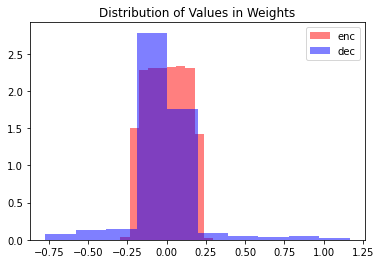

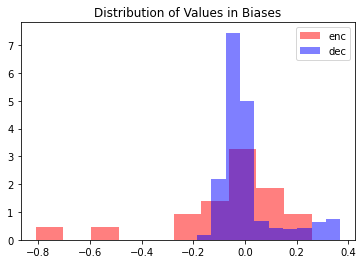

In [14]:
plt.hist(weights[0].detach().numpy().flatten(), alpha=0.5, color='r', density=True, label='enc')
plt.hist(weights[2].detach().numpy().flatten(), alpha=0.5, color='b', density=True, label='dec')
plt.title("Distribution of Values in Weights")
plt.legend()
plt.show()

plt.hist(weights[1].detach().numpy().flatten(), alpha=0.5, color='r', density=True, label='enc')
plt.hist(weights[3].detach().numpy().flatten(), alpha=0.5, color='b', density=True, label='dec')
plt.title("Distribution of Values in Biases")
plt.legend()
plt.show()

## EVALUATE PERFORMANCE

In [15]:
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

model.load_state_dict(torch.load(save_name))

<All keys matched successfully>

In [16]:
def print_results(model, df_large, U_large, scale, params):
    
    with torch.no_grad():
        x_recon, x_enc, x_map = model(U_large, df_large, params, reset_enc=True, reset_dec=True)
        
        x_rom = model.decoder(x_map)
        x_rom = model.GFN.decoder(x_rom, df_large, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False)

        error_abs_list = list()
        norm_z_list = list()
        latents_error = list()
        Z = undo_scaling(U_large, scale)
        Z_net = undo_scaling(x_rom, scale)
        for snap in range(U_large.shape[0]):
            error_abs = np.linalg.norm(abs(Z[:, snap] - Z_net[:, snap]))
            norm_z = np.linalg.norm(Z[:, snap], 2)
            error_abs_list.append(error_abs)
            norm_z_list.append(norm_z)
            lat_err = np.linalg.norm(x_enc[snap] - x_map[snap])/np.linalg.norm(x_enc[snap])
            latents_error.append(lat_err)

        latents_error = np.array(latents_error)
        print("\nMaximum relative error for latent  = ", max(latents_error))
        print("Mean relative error for latent = ", sum(latents_error)/len(latents_error))
        print("Minimum relative error for latent = ", min(latents_error))

        error = np.array(error_abs_list)
        norm = np.array(norm_z_list)
        rel_error = error/norm
        print("\nMaximum absolute error for field "+" = ", max(error))
        print("Mean absolute error for field "+" = ", sum(error)/len(error))
        print("Minimum absolute error for field "+" = ", min(error))
        print("\nMaximum relative error for field "+" = ", max(rel_error))
        print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
        print("Minimum relative error for field "+" = ", min(rel_error))

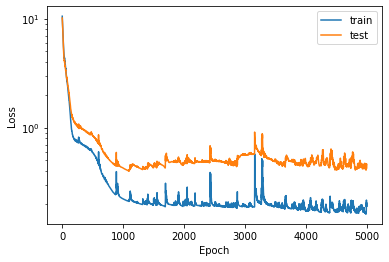

In [17]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
for i in range(len(test_mesh_names)):
    print('-'*40)
    print(f'TEST MESH: {test_mesh_names[i]}')
    scale, U = get_scaled_data(test_solution_names[i])
    U = U.to('cpu')
    df = pd.read_csv(test_mesh_names[i], header=None).values

    model.eval()
    model.to('cpu')
    print_results(model, df, U, scale, params.to('cpu'))
    print()

----------------------------------------
TEST MESH: reference_mesh_large.csv
reconstruction error tensor(5.4842e-09, dtype=torch.float64)

Maximum relative error for latent  =  1.22625
Mean relative error for latent =  0.05301485179436647
Minimum relative error for latent =  0.0042311307

Maximum absolute error for field  =  35.67341
Mean absolute error for field  =  10.652421336621046
Minimum absolute error for field  =  2.5911403

Maximum relative error for field  =  0.38920182
Mean relative error for field  =  0.13830672783396122
Minimum relative error for field  =  0.05307318

----------------------------------------
TEST MESH: reference_mesh.csv
reconstruction error tensor(2.4297e-09, dtype=torch.float64)

Maximum relative error for latent  =  1.2426413
Mean relative error for latent =  0.18940623235936405
Minimum relative error for latent =  0.009540679

Maximum absolute error for field  =  23.714691
Mean absolute error for field  =  7.1090159566903655
Minimum absolute error for 